In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:3


In [2]:
def true_disc(x): #[-4,3.75]
    y  = np.zeros((np.shape(x)[0],))
    
    y = 0.2*np.sin(6*x)*np.exp(-1*x)
    y[x>0] = 1 + 0.1*x[x>0]*np.exp(x[x>0]) + 10
    
    return 50*y

In [3]:
# Domain bounds
label = "Regr_disc_swish"
loss_thresh = 0.1

lb = np.array(-4.0)  # [-1. 0.]
ub = np.array(3.75) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_disc(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_disc(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Sigmoid()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        
        self.beta = Parameter(torch.ones((layers[1],len(layers)-2)))
        self.beta.requiresGrad = True
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = z*self.activation(self.beta[:,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(model_NN.beta.cpu().detach().numpy())
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 3000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))


for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    beta_val = []
    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=0.008)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    beta_full.append(beta_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"beta": beta_full, "label": label}
savemat(label+'.mat', mdic) 

Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 1338.0524 Test MSE 1275.1535439583736 Test RE 0.996998034496333
1 Train Loss 1330.4086 Test MSE 1264.998496096892 Test RE 0.9930201602507516
2 Train Loss 1319.7058 Test MSE 1249.5691935133761 Test RE 0.9869456014861993
3 Train Loss 1303.449 Test MSE 1226.5362516552634 Test RE 0.9778072553403149
4 Train Loss 1279.1786 Test MSE 1192.8767562857513 Test RE 0.9642970743785476
5 Train Loss 1243.6892 Test MSE 1145.152338478189 Test RE 0.9448104609714058
6 Train Loss 1193.3081 Test MSE 1079.9825173051731 Test RE 0.9175324307839063
7 Train Loss 1124.3606 Test MSE 994.826587759232 Test R

101 Train Loss 180.3875 Test MSE 181.99197508091677 Test RE 0.37665104797497473
102 Train Loss 178.52129 Test MSE 180.6192335775207 Test RE 0.3752278445071008
103 Train Loss 176.5716 Test MSE 178.97506765845023 Test RE 0.3735161019839016
104 Train Loss 174.47885 Test MSE 176.9796988861517 Test RE 0.371428125832837
105 Train Loss 172.20312 Test MSE 174.8020330335333 Test RE 0.36913591403599183
106 Train Loss 169.80258 Test MSE 172.62511059810345 Test RE 0.3668301690288379
107 Train Loss 167.27707 Test MSE 170.50458995586035 Test RE 0.36457014276906236
108 Train Loss 164.57086 Test MSE 168.44139024990142 Test RE 0.3623576793535903
109 Train Loss 161.74313 Test MSE 166.33375770686894 Test RE 0.36008353250345565
110 Train Loss 158.87206 Test MSE 164.04221618240666 Test RE 0.3575945366207499
111 Train Loss 155.95268 Test MSE 161.6785530652457 Test RE 0.355008922121005
112 Train Loss 153.04852 Test MSE 159.4822489099058 Test RE 0.3525893876244999
113 Train Loss 150.20245 Test MSE 157.4776017

206 Train Loss 70.11619 Test MSE 79.18825018840698 Test RE 0.24845253614321156
207 Train Loss 69.37067 Test MSE 78.73575859526015 Test RE 0.24774167472469652
208 Train Loss 69.057594 Test MSE 78.8251748111121 Test RE 0.24788230864862923
209 Train Loss 68.97881 Test MSE 79.5564020740735 Test RE 0.249029403325048
210 Train Loss 69.18879 Test MSE 79.22581573403943 Test RE 0.2485114599636033
211 Train Loss 69.95569 Test MSE 81.92885215929971 Test RE 0.2527152768537802
212 Train Loss 71.651115 Test MSE 82.64701040176801 Test RE 0.2538204648932606
213 Train Loss 73.76579 Test MSE 84.4335207881772 Test RE 0.25654910898047906
214 Train Loss 73.91268 Test MSE 78.75979873617025 Test RE 0.24777949293038307
215 Train Loss 69.63038 Test MSE 76.67690470080504 Test RE 0.2444811318309682
216 Train Loss 67.51723 Test MSE 79.76056096286209 Test RE 0.24934873017437953
217 Train Loss 70.20732 Test MSE 78.8606400458788 Test RE 0.24793806631534931
218 Train Loss 70.5252 Test MSE 77.13055066878538 Test RE 0.

311 Train Loss 57.04763 Test MSE 62.37207043954477 Test RE 0.22049977028343185
312 Train Loss 55.376785 Test MSE 62.62057199743849 Test RE 0.22093858902613428
313 Train Loss 56.651096 Test MSE 64.34325123765626 Test RE 0.2239569590713066
314 Train Loss 56.59827 Test MSE 61.24676628699049 Test RE 0.21850161076100622
315 Train Loss 55.263557 Test MSE 61.43253401162631 Test RE 0.21883272877168147
316 Train Loss 55.747932 Test MSE 64.11570170039644 Test RE 0.22356059708029294
317 Train Loss 56.120335 Test MSE 61.5325751203912 Test RE 0.2190108376816437
318 Train Loss 55.181896 Test MSE 60.92973679049846 Test RE 0.21793536592507923
319 Train Loss 55.040276 Test MSE 63.1377190355841 Test RE 0.2218490151468196
320 Train Loss 55.58509 Test MSE 61.94727613534422 Test RE 0.21974761411319654
321 Train Loss 55.26673 Test MSE 61.52981356611319 Test RE 0.21900592307258823
322 Train Loss 54.628437 Test MSE 61.856884871850404 Test RE 0.21958723163181235
323 Train Loss 54.91171 Test MSE 61.391856029601

415 Train Loss 50.11454 Test MSE 56.54980611770403 Test RE 0.20995616001213188
416 Train Loss 50.12648 Test MSE 56.834346593396596 Test RE 0.21048371323286785
417 Train Loss 50.063812 Test MSE 56.62661969486938 Test RE 0.21009870701530053
418 Train Loss 49.962803 Test MSE 56.617758394713334 Test RE 0.2100822675690156
419 Train Loss 49.933956 Test MSE 56.66739598317732 Test RE 0.21017433843908725
420 Train Loss 49.90944 Test MSE 56.135055832126696 Test RE 0.20918480784530366
421 Train Loss 49.84707 Test MSE 56.56917006410409 Test RE 0.20999210382989741
422 Train Loss 49.77503 Test MSE 56.49437369464048 Test RE 0.20985323099267342
423 Train Loss 49.728447 Test MSE 55.970636136035 Test RE 0.20887823182009482
424 Train Loss 49.703945 Test MSE 56.42771405605988 Test RE 0.20972938795749904
425 Train Loss 49.65027 Test MSE 56.1809594996704 Test RE 0.20927031936290297
426 Train Loss 49.57636 Test MSE 56.08364457686891 Test RE 0.20908899501599565
427 Train Loss 49.527298 Test MSE 56.21457478982

519 Train Loss 45.959343 Test MSE 51.78432739542976 Test RE 0.20091493948119987
520 Train Loss 45.872974 Test MSE 51.73441099057594 Test RE 0.200818082285894
521 Train Loss 45.875458 Test MSE 51.801568910820706 Test RE 0.20094838386392747
522 Train Loss 45.778103 Test MSE 52.05997031778261 Test RE 0.20144895510630295
523 Train Loss 45.707367 Test MSE 51.9173676567492 Test RE 0.20117286143749777
524 Train Loss 45.687637 Test MSE 51.32464016196301 Test RE 0.20002119501523452
525 Train Loss 45.617672 Test MSE 51.63959395066465 Test RE 0.2006339716700291
526 Train Loss 45.531376 Test MSE 51.91985961572687 Test RE 0.2011776893835715
527 Train Loss 45.51057 Test MSE 51.45297065189857 Test RE 0.20027110219946623
528 Train Loss 45.445946 Test MSE 51.39183374568772 Test RE 0.2001520848259783
529 Train Loss 45.385048 Test MSE 51.36520596822392 Test RE 0.20010022546112946
530 Train Loss 45.32406 Test MSE 51.4695760178771 Test RE 0.20030341623919257
531 Train Loss 45.277676 Test MSE 51.54626412376

624 Train Loss 42.955322 Test MSE 48.17895020515676 Test RE 0.1937946249469494
625 Train Loss 43.173004 Test MSE 48.01039358656248 Test RE 0.19345532752544986
626 Train Loss 42.832954 Test MSE 49.19168841695793 Test RE 0.19582084740003627
627 Train Loss 42.8695 Test MSE 49.8375921253953 Test RE 0.19710225217721028
628 Train Loss 42.98328 Test MSE 48.85246159251948 Test RE 0.19514448717952976
629 Train Loss 42.653072 Test MSE 47.886026278417575 Test RE 0.19320459932017844
630 Train Loss 42.872272 Test MSE 48.24263696946568 Test RE 0.19392266921249346
631 Train Loss 42.66688 Test MSE 49.84618065740279 Test RE 0.19711923480021254
632 Train Loss 42.653015 Test MSE 48.9685261132046 Test RE 0.19537616347492934
633 Train Loss 42.634556 Test MSE 47.2314306799825 Test RE 0.19187951474117468
634 Train Loss 42.644703 Test MSE 48.0940428991267 Test RE 0.1936237844091165
635 Train Loss 42.488438 Test MSE 49.50099883362602 Test RE 0.19643552962592664
636 Train Loss 42.60511 Test MSE 48.3164697065998

729 Train Loss 41.0531 Test MSE 46.51264142283234 Test RE 0.19041386253812298
730 Train Loss 41.041233 Test MSE 46.481203066032265 Test RE 0.19034950034906264
731 Train Loss 41.029423 Test MSE 46.466968514586256 Test RE 0.19032035149906537
732 Train Loss 41.017582 Test MSE 46.45521578014319 Test RE 0.19029628143300262
733 Train Loss 41.00579 Test MSE 46.42917238729229 Test RE 0.1902429326806522
734 Train Loss 40.994003 Test MSE 46.406970982197535 Test RE 0.19019744225691962
735 Train Loss 40.98224 Test MSE 46.39364387108638 Test RE 0.19017012993290217
736 Train Loss 40.970516 Test MSE 46.3759077701854 Test RE 0.19013377582539667
737 Train Loss 40.95878 Test MSE 46.353822512342276 Test RE 0.19008849742851136
738 Train Loss 40.94706 Test MSE 46.33060664340681 Test RE 0.19004088946327163
739 Train Loss 40.93536 Test MSE 46.31598005688046 Test RE 0.1900108891121716
740 Train Loss 40.923687 Test MSE 46.299762179649825 Test RE 0.18997761935220556
741 Train Loss 40.912014 Test MSE 46.27167059

834 Train Loss 40.465885 Test MSE 45.42128066865849 Test RE 0.18816669138088812
835 Train Loss 40.468147 Test MSE 45.64173331129071 Test RE 0.18862277311614573
836 Train Loss 40.439472 Test MSE 45.78639654791001 Test RE 0.18892146021074208
837 Train Loss 40.432297 Test MSE 45.43761400864684 Test RE 0.18820052039510793
838 Train Loss 40.416622 Test MSE 45.42786959768506 Test RE 0.18818033886062574
839 Train Loss 40.398964 Test MSE 45.67112348568418 Test RE 0.188683493466219
840 Train Loss 40.392715 Test MSE 45.47637312730466 Test RE 0.18828077253357317
841 Train Loss 40.37047 Test MSE 45.363994854002534 Test RE 0.18804799500189834
842 Train Loss 40.364136 Test MSE 45.564358705307 Test RE 0.1884628229745261
843 Train Loss 40.35058 Test MSE 45.47673033951125 Test RE 0.18828151199511678
844 Train Loss 40.333202 Test MSE 45.32429505458393 Test RE 0.18796569292783963
845 Train Loss 40.32892 Test MSE 45.465564989541726 Test RE 0.1882583973383675
846 Train Loss 40.31114 Test MSE 45.43813999722

939 Train Loss 39.23009 Test MSE 43.90783805792976 Test RE 0.1850052649488848
940 Train Loss 39.21764 Test MSE 43.889903247226684 Test RE 0.18496747701116037
941 Train Loss 39.20515 Test MSE 43.87422219160616 Test RE 0.1849344313195639
942 Train Loss 39.19265 Test MSE 43.85691388170869 Test RE 0.18489794955375607
943 Train Loss 39.180107 Test MSE 43.84009160668359 Test RE 0.1848624853337884
944 Train Loss 39.16756 Test MSE 43.82430485290716 Test RE 0.18482919797962477
945 Train Loss 39.154953 Test MSE 43.80642982761088 Test RE 0.18479150013638707
946 Train Loss 39.14233 Test MSE 43.7905037521825 Test RE 0.18475790608505385
947 Train Loss 39.12969 Test MSE 43.77379032068492 Test RE 0.1847226446351913
948 Train Loss 39.116974 Test MSE 43.756046656591984 Test RE 0.18468520226672352
949 Train Loss 39.10426 Test MSE 43.74068720219447 Test RE 0.1846527848851571
950 Train Loss 39.09152 Test MSE 43.72242090339246 Test RE 0.18461422496109753
951 Train Loss 39.07875 Test MSE 43.70699370102769 Te

1043 Train Loss 39.283413 Test MSE 43.35572449660535 Test RE 0.18383842260384076
1044 Train Loss 39.20405 Test MSE 42.92646750548502 Test RE 0.18292608369035393
1045 Train Loss 39.312897 Test MSE 44.29681760205179 Test RE 0.1858229388340818
1046 Train Loss 39.09496 Test MSE 45.17039314719054 Test RE 0.18764629604118332
1047 Train Loss 39.275112 Test MSE 43.59785231097984 Test RE 0.18435104720011208
1048 Train Loss 39.044884 Test MSE 42.664091127763704 Test RE 0.18236618380972516
1049 Train Loss 39.210484 Test MSE 43.49118179127945 Test RE 0.1841253839604378
1050 Train Loss 39.018925 Test MSE 44.67177461194853 Test RE 0.18660774452814838
1051 Train Loss 39.124874 Test MSE 44.04268344536543 Test RE 0.1852891320591664
1052 Train Loss 39.03178 Test MSE 42.99670834907842 Test RE 0.1830756840569759
1053 Train Loss 39.026363 Test MSE 43.13706538021738 Test RE 0.18337425369604354
1054 Train Loss 39.01866 Test MSE 43.90815777757019 Test RE 0.18500593851551583
1055 Train Loss 38.97045 Test MSE 4

1146 Train Loss 37.402626 Test MSE 41.86610811005658 Test RE 0.1806526581829168
1147 Train Loss 37.3751 Test MSE 41.84873264393991 Test RE 0.18061516664103283
1148 Train Loss 37.347057 Test MSE 41.81761175414224 Test RE 0.18054799674448518
1149 Train Loss 37.318443 Test MSE 41.78149672751659 Test RE 0.18047001639276902
1150 Train Loss 37.2893 Test MSE 41.75762101704396 Test RE 0.18041844493245143
1151 Train Loss 37.259537 Test MSE 41.730722556919225 Test RE 0.1803603266776244
1152 Train Loss 37.22918 Test MSE 41.69476085575877 Test RE 0.18028259662976884
1153 Train Loss 37.198242 Test MSE 41.66258150820805 Test RE 0.18021301359343933
1154 Train Loss 37.16664 Test MSE 41.63591171641115 Test RE 0.18015532378176186
1155 Train Loss 37.134415 Test MSE 41.60507496987099 Test RE 0.180088597332981
1156 Train Loss 37.101498 Test MSE 41.567006516083836 Test RE 0.18000618835522664
1157 Train Loss 37.067936 Test MSE 41.5331541425352 Test RE 0.17993287446498699
1158 Train Loss 37.03368 Test MSE 41.

1249 Train Loss 35.203884 Test MSE 38.15546424324727 Test RE 0.17246121127922978
1250 Train Loss 36.062508 Test MSE 40.13025214233907 Test RE 0.17686789425244345
1251 Train Loss 35.155266 Test MSE 42.38540135213628 Test RE 0.1817695830269923
1252 Train Loss 35.377983 Test MSE 41.04660755407268 Test RE 0.17887584384814656
1253 Train Loss 35.139442 Test MSE 38.86345245451125 Test RE 0.17405389658763
1254 Train Loss 35.133934 Test MSE 38.84079055345184 Test RE 0.17400314238140824
1255 Train Loss 34.70717 Test MSE 40.42756022578379 Test RE 0.17752185500949977
1256 Train Loss 34.897408 Test MSE 40.022147030961506 Test RE 0.1766295052988773
1257 Train Loss 34.650795 Test MSE 38.45279617845215 Test RE 0.17313187163978427
1258 Train Loss 34.65672 Test MSE 37.955973390743274 Test RE 0.17200977499794534
1259 Train Loss 34.368145 Test MSE 39.98659092494686 Test RE 0.17655102808858578
1260 Train Loss 34.43666 Test MSE 40.60048567682053 Test RE 0.1779011171962886
1261 Train Loss 34.332455 Test MSE 

1351 Train Loss 28.540619 Test MSE 33.703811579355026 Test RE 0.16208863693155764
1352 Train Loss 28.477345 Test MSE 33.62783191635377 Test RE 0.16190583285024535
1353 Train Loss 28.414108 Test MSE 33.56847794498759 Test RE 0.1617628858071258
1354 Train Loss 28.351074 Test MSE 33.528629738630215 Test RE 0.16166684518597177
1355 Train Loss 28.288223 Test MSE 33.45516130308424 Test RE 0.1614896246446581
1356 Train Loss 28.22548 Test MSE 33.38801664374268 Test RE 0.16132748804975688
1357 Train Loss 28.162937 Test MSE 33.33784139151287 Test RE 0.16120622162471768
1358 Train Loss 28.100506 Test MSE 33.28593671256797 Test RE 0.16108067935484174
1359 Train Loss 28.038292 Test MSE 33.2137263743004 Test RE 0.16090586069599985
1360 Train Loss 27.97627 Test MSE 33.158724214779156 Test RE 0.160772574886082
1361 Train Loss 27.914454 Test MSE 33.10791643320608 Test RE 0.16064935498655109
1362 Train Loss 27.852865 Test MSE 33.03810535001292 Test RE 0.16047989364684676
1363 Train Loss 27.791502 Test M

1453 Train Loss 25.249922 Test MSE 30.9674429239676 Test RE 0.15536948776539086
1454 Train Loss 25.246338 Test MSE 30.586170175019525 Test RE 0.1544100669501603
1455 Train Loss 25.216036 Test MSE 29.810084152074 Test RE 0.1524384983766414
1456 Train Loss 25.21896 Test MSE 30.383293044330394 Test RE 0.15389711631430034
1457 Train Loss 25.069786 Test MSE 30.87872057488805 Test RE 0.1551467597615539
1458 Train Loss 25.130306 Test MSE 30.193194157393812 Test RE 0.15341491750993103
1459 Train Loss 25.08324 Test MSE 30.052555840229044 Test RE 0.153057201141993
1460 Train Loss 25.020012 Test MSE 30.582811053518203 Test RE 0.15440158768625156
1461 Train Loss 25.003523 Test MSE 30.20641242225532 Test RE 0.1534484955590982
1462 Train Loss 24.970526 Test MSE 29.826802431075617 Test RE 0.1524812381440947
1463 Train Loss 24.965517 Test MSE 30.3105902744373 Test RE 0.15371287940659875
1464 Train Loss 24.901855 Test MSE 30.41483332249053 Test RE 0.15397697432712684
1465 Train Loss 24.90183 Test MSE 3

1555 Train Loss 24.445631 Test MSE 29.53398908894073 Test RE 0.15173092871521762
1556 Train Loss 24.052553 Test MSE 28.675934990750324 Test RE 0.14951055532737514
1557 Train Loss 23.84589 Test MSE 29.613286572203993 Test RE 0.15193448766044332
1558 Train Loss 23.92623 Test MSE 29.49130693813658 Test RE 0.15162124925597717
1559 Train Loss 24.110964 Test MSE 28.85558050889088 Test RE 0.1499781419438479
1560 Train Loss 24.098661 Test MSE 29.304920543948338 Test RE 0.15114136325114255
1561 Train Loss 23.791513 Test MSE 29.429712850292344 Test RE 0.1514628321689798
1562 Train Loss 23.719757 Test MSE 28.821587485205594 Test RE 0.1498897757976766
1563 Train Loss 23.871433 Test MSE 29.339864815686962 Test RE 0.15123144968094668
1564 Train Loss 23.864845 Test MSE 29.482652120748675 Test RE 0.15159899947033406
1565 Train Loss 23.823162 Test MSE 28.462017509358486 Test RE 0.14895185006242925
1566 Train Loss 23.759129 Test MSE 29.196108851249907 Test RE 0.15086050184664415
1567 Train Loss 23.6547 

1657 Train Loss 22.914173 Test MSE 28.279159860712852 Test RE 0.14847259954952738
1658 Train Loss 22.949411 Test MSE 28.3129379213835 Test RE 0.14856124468284562
1659 Train Loss 22.917538 Test MSE 28.080806425561505 Test RE 0.1479509809132261
1660 Train Loss 22.84711 Test MSE 28.322724782131907 Test RE 0.14858691885686515
1661 Train Loss 22.776333 Test MSE 27.96755744189017 Test RE 0.14765233874617664
1662 Train Loss 22.738234 Test MSE 28.23365174349595 Test RE 0.14835308700057687
1663 Train Loss 22.72934 Test MSE 28.22133851448792 Test RE 0.14832073368051174
1664 Train Loss 22.739634 Test MSE 27.930080676270478 Test RE 0.14755337788604428
1665 Train Loss 22.763649 Test MSE 28.400574477989053 Test RE 0.14879098659179552
1666 Train Loss 22.778862 Test MSE 27.908193437845043 Test RE 0.14749555189998093
1667 Train Loss 22.772951 Test MSE 28.318211581404327 Test RE 0.14857507978925136
1668 Train Loss 22.755537 Test MSE 28.015661152310958 Test RE 0.14777926391449955
1669 Train Loss 22.73012

1760 Train Loss 22.587498 Test MSE 28.156443616652478 Test RE 0.14815010395400321
1761 Train Loss 22.515877 Test MSE 28.053613622387072 Test RE 0.14787932740890292
1762 Train Loss 22.252169 Test MSE 27.097812900470394 Test RE 0.14533833510933541
1763 Train Loss 22.4399 Test MSE 28.384647933878703 Test RE 0.14874926105326064
1764 Train Loss 22.401909 Test MSE 27.9598108776552 Test RE 0.1476318886667707
1765 Train Loss 22.203047 Test MSE 27.0696067915978 Test RE 0.14526267409108654
1766 Train Loss 22.392 Test MSE 28.465534756020528 Test RE 0.14896105327883466
1767 Train Loss 22.347208 Test MSE 27.607762319204674 Test RE 0.14669951049528313
1768 Train Loss 22.113438 Test MSE 27.074183424467407 Test RE 0.14527495328369908
1769 Train Loss 22.339233 Test MSE 28.652590825958775 Test RE 0.14944968704798012
1770 Train Loss 22.363579 Test MSE 27.49715781042474 Test RE 0.14640535570545432
1771 Train Loss 22.078558 Test MSE 27.07272366097996 Test RE 0.14527103682336287
1772 Train Loss 22.260464 Te

1863 Train Loss 25.918879 Test MSE 27.628443870842602 Test RE 0.14675444804284649
1864 Train Loss 22.3868 Test MSE 29.12498697832031 Test RE 0.15067664132372027
1865 Train Loss 23.500435 Test MSE 29.845635265355682 Test RE 0.1525293693633782
1866 Train Loss 24.212296 Test MSE 27.621278762485836 Test RE 0.14673541729847892
1867 Train Loss 22.437542 Test MSE 28.490184217286867 Test RE 0.1490255350318772
1868 Train Loss 23.407557 Test MSE 28.251082455451865 Test RE 0.14839887457629178
1869 Train Loss 22.593966 Test MSE 28.55482208676022 Test RE 0.14919449209423863
1870 Train Loss 23.059969 Test MSE 27.93030508940295 Test RE 0.1475539706671681
1871 Train Loss 22.538652 Test MSE 27.829090681460762 Test RE 0.14728637347534626
1872 Train Loss 22.050003 Test MSE 28.394270185769678 Test RE 0.1487744715399511
1873 Train Loss 23.051102 Test MSE 27.09429698174548 Test RE 0.14532890603931792
1874 Train Loss 21.855377 Test MSE 27.864613432439814 Test RE 0.1473803461580262
1875 Train Loss 22.218323 T

1966 Train Loss 20.619438 Test MSE 26.25672508167198 Test RE 0.14306498033152162
1967 Train Loss 20.60817 Test MSE 26.24565973783904 Test RE 0.14303483129322359
1968 Train Loss 20.596788 Test MSE 26.24710503124754 Test RE 0.14303876955301567
1969 Train Loss 20.585457 Test MSE 26.22201610916618 Test RE 0.1429703896967766
1970 Train Loss 20.574167 Test MSE 26.22286519301055 Test RE 0.14297270440943877
1971 Train Loss 20.562809 Test MSE 26.209589970733692 Test RE 0.14293651014366232
1972 Train Loss 20.551445 Test MSE 26.192966906401878 Test RE 0.14289117521723652
1973 Train Loss 20.54009 Test MSE 26.196202924293 Test RE 0.14290000171100933
1974 Train Loss 20.52874 Test MSE 26.17687022986386 Test RE 0.14284726216001614
1975 Train Loss 20.517332 Test MSE 26.166699875159033 Test RE 0.14281950963551182
1976 Train Loss 20.505896 Test MSE 26.16673846050833 Test RE 0.14281961493611645
1977 Train Loss 20.494493 Test MSE 26.13662338661219 Test RE 0.1427374063437197
1978 Train Loss 20.483078 Test M

2068 Train Loss 21.33111 Test MSE 25.88063070410291 Test RE 0.14203667229906058
2069 Train Loss 22.990276 Test MSE 29.161552194512804 Test RE 0.15077119580041512
2070 Train Loss 21.663448 Test MSE 28.283882500865356 Test RE 0.14848499654773337
2071 Train Loss 21.373068 Test MSE 25.883582143560467 Test RE 0.1420447710330659
2072 Train Loss 22.795982 Test MSE 28.376934810575317 Test RE 0.148729049434869
2073 Train Loss 21.314356 Test MSE 27.927537209320054 Test RE 0.14754665922151602
2074 Train Loss 21.19307 Test MSE 25.780165735987246 Test RE 0.14176072104593054
2075 Train Loss 22.458256 Test MSE 27.842764098333745 Test RE 0.14732255253509313
2076 Train Loss 21.045744 Test MSE 27.565965300094412 Test RE 0.14658841991358953
2077 Train Loss 20.997149 Test MSE 25.636453040928 Test RE 0.1413650430818722
2078 Train Loss 22.033213 Test MSE 27.50281085520078 Test RE 0.14642040441528154
2079 Train Loss 20.854397 Test MSE 27.271930666763016 Test RE 0.14580452522872958
2080 Train Loss 20.806772 T

2171 Train Loss 19.114216 Test MSE 24.76038562165594 Test RE 0.13892863320379523
2172 Train Loss 19.098637 Test MSE 24.755881030080907 Test RE 0.13891599516927286
2173 Train Loss 19.083153 Test MSE 24.713479715005548 Test RE 0.13879697809218572
2174 Train Loss 19.067654 Test MSE 24.730062697554395 Test RE 0.13884353733659896
2175 Train Loss 19.052038 Test MSE 24.70079673325679 Test RE 0.13876135814969365
2176 Train Loss 19.036394 Test MSE 24.68032311715038 Test RE 0.1387038390392374
2177 Train Loss 19.020792 Test MSE 24.688270058496155 Test RE 0.1387261682152142
2178 Train Loss 19.005188 Test MSE 24.649669933811758 Test RE 0.13861767656934296
2179 Train Loss 18.989485 Test MSE 24.648859766333008 Test RE 0.13861539855798155
2180 Train Loss 18.973772 Test MSE 24.638673428604584 Test RE 0.13858675363919135
2181 Train Loss 18.958055 Test MSE 24.60741986723448 Test RE 0.1384988287750329
2182 Train Loss 18.942331 Test MSE 24.61253333309579 Test RE 0.13851321817970516
2183 Train Loss 18.92655

2273 Train Loss 28.56717 Test MSE 32.96138248304258 Test RE 0.160293447815772
2274 Train Loss 28.997595 Test MSE 29.542538306803813 Test RE 0.1517528879382327
2275 Train Loss 26.14579 Test MSE 36.49077847664836 Test RE 0.168657098736324
2276 Train Loss 26.609884 Test MSE 32.64503733921206 Test RE 0.15952238931760515
2277 Train Loss 25.48555 Test MSE 28.695786725854994 Test RE 0.14956229785015768
2278 Train Loss 25.118853 Test MSE 34.97616577066431 Test RE 0.16511980243893265
2279 Train Loss 25.597399 Test MSE 28.1297236958938 Test RE 0.1480797914762124
2280 Train Loss 21.086355 Test MSE 29.261653872621707 Test RE 0.1510297471968127
2281 Train Loss 30.83098 Test MSE 41.1361500875718 Test RE 0.1790708449883376
2282 Train Loss 30.032314 Test MSE 38.57659346658915 Test RE 0.17341034336559394
2283 Train Loss 27.158327 Test MSE 30.641600983817924 Test RE 0.1545499210164142
2284 Train Loss 27.336576 Test MSE 28.514441237424503 Test RE 0.14908896295242394
2285 Train Loss 23.278051 Test MSE 35.

2375 Train Loss 16.875906 Test MSE 22.684828134383277 Test RE 0.13297830950700923
2376 Train Loss 16.855822 Test MSE 22.62750490141987 Test RE 0.13281018902969408
2377 Train Loss 16.835075 Test MSE 22.678338265854556 Test RE 0.1329592863635667
2378 Train Loss 16.813553 Test MSE 22.666870395400235 Test RE 0.1329256650139586
2379 Train Loss 16.79323 Test MSE 22.6052749317615 Test RE 0.13274493455364694
2380 Train Loss 16.772133 Test MSE 22.61208861888786 Test RE 0.13276493905054715
2381 Train Loss 16.751013 Test MSE 22.54260069957464 Test RE 0.13256078590763606
2382 Train Loss 16.730183 Test MSE 22.52965316102953 Test RE 0.13252271172030305
2383 Train Loss 16.708736 Test MSE 22.568854398758692 Test RE 0.13263795531561037
2384 Train Loss 16.687807 Test MSE 22.51695374600309 Test RE 0.13248535654815757
2385 Train Loss 16.66665 Test MSE 22.505477457524325 Test RE 0.13245159012554533
2386 Train Loss 16.64507 Test MSE 22.482611378784757 Test RE 0.13238428610634012
2387 Train Loss 16.623837 Te

2476 Train Loss 14.431919 Test MSE 20.352068680719697 Test RE 0.1259555593230062
2477 Train Loss 14.405706 Test MSE 20.337730045508483 Test RE 0.1259111817941429
2478 Train Loss 14.379499 Test MSE 20.294224855513562 Test RE 0.1257764390660385
2479 Train Loss 14.35334 Test MSE 20.2898566453305 Test RE 0.12576290202548288
2480 Train Loss 14.327227 Test MSE 20.231811337968917 Test RE 0.12558288166257095
2481 Train Loss 14.301218 Test MSE 20.24920153448691 Test RE 0.12563684227595545
2482 Train Loss 14.275452 Test MSE 20.160711989106392 Test RE 0.12536202354686876
2483 Train Loss 14.2502 Test MSE 20.225803667865822 Test RE 0.12556423487590782
2484 Train Loss 14.226185 Test MSE 20.069981315726473 Test RE 0.1250796176798873
2485 Train Loss 14.205129 Test MSE 20.249402398928556 Test RE 0.12563746540945403
2486 Train Loss 14.191101 Test MSE 19.95028984442448 Test RE 0.12470609090258727
2487 Train Loss 14.195469 Test MSE 20.43239180788948 Test RE 0.12620386778569487
2488 Train Loss 14.243663 Te

2578 Train Loss 13.760567 Test MSE 19.452583001388977 Test RE 0.12314072311203374
2579 Train Loss 13.760309 Test MSE 19.58837032437169 Test RE 0.12356976306789821
2580 Train Loss 13.720131 Test MSE 19.278420122545867 Test RE 0.12258823188907556
2581 Train Loss 13.680758 Test MSE 18.992024453351107 Test RE 0.12167425377536378
2582 Train Loss 13.673867 Test MSE 19.161467389644272 Test RE 0.12221582484563927
2583 Train Loss 13.643415 Test MSE 19.291171395845428 Test RE 0.12262876678885261
2584 Train Loss 13.608317 Test MSE 19.320168896109365 Test RE 0.12272089681962371
2585 Train Loss 13.589299 Test MSE 19.466907649767666 Test RE 0.12318605444262398
2586 Train Loss 13.5652275 Test MSE 19.381923137781346 Test RE 0.12291687051129861
2587 Train Loss 13.537691 Test MSE 19.098769215451934 Test RE 0.12201571001422304
2588 Train Loss 13.513801 Test MSE 19.03008602662075 Test RE 0.12179611533824855
2589 Train Loss 13.489107 Test MSE 19.076088500473478 Test RE 0.1219432387045486
2590 Train Loss 13

2680 Train Loss 11.66615 Test MSE 17.27436610098948 Test RE 0.11604171020977493
2681 Train Loss 11.64998 Test MSE 17.257239903633312 Test RE 0.11598417275687958
2682 Train Loss 11.633901 Test MSE 17.242118311061322 Test RE 0.11593334626933109
2683 Train Loss 11.61792 Test MSE 17.225565099655775 Test RE 0.11587768228493549
2684 Train Loss 11.602038 Test MSE 17.21034541246128 Test RE 0.11582647897746015
2685 Train Loss 11.586255 Test MSE 17.19374798581644 Test RE 0.11577061475291132
2686 Train Loss 11.57057 Test MSE 17.17618998417493 Test RE 0.1157114880327902
2687 Train Loss 11.554982 Test MSE 17.160985017138753 Test RE 0.11566026075527328
2688 Train Loss 11.539484 Test MSE 17.145412772778062 Test RE 0.11560777254979333
2689 Train Loss 11.5241 Test MSE 17.130394977758193 Test RE 0.11555713060251656
2690 Train Loss 11.508794 Test MSE 17.1155958798302 Test RE 0.11550720440976336
2691 Train Loss 11.493588 Test MSE 17.098820853477786 Test RE 0.11545058612388805
2692 Train Loss 11.478488 Tes

2783 Train Loss 11.923533 Test MSE 16.990157526229243 Test RE 0.11508315611716871
2784 Train Loss 11.867802 Test MSE 17.377545993336852 Test RE 0.11638775316552238
2785 Train Loss 11.873952 Test MSE 17.508593852237333 Test RE 0.11682578159669708
2786 Train Loss 11.856389 Test MSE 16.774273772071805 Test RE 0.11434967231998072
2787 Train Loss 11.809126 Test MSE 16.898283915444164 Test RE 0.1147715805103461
2788 Train Loss 11.818757 Test MSE 17.331355729088713 Test RE 0.11623296841545132
2789 Train Loss 11.7662 Test MSE 17.218509852554103 Test RE 0.11585394926349038
2790 Train Loss 11.783488 Test MSE 17.17322420268739 Test RE 0.11570149775541937
2791 Train Loss 11.729039 Test MSE 17.006513686862807 Test RE 0.11513853717478924
2792 Train Loss 11.735965 Test MSE 16.813587010497862 Test RE 0.11448359242635728
2793 Train Loss 11.703401 Test MSE 17.2120810303177 Test RE 0.11583231922738685
2794 Train Loss 11.7 Test MSE 17.05402428105506 Test RE 0.11529925456783041
2795 Train Loss 11.657025 Te

2884 Train Loss 10.686431 Test MSE 16.107101801911472 Test RE 0.11205255477220108
2885 Train Loss 10.678823 Test MSE 16.09737741578513 Test RE 0.11201872476245371
2886 Train Loss 10.671268 Test MSE 16.09380753665608 Test RE 0.11200630300359882
2887 Train Loss 10.663758 Test MSE 16.084717863146768 Test RE 0.11197466833549194
2888 Train Loss 10.656301 Test MSE 16.07803163911297 Test RE 0.11195139265399505
2889 Train Loss 10.648884 Test MSE 16.07165551269564 Test RE 0.11192919195703083
2890 Train Loss 10.64151 Test MSE 16.065552055878324 Test RE 0.11190793652814479
2891 Train Loss 10.6341715 Test MSE 16.058219106014445 Test RE 0.11188239402121046
2892 Train Loss 10.626893 Test MSE 16.04864283041715 Test RE 0.11184902866437016
2893 Train Loss 10.619634 Test MSE 16.04446158495815 Test RE 0.11183445737902278
2894 Train Loss 10.612432 Test MSE 16.037069895930536 Test RE 0.11180869332461532
2895 Train Loss 10.605263 Test MSE 16.029014116982715 Test RE 0.11178060779330133
2896 Train Loss 10.598

2985 Train Loss 10.042661 Test MSE 15.41077361913573 Test RE 0.10960371668461782
2986 Train Loss 10.036528 Test MSE 15.400666569855384 Test RE 0.1095677693699775
2987 Train Loss 10.030402 Test MSE 15.39628198626613 Test RE 0.10955217123857841
2988 Train Loss 10.024248 Test MSE 15.38441049101932 Test RE 0.10950992730985096
2989 Train Loss 10.018091 Test MSE 15.382215301802423 Test RE 0.10950211408919593
2990 Train Loss 10.011911 Test MSE 15.367188567557337 Test RE 0.10944861525336472
2991 Train Loss 10.005731 Test MSE 15.36932247921604 Test RE 0.10945621409188187
2992 Train Loss 9.999548 Test MSE 15.348011307085345 Test RE 0.10938030152657804
2993 Train Loss 9.993362 Test MSE 15.358733482453275 Test RE 0.1094185015901944
2994 Train Loss 9.987184 Test MSE 15.325683606422142 Test RE 0.10930071142733339
2995 Train Loss 9.981078 Test MSE 15.352828371914711 Test RE 0.10939746500976182
2996 Train Loss 9.975063 Test MSE 15.29693661263911 Test RE 0.10919815346773307
2997 Train Loss 9.969285 Tes

3088 Train Loss 9.553325 Test MSE 14.696925231817083 Test RE 0.10703512076509895
3089 Train Loss 9.538098 Test MSE 14.720050005294695 Test RE 0.1071192944958666
3090 Train Loss 9.518369 Test MSE 14.657825734143115 Test RE 0.10689264856291851
3091 Train Loss 9.501319 Test MSE 14.743981071343223 Test RE 0.10720633352987945
3092 Train Loss 9.490806 Test MSE 14.640750596332827 Test RE 0.10683036993438061
3093 Train Loss 9.486494 Test MSE 14.567541597209273 Test RE 0.10656294013939953
3094 Train Loss 9.482982 Test MSE 14.63637848519715 Test RE 0.10681441757175071
3095 Train Loss 9.47619 Test MSE 14.5924652756542 Test RE 0.1066540607101507
3096 Train Loss 9.468408 Test MSE 14.62312217962328 Test RE 0.10676603520316019
3097 Train Loss 9.460131 Test MSE 14.661882227252041 Test RE 0.10690743859059408
3098 Train Loss 9.448151 Test MSE 14.550204112554939 Test RE 0.10649950859322926
3099 Train Loss 9.433867 Test MSE 14.547533028889623 Test RE 0.10648973271131498
3100 Train Loss 9.42159 Test MSE 14

3190 Train Loss 8.835306 Test MSE 13.626311422436174 Test RE 0.10306286621128737
3191 Train Loss 8.806522 Test MSE 13.626905667516459 Test RE 0.10306511347878335
3192 Train Loss 8.789844 Test MSE 13.824555236893687 Test RE 0.10380986949320056
3193 Train Loss 8.785137 Test MSE 13.702330010255071 Test RE 0.10334995039030562
3194 Train Loss 8.782268 Test MSE 13.776857880065283 Test RE 0.10363063281781305
3195 Train Loss 8.772442 Test MSE 13.73935196730496 Test RE 0.1034894754352686
3196 Train Loss 8.757276 Test MSE 13.56325182338721 Test RE 0.1028241134272316
3197 Train Loss 8.737313 Test MSE 13.634249627855164 Test RE 0.10309288222436687
3198 Train Loss 8.715465 Test MSE 13.651992008988257 Test RE 0.10315993829949469
3199 Train Loss 8.698838 Test MSE 13.597789612906592 Test RE 0.10295494708412738
3200 Train Loss 8.688507 Test MSE 13.68495699710014 Test RE 0.10328441155382853
3201 Train Loss 8.679931 Test MSE 13.595902017936135 Test RE 0.10294780092322199
3202 Train Loss 8.670112 Test MSE

3293 Train Loss 7.9529266 Test MSE 12.498094163821976 Test RE 0.09870404643843159
3294 Train Loss 7.931449 Test MSE 12.498590226392395 Test RE 0.09870600525297175
3295 Train Loss 7.8999662 Test MSE 12.602856336172925 Test RE 0.0991168642436758
3296 Train Loss 7.8799295 Test MSE 12.426627180919512 Test RE 0.0984214356076767
3297 Train Loss 7.87488 Test MSE 12.64158936983712 Test RE 0.09926905798197184
3298 Train Loss 7.868104 Test MSE 12.749582082331019 Test RE 0.09969216684799123
3299 Train Loss 7.8465123 Test MSE 12.435046727663723 Test RE 0.09845477223030993
3300 Train Loss 7.818078 Test MSE 12.491290328751813 Test RE 0.09867717604254418
3301 Train Loss 7.8028955 Test MSE 12.450614140921765 Test RE 0.09851638063309077
3302 Train Loss 7.795625 Test MSE 12.317310353056033 Test RE 0.09798757348334293
3303 Train Loss 7.7792044 Test MSE 12.53461291703335 Test RE 0.09884814518786976
3304 Train Loss 7.7619705 Test MSE 12.520802200722335 Test RE 0.09879367442184321
3305 Train Loss 7.7494063 

3395 Train Loss 7.5325346 Test MSE 12.427645105726015 Test RE 0.09842546661173558
3396 Train Loss 7.944298 Test MSE 11.777354997218675 Test RE 0.09581575895056338
3397 Train Loss 7.3971877 Test MSE 11.791393629799767 Test RE 0.0958728482387473
3398 Train Loss 7.407598 Test MSE 12.694125734895076 Test RE 0.09947511705142321
3399 Train Loss 7.6631546 Test MSE 12.086532923356376 Test RE 0.09706528425485285
3400 Train Loss 7.371076 Test MSE 11.27468404771676 Test RE 0.09374869936969664
3401 Train Loss 7.3550115 Test MSE 11.687638995277958 Test RE 0.09545011487189088
3402 Train Loss 7.40036 Test MSE 12.243908135503077 Test RE 0.09769516984352664
3403 Train Loss 7.342264 Test MSE 11.670462553042709 Test RE 0.09537995116354467
3404 Train Loss 7.305696 Test MSE 11.793113605797904 Test RE 0.09587984032934005
3405 Train Loss 7.253817 Test MSE 12.40468423725976 Test RE 0.09833450090656887
3406 Train Loss 7.275971 Test MSE 11.263255922426229 Test RE 0.09370117504424741
3407 Train Loss 7.2144556 Te

3496 Train Loss 6.1009574 Test MSE 10.591335463151422 Test RE 0.09086328270234821
3497 Train Loss 6.096738 Test MSE 10.564761139969649 Test RE 0.09074922028000358
3498 Train Loss 6.0974984 Test MSE 10.600333986123765 Test RE 0.09090187376318155
3499 Train Loss 6.108282 Test MSE 10.590785163323952 Test RE 0.0908609221549705
3500 Train Loss 6.140543 Test MSE 10.709169008290296 Test RE 0.09136733282409594
3501 Train Loss 6.2172217 Test MSE 10.763962236644826 Test RE 0.09160077408304647
3502 Train Loss 6.394951 Test MSE 11.26521922546879 Test RE 0.09370934123470419
3503 Train Loss 6.783078 Test MSE 11.777343685210955 Test RE 0.09581571293561074
3504 Train Loss 7.6804137 Test MSE 13.889332340865604 Test RE 0.10405279390630155
3505 Train Loss 9.573117 Test MSE 17.05121015568711 Test RE 0.11528974127237027
3506 Train Loss 14.000241 Test MSE 25.500214678905603 Test RE 0.14098891855890144
3507 Train Loss 21.884203 Test MSE 38.38229372171784 Test RE 0.17297308185586355
3508 Train Loss 38.57586 T

3598 Train Loss 5.8208647 Test MSE 10.140266044648856 Test RE 0.08890736433793506
3599 Train Loss 5.813477 Test MSE 10.271341662347249 Test RE 0.08948013875022919
3600 Train Loss 5.8049326 Test MSE 10.147757334370016 Test RE 0.08894019916972129
3601 Train Loss 5.7960587 Test MSE 10.130047052529335 Test RE 0.08886255423796936
3602 Train Loss 5.788207 Test MSE 10.236805650571853 Test RE 0.0893295795889824
3603 Train Loss 5.7797456 Test MSE 10.131011783974058 Test RE 0.08886678553417678
3604 Train Loss 5.770887 Test MSE 10.141505187502842 Test RE 0.08891279642222356
3605 Train Loss 5.7636576 Test MSE 10.20974308022365 Test RE 0.08921142320406174
3606 Train Loss 5.7565765 Test MSE 10.10739764825145 Test RE 0.08876315636810594
3607 Train Loss 5.7475505 Test MSE 10.1072330084551 Test RE 0.0887624334318958
3608 Train Loss 5.7390623 Test MSE 10.16986953106694 Test RE 0.089037047809678
3609 Train Loss 5.732214 Test MSE 10.078119188566966 Test RE 0.08863450142838523
3610 Train Loss 5.7244353 Tes

3700 Train Loss 9.345125 Test MSE 19.683786933222464 Test RE 0.12387035684256006
3701 Train Loss 12.676545 Test MSE 11.353256652097743 Test RE 0.09407479678035965
3702 Train Loss 9.547495 Test MSE 9.005226026836143 Test RE 0.08378386098686348
3703 Train Loss 6.9129558 Test MSE 14.664251109407 Test RE 0.10691607462010003
3704 Train Loss 9.025173 Test MSE 12.540066127225094 Test RE 0.09886964489837119
3705 Train Loss 8.594035 Test MSE 11.907070343365518 Test RE 0.09634196958967856
3706 Train Loss 6.8769965 Test MSE 13.064441352979095 Test RE 0.10091564093387914
3707 Train Loss 8.213739 Test MSE 10.55426839003168 Test RE 0.09070414375579533
3708 Train Loss 7.6502914 Test MSE 9.69570963505695 Test RE 0.08693664205020789
3709 Train Loss 6.301342 Test MSE 11.63340732931705 Test RE 0.09522840895342484
3710 Train Loss 7.363311 Test MSE 11.703553239945832 Test RE 0.09551507665541463
3711 Train Loss 7.246401 Test MSE 11.416086816791063 Test RE 0.09433474773727947
3712 Train Loss 6.0837536 Test M

3802 Train Loss 5.0841913 Test MSE 9.475077102698107 Test RE 0.08594179839228318
3803 Train Loss 5.0805964 Test MSE 9.508648435562863 Test RE 0.0860939148115923
3804 Train Loss 5.076903 Test MSE 9.500335385326418 Test RE 0.08605627226227806
3805 Train Loss 5.07324 Test MSE 9.488696938293963 Test RE 0.08600354421341282
3806 Train Loss 5.0697308 Test MSE 9.510358214881467 Test RE 0.0861016548694671
3807 Train Loss 5.066198 Test MSE 9.484290785963967 Test RE 0.08598357367789526
3808 Train Loss 5.0625825 Test MSE 9.476359127048994 Test RE 0.08594761236880288
3809 Train Loss 5.059078 Test MSE 9.494159816807503 Test RE 0.08602829783941275
3810 Train Loss 5.0556245 Test MSE 9.470313137028883 Test RE 0.08592019037532193
3811 Train Loss 5.0521445 Test MSE 9.487981952823635 Test RE 0.08600030391375342
3812 Train Loss 5.048683 Test MSE 9.488165820174904 Test RE 0.08600113720852359
3813 Train Loss 5.0452776 Test MSE 9.464448150876835 Test RE 0.0858935809716297
3814 Train Loss 5.0419307 Test MSE 9.

3905 Train Loss 5.0485744 Test MSE 9.810538067876038 Test RE 0.08744993170896789
3906 Train Loss 5.0339403 Test MSE 9.24915109692469 Test RE 0.08491100831618656
3907 Train Loss 5.072527 Test MSE 9.188089651128422 Test RE 0.08463025960031074
3908 Train Loss 5.108881 Test MSE 9.633517245393554 Test RE 0.08665736925767945
3909 Train Loss 5.0655456 Test MSE 9.286378633258009 Test RE 0.08508171875439638
3910 Train Loss 4.9899015 Test MSE 9.222807535481667 Test RE 0.08478999972975332
3911 Train Loss 4.996969 Test MSE 9.667271270312606 Test RE 0.08680905203424309
3912 Train Loss 5.035367 Test MSE 9.284929595710183 Test RE 0.08507508046084117
3913 Train Loss 5.027347 Test MSE 9.149409209445142 Test RE 0.08445193154262656
3914 Train Loss 5.0073495 Test MSE 9.61141459425385 Test RE 0.0865579010448026
3915 Train Loss 4.9880667 Test MSE 9.156356144103011 Test RE 0.08448398665763246
3916 Train Loss 4.9638658 Test MSE 9.282875941727703 Test RE 0.08506567142666477
3917 Train Loss 4.9679046 Test MSE 9

4009 Train Loss 6.3151293 Test MSE 14.043963328434998 Test RE 0.10463040452307051
4010 Train Loss 10.236361 Test MSE 16.198364533155527 Test RE 0.11236955089548656
4011 Train Loss 13.171561 Test MSE 17.549786289185132 Test RE 0.11696312876211075
4012 Train Loss 13.247803 Test MSE 10.713522844903245 Test RE 0.09138590373353458
4013 Train Loss 8.523553 Test MSE 9.853158212570602 Test RE 0.08763968121728197
4014 Train Loss 5.174891 Test MSE 11.037590847684664 Test RE 0.0927577502285834
4015 Train Loss 5.950058 Test MSE 11.749246794206591 Test RE 0.09570135220773125
4016 Train Loss 9.022249 Test MSE 15.186665034292366 Test RE 0.10880385124478541
4017 Train Loss 10.306127 Test MSE 10.897365788617234 Test RE 0.09216665490520994
4018 Train Loss 8.119746 Test MSE 8.761127155602315 Test RE 0.08264052219914615
4019 Train Loss 5.4644656 Test MSE 10.309327441892197 Test RE 0.0896454451039618
4020 Train Loss 5.367285 Test MSE 10.919810693319347 Test RE 0.0922615222213059
4021 Train Loss 7.2525125 T

4113 Train Loss 4.666741 Test MSE 9.093375899827183 Test RE 0.08419293183188147
4114 Train Loss 4.6650534 Test MSE 9.083192604576672 Test RE 0.0841457765367688
4115 Train Loss 4.663446 Test MSE 9.09765841246487 Test RE 0.08421275476989426
4116 Train Loss 4.6618395 Test MSE 9.087166243507873 Test RE 0.08416418021856338
4117 Train Loss 4.660297 Test MSE 9.093347547416545 Test RE 0.08419280057840292
4118 Train Loss 4.6587777 Test MSE 9.089118894008053 Test RE 0.0841732223333782
4119 Train Loss 4.6572876 Test MSE 9.090697237491995 Test RE 0.08418053043944664
4120 Train Loss 4.6558585 Test MSE 9.078423681784354 Test RE 0.0841236842276959
4121 Train Loss 4.6544447 Test MSE 9.094182158490856 Test RE 0.08419666420679153
4122 Train Loss 4.6531477 Test MSE 9.074375902277755 Test RE 0.08410492810320039
4123 Train Loss 4.6519413 Test MSE 9.100234178863062 Test RE 0.08422467525663346
4124 Train Loss 4.6508927 Test MSE 9.069928180558177 Test RE 0.08408431394922958
4125 Train Loss 4.6500897 Test MSE 

4215 Train Loss 4.640964 Test MSE 8.97459730468344 Test RE 0.08364125610642129
4216 Train Loss 4.627234 Test MSE 9.101752041249506 Test RE 0.08423169903941335
4217 Train Loss 4.6133018 Test MSE 8.91078146938275 Test RE 0.0833433508669722
4218 Train Loss 4.6036363 Test MSE 9.003113454748743 Test RE 0.08377403281444792
4219 Train Loss 4.6003866 Test MSE 8.988417813990155 Test RE 0.08370563337188806
4220 Train Loss 4.6016498 Test MSE 8.91032940131939 Test RE 0.08334123672326751
4221 Train Loss 4.6062655 Test MSE 9.11063886263992 Test RE 0.08427281032390177
4222 Train Loss 4.6102014 Test MSE 8.937754909325296 Test RE 0.08346939807159254
4223 Train Loss 4.609717 Test MSE 9.040158301996007 Test RE 0.08394620716568696
4224 Train Loss 4.6057906 Test MSE 8.967267043873653 Test RE 0.08360709092628454
4225 Train Loss 4.600301 Test MSE 8.96116464698432 Test RE 0.08357863797180672
4226 Train Loss 4.593693 Test MSE 8.995398649859041 Test RE 0.0837381319655395
4227 Train Loss 4.587737 Test MSE 9.0014

4318 Train Loss 4.897052 Test MSE 8.764333524904293 Test RE 0.08265564307283275
4319 Train Loss 4.653572 Test MSE 8.871427133268284 Test RE 0.08315910486646644
4320 Train Loss 4.564555 Test MSE 8.928674513541083 Test RE 0.08342698653850975
4321 Train Loss 4.691354 Test MSE 9.481673112317482 Test RE 0.08597170708331084
4322 Train Loss 4.841382 Test MSE 8.985579667579756 Test RE 0.08369241705260883
4323 Train Loss 4.8713727 Test MSE 9.152680474827903 Test RE 0.0844670275988004
4324 Train Loss 4.7823153 Test MSE 8.692233389565681 Test RE 0.08231495600344038
4325 Train Loss 4.6229267 Test MSE 8.841434211027643 Test RE 0.08301841181829511
4326 Train Loss 4.5419497 Test MSE 9.103763727105498 Test RE 0.08424100704708813
4327 Train Loss 4.598187 Test MSE 8.9077613211657 Test RE 0.0833292258093058
4328 Train Loss 4.6893277 Test MSE 9.238701143716646 Test RE 0.08486302732718291
4329 Train Loss 4.7356634 Test MSE 8.76492588586263 Test RE 0.08265843627716052
4330 Train Loss 4.7072515 Test MSE 8.94

4422 Train Loss 5.654561 Test MSE 10.680894514805054 Test RE 0.09124663847011343
4423 Train Loss 6.2406907 Test MSE 9.575249079020127 Test RE 0.08639489895164593
4424 Train Loss 5.8851094 Test MSE 9.173137005392626 Test RE 0.08456136815481936
4425 Train Loss 5.040363 Test MSE 8.938226774280261 Test RE 0.08347160140813119
4426 Train Loss 4.532971 Test MSE 9.021676308140517 Test RE 0.08386035208297443
4427 Train Loss 4.704462 Test MSE 9.769354517278213 Test RE 0.08726618611369223
4428 Train Loss 5.214435 Test MSE 9.359368924146734 Test RE 0.08541543249536337
4429 Train Loss 5.5017824 Test MSE 9.61716153688464 Test RE 0.08658377491331387
4430 Train Loss 5.268369 Test MSE 8.62799373726972 Test RE 0.08201021899475004
4431 Train Loss 4.7516212 Test MSE 8.926598840461137 Test RE 0.08341728872641206
4432 Train Loss 4.4906917 Test MSE 9.136584578267929 Test RE 0.08439272309288752
4433 Train Loss 4.6280456 Test MSE 8.97662064686419 Test RE 0.08365068412520975
4434 Train Loss 4.922493 Test MSE 9.

4524 Train Loss 5.4890146 Test MSE 11.600595903394362 Test RE 0.09509402071749344
4525 Train Loss 8.289781 Test MSE 15.200740846088443 Test RE 0.10885426217516869
4526 Train Loss 10.677777 Test MSE 12.569895869080778 Test RE 0.09898716836868417
4527 Train Loss 10.219853 Test MSE 12.502555312672982 Test RE 0.09872166089031309
4528 Train Loss 7.921119 Test MSE 8.546343342422508 Test RE 0.08162124766802815
4529 Train Loss 5.2651954 Test MSE 8.687827832707763 Test RE 0.08229409317310137
4530 Train Loss 4.4990873 Test MSE 10.686975571526613 Test RE 0.09127260993849884
4531 Train Loss 5.7685103 Test MSE 10.279574551052153 Test RE 0.08951599251147051
4532 Train Loss 7.441011 Test MSE 12.445469312947678 Test RE 0.09849602411910516
4533 Train Loss 7.741594 Test MSE 9.505024316811472 Test RE 0.08607750636463594
4534 Train Loss 6.2983003 Test MSE 8.75005450280149 Test RE 0.08258828353766742
4535 Train Loss 4.8020616 Test MSE 9.26745208698702 Test RE 0.08499497210770243
4536 Train Loss 4.555405 Te

4628 Train Loss 4.289825 Test MSE 8.674516301979118 Test RE 0.08223102330625336
4629 Train Loss 4.2965536 Test MSE 8.613794043962043 Test RE 0.08194270622637202
4630 Train Loss 4.308285 Test MSE 8.7176465661919 Test RE 0.0824351988490356
4631 Train Loss 4.3286614 Test MSE 8.63572203735647 Test RE 0.08204694002967651
4632 Train Loss 4.3635387 Test MSE 8.823899703642628 Test RE 0.08293604908314796
4633 Train Loss 4.4242 Test MSE 8.730669915110404 Test RE 0.08249675110920864
4634 Train Loss 4.528362 Test MSE 9.108726958408866 Test RE 0.0842639673657438
4635 Train Loss 4.712149 Test MSE 9.089058539879048 Test RE 0.08417294286679777
4636 Train Loss 5.0288568 Test MSE 9.913365025271514 Test RE 0.08790703052248416
4637 Train Loss 5.5970836 Test MSE 10.300435508091562 Test RE 0.08960677656209862
4638 Train Loss 6.554568 Test MSE 12.244032094309016 Test RE 0.09769566438112916
4639 Train Loss 8.268952 Test MSE 14.002267639249594 Test RE 0.10447496835301831
4640 Train Loss 10.862448 Test MSE 18.3

4732 Train Loss 4.2320175 Test MSE 8.531274870904875 Test RE 0.08154926073734879
4733 Train Loss 4.2300277 Test MSE 8.56892549774344 Test RE 0.08172901116729314
4734 Train Loss 4.227927 Test MSE 8.52328444370136 Test RE 0.08151106210415887
4735 Train Loss 4.226175 Test MSE 8.53800167981349 Test RE 0.08158140471407133
4736 Train Loss 4.2246923 Test MSE 8.527545809725497 Test RE 0.08153143600274464
4737 Train Loss 4.2232957 Test MSE 8.514912273146205 Test RE 0.08147101931418203
4738 Train Loss 4.222064 Test MSE 8.564057335664337 Test RE 0.08170579200181015
4739 Train Loss 4.2208905 Test MSE 8.52587159066312 Test RE 0.08152343204780257
4740 Train Loss 4.2196107 Test MSE 8.542734461064994 Test RE 0.08160401266528447
4741 Train Loss 4.2181635 Test MSE 8.52047732597145 Test RE 0.0814976382889739
4742 Train Loss 4.2165875 Test MSE 8.522012979019369 Test RE 0.08150498215324871
4743 Train Loss 4.214967 Test MSE 8.535898151474205 Test RE 0.0815713543899772
4744 Train Loss 4.21347 Test MSE 8.5286

4835 Train Loss 4.5484295 Test MSE 8.695936670432975 Test RE 0.0823324890658036
4836 Train Loss 4.4297957 Test MSE 8.418127671854522 Test RE 0.08100667660000271
4837 Train Loss 4.4610267 Test MSE 8.556648840686005 Test RE 0.08167044380802747
4838 Train Loss 4.39847 Test MSE 8.842002585716562 Test RE 0.08302108020922325
4839 Train Loss 4.38176 Test MSE 8.552932446627343 Test RE 0.08165270599257402
4840 Train Loss 4.4576554 Test MSE 8.71595846341316 Test RE 0.08242721700298342
4841 Train Loss 4.441719 Test MSE 8.312864117228317 Test RE 0.08049861379622122
4842 Train Loss 4.2607946 Test MSE 8.5262941534696 Test RE 0.08152545227195465
4843 Train Loss 4.2891064 Test MSE 8.750223545205078 Test RE 0.08258908129581431
4844 Train Loss 4.404024 Test MSE 8.290612322839424 Test RE 0.08039080264490991
4845 Train Loss 4.3724833 Test MSE 8.614536334949449 Test RE 0.08194623684375503
4846 Train Loss 4.255893 Test MSE 8.425910242481732 Test RE 0.08104411334146687
4847 Train Loss 4.243369 Test MSE 8.426

4938 Train Loss 4.062281 Test MSE 8.327083996762358 Test RE 0.08056743432991022
4939 Train Loss 4.061036 Test MSE 8.331024802733607 Test RE 0.08058649640919777
4940 Train Loss 4.05979 Test MSE 8.32263309506167 Test RE 0.08054589944075448
4941 Train Loss 4.058551 Test MSE 8.327612777258834 Test RE 0.08056999235692393
4942 Train Loss 4.0573072 Test MSE 8.324225891550295 Test RE 0.08055360656220825
4943 Train Loss 4.056076 Test MSE 8.319763036470821 Test RE 0.08053201012343729
4944 Train Loss 4.0548406 Test MSE 8.321864813412668 Test RE 0.08054218166514676
4945 Train Loss 4.053616 Test MSE 8.31718717393453 Test RE 0.08051954249391269
4946 Train Loss 4.0523934 Test MSE 8.318504028930406 Test RE 0.08052591654579443
4947 Train Loss 4.0511675 Test MSE 8.31792990930378 Test RE 0.08052313766231373
4948 Train Loss 4.049952 Test MSE 8.31227728646785 Test RE 0.08049577242315167
4949 Train Loss 4.0487475 Test MSE 8.316542734410053 Test RE 0.08051642299090189
4950 Train Loss 4.0475464 Test MSE 8.309

37 Train Loss 265.90372 Test MSE 260.8771041329034 Test RE 0.4509527539429846
38 Train Loss 262.7192 Test MSE 257.63282228151985 Test RE 0.44813994503937143
39 Train Loss 265.3618 Test MSE 255.87381675229938 Test RE 0.4466074718920709
40 Train Loss 267.18637 Test MSE 251.4909324783303 Test RE 0.44276596184759504
41 Train Loss 263.75293 Test MSE 243.84718145969586 Test RE 0.43598538487073885
42 Train Loss 254.5622 Test MSE 235.5397992214506 Test RE 0.42849445996518853
43 Train Loss 242.76738 Test MSE 230.66796496702585 Test RE 0.4240398801454925
44 Train Loss 233.37381 Test MSE 231.85159179388924 Test RE 0.425126426272711
45 Train Loss 230.12126 Test MSE 237.26991453091242 Test RE 0.4300652952354379
46 Train Loss 232.26782 Test MSE 240.9331753367157 Test RE 0.43337251381676284
47 Train Loss 234.55397 Test MSE 237.84834980228428 Test RE 0.43058919963792397
48 Train Loss 232.20407 Test MSE 228.95287642375928 Test RE 0.42246050424003867
49 Train Loss 225.91078 Test MSE 219.6129723979482 Te

142 Train Loss 134.45628 Test MSE 138.79033958327582 Test RE 0.32892181663167985
143 Train Loss 131.0583 Test MSE 135.9602858774116 Test RE 0.3255510463562161
144 Train Loss 127.615005 Test MSE 133.25659118373645 Test RE 0.322297851729636
145 Train Loss 124.21581 Test MSE 130.75438887133953 Test RE 0.3192575662441202
146 Train Loss 120.98662 Test MSE 128.5328430533267 Test RE 0.31653381929075913
147 Train Loss 118.06633 Test MSE 126.70267455802104 Test RE 0.3142721902349207
148 Train Loss 115.570274 Test MSE 125.31168591428853 Test RE 0.31254233142786114
149 Train Loss 113.511696 Test MSE 124.21410712395223 Test RE 0.3111705747047477
150 Train Loss 111.75399 Test MSE 123.11328054938951 Test RE 0.3097886577712133
151 Train Loss 110.09521 Test MSE 121.73501797509991 Test RE 0.3080497233607019
152 Train Loss 108.37398 Test MSE 120.01821894177147 Test RE 0.3058698357044002
153 Train Loss 106.561516 Test MSE 118.18288988911007 Test RE 0.30352213172516423
154 Train Loss 104.83271 Test MSE 11

246 Train Loss 67.94349 Test MSE 75.53446294804604 Test RE 0.2426529825994777
247 Train Loss 67.67686 Test MSE 75.2519531586781 Test RE 0.24219877892263186
248 Train Loss 68.295235 Test MSE 74.58451952301795 Test RE 0.24112231752774183
249 Train Loss 66.9733 Test MSE 75.65294040549122 Test RE 0.24284321128985234
250 Train Loss 67.68516 Test MSE 74.28288456353795 Test RE 0.24063424973115824
251 Train Loss 67.15577 Test MSE 73.9567602614028 Test RE 0.24010544016148475
252 Train Loss 66.7265 Test MSE 75.05200358381872 Test RE 0.24187679555560282
253 Train Loss 67.21673 Test MSE 73.68552327422181 Test RE 0.23966474144942762
254 Train Loss 66.3624 Test MSE 73.71518856174661 Test RE 0.23971298028733817
255 Train Loss 66.624374 Test MSE 74.18246821970966 Test RE 0.24047154883863867
256 Train Loss 66.5014 Test MSE 73.42122213615725 Test RE 0.23923453097705116
257 Train Loss 65.98083 Test MSE 73.31919421710516 Test RE 0.23906825012361196
258 Train Loss 66.30767 Test MSE 73.42151779563041 Test R

350 Train Loss 56.065685 Test MSE 64.56701892340143 Test RE 0.22434605065586558
351 Train Loss 59.07512 Test MSE 68.35815231854076 Test RE 0.23083848680393068
352 Train Loss 61.61823 Test MSE 63.320513848538944 Test RE 0.22216992901851226
353 Train Loss 57.38508 Test MSE 62.96160820477215 Test RE 0.2215393959710485
354 Train Loss 56.66338 Test MSE 65.6996388432097 Test RE 0.22630520985318286
355 Train Loss 59.195667 Test MSE 62.8760976818447 Test RE 0.22138890437281394
356 Train Loss 57.08918 Test MSE 63.22296673251278 Test RE 0.2219987334014569
357 Train Loss 56.574062 Test MSE 64.26501639673725 Test RE 0.223820763231192
358 Train Loss 57.87277 Test MSE 61.970719514488536 Test RE 0.21978919091568738
359 Train Loss 56.0475 Test MSE 62.95250046522097 Test RE 0.22152337195140936
360 Train Loss 56.468704 Test MSE 63.28892728037489 Test RE 0.22211450889827591
361 Train Loss 57.07284 Test MSE 61.506209702762746 Test RE 0.21896391187962094
362 Train Loss 55.34116 Test MSE 62.56304120314583 T

454 Train Loss 50.53125 Test MSE 56.44523445481873 Test RE 0.20976194516262828
455 Train Loss 50.61911 Test MSE 55.7926314517921 Test RE 0.20854581722283974
456 Train Loss 50.75535 Test MSE 56.40240345416163 Test RE 0.2096823457147441
457 Train Loss 50.582043 Test MSE 55.62452544565195 Test RE 0.20823140068512813
458 Train Loss 50.335827 Test MSE 55.63001115789367 Test RE 0.20824166836267347
459 Train Loss 50.286358 Test MSE 55.98804006114132 Test RE 0.20891070436999717
460 Train Loss 50.309258 Test MSE 55.349531348703124 Test RE 0.2077160402945673
461 Train Loss 50.275517 Test MSE 55.85235464691624 Test RE 0.20865740625238444
462 Train Loss 50.227207 Test MSE 55.394170517900335 Test RE 0.20779978447887296
463 Train Loss 50.168835 Test MSE 55.420199806982275 Test RE 0.20784860049473097
464 Train Loss 50.048466 Test MSE 55.31691720336761 Test RE 0.2076548340006373
465 Train Loss 49.923874 Test MSE 55.08683030544919 Test RE 0.20722252101563413
466 Train Loss 49.878593 Test MSE 55.3911300

557 Train Loss 47.926086 Test MSE 54.554849202251994 Test RE 0.20621950537059136
558 Train Loss 49.3993 Test MSE 52.60274607789811 Test RE 0.20249638259256095
559 Train Loss 48.131622 Test MSE 55.388389151787344 Test RE 0.2077889403957441
560 Train Loss 49.59262 Test MSE 52.209001822976816 Test RE 0.20173709189768368
561 Train Loss 47.310722 Test MSE 53.54740886512675 Test RE 0.2043065504715312
562 Train Loss 48.857716 Test MSE 52.877642120709666 Test RE 0.20302480479918822
563 Train Loss 47.86832 Test MSE 53.1934941041128 Test RE 0.203630262130685
564 Train Loss 48.380623 Test MSE 52.47613642998455 Test RE 0.20225254131767365
565 Train Loss 47.357708 Test MSE 53.358328288810775 Test RE 0.20394551934697872
566 Train Loss 48.32794 Test MSE 51.61701615081612 Test RE 0.20059010640547814
567 Train Loss 47.593746 Test MSE 52.82185102690267 Test RE 0.2029176710010468
568 Train Loss 47.69269 Test MSE 53.02083272679462 Test RE 0.20329951060428633
569 Train Loss 47.49449 Test MSE 51.99141183343

662 Train Loss 55.319756 Test MSE 63.75407954276976 Test RE 0.2229292479749999
663 Train Loss 64.163155 Test MSE 70.64302023984045 Test RE 0.234664659792667
664 Train Loss 62.973713 Test MSE 56.74965933828523 Test RE 0.21032683685283043
665 Train Loss 55.60366 Test MSE 53.94514352355102 Test RE 0.2050639116775216
666 Train Loss 48.6521 Test MSE 55.152768863390996 Test RE 0.20734650589245135
667 Train Loss 50.448498 Test MSE 55.08121525028031 Test RE 0.20721195954809593
668 Train Loss 52.845795 Test MSE 56.67094889038356 Test RE 0.2101809270444439
669 Train Loss 50.412323 Test MSE 53.63589468954161 Test RE 0.2044752866591081
670 Train Loss 49.71462 Test MSE 53.22356949686345 Test RE 0.20368781987152437
671 Train Loss 49.2446 Test MSE 54.50844996626039 Test RE 0.206131791235157
672 Train Loss 48.37295 Test MSE 53.2749111963055 Test RE 0.20378603912065463
673 Train Loss 49.31227 Test MSE 52.012951545946464 Test RE 0.20135796367819842
674 Train Loss 47.597565 Test MSE 53.50636856560468 Tes

767 Train Loss 44.084934 Test MSE 48.8588823338105 Test RE 0.195157310802521
768 Train Loss 45.551414 Test MSE 49.49906062017229 Test RE 0.19643168386804025
769 Train Loss 44.98099 Test MSE 48.778460535612496 Test RE 0.1949966300327675
770 Train Loss 44.397923 Test MSE 47.947744970305706 Test RE 0.19332906668903818
771 Train Loss 45.004986 Test MSE 48.894349554924005 Test RE 0.19522813141370043
772 Train Loss 44.314636 Test MSE 48.6747059044187 Test RE 0.1947891350316479
773 Train Loss 44.300274 Test MSE 47.58903019588253 Test RE 0.19260452595944083
774 Train Loss 44.80956 Test MSE 48.803081726016195 Test RE 0.19504583662331393
775 Train Loss 44.151047 Test MSE 48.292429872404476 Test RE 0.19402272056717534
776 Train Loss 44.07306 Test MSE 47.443276465057046 Test RE 0.1923093491490082
777 Train Loss 44.393414 Test MSE 48.54685103861292 Test RE 0.19453313847018242
778 Train Loss 44.05981 Test MSE 48.229299993914594 Test RE 0.19389586179857665
779 Train Loss 44.130688 Test MSE 47.6382830

872 Train Loss 43.229992 Test MSE 46.949275493384135 Test RE 0.19130552303507936
873 Train Loss 43.209255 Test MSE 47.029115078572765 Test RE 0.1914681162328799
874 Train Loss 43.10074 Test MSE 46.34130981209877 Test RE 0.19006283955614398
875 Train Loss 43.176727 Test MSE 46.7559334599462 Test RE 0.19091120856964844
876 Train Loss 43.10489 Test MSE 46.85262460084289 Test RE 0.19110850854366054
877 Train Loss 43.01027 Test MSE 46.47062407328586 Test RE 0.19032783760754407
878 Train Loss 43.12358 Test MSE 46.66802525900744 Test RE 0.19073165321111651
879 Train Loss 43.021355 Test MSE 46.619791236891864 Test RE 0.19063306179790637
880 Train Loss 42.947968 Test MSE 46.4766274537689 Test RE 0.19034013111068027
881 Train Loss 43.050888 Test MSE 46.603577673370104 Test RE 0.19059990946113126
882 Train Loss 42.939636 Test MSE 46.39757468543269 Test RE 0.1901781860757198
883 Train Loss 42.91323 Test MSE 46.34372492297221 Test RE 0.19006779212278366
884 Train Loss 42.949142 Test MSE 46.57215321

977 Train Loss 42.829826 Test MSE 45.16270764023204 Test RE 0.18763033184248412
978 Train Loss 42.438168 Test MSE 48.19136870885494 Test RE 0.19381959938281582
979 Train Loss 43.875385 Test MSE 45.79200962235929 Test RE 0.18893304004452402
980 Train Loss 43.06995 Test MSE 44.68887631232254 Test RE 0.18664346064182644
981 Train Loss 41.918613 Test MSE 47.139242636097244 Test RE 0.1916921645295294
982 Train Loss 42.968758 Test MSE 45.20401352003842 Test RE 0.18771611572320726
983 Train Loss 42.886826 Test MSE 43.99855416190605 Test RE 0.18519628206450114
984 Train Loss 41.767887 Test MSE 46.8777671539181 Test RE 0.19115977900514922
985 Train Loss 42.65901 Test MSE 44.68658488258627 Test RE 0.18663867549288582
986 Train Loss 42.46073 Test MSE 44.04567857364441 Test RE 0.18529543225753092
987 Train Loss 41.503666 Test MSE 46.69022160226309 Test RE 0.1907770059119076
988 Train Loss 42.519306 Test MSE 43.8824588168074 Test RE 0.18495178962289027
989 Train Loss 42.24007 Test MSE 43.9460309190

1080 Train Loss 40.639317 Test MSE 42.93205949795597 Test RE 0.18293799811088035
1081 Train Loss 40.54265 Test MSE 42.693767575711654 Test RE 0.18242959825995736
1082 Train Loss 40.48435 Test MSE 43.10061615455277 Test RE 0.18329676509090334
1083 Train Loss 40.514317 Test MSE 42.800276113761335 Test RE 0.18265701092179273
1084 Train Loss 40.517033 Test MSE 42.73735320319966 Test RE 0.1825226947544448
1085 Train Loss 40.47816 Test MSE 43.00389398240446 Test RE 0.18309098127191703
1086 Train Loss 40.466393 Test MSE 42.54132683324488 Test RE 0.1821036189253664
1087 Train Loss 40.470222 Test MSE 43.00894083511632 Test RE 0.1831017245560791
1088 Train Loss 40.458393 Test MSE 42.707006201797036 Test RE 0.1824578802573368
1089 Train Loss 40.422325 Test MSE 42.611618509273455 Test RE 0.18225400310871137
1090 Train Loss 40.39051 Test MSE 42.805542827450104 Test RE 0.1826682488468082
1091 Train Loss 40.38702 Test MSE 42.54741429636163 Test RE 0.18211664754355902
1092 Train Loss 40.402756 Test MS

1183 Train Loss 39.803875 Test MSE 41.95006951320708 Test RE 0.18083371458247985
1184 Train Loss 39.787956 Test MSE 41.778694648815495 Test RE 0.180463964674813
1185 Train Loss 39.78689 Test MSE 41.93926948350731 Test RE 0.18081043529799415
1186 Train Loss 39.782604 Test MSE 41.848592684904034 Test RE 0.18061486461580853
1187 Train Loss 39.77153 Test MSE 41.80527400537458 Test RE 0.18052136059696194
1188 Train Loss 39.763763 Test MSE 41.91308269603656 Test RE 0.18075397766488072
1189 Train Loss 39.756207 Test MSE 41.774310781735245 Test RE 0.18045449632264088
1190 Train Loss 39.74333 Test MSE 41.80599200841884 Test RE 0.1805229108120128
1191 Train Loss 39.730614 Test MSE 41.85924364418192 Test RE 0.18063784745773612
1192 Train Loss 39.72562 Test MSE 41.71200181607237 Test RE 0.18031986658621202
1193 Train Loss 39.722702 Test MSE 41.85558722439772 Test RE 0.18062995789540995
1194 Train Loss 39.71506 Test MSE 41.73410264359354 Test RE 0.18036763090284763
1195 Train Loss 39.706383 Test MS

1286 Train Loss 39.356606 Test MSE 41.260938685458505 Test RE 0.1793422495600602
1287 Train Loss 39.368362 Test MSE 41.40063162190205 Test RE 0.17964558338343983
1288 Train Loss 39.37241 Test MSE 41.252724414320994 Test RE 0.17932439684950172
1289 Train Loss 39.342636 Test MSE 41.25491893108334 Test RE 0.17932916653643588
1290 Train Loss 39.332554 Test MSE 41.310479450830435 Test RE 0.17944988267840384
1291 Train Loss 39.32987 Test MSE 41.23274196428255 Test RE 0.17928096002331298
1292 Train Loss 39.32241 Test MSE 41.24872893133552 Test RE 0.17931571251487724
1293 Train Loss 39.31583 Test MSE 41.22590844420328 Test RE 0.17926610325238398
1294 Train Loss 39.297775 Test MSE 41.23605505618702 Test RE 0.17928816258052668
1295 Train Loss 39.286415 Test MSE 41.21250123242052 Test RE 0.17923695102574533
1296 Train Loss 39.288956 Test MSE 41.171949104492036 Test RE 0.1791487468592475
1297 Train Loss 39.279213 Test MSE 41.24601925869601 Test RE 0.1793098226987242
1298 Train Loss 39.26277 Test M

1388 Train Loss 39.590508 Test MSE 41.64391652736599 Test RE 0.1801726410439828
1389 Train Loss 39.408978 Test MSE 40.846623961340725 Test RE 0.1784395603880404
1390 Train Loss 39.371536 Test MSE 41.51131809537913 Test RE 0.17988556841071066
1391 Train Loss 39.219837 Test MSE 40.55420431787116 Test RE 0.17779969164619291
1392 Train Loss 39.179512 Test MSE 41.36637879066679 Test RE 0.17957125307875865
1393 Train Loss 39.06838 Test MSE 40.40635811331596 Test RE 0.17747529850290802
1394 Train Loss 39.03397 Test MSE 41.15037855436899 Test RE 0.17910181146530665
1395 Train Loss 38.940853 Test MSE 40.40177155450308 Test RE 0.17746522553378613
1396 Train Loss 38.929604 Test MSE 40.93588676246308 Test RE 0.17863442744196328
1397 Train Loss 38.872932 Test MSE 40.565070190017124 Test RE 0.17782350939034422
1398 Train Loss 38.934624 Test MSE 40.830142530552536 Test RE 0.1784035569720539
1399 Train Loss 38.932034 Test MSE 40.91881489856519 Test RE 0.17859717479039958
1400 Train Loss 39.0945 Test M

1491 Train Loss 38.617695 Test MSE 39.81396955203147 Test RE 0.17616953215530107
1492 Train Loss 38.667545 Test MSE 40.91223441670669 Test RE 0.1785828133930087
1493 Train Loss 38.747334 Test MSE 39.89200148555735 Test RE 0.17634208616474817
1494 Train Loss 38.774323 Test MSE 40.91738597073682 Test RE 0.1785940563630724
1495 Train Loss 38.822777 Test MSE 40.0728368088274 Test RE 0.17674132435291914
1496 Train Loss 38.697426 Test MSE 40.61497180437237 Test RE 0.1779328516496848
1497 Train Loss 38.65006 Test MSE 39.8002831187643 Test RE 0.17613924957081148
1498 Train Loss 38.35142 Test MSE 40.06084251471456 Test RE 0.17671487194468122
1499 Train Loss 38.201042 Test MSE 39.52937036543021 Test RE 0.17553875322661383
1500 Train Loss 38.067497 Test MSE 39.81497089086954 Test RE 0.17617174751196435
1501 Train Loss 38.031254 Test MSE 39.604790406313015 Test RE 0.1757061329614432
1502 Train Loss 38.014614 Test MSE 39.801564302545756 Test RE 0.1761420845372502
1503 Train Loss 38.09712 Test MSE 3

1594 Train Loss 37.706604 Test MSE 39.50272641101278 Test RE 0.1754795841217362
1595 Train Loss 37.919044 Test MSE 39.676148344352974 Test RE 0.1758643510040631
1596 Train Loss 38.021816 Test MSE 39.809499317058524 Test RE 0.1761596418916676
1597 Train Loss 38.197052 Test MSE 39.89228734205001 Test RE 0.1763427179761148
1598 Train Loss 38.244583 Test MSE 39.936333029667175 Test RE 0.17644004247185124
1599 Train Loss 38.362698 Test MSE 40.16764211849685 Test RE 0.17695027034447766
1600 Train Loss 38.379086 Test MSE 39.916374082145616 Test RE 0.1763959473161039
1601 Train Loss 38.494656 Test MSE 40.58829577863707 Test RE 0.1778744086573561
1602 Train Loss 38.518726 Test MSE 39.886501464274694 Test RE 0.1763299293585801
1603 Train Loss 38.68843 Test MSE 41.21579927661515 Test RE 0.17924412263074638
1604 Train Loss 38.821922 Test MSE 40.05489572964757 Test RE 0.17670175534131138
1605 Train Loss 39.11385 Test MSE 42.19181218435269 Test RE 0.181354004868781
1606 Train Loss 39.427372 Test MSE

1696 Train Loss 36.554314 Test MSE 37.69499250775628 Test RE 0.17141739529894592
1697 Train Loss 36.53249 Test MSE 39.142080113031895 Test RE 0.17467671332909052
1698 Train Loss 36.97936 Test MSE 37.78986388744926 Test RE 0.17163297280768797
1699 Train Loss 36.868385 Test MSE 38.12330480056201 Test RE 0.17238851624443066
1700 Train Loss 36.52574 Test MSE 38.574536278685144 Test RE 0.1734057195460075
1701 Train Loss 36.74088 Test MSE 37.6129514396826 Test RE 0.1712307534457519
1702 Train Loss 36.79325 Test MSE 38.27495796090629 Test RE 0.17273105364735816
1703 Train Loss 36.531876 Test MSE 38.23462812299214 Test RE 0.17264002740215514
1704 Train Loss 36.51972 Test MSE 37.53693489964963 Test RE 0.1710576355147377
1705 Train Loss 36.627174 Test MSE 38.35920246442175 Test RE 0.17292104266713065
1706 Train Loss 36.548862 Test MSE 37.86156867835329 Test RE 0.17179572906989052
1707 Train Loss 36.453316 Test MSE 37.661465564938574 Test RE 0.17134114671388143
1708 Train Loss 36.483997 Test MSE 

1799 Train Loss 37.664326 Test MSE 38.46831332311699 Test RE 0.1731668007163777
1800 Train Loss 38.39386 Test MSE 42.3400898212856 Test RE 0.18167239790902445
1801 Train Loss 39.29295 Test MSE 40.277128773935594 Test RE 0.17719126668250365
1802 Train Loss 40.41224 Test MSE 45.214050610474864 Test RE 0.1877369547915464
1803 Train Loss 41.615784 Test MSE 41.78705870321799 Test RE 0.1804820281266854
1804 Train Loss 42.061523 Test MSE 45.297872686614404 Test RE 0.18791089645797743
1805 Train Loss 41.645832 Test MSE 39.37944021887898 Test RE 0.17520553827824453
1806 Train Loss 39.533607 Test MSE 39.57677780571073 Test RE 0.17564398320231447
1807 Train Loss 37.028404 Test MSE 36.251122768736145 Test RE 0.1681023528306921
1808 Train Loss 35.44508 Test MSE 36.751575325026685 Test RE 0.16925871552047578
1809 Train Loss 35.611805 Test MSE 39.31598893791471 Test RE 0.1750643288357023
1810 Train Loss 36.9903 Test MSE 38.161700741928655 Test RE 0.17247530506883382
1811 Train Loss 37.843407 Test MSE

1901 Train Loss 33.819096 Test MSE 35.1211442481214 Test RE 0.1654616646945717
1902 Train Loss 33.782032 Test MSE 34.708214677813274 Test RE 0.16448609810551115
1903 Train Loss 33.668335 Test MSE 34.43158334124509 Test RE 0.16382929340219524
1904 Train Loss 33.56349 Test MSE 35.08862166234688 Test RE 0.16538503724339262
1905 Train Loss 33.60377 Test MSE 34.25701412530061 Test RE 0.16341345580683414
1906 Train Loss 33.71661 Test MSE 35.44932987468567 Test RE 0.16623293618123974
1907 Train Loss 33.823864 Test MSE 34.34033415773801 Test RE 0.16361206251340565
1908 Train Loss 33.885773 Test MSE 35.48830954963155 Test RE 0.16632430498238096
1909 Train Loss 33.887035 Test MSE 34.55174971212504 Test RE 0.1641149268657548
1910 Train Loss 34.02361 Test MSE 35.44155460362139 Test RE 0.1662147048490277
1911 Train Loss 33.97108 Test MSE 34.56943506000383 Test RE 0.16415692268781948
1912 Train Loss 34.017944 Test MSE 35.32846413154303 Test RE 0.16594930567710076
1913 Train Loss 33.82233 Test MSE 34

2003 Train Loss 30.38653 Test MSE 30.725155703881104 Test RE 0.1547604939593952
2004 Train Loss 30.814571 Test MSE 33.50504447988197 Test RE 0.16160997401075336
2005 Train Loss 31.846361 Test MSE 32.342308930792214 Test RE 0.15878101418068274
2006 Train Loss 33.280003 Test MSE 36.20940274099739 Test RE 0.16800559370621568
2007 Train Loss 34.038055 Test MSE 33.516809092761335 Test RE 0.16163834454333545
2008 Train Loss 34.309525 Test MSE 34.06332465034975 Test RE 0.16295083036190275
2009 Train Loss 32.148335 Test MSE 30.64244084624457 Test RE 0.15455203904840525
2010 Train Loss 30.479284 Test MSE 30.619906588969183 Test RE 0.15449520030055391
2011 Train Loss 29.969519 Test MSE 31.739005373577672 Test RE 0.15729311653749936
2012 Train Loss 30.612902 Test MSE 31.517740453346835 Test RE 0.1567438819613497
2013 Train Loss 31.873672 Test MSE 34.0754609247215 Test RE 0.16297985629946155
2014 Train Loss 32.31948 Test MSE 31.80720831223738 Test RE 0.15746202693105288
2015 Train Loss 32.576134 T

2105 Train Loss 32.27519 Test MSE 32.47573552446748 Test RE 0.1591081986871512
2106 Train Loss 30.855103 Test MSE 29.171397039151 Test RE 0.15079664358410133
2107 Train Loss 29.682539 Test MSE 29.971353585353942 Test RE 0.15285028035922313
2108 Train Loss 28.82986 Test MSE 28.911067443546848 Test RE 0.1501222705752531
2109 Train Loss 28.584715 Test MSE 29.435486034215423 Test RE 0.15147768756211116
2110 Train Loss 28.985336 Test MSE 31.32471355874384 Test RE 0.1562631645733942
2111 Train Loss 30.101309 Test MSE 29.586487808122797 Test RE 0.1518657249774043
2112 Train Loss 29.683016 Test MSE 30.556261788867044 Test RE 0.15433455430198217
2113 Train Loss 29.30886 Test MSE 28.918243216265925 Test RE 0.15014089971201436
2114 Train Loss 28.958628 Test MSE 30.004351974091982 Test RE 0.15293440110827233
2115 Train Loss 28.855242 Test MSE 29.344781599321273 Test RE 0.151244120856701
2116 Train Loss 29.195492 Test MSE 30.04653921960348 Test RE 0.15304187909727326
2117 Train Loss 29.025833 Test 

2208 Train Loss 27.902527 Test MSE 28.483767464396237 Test RE 0.14900875181497497
2209 Train Loss 27.642126 Test MSE 27.97704034225426 Test RE 0.1476773687072576
2210 Train Loss 27.355137 Test MSE 28.37088601220359 Test RE 0.14871319712410452
2211 Train Loss 27.50625 Test MSE 28.640757103151824 Test RE 0.1494188219715182
2212 Train Loss 28.081644 Test MSE 28.89564943723159 Test RE 0.15008223582403726
2213 Train Loss 27.894655 Test MSE 28.36398950390826 Test RE 0.148695121126556
2214 Train Loss 28.035353 Test MSE 29.073366125941927 Test RE 0.15054305317549868
2215 Train Loss 27.851606 Test MSE 27.841772253960535 Test RE 0.14731992847187864
2216 Train Loss 27.801655 Test MSE 29.242439901016255 Test RE 0.1509801540021456
2217 Train Loss 27.974922 Test MSE 28.299101652976255 Test RE 0.14852494000027588
2218 Train Loss 28.426964 Test MSE 30.396841279184862 Test RE 0.1539314246739843
2219 Train Loss 28.902287 Test MSE 28.86086339342733 Test RE 0.14999187032726344
2220 Train Loss 29.3023 Test

2310 Train Loss 26.85303 Test MSE 28.033345627992777 Test RE 0.14782589830405504
2311 Train Loss 26.935223 Test MSE 27.55827065907423 Test RE 0.14656795946571355
2312 Train Loss 27.016745 Test MSE 28.536971713590273 Test RE 0.14914785209615963
2313 Train Loss 27.28058 Test MSE 27.855974614419875 Test RE 0.14735749834982065
2314 Train Loss 27.576628 Test MSE 29.679954632012173 Test RE 0.15210541571612987
2315 Train Loss 28.186192 Test MSE 28.898351138432776 Test RE 0.15008925189544003
2316 Train Loss 29.008757 Test MSE 32.11411285839281 Test RE 0.15821987084095215
2317 Train Loss 30.264196 Test MSE 31.140280753888504 Test RE 0.15580246442184673
2318 Train Loss 31.835222 Test MSE 35.54568892825737 Test RE 0.16645871164845294
2319 Train Loss 33.313354 Test MSE 33.19898898286589 Test RE 0.16087015865321888
2320 Train Loss 34.326046 Test MSE 35.973490749897294 Test RE 0.1674574031928886
2321 Train Loss 33.690517 Test MSE 31.072171060441935 Test RE 0.15563198640087536
2322 Train Loss 31.7525

2411 Train Loss 26.116941 Test MSE 27.13276192166709 Test RE 0.14543202894076737
2412 Train Loss 26.238201 Test MSE 27.794827245989882 Test RE 0.14719567537270345
2413 Train Loss 26.477074 Test MSE 27.5766051989 Test RE 0.14661670725024348
2414 Train Loss 26.680183 Test MSE 28.831708822861977 Test RE 0.1499160920418245
2415 Train Loss 27.408777 Test MSE 28.546542927166133 Test RE 0.14917286186741746
2416 Train Loss 27.539103 Test MSE 30.294322064030265 Test RE 0.1536716237090845
2417 Train Loss 28.701315 Test MSE 30.155278918113595 Test RE 0.15331856151443168
2418 Train Loss 28.991367 Test MSE 32.48400573889024 Test RE 0.15912845650634128
2419 Train Loss 30.614838 Test MSE 32.25862042177731 Test RE 0.15857545134408485
2420 Train Loss 31.128054 Test MSE 34.00225224626102 Test RE 0.16280468691101121
2421 Train Loss 31.97211 Test MSE 32.616302016903575 Test RE 0.15945216522193398
2422 Train Loss 31.54099 Test MSE 31.341324202676375 Test RE 0.15630459013622655
2423 Train Loss 29.75952 Test

2513 Train Loss 25.511475 Test MSE 26.64989681591172 Test RE 0.14413213737000885
2514 Train Loss 25.754526 Test MSE 27.7143275260432 Test RE 0.14698236585212676
2515 Train Loss 26.237602 Test MSE 27.554272873590254 Test RE 0.14655732802007776
2516 Train Loss 26.852522 Test MSE 29.918382936421537 Test RE 0.15271514867245442
2517 Train Loss 28.21103 Test MSE 29.48326310728626 Test RE 0.15160057030031798
2518 Train Loss 29.061922 Test MSE 32.797122975654965 Test RE 0.15989354639150088
2519 Train Loss 30.812475 Test MSE 32.14733340790765 Test RE 0.15830168522063956
2520 Train Loss 31.978224 Test MSE 35.43869833619202 Test RE 0.16620800701623445
2521 Train Loss 33.151768 Test MSE 32.30618326015415 Test RE 0.15869231189760616
2522 Train Loss 32.48761 Test MSE 32.53044593526529 Test RE 0.15924216350238982
2523 Train Loss 30.578972 Test MSE 27.817965036689543 Test RE 0.14725692911261412
2524 Train Loss 27.61153 Test MSE 26.90668349084195 Test RE 0.1448248695705799
2525 Train Loss 25.711868 Tes

2616 Train Loss 30.837181 Test MSE 35.66966060976275 Test RE 0.16674873563269635
2617 Train Loss 33.477573 Test MSE 26.897585663240864 Test RE 0.14480038303189668
2618 Train Loss 26.198914 Test MSE 29.01675741534105 Test RE 0.15039642067938921
2619 Train Loss 27.682022 Test MSE 31.654631906775034 Test RE 0.15708390712584336
2620 Train Loss 30.43739 Test MSE 31.125938348341165 Test RE 0.15576658100280202
2621 Train Loss 29.926182 Test MSE 29.877647033397945 Test RE 0.1526111472543771
2622 Train Loss 27.993425 Test MSE 27.41749553448838 Test RE 0.14619312571028686
2623 Train Loss 26.71559 Test MSE 26.139411980285217 Test RE 0.14274502067870837
2624 Train Loss 26.047565 Test MSE 28.624198224077084 Test RE 0.1493756218926977
2625 Train Loss 26.9806 Test MSE 30.153770974906674 Test RE 0.15331472804676055
2626 Train Loss 29.12239 Test MSE 29.6685897971248 Test RE 0.15207629137161766
2627 Train Loss 28.513914 Test MSE 30.487849403261535 Test RE 0.15416168774627725
2628 Train Loss 28.424171 Te

2718 Train Loss 24.443735 Test MSE 25.979948965211253 Test RE 0.14230894787545825
2719 Train Loss 24.747568 Test MSE 25.081177133651984 Test RE 0.1398257053147128
2720 Train Loss 24.108784 Test MSE 26.781598768910968 Test RE 0.14448784398592457
2721 Train Loss 25.235971 Test MSE 27.301754236358605 Test RE 0.1458842266494493
2722 Train Loss 25.862759 Test MSE 25.289426071920172 Test RE 0.14040499155265956
2723 Train Loss 24.045212 Test MSE 28.13291664839821 Test RE 0.14808819536830045
2724 Train Loss 26.83476 Test MSE 28.8657711549411 Test RE 0.1500046227703711
2725 Train Loss 27.134953 Test MSE 25.791118931158802 Test RE 0.14179083272110682
2726 Train Loss 24.224396 Test MSE 29.283280779230875 Test RE 0.1510855489459874
2727 Train Loss 28.287052 Test MSE 28.54670239704633 Test RE 0.14917327852987022
2728 Train Loss 26.830456 Test MSE 25.987511164688836 Test RE 0.14232965789209026
2729 Train Loss 24.659025 Test MSE 29.512997731381184 Test RE 0.1516769975596157
2730 Train Loss 28.788242 

2820 Train Loss 23.549715 Test MSE 24.435652298813253 Test RE 0.1380145994765365
2821 Train Loss 23.329103 Test MSE 24.662404512982064 Test RE 0.13865347846547
2822 Train Loss 23.374155 Test MSE 24.786828328527132 Test RE 0.1390027974129149
2823 Train Loss 23.373571 Test MSE 24.468476634119426 Test RE 0.13810726565733836
2824 Train Loss 23.25838 Test MSE 24.59310594062986 Test RE 0.1384585411207438
2825 Train Loss 23.290321 Test MSE 24.623627499381936 Test RE 0.13854443226739957
2826 Train Loss 23.276155 Test MSE 24.520504614639037 Test RE 0.13825401828604497
2827 Train Loss 23.202784 Test MSE 24.530714526089735 Test RE 0.1382827985742115
2828 Train Loss 23.227903 Test MSE 24.55663194580745 Test RE 0.1383558292067607
2829 Train Loss 23.217506 Test MSE 24.552393857480137 Test RE 0.13834388967190178
2830 Train Loss 23.16595 Test MSE 24.52050950256348 Test RE 0.13825403206584214
2831 Train Loss 23.173986 Test MSE 24.51153146685409 Test RE 0.13822871931129818
2832 Train Loss 23.163067 Test

2923 Train Loss 23.083061 Test MSE 24.084789117538428 Test RE 0.1370201646462908
2924 Train Loss 22.721537 Test MSE 24.377134920675182 Test RE 0.13784924490844108
2925 Train Loss 22.799324 Test MSE 24.244690096569425 Test RE 0.13747425651229778
2926 Train Loss 23.11304 Test MSE 23.78784779912522 Test RE 0.13617288434524336
2927 Train Loss 22.448149 Test MSE 24.068898348136006 Test RE 0.13697495530079562
2928 Train Loss 22.632057 Test MSE 23.91698125739747 Test RE 0.13654199456578928
2929 Train Loss 22.824995 Test MSE 23.795994575271564 Test RE 0.13619620034777397
2930 Train Loss 22.36283 Test MSE 23.966132938028174 Test RE 0.1366822259750434
2931 Train Loss 22.450336 Test MSE 23.66960239616512 Test RE 0.1358340164185499
2932 Train Loss 22.508318 Test MSE 23.97600626044928 Test RE 0.1367103775489603
2933 Train Loss 22.355207 Test MSE 23.76773339459932 Test RE 0.1361152999903178
2934 Train Loss 22.361107 Test MSE 23.41762362687384 Test RE 0.1351090598067726
2935 Train Loss 22.316238 Test

3024 Train Loss 20.810068 Test MSE 22.994943783407074 Test RE 0.1338841720121159
3025 Train Loss 20.937328 Test MSE 22.462453195874605 Test RE 0.13232492411635838
3026 Train Loss 21.258183 Test MSE 24.561630594041436 Test RE 0.13836991006548788
3027 Train Loss 22.074015 Test MSE 24.372310414636093 Test RE 0.13783560328432518
3028 Train Loss 23.92625 Test MSE 31.70930371382494 Test RE 0.15721950112202335
3029 Train Loss 28.326693 Test MSE 34.091853006720285 Test RE 0.16301905251106058
3030 Train Loss 35.387226 Test MSE 49.373395171028584 Test RE 0.19618218051981876
3031 Train Loss 45.172684 Test MSE 42.27459191144869 Test RE 0.181531824662758
3032 Train Loss 44.67116 Test MSE 33.76378566904072 Test RE 0.16223278676634995
3033 Train Loss 30.9727 Test MSE 23.129565211909988 Test RE 0.13427550534551363
3034 Train Loss 21.55432 Test MSE 27.091137578503947 Test RE 0.1453204325586607
3035 Train Loss 28.242348 Test MSE 35.19372038746575 Test RE 0.1656325357141597
3036 Train Loss 32.0367 Test M

3126 Train Loss 19.211918 Test MSE 21.214793925220672 Test RE 0.12859748341731067
3127 Train Loss 19.219805 Test MSE 20.98647732123774 Test RE 0.12790361937573774
3128 Train Loss 19.180283 Test MSE 21.08390551075191 Test RE 0.128200167208557
3129 Train Loss 19.162754 Test MSE 21.11959650332941 Test RE 0.12830863042597293
3130 Train Loss 19.155767 Test MSE 20.97841408598094 Test RE 0.1278790460269737
3131 Train Loss 19.113443 Test MSE 21.030045868008862 Test RE 0.128036316386496
3132 Train Loss 19.114372 Test MSE 20.96569321637227 Test RE 0.12784026856404324
3133 Train Loss 19.082808 Test MSE 20.997999237896686 Test RE 0.12793872513944402
3134 Train Loss 19.060411 Test MSE 20.957177284178563 Test RE 0.1278143025818794
3135 Train Loss 19.053453 Test MSE 20.858922640379436 Test RE 0.12751433129515719
3136 Train Loss 19.026093 Test MSE 21.00907908349242 Test RE 0.12797247488764288
3137 Train Loss 19.015556 Test MSE 20.87398398916276 Test RE 0.12756035934971852
3138 Train Loss 18.98903 Test

3229 Train Loss 18.243816 Test MSE 22.3616679436788 Test RE 0.13202773052991845
3230 Train Loss 19.78639 Test MSE 21.677059225315798 Test RE 0.12999098754105595
3231 Train Loss 19.59185 Test MSE 20.398328292012774 Test RE 0.1260986245836533
3232 Train Loss 18.475245 Test MSE 22.920749725010996 Test RE 0.13366800632469394
3233 Train Loss 20.17979 Test MSE 22.809537447342855 Test RE 0.13334333109587257
3234 Train Loss 20.736137 Test MSE 21.050176578347028 Test RE 0.12809758219398656
3235 Train Loss 19.02002 Test MSE 22.468901702222038 Test RE 0.13234391662962863
3236 Train Loss 19.767076 Test MSE 22.404906535115003 Test RE 0.13215531350340298
3237 Train Loss 20.224493 Test MSE 21.417597074826414 Test RE 0.12921068623522777
3238 Train Loss 19.325151 Test MSE 22.3719070826932 Test RE 0.13205795402613693
3239 Train Loss 19.703737 Test MSE 21.40681865756049 Test RE 0.1291781694699651
3240 Train Loss 19.601479 Test MSE 21.000252015377853 Test RE 0.12794558793017313
3241 Train Loss 19.210526 T

3331 Train Loss 17.725739 Test MSE 20.045047458142676 Test RE 0.12500189746285462
3332 Train Loss 17.438673 Test MSE 19.176620855094267 Test RE 0.12226414127238482
3333 Train Loss 17.260664 Test MSE 19.009872882960018 Test RE 0.1217314141999132
3334 Train Loss 17.491285 Test MSE 19.83162266817934 Test RE 0.12433465290838387
3335 Train Loss 17.28178 Test MSE 19.19814534283225 Test RE 0.12233273873212365
3336 Train Loss 17.128248 Test MSE 19.062133725035423 Test RE 0.12189862783380961
3337 Train Loss 17.380404 Test MSE 19.337061393441765 Test RE 0.12277453531233665
3338 Train Loss 17.000765 Test MSE 19.465441862227735 Test RE 0.12318141662376657
3339 Train Loss 17.157833 Test MSE 18.97997732517905 Test RE 0.12163565710389053
3340 Train Loss 17.222397 Test MSE 19.043535960694577 Test RE 0.12183914878465718
3341 Train Loss 16.915325 Test MSE 19.561858445357004 Test RE 0.12348611200854771
3342 Train Loss 17.169945 Test MSE 18.940802759958963 Test RE 0.1215100646127374
3343 Train Loss 17.031

3432 Train Loss 23.211712 Test MSE 28.572150489771282 Test RE 0.14923975433009723
3433 Train Loss 25.050184 Test MSE 20.512283843330714 Test RE 0.12645035990468761
3434 Train Loss 19.162739 Test MSE 19.03493937183879 Test RE 0.1218116455073947
3435 Train Loss 19.138536 Test MSE 24.28614412794186 Test RE 0.13759173436403246
3436 Train Loss 21.250853 Test MSE 21.355660871949286 Test RE 0.12902372283914929
3437 Train Loss 19.432571 Test MSE 18.808373186021953 Test RE 0.121084534816605
3438 Train Loss 18.193888 Test MSE 21.769628323457187 Test RE 0.1302682467672967
3439 Train Loss 18.805868 Test MSE 21.72355285323953 Test RE 0.1301303172192466
3440 Train Loss 19.358997 Test MSE 19.563133227117934 Test RE 0.12349013553420711
3441 Train Loss 18.08104 Test MSE 20.225034491107525 Test RE 0.1255618472820457
3442 Train Loss 17.567066 Test MSE 21.753522183861424 Test RE 0.13022004872849383
3443 Train Loss 19.115421 Test MSE 19.61420889718321 Test RE 0.12365123523868228
3444 Train Loss 17.938124 T

3534 Train Loss 15.773213 Test MSE 17.830462141427887 Test RE 0.11789472149216979
3535 Train Loss 15.761916 Test MSE 17.81901853666832 Test RE 0.11785688295706444
3536 Train Loss 15.760065 Test MSE 17.87225748542818 Test RE 0.11803281567738193
3537 Train Loss 15.746637 Test MSE 17.774598046666828 Test RE 0.11770989036993687
3538 Train Loss 15.747337 Test MSE 17.84950429054865 Test RE 0.11795765788123393
3539 Train Loss 15.738477 Test MSE 17.799487806953742 Test RE 0.11779227608761413
3540 Train Loss 15.729662 Test MSE 17.788667911545243 Test RE 0.11775646905022437
3541 Train Loss 15.721537 Test MSE 17.795812709235175 Test RE 0.1177801150502443
3542 Train Loss 15.717851 Test MSE 17.765244168231003 Test RE 0.11767891389169263
3543 Train Loss 15.713086 Test MSE 17.82024162546788 Test RE 0.11786092770733217
3544 Train Loss 15.703917 Test MSE 17.721246157712663 Test RE 0.11753309974478603
3545 Train Loss 15.700218 Test MSE 17.791556061551837 Test RE 0.11776602807243924
3546 Train Loss 15.69

3635 Train Loss 15.428861 Test MSE 17.39464895507202 Test RE 0.11644501342971515
3636 Train Loss 15.434454 Test MSE 17.737465264512068 Test RE 0.11758687265403056
3637 Train Loss 15.455283 Test MSE 17.375641704091088 Test RE 0.11638137591239901
3638 Train Loss 15.440231 Test MSE 17.54885751129536 Test RE 0.11696003373281977
3639 Train Loss 15.409468 Test MSE 17.589512679720553 Test RE 0.11709543511369741
3640 Train Loss 15.402097 Test MSE 17.389523049739534 Test RE 0.1164278549893139
3641 Train Loss 15.41203 Test MSE 17.660840557069644 Test RE 0.11733261390352587
3642 Train Loss 15.410156 Test MSE 17.445641198999272 Test RE 0.11661556723812341
3643 Train Loss 15.388788 Test MSE 17.484250371249946 Test RE 0.1167445376246895
3644 Train Loss 15.371019 Test MSE 17.576488000959415 Test RE 0.11705207368319129
3645 Train Loss 15.37207 Test MSE 17.408309938006266 Test RE 0.11649072982046317
3646 Train Loss 15.378151 Test MSE 17.595095378460858 Test RE 0.11711401597743253
3647 Train Loss 15.369

3737 Train Loss 15.451986 Test MSE 17.117301593266046 Test RE 0.1155129598997678
3738 Train Loss 15.462606 Test MSE 17.826008522878986 Test RE 0.11787999694647118
3739 Train Loss 15.388679 Test MSE 17.537222265913755 Test RE 0.11692125387676862
3740 Train Loss 15.258088 Test MSE 17.16662924517115 Test RE 0.1156792794542819
3741 Train Loss 15.392803 Test MSE 17.90537008024577 Test RE 0.11814210696814675
3742 Train Loss 15.365388 Test MSE 17.22564219041845 Test RE 0.11587794158234772
3743 Train Loss 15.182207 Test MSE 17.198124513168317 Test RE 0.11578534804504026
3744 Train Loss 15.251335 Test MSE 17.78325505920242 Test RE 0.11773855183242403
3745 Train Loss 15.295619 Test MSE 17.113880435337848 Test RE 0.11550141579556115
3746 Train Loss 15.218054 Test MSE 17.288539892035832 Test RE 0.1160893071432378
3747 Train Loss 15.157813 Test MSE 17.554623930706647 Test RE 0.11697924823762536
3748 Train Loss 15.1906805 Test MSE 17.07549059445488 Test RE 0.11537179672946372
3749 Train Loss 15.2413

3839 Train Loss 24.25193 Test MSE 34.321168773868344 Test RE 0.16356640009207685
3840 Train Loss 29.819548 Test MSE 33.06774624413707 Test RE 0.16055186661644977
3841 Train Loss 37.09924 Test MSE 36.19581277327087 Test RE 0.16797406315485072
3842 Train Loss 31.801062 Test MSE 21.69331581980307 Test RE 0.13003972142834694
3843 Train Loss 21.404917 Test MSE 18.28294124066615 Test RE 0.11938124198167296
3844 Train Loss 16.945686 Test MSE 24.552854863804992 Test RE 0.13834518846804236
3845 Train Loss 20.867012 Test MSE 21.879483528041092 Test RE 0.13059651687570792
3846 Train Loss 22.707142 Test MSE 21.99390164019667 Test RE 0.13093754691714823
3847 Train Loss 19.15893 Test MSE 22.41638477138011 Test RE 0.1321891613500295
3848 Train Loss 19.173334 Test MSE 19.73682570023476 Test RE 0.12403713143818121
3849 Train Loss 19.658855 Test MSE 20.094857474803145 Test RE 0.12515710995208126
3850 Train Loss 16.9969 Test MSE 21.346240880548752 Test RE 0.12899526349000773
3851 Train Loss 18.253843 Tes

3941 Train Loss 14.660632 Test MSE 16.82888487111679 Test RE 0.11453566209632937
3942 Train Loss 14.651053 Test MSE 16.86326997789288 Test RE 0.11465261314032162
3943 Train Loss 14.649821 Test MSE 16.772692634898664 Test RE 0.11434428291293708
3944 Train Loss 14.648071 Test MSE 16.857442180646558 Test RE 0.11463279996284784
3945 Train Loss 14.640762 Test MSE 16.807572628295784 Test RE 0.11446311465244807
3946 Train Loss 14.637578 Test MSE 16.78652893699618 Test RE 0.11439143622127809
3947 Train Loss 14.631941 Test MSE 16.852044425889424 Test RE 0.11461444577618185
3948 Train Loss 14.630614 Test MSE 16.77175865549308 Test RE 0.11434109926513339
3949 Train Loss 14.626579 Test MSE 16.821972522135965 Test RE 0.11451213731178977
3950 Train Loss 14.620234 Test MSE 16.80716311575785 Test RE 0.11446172021057535
3951 Train Loss 14.617587 Test MSE 16.768768047909585 Test RE 0.11433090460963014
3952 Train Loss 14.613099 Test MSE 16.829386384942936 Test RE 0.11453736870941235
3953 Train Loss 14.61

4042 Train Loss 19.791748 Test MSE 21.198543068188766 Test RE 0.1285482201605757
4043 Train Loss 17.722528 Test MSE 20.937960684872415 Test RE 0.1277556897376035
4044 Train Loss 18.31559 Test MSE 20.497463374171883 Test RE 0.12640467039725506
4045 Train Loss 19.26352 Test MSE 19.797466237289097 Test RE 0.12422753464005913
4046 Train Loss 16.478558 Test MSE 18.6422105638446 Test RE 0.12054848744215407
4047 Train Loss 16.348402 Test MSE 20.05081506366948 Test RE 0.12501987970466932
4048 Train Loss 18.28098 Test MSE 19.963904376326123 Test RE 0.1247486347831034
4049 Train Loss 16.642279 Test MSE 17.994344061755232 Test RE 0.11843527453778467
4050 Train Loss 15.538588 Test MSE 18.735043348561423 Test RE 0.12084826290409445
4051 Train Loss 16.693323 Test MSE 19.844255186763984 Test RE 0.12437424648568135
4052 Train Loss 16.709286 Test MSE 19.639058067747747 Test RE 0.12372953709859577
4053 Train Loss 16.537012 Test MSE 19.59595011394329 Test RE 0.12359366863521028
4054 Train Loss 17.16144 T

4144 Train Loss 14.317106 Test MSE 16.65079890024515 Test RE 0.11392803289933023
4145 Train Loss 14.314333 Test MSE 16.62618937382606 Test RE 0.11384381016394271
4146 Train Loss 14.31167 Test MSE 16.639321819101664 Test RE 0.11388876191050416
4147 Train Loss 14.3090725 Test MSE 16.637854969828982 Test RE 0.1138837418342258
4148 Train Loss 14.306389 Test MSE 16.614603655766807 Test RE 0.11380413805048666
4149 Train Loss 14.3038025 Test MSE 16.64007389410285 Test RE 0.11389133569096992
4150 Train Loss 14.301252 Test MSE 16.615620192214816 Test RE 0.1138076194541722
4151 Train Loss 14.298563 Test MSE 16.62921119258181 Test RE 0.11385415528040992
4152 Train Loss 14.295902 Test MSE 16.631274254184785 Test RE 0.11386121757725093
4153 Train Loss 14.293296 Test MSE 16.61172959363574 Test RE 0.1137942944720166
4154 Train Loss 14.2907715 Test MSE 16.630032920299495 Test RE 0.11385696828092867
4155 Train Loss 14.288269 Test MSE 16.60442879006499 Test RE 0.1137692856043614
4156 Train Loss 14.28566

4246 Train Loss 19.800184 Test MSE 35.90678760331297 Test RE 0.16730207883884302
4247 Train Loss 31.210896 Test MSE 23.43708240544956 Test RE 0.13516518231083044
4248 Train Loss 20.600153 Test MSE 51.018358416723245 Test RE 0.19942348491620948
4249 Train Loss 43.471798 Test MSE 39.63801041543425 Test RE 0.1757798075826251
4250 Train Loss 31.63004 Test MSE 42.23896108545755 Test RE 0.18145530716084787
4251 Train Loss 36.453518 Test MSE 41.37569424566091 Test RE 0.17959147111343313
4252 Train Loss 32.962795 Test MSE 37.39901869208983 Test RE 0.170743100909063
4253 Train Loss 25.301228 Test MSE 51.29089677900596 Test RE 0.19995543224053902
4254 Train Loss 36.13822 Test MSE 30.326105445736783 Test RE 0.15375221510614004
4255 Train Loss 26.010042 Test MSE 32.51686354982048 Test RE 0.1592089159677257
4256 Train Loss 26.956623 Test MSE 39.56472736735948 Test RE 0.1756172409022942
4257 Train Loss 33.4222 Test MSE 37.442642088649436 Test RE 0.17084265196035406
4258 Train Loss 30.831049 Test MSE

4349 Train Loss 14.534307 Test MSE 17.23213766879858 Test RE 0.11589978726199146
4350 Train Loss 14.5343685 Test MSE 17.251435704418526 Test RE 0.11596466639716152
4351 Train Loss 14.525372 Test MSE 17.28987377680059 Test RE 0.11609378545003528
4352 Train Loss 14.503088 Test MSE 17.24712484817302 Test RE 0.1159501766396554
4353 Train Loss 14.502347 Test MSE 17.179396016736014 Test RE 0.11572228662925277
4354 Train Loss 14.49514 Test MSE 17.270162947168284 Test RE 0.11602759186738766
4355 Train Loss 14.491019 Test MSE 17.31156669498554 Test RE 0.11616659175212335
4356 Train Loss 14.471875 Test MSE 17.215559445161364 Test RE 0.11584402299823274
4357 Train Loss 14.464297 Test MSE 17.16985050310224 Test RE 0.11569013235125758
4358 Train Loss 14.460605 Test MSE 17.274683122388378 Test RE 0.11604277501112
4359 Train Loss 14.456616 Test MSE 17.26326436391994 Test RE 0.11600441588599267
4360 Train Loss 14.439464 Test MSE 17.17226415357103 Test RE 0.11569826363141766
4361 Train Loss 14.438626 T

4450 Train Loss 14.103892 Test MSE 16.951506321763897 Test RE 0.11495217924897906
4451 Train Loss 14.101078 Test MSE 16.948554091987877 Test RE 0.11494216892845112
4452 Train Loss 14.098275 Test MSE 16.94477980855116 Test RE 0.11492936994640081
4453 Train Loss 14.095475 Test MSE 16.940421334184283 Test RE 0.11491458813944584
4454 Train Loss 14.0926895 Test MSE 16.936989516123774 Test RE 0.1149029477579565
4455 Train Loss 14.089896 Test MSE 16.93299843299715 Test RE 0.11488940892230745
4456 Train Loss 14.087126 Test MSE 16.928800579105992 Test RE 0.11487516694239663
4457 Train Loss 14.084346 Test MSE 16.925211781765448 Test RE 0.11486298989703174
4458 Train Loss 14.081591 Test MSE 16.921125461098487 Test RE 0.11484912314755645
4459 Train Loss 14.078822 Test MSE 16.917095181420592 Test RE 0.11483544493054684
4460 Train Loss 14.076063 Test MSE 16.913655526172736 Test RE 0.11482376992320724
4461 Train Loss 14.07332 Test MSE 16.909649082959152 Test RE 0.11481016960602221
4462 Train Loss 14.

4552 Train Loss 13.833597 Test MSE 16.457727186514905 Test RE 0.11326558971362258
4553 Train Loss 13.831052 Test MSE 16.453183319951894 Test RE 0.11324995270467535
4554 Train Loss 13.828519 Test MSE 16.44859490073071 Test RE 0.11323416018344822
4555 Train Loss 13.82598 Test MSE 16.44404547844183 Test RE 0.11321849970786252
4556 Train Loss 13.823447 Test MSE 16.439559847504025 Test RE 0.11320305670012254
4557 Train Loss 13.820922 Test MSE 16.435053277962954 Test RE 0.11318753948375186
4558 Train Loss 13.818387 Test MSE 16.43067573502966 Test RE 0.11317246450032728
4559 Train Loss 13.81586 Test MSE 16.426221686821325 Test RE 0.11315712399373877
4560 Train Loss 13.813345 Test MSE 16.421854995265345 Test RE 0.11314208233928594
4561 Train Loss 13.810821 Test MSE 16.417532847894407 Test RE 0.11312719215377486
4562 Train Loss 13.808301 Test MSE 16.4131700867266 Test RE 0.11311216006221712
4563 Train Loss 13.805795 Test MSE 16.40894307254782 Test RE 0.1130975937873977
4564 Train Loss 13.803282

4653 Train Loss 23.117205 Test MSE 34.81215844922747 Test RE 0.16473221453599113
4654 Train Loss 29.608852 Test MSE 34.47923679196558 Test RE 0.1639426244057296
4655 Train Loss 36.872665 Test MSE 40.88809538205962 Test RE 0.17853012190798026
4656 Train Loss 35.357204 Test MSE 25.18188440104753 Test RE 0.14010614187009882
4657 Train Loss 26.10694 Test MSE 18.86042882900902 Test RE 0.1212519809324164
4658 Train Loss 15.329229 Test MSE 19.478722764043027 Test RE 0.12322343163067491
4659 Train Loss 15.949863 Test MSE 22.80705391341521 Test RE 0.13333607159527067
4660 Train Loss 22.979122 Test MSE 26.911874379705104 Test RE 0.1448388388423428
4661 Train Loss 22.282001 Test MSE 16.88197530527879 Test RE 0.11471618385574374
4662 Train Loss 15.662645 Test MSE 16.64947748262414 Test RE 0.11392351211032521
4663 Train Loss 14.759818 Test MSE 23.56784973926017 Test RE 0.1355417352461474
4664 Train Loss 19.383343 Test MSE 19.56440469651085 Test RE 0.12349414847463723
4665 Train Loss 19.051504 Test 

4755 Train Loss 13.486461 Test MSE 15.986337902110877 Test RE 0.11163170429123782
4756 Train Loss 13.483942 Test MSE 15.983378179139038 Test RE 0.11162137002282711
4757 Train Loss 13.481492 Test MSE 15.968783239597297 Test RE 0.11157039584214122
4758 Train Loss 13.47932 Test MSE 15.98296399935256 Test RE 0.11161992378242072
4759 Train Loss 13.477382 Test MSE 15.9615914548599 Test RE 0.11154526929929694
4760 Train Loss 13.475298 Test MSE 15.975576621131825 Test RE 0.11159412525416466
4761 Train Loss 13.472981 Test MSE 15.961156224782192 Test RE 0.1115437485177599
4762 Train Loss 13.470578 Test MSE 15.964118348151938 Test RE 0.11155409836370876
4763 Train Loss 13.468334 Test MSE 15.964025548657563 Test RE 0.11155377413099068
4764 Train Loss 13.466258 Test MSE 15.953954293704971 Test RE 0.11151858050934746
4765 Train Loss 13.464217 Test MSE 15.964010595927075 Test RE 0.1115537218874665
4766 Train Loss 13.46207 Test MSE 15.946268635808616 Test RE 0.11149171579317595
4767 Train Loss 13.4598

4857 Train Loss 13.592127 Test MSE 15.726210323096897 Test RE 0.11071975110595349
4858 Train Loss 13.52375 Test MSE 16.833470124915998 Test RE 0.11455126441686134
4859 Train Loss 13.721829 Test MSE 15.590247763195224 Test RE 0.11024009265479562
4860 Train Loss 13.949463 Test MSE 17.25662870773822 Test RE 0.11598211884564125
4861 Train Loss 14.00163 Test MSE 15.810228506546085 Test RE 0.11101512044478687
4862 Train Loss 13.929932 Test MSE 16.714536804892248 Test RE 0.11414587824924737
4863 Train Loss 13.809752 Test MSE 16.1916397565784 Test RE 0.11234622327599281
4864 Train Loss 13.711234 Test MSE 16.01855970140865 Test RE 0.11174414917125695
4865 Train Loss 13.654655 Test MSE 16.42046881345407 Test RE 0.11313730703203637
4866 Train Loss 13.578506 Test MSE 15.559849282512586 Test RE 0.1101325649709991
4867 Train Loss 13.501382 Test MSE 16.292507792951493 Test RE 0.11269561805878213
4868 Train Loss 13.448493 Test MSE 15.621782179048607 Test RE 0.11035152772772992
4869 Train Loss 13.46160

4959 Train Loss 13.290559 Test MSE 15.474363833667542 Test RE 0.10982961542756445
4960 Train Loss 13.246809 Test MSE 15.82021331796972 Test RE 0.11105017022560586
4961 Train Loss 13.201484 Test MSE 15.71893559177006 Test RE 0.11069413941708586
4962 Train Loss 13.187938 Test MSE 15.535258281010329 Test RE 0.11004550304273931
4963 Train Loss 13.208764 Test MSE 15.988954818247338 Test RE 0.11164084080692488
4964 Train Loss 13.23816 Test MSE 15.448048026593717 Test RE 0.10973618719864402
4965 Train Loss 13.247816 Test MSE 15.971423533486526 Test RE 0.11157961903887668
4966 Train Loss 13.226488 Test MSE 15.512376304813369 Test RE 0.10996442983381473
4967 Train Loss 13.191406 Test MSE 15.725723043351973 Test RE 0.11071803575594547
4968 Train Loss 13.165316 Test MSE 15.708654486650934 Test RE 0.11065793326855804
4969 Train Loss 13.161839 Test MSE 15.535732997260585 Test RE 0.11004718437910786
4970 Train Loss 13.1760235 Test MSE 15.88685147606218 Test RE 0.11128380811127507
4971 Train Loss 13.

58 Train Loss 226.51543 Test MSE 215.35024841200817 Test RE 0.40971866554367214
59 Train Loss 227.74254 Test MSE 215.55254493468837 Test RE 0.409911061897842
60 Train Loss 227.71759 Test MSE 212.7765251417254 Test RE 0.40726296345083385
61 Train Loss 226.20496 Test MSE 208.98795311615288 Test RE 0.40362093787026637
62 Train Loss 224.67621 Test MSE 206.2343398410377 Test RE 0.4009530776820982
63 Train Loss 224.36559 Test MSE 204.93372387987125 Test RE 0.39968677362480703
64 Train Loss 224.78136 Test MSE 204.3116193363151 Test RE 0.3990796604063493
65 Train Loss 224.52805 Test MSE 204.0749294592789 Test RE 0.3988484315395034
66 Train Loss 223.29897 Test MSE 204.69222585656524 Test RE 0.39945120473687773
67 Train Loss 222.12318 Test MSE 206.14125373339712 Test RE 0.40086258020752397
68 Train Loss 221.76974 Test MSE 207.36448974241404 Test RE 0.40205017428281614
69 Train Loss 221.84021 Test MSE 207.21681892496602 Test RE 0.40190699245902234
70 Train Loss 221.52266 Test MSE 205.568770830866

162 Train Loss 121.00917 Test MSE 108.35075304983992 Test RE 0.29062236194245766
163 Train Loss 122.449585 Test MSE 108.1644299481634 Test RE 0.29037237309725716
164 Train Loss 119.286514 Test MSE 107.54222217194689 Test RE 0.2895359959070027
165 Train Loss 118.402504 Test MSE 105.33000172553922 Test RE 0.28654254024686077
166 Train Loss 118.88668 Test MSE 104.71840190419013 Test RE 0.28570942289346785
167 Train Loss 115.83706 Test MSE 104.46868597512272 Test RE 0.285368562179112
168 Train Loss 115.29444 Test MSE 101.74579293014415 Test RE 0.2816250561767708
169 Train Loss 115.07532 Test MSE 101.34349590520851 Test RE 0.2810677400788891
170 Train Loss 112.57761 Test MSE 101.91012978241417 Test RE 0.2818524007229854
171 Train Loss 112.32532 Test MSE 99.24278700372734 Test RE 0.2781394150594151
172 Train Loss 111.75271 Test MSE 99.03027693037673 Test RE 0.2778414634142098
173 Train Loss 109.92821 Test MSE 99.40179051907224 Test RE 0.27836213877690014
174 Train Loss 109.597206 Test MSE 97

267 Train Loss 81.19915 Test MSE 68.59005703547663 Test RE 0.23122971452701716
268 Train Loss 73.94712 Test MSE 62.281886952309314 Test RE 0.22034030282190942
269 Train Loss 70.28802 Test MSE 61.24624224053272 Test RE 0.21850067597500028
270 Train Loss 68.46523 Test MSE 68.27059214053703 Test RE 0.2306905985496078
271 Train Loss 72.953224 Test MSE 64.24235865950871 Test RE 0.2237813038223735
272 Train Loss 73.42676 Test MSE 65.57649553255861 Test RE 0.2260930241851924
273 Train Loss 71.14156 Test MSE 61.05338906273066 Test RE 0.21815639547598722
274 Train Loss 67.533966 Test MSE 61.51586907113221 Test RE 0.2189811050220735
275 Train Loss 68.22896 Test MSE 65.07137128398304 Test RE 0.22522056337015595
276 Train Loss 70.340614 Test MSE 62.57469496294057 Test RE 0.22085764226945287
277 Train Loss 70.783806 Test MSE 63.765926558661874 Test RE 0.22294995977635992
278 Train Loss 68.68702 Test MSE 60.443464433483484 Test RE 0.21706396681252435
279 Train Loss 66.676155 Test MSE 59.843900834500

372 Train Loss 60.872112 Test MSE 55.307620430739085 Test RE 0.20763738363469164
373 Train Loss 60.418205 Test MSE 54.52882435264483 Test RE 0.20617031201846076
374 Train Loss 59.541355 Test MSE 53.804830116078506 Test RE 0.2047970484461782
375 Train Loss 59.382324 Test MSE 55.10669377239762 Test RE 0.2072598782812943
376 Train Loss 60.05616 Test MSE 54.907950375691215 Test RE 0.20688579723928643
377 Train Loss 60.39735 Test MSE 54.98063310925795 Test RE 0.2070226813541181
378 Train Loss 59.856277 Test MSE 53.63359528079089 Test RE 0.20447090361203268
379 Train Loss 59.26215 Test MSE 54.44592241403471 Test RE 0.20601352870206266
380 Train Loss 59.25301 Test MSE 54.10721673727791 Test RE 0.20537172846412702
381 Train Loss 59.39894 Test MSE 54.075071726264575 Test RE 0.2053107138927428
382 Train Loss 59.28883 Test MSE 54.54232283713516 Test RE 0.2061958289316072
383 Train Loss 59.209312 Test MSE 53.55754410675035 Test RE 0.20432588472433796
384 Train Loss 59.384174 Test MSE 55.2362622838

476 Train Loss 55.74321 Test MSE 50.97248173589176 Test RE 0.19933380205017295
477 Train Loss 55.705654 Test MSE 50.76472069349798 Test RE 0.19892715042755096
478 Train Loss 55.67554 Test MSE 51.046608922329334 Test RE 0.19947869087307724
479 Train Loss 55.662 Test MSE 50.60933463068423 Test RE 0.19862246839560294
480 Train Loss 55.689793 Test MSE 51.47303615070704 Test RE 0.200310149000876
481 Train Loss 55.83354 Test MSE 50.76371232453537 Test RE 0.19892517471530732
482 Train Loss 56.295567 Test MSE 53.99645922620033 Test RE 0.205161422748016
483 Train Loss 57.73607 Test MSE 54.859232483740705 Test RE 0.20679399562828346
484 Train Loss 61.81081 Test MSE 71.01616712878672 Test RE 0.23528361025531996
485 Train Loss 73.438866 Test MSE 86.56278985168129 Test RE 0.2597638327042188
486 Train Loss 97.64244 Test MSE 126.14500557720896 Test RE 0.3135798089362363
487 Train Loss 127.315575 Test MSE 95.79656457771162 Test RE 0.27326752817941513
488 Train Loss 110.00698 Test MSE 60.06557567219882

580 Train Loss 53.309254 Test MSE 48.79642763356895 Test RE 0.19503253933526732
581 Train Loss 53.27832 Test MSE 48.66110267317267 Test RE 0.19476191404737667
582 Train Loss 53.24487 Test MSE 48.687263144149604 Test RE 0.19481425954018936
583 Train Loss 53.21509 Test MSE 48.660199032891605 Test RE 0.19476010566739607
584 Train Loss 53.19165 Test MSE 48.66944488811367 Test RE 0.19477860783390696
585 Train Loss 53.17614 Test MSE 48.58409578288398 Test RE 0.1946077462741046
586 Train Loss 53.184757 Test MSE 48.91809328965714 Test RE 0.195275528325464
587 Train Loss 53.260536 Test MSE 48.78421933327833 Test RE 0.19500814036933486
588 Train Loss 53.507587 Test MSE 50.19750497510653 Test RE 0.19781267993058166
589 Train Loss 54.212734 Test MSE 51.25591968969512 Test RE 0.19988724224779122
590 Train Loss 56.005257 Test MSE 56.90988958950782 Test RE 0.21062355200217872
591 Train Loss 59.90027 Test MSE 59.20447045471266 Test RE 0.21482771617705204
592 Train Loss 63.572086 Test MSE 59.6084898020

685 Train Loss 51.78983 Test MSE 47.89344479977955 Test RE 0.19321956440552196
686 Train Loss 51.82769 Test MSE 46.92653582545047 Test RE 0.19125918844415774
687 Train Loss 51.744946 Test MSE 47.465060150064666 Test RE 0.19235349371318589
688 Train Loss 51.59015 Test MSE 47.67322642288397 Test RE 0.19277483209852012
689 Train Loss 51.69368 Test MSE 46.881894323298766 Test RE 0.19116819377691
690 Train Loss 51.66245 Test MSE 47.461302028961086 Test RE 0.1923458786166149
691 Train Loss 51.439327 Test MSE 47.38348360773125 Test RE 0.19218812701191448
692 Train Loss 51.461823 Test MSE 46.89029166927638 Test RE 0.19118531375049766
693 Train Loss 51.58655 Test MSE 47.489733684301996 Test RE 0.19240348231406615
694 Train Loss 51.397846 Test MSE 47.06295805417177 Test RE 0.1915369957497551
695 Train Loss 51.26028 Test MSE 46.82409668110474 Test RE 0.19105031801118483
696 Train Loss 51.384315 Test MSE 47.48406711956309 Test RE 0.1923920029981272
697 Train Loss 51.397224 Test MSE 46.857166664989

789 Train Loss 53.852905 Test MSE 47.44744235288938 Test RE 0.19231779209025904
790 Train Loss 52.65006 Test MSE 46.76541408871097 Test RE 0.19093056297474992
791 Train Loss 50.42001 Test MSE 45.69234026143301 Test RE 0.1887273153632644
792 Train Loss 49.3175 Test MSE 44.97680094730977 Test RE 0.18724375509623922
793 Train Loss 49.877552 Test MSE 47.69362209167327 Test RE 0.19281606437380783
794 Train Loss 50.965908 Test MSE 46.608888911953436 Test RE 0.1906107701375283
795 Train Loss 51.33964 Test MSE 47.019227616623965 Test RE 0.19144798792273965
796 Train Loss 50.803524 Test MSE 46.53880672269144 Test RE 0.1904674128760142
797 Train Loss 50.111465 Test MSE 44.93640763299637 Test RE 0.18715965513122196
798 Train Loss 49.493687 Test MSE 45.99124329582046 Test RE 0.18934360260077435
799 Train Loss 49.407127 Test MSE 45.410858066526345 Test RE 0.18814510129085957
800 Train Loss 49.789295 Test MSE 46.257713338148314 Test RE 0.1898913321556928
801 Train Loss 50.222878 Test MSE 47.00418638

894 Train Loss 47.385456 Test MSE 43.4483823435809 Test RE 0.1840347632397322
895 Train Loss 46.75354 Test MSE 43.12044444450836 Test RE 0.18333892276544647
896 Train Loss 47.000313 Test MSE 44.052480934351316 Test RE 0.18530974010505064
897 Train Loss 47.789402 Test MSE 45.10185601428009 Test RE 0.18750388393950881
898 Train Loss 48.39485 Test MSE 44.25175286892415 Test RE 0.18572839262858845
899 Train Loss 48.35955 Test MSE 44.26791921706725 Test RE 0.18576231530376855
900 Train Loss 47.525074 Test MSE 42.796689252271044 Test RE 0.18264935700942414
901 Train Loss 46.72155 Test MSE 42.85896040581937 Test RE 0.18278219031985204
902 Train Loss 46.42494 Test MSE 43.06253371743766 Test RE 0.1832157693795798
903 Train Loss 46.63047 Test MSE 43.22145760072752 Test RE 0.18355354033521504
904 Train Loss 47.106773 Test MSE 44.23488219661679 Test RE 0.18569298542608037
905 Train Loss 47.47916 Test MSE 43.49795451271664 Test RE 0.18413971998602566
906 Train Loss 47.502735 Test MSE 43.80913311205

999 Train Loss 45.770927 Test MSE 43.401448074679685 Test RE 0.18393533639697554
1000 Train Loss 45.827805 Test MSE 41.36660495354515 Test RE 0.1795717439640759
1001 Train Loss 45.886265 Test MSE 43.49874611036408 Test RE 0.18414139551200848
1002 Train Loss 45.951096 Test MSE 41.68799436119259 Test RE 0.1802679673252471
1003 Train Loss 46.111164 Test MSE 43.83183896097157 Test RE 0.18484508486375825
1004 Train Loss 46.32383 Test MSE 42.45270447328862 Test RE 0.18191384033399213
1005 Train Loss 46.75918 Test MSE 44.715569286605515 Test RE 0.18669919403425078
1006 Train Loss 47.180748 Test MSE 43.582373951273816 Test RE 0.18431831961174866
1007 Train Loss 47.885563 Test MSE 45.915622168409506 Test RE 0.18918787439836304
1008 Train Loss 48.2958 Test MSE 44.38439357800496 Test RE 0.18600653655845617
1009 Train Loss 48.920803 Test MSE 46.77242011220848 Test RE 0.19094486429059263
1010 Train Loss 48.977787 Test MSE 44.082778716477385 Test RE 0.1853734539865816
1011 Train Loss 49.09487 Test M

1101 Train Loss 40.936275 Test MSE 39.300867330614174 Test RE 0.17503065921809433
1102 Train Loss 41.96479 Test MSE 40.2623287844648 Test RE 0.17715870887723334
1103 Train Loss 43.441277 Test MSE 41.35642040647007 Test RE 0.1795496371285888
1104 Train Loss 44.223267 Test MSE 40.55783755749082 Test RE 0.17780765597969514
1105 Train Loss 43.197266 Test MSE 38.445385470179325 Test RE 0.1731151876565111
1106 Train Loss 41.75127 Test MSE 38.16057072332785 Test RE 0.17247275143859783
1107 Train Loss 40.914745 Test MSE 38.16519568465132 Test RE 0.17248320274503698
1108 Train Loss 41.295177 Test MSE 39.23871817200487 Test RE 0.17489221046518716
1109 Train Loss 42.227 Test MSE 39.82592938907471 Test RE 0.17619599021405669
1110 Train Loss 42.489094 Test MSE 38.611475119476665 Test RE 0.17348872603383025
1111 Train Loss 41.96662 Test MSE 38.3938923178297 Test RE 0.1729992149132998
1112 Train Loss 41.04648 Test MSE 37.609825690256756 Test RE 0.17122363840254293
1113 Train Loss 40.709446 Test MSE 3

1203 Train Loss 39.69219 Test MSE 36.76291083154369 Test RE 0.16928481624316352
1204 Train Loss 39.632103 Test MSE 36.47899684679755 Test RE 0.1686298697211314
1205 Train Loss 39.79247 Test MSE 37.006553090711996 Test RE 0.1698448483931654
1206 Train Loss 39.716877 Test MSE 36.47349522740452 Test RE 0.16861715319348863
1207 Train Loss 39.549877 Test MSE 36.44960231167691 Test RE 0.16856191561058187
1208 Train Loss 39.56698 Test MSE 37.01174499317543 Test RE 0.16985676232308095
1209 Train Loss 39.643307 Test MSE 36.31529310259127 Test RE 0.16825107118389124
1210 Train Loss 39.57987 Test MSE 36.5882084391493 Test RE 0.1688821049108447
1211 Train Loss 39.47692 Test MSE 36.74576340308352 Test RE 0.16924533164061928
1212 Train Loss 39.522877 Test MSE 36.33942185253533 Test RE 0.1683069569218695
1213 Train Loss 39.59481 Test MSE 36.76638557497195 Test RE 0.16929281625446263
1214 Train Loss 39.583126 Test MSE 36.67335861877551 Test RE 0.1690785067738265
1215 Train Loss 39.606068 Test MSE 36.6

1306 Train Loss 71.679276 Test MSE 47.42337291769361 Test RE 0.19226900581635634
1307 Train Loss 55.607464 Test MSE 62.78353723470549 Test RE 0.2212258900967067
1308 Train Loss 77.522316 Test MSE 63.19380698866894 Test RE 0.22194753228637143
1309 Train Loss 66.014015 Test MSE 57.55777830248837 Test RE 0.2118190773786763
1310 Train Loss 60.699196 Test MSE 51.36567654783958 Test RE 0.20010114206284216
1311 Train Loss 58.367683 Test MSE 49.94964933108408 Test RE 0.19732371478604618
1312 Train Loss 58.428368 Test MSE 49.101693508386 Test RE 0.1956416408373398
1313 Train Loss 49.60748 Test MSE 59.38596795407308 Test RE 0.21515675261791592
1314 Train Loss 58.921864 Test MSE 40.37311858631047 Test RE 0.1774022851336328
1315 Train Loss 45.692223 Test MSE 47.54982329517398 Test RE 0.19252516961962016
1316 Train Loss 54.149944 Test MSE 42.04430365812831 Test RE 0.18103670770725527
1317 Train Loss 46.11315 Test MSE 49.84312470774879 Test RE 0.19711319225409935
1318 Train Loss 50.51532 Test MSE 42

1409 Train Loss 38.03853 Test MSE 34.85028975975222 Test RE 0.16482240911681423
1410 Train Loss 38.018394 Test MSE 34.82560668463464 Test RE 0.16476403019734773
1411 Train Loss 37.999107 Test MSE 34.790494947521886 Test RE 0.16468095037805655
1412 Train Loss 37.978577 Test MSE 34.76703359675521 Test RE 0.16462541381356505
1413 Train Loss 37.95952 Test MSE 34.75445210839967 Test RE 0.16459562380948825
1414 Train Loss 37.93894 Test MSE 34.74668516460437 Test RE 0.16457723082219936
1415 Train Loss 37.91967 Test MSE 34.727727023480554 Test RE 0.1645323271996582
1416 Train Loss 37.899357 Test MSE 34.68719654964576 Test RE 0.16443628693729226
1417 Train Loss 37.879692 Test MSE 34.662019725855764 Test RE 0.16437660014603953
1418 Train Loss 37.859745 Test MSE 34.66303617368836 Test RE 0.1643790102625792
1419 Train Loss 37.839794 Test MSE 34.65161607404664 Test RE 0.16435192984022237
1420 Train Loss 37.820087 Test MSE 34.60707271577002 Test RE 0.16424626173744838
1421 Train Loss 37.80007 Test M

1511 Train Loss 36.484898 Test MSE 33.306571503180045 Test RE 0.16113060060448792
1512 Train Loss 36.46866 Test MSE 33.29717469797643 Test RE 0.16110786905921967
1513 Train Loss 36.459103 Test MSE 33.28113798425866 Test RE 0.16106906769006585
1514 Train Loss 36.445633 Test MSE 33.27028861174795 Test RE 0.16104281196592524
1515 Train Loss 36.424526 Test MSE 33.23572663629056 Test RE 0.1609591426589996
1516 Train Loss 36.40189 Test MSE 33.222075544268385 Test RE 0.16092608344891174
1517 Train Loss 36.384315 Test MSE 33.21586413901913 Test RE 0.16091103887645122
1518 Train Loss 36.371372 Test MSE 33.193559257385196 Test RE 0.1608570028833618
1519 Train Loss 36.357822 Test MSE 33.18466487441185 Test RE 0.16083545021358384
1520 Train Loss 36.34008 Test MSE 33.16009138802144 Test RE 0.1607758892732009
1521 Train Loss 36.319714 Test MSE 33.14467889541033 Test RE 0.16073852138455288
1522 Train Loss 36.300526 Test MSE 33.13093659886098 Test RE 0.1607051955912189
1523 Train Loss 36.284397 Test M

1614 Train Loss 35.5759 Test MSE 32.41927783098097 Test RE 0.15896983708802334
1615 Train Loss 35.383327 Test MSE 32.44245868923824 Test RE 0.1590266612835037
1616 Train Loss 35.473072 Test MSE 32.44112153055076 Test RE 0.15902338400302915
1617 Train Loss 35.548733 Test MSE 32.375767039114976 Test RE 0.15886312240532346
1618 Train Loss 35.40802 Test MSE 32.40768364067487 Test RE 0.1589414081487092
1619 Train Loss 35.33795 Test MSE 32.231084468991014 Test RE 0.1585077569061552
1620 Train Loss 35.440247 Test MSE 32.564296323231325 Test RE 0.15932499371432327
1621 Train Loss 35.421814 Test MSE 32.14671487599331 Test RE 0.15830016230870553
1622 Train Loss 35.296608 Test MSE 32.27963185932912 Test RE 0.158627086469422
1623 Train Loss 35.30697 Test MSE 32.31696814330865 Test RE 0.1587187980846969
1624 Train Loss 35.369446 Test MSE 32.26991739408452 Test RE 0.15860321548352085
1625 Train Loss 35.299202 Test MSE 32.120710396954856 Test RE 0.15823612238893048
1626 Train Loss 35.23181 Test MSE 3

1717 Train Loss 34.472675 Test MSE 31.61930666210678 Test RE 0.15699623312517821
1718 Train Loss 34.46959 Test MSE 31.41366456084862 Test RE 0.1564848730887448
1719 Train Loss 34.457745 Test MSE 31.570204098522314 Test RE 0.15687428369757053
1720 Train Loss 34.45597 Test MSE 31.420891884222392 Test RE 0.15650287324495063
1721 Train Loss 34.45321 Test MSE 31.57673726009779 Test RE 0.15689051469851847
1722 Train Loss 34.434597 Test MSE 31.33544725867706 Test RE 0.1562899347824276
1723 Train Loss 34.423153 Test MSE 31.59402713155528 Test RE 0.1569334615930529
1724 Train Loss 34.411068 Test MSE 31.349823669630386 Test RE 0.15632578285343177
1725 Train Loss 34.39167 Test MSE 31.48059056896992 Test RE 0.15665147790709466
1726 Train Loss 34.377407 Test MSE 31.41806526312003 Test RE 0.15649583359319338
1727 Train Loss 34.367104 Test MSE 31.437440262204753 Test RE 0.15654408034691406
1728 Train Loss 34.351868 Test MSE 31.388511543015515 Test RE 0.156422211583326
1729 Train Loss 34.339794 Test M

1820 Train Loss 35.188984 Test MSE 31.169390521096773 Test RE 0.155875269064972
1821 Train Loss 35.55648 Test MSE 33.142704255788026 Test RE 0.16073373320450002
1822 Train Loss 35.331837 Test MSE 31.203804951958187 Test RE 0.15596129703483522
1823 Train Loss 35.69925 Test MSE 33.30962370106869 Test RE 0.16113798339998664
1824 Train Loss 35.44353 Test MSE 31.23457821110544 Test RE 0.15603818276555387
1825 Train Loss 35.791935 Test MSE 33.26638318781581 Test RE 0.1610333597048196
1826 Train Loss 35.428658 Test MSE 31.1942313560303 Test RE 0.15593737006530614
1827 Train Loss 35.70585 Test MSE 33.05602404974507 Test RE 0.160523407056557
1828 Train Loss 35.230614 Test MSE 31.060976232165437 Test RE 0.15560394796230623
1829 Train Loss 35.33985 Test MSE 32.84504758757103 Test RE 0.16001032552009514
1830 Train Loss 35.017574 Test MSE 30.985227809448123 Test RE 0.15541409641988796
1831 Train Loss 35.134758 Test MSE 32.67746879279103 Test RE 0.15960160899538434
1832 Train Loss 34.9048 Test MSE 3

1922 Train Loss 34.83076 Test MSE 30.887487173968488 Test RE 0.1551687816085514
1923 Train Loss 35.068398 Test MSE 32.85108739832677 Test RE 0.16002503683475816
1924 Train Loss 34.82772 Test MSE 30.93470414141985 Test RE 0.15528733773142375
1925 Train Loss 35.106243 Test MSE 32.95975756746154 Test RE 0.16028949672950976
1926 Train Loss 34.919456 Test MSE 31.035283018261023 Test RE 0.15553957792130732
1927 Train Loss 35.26427 Test MSE 33.17501888370851 Test RE 0.1608120729997444
1928 Train Loss 35.10401 Test MSE 31.18681398486998 Test RE 0.1559188295521042
1929 Train Loss 35.507812 Test MSE 33.44390101166054 Test RE 0.16146244538141952
1930 Train Loss 35.336575 Test MSE 31.373355324747017 Test RE 0.15638444210462138
1931 Train Loss 35.75715 Test MSE 33.696092623757515 Test RE 0.16207007483758679
1932 Train Loss 35.559948 Test MSE 31.5871588732111 Test RE 0.15691640270185495
1933 Train Loss 35.96063 Test MSE 33.914676830105144 Test RE 0.16259489374216843
1934 Train Loss 35.764286 Test MS

2024 Train Loss 34.31587 Test MSE 30.761702976862594 Test RE 0.15485250965351172
2025 Train Loss 34.8134 Test MSE 33.013077430502925 Test RE 0.16041909659485767
2026 Train Loss 34.838642 Test MSE 31.15280509600003 Test RE 0.15583379245032383
2027 Train Loss 35.585186 Test MSE 33.814917072873904 Test RE 0.16235558182348941
2028 Train Loss 35.532494 Test MSE 31.64013270857108 Test RE 0.157047927374453
2029 Train Loss 36.28838 Test MSE 34.44132402240752 Test RE 0.1638524653842795
2030 Train Loss 36.09505 Test MSE 32.14950556228551 Test RE 0.1583070332519356
2031 Train Loss 36.722507 Test MSE 34.82385955047462 Test RE 0.1647598971971878
2032 Train Loss 36.48512 Test MSE 32.80238277093967 Test RE 0.15990636723566198
2033 Train Loss 37.05104 Test MSE 35.351141273973084 Test RE 0.1660025580958518
2034 Train Loss 37.01648 Test MSE 33.66205737054995 Test RE 0.1619882034808059
2035 Train Loss 37.631714 Test MSE 36.06091510210414 Test RE 0.16766076087209736
2036 Train Loss 37.695503 Test MSE 34.2

2126 Train Loss 35.27176 Test MSE 31.134880604778218 Test RE 0.15578895470070592
2127 Train Loss 35.426895 Test MSE 33.041791931610106 Test RE 0.16048884703132715
2128 Train Loss 34.73944 Test MSE 30.898266130611013 Test RE 0.1551958542490859
2129 Train Loss 34.736904 Test MSE 32.57018288760586 Test RE 0.15933939344896042
2130 Train Loss 34.311207 Test MSE 30.75757772421199 Test RE 0.1548421261720715
2131 Train Loss 34.408146 Test MSE 32.45410019995624 Test RE 0.15905519094197137
2132 Train Loss 34.20691 Test MSE 30.706973673036234 Test RE 0.1547146963642566
2133 Train Loss 34.548954 Test MSE 32.703045202079565 Test RE 0.15966405626858574
2134 Train Loss 34.43179 Test MSE 30.778957221258267 Test RE 0.15489593196488022
2135 Train Loss 35.026108 Test MSE 33.09232562670003 Test RE 0.16061152494144465
2136 Train Loss 34.759052 Test MSE 30.830242909657468 Test RE 0.15502492655739508
2137 Train Loss 35.27832 Test MSE 33.10561920203654 Test RE 0.1606437814689858
2138 Train Loss 34.752644 Test

2229 Train Loss 34.124542 Test MSE 32.01641952542734 Test RE 0.15797902969052155
2230 Train Loss 33.686356 Test MSE 30.197936695452324 Test RE 0.1534269657137883
2231 Train Loss 33.87871 Test MSE 31.897786449472125 Test RE 0.15768607170384719
2232 Train Loss 33.58332 Test MSE 30.206463860362604 Test RE 0.15344862621176736
2233 Train Loss 33.880306 Test MSE 31.981903129085737 Test RE 0.15789384937775622
2234 Train Loss 33.666035 Test MSE 30.271096605489575 Test RE 0.15361270543636446
2235 Train Loss 34.073215 Test MSE 32.157178203184294 Test RE 0.1583259225091066
2236 Train Loss 33.82446 Test MSE 30.329558857455666 Test RE 0.1537609691907538
2237 Train Loss 34.246914 Test MSE 32.25750062131773 Test RE 0.15857269898824897
2238 Train Loss 33.906067 Test MSE 30.33341298273947 Test RE 0.15377073845934766
2239 Train Loss 34.25647 Test MSE 32.20244960707155 Test RE 0.15843733023016687
2240 Train Loss 33.852955 Test MSE 30.29489603608846 Test RE 0.1536730794736363
2241 Train Loss 34.140507 Tes

2331 Train Loss 33.90046 Test MSE 31.628639824790813 Test RE 0.1570194019329109
2332 Train Loss 33.219257 Test MSE 30.136865853789136 Test RE 0.15327174557183565
2333 Train Loss 33.12023 Test MSE 31.271795233367065 Test RE 0.1561311173911192
2334 Train Loss 32.92084 Test MSE 30.102939430635402 Test RE 0.1531854488347256
2335 Train Loss 33.297432 Test MSE 32.11885509973188 Test RE 0.15823155245143267
2336 Train Loss 33.633694 Test MSE 30.545111183120724 Test RE 0.15430639181259323
2337 Train Loss 34.84665 Test MSE 33.21972298726036 Test RE 0.16092038551340251
2338 Train Loss 34.73373 Test MSE 30.80464738865408 Test RE 0.15496056171161204
2339 Train Loss 35.786034 Test MSE 33.27616171702865 Test RE 0.16105702554344087
2340 Train Loss 34.576794 Test MSE 30.377832867302047 Test RE 0.15388328727914294
2341 Train Loss 34.385048 Test MSE 32.433534562771136 Test RE 0.15900478760772954
2342 Train Loss 33.922665 Test MSE 30.495705281627714 Test RE 0.15418154807565798
2343 Train Loss 34.33794 Tes

2434 Train Loss 50.45219 Test MSE 30.843098300795486 Test RE 0.1550572438240636
2435 Train Loss 33.865925 Test MSE 35.77317753504257 Test RE 0.166990521098755
2436 Train Loss 39.80897 Test MSE 44.094239199976826 Test RE 0.18539754878519063
2437 Train Loss 43.336746 Test MSE 30.927151928271094 Test RE 0.155268381114689
2438 Train Loss 35.278263 Test MSE 34.361648155578926 Test RE 0.16366282914536567
2439 Train Loss 38.124523 Test MSE 35.515554419152124 Test RE 0.1663881374762034
2440 Train Loss 36.56143 Test MSE 33.43067223582262 Test RE 0.16143050888937135
2441 Train Loss 39.34511 Test MSE 30.975710933141848 Test RE 0.15539022745999734
2442 Train Loss 36.541832 Test MSE 39.432868413388135 Test RE 0.17532435335743923
2443 Train Loss 49.679337 Test MSE 30.39102442665936 Test RE 0.15391669552451706
2444 Train Loss 34.897007 Test MSE 32.08249649939281 Test RE 0.15814196789425514
2445 Train Loss 38.404053 Test MSE 32.569653422434605 Test RE 0.1593380983226421
2446 Train Loss 34.175663 Test 

2536 Train Loss 36.074623 Test MSE 35.57729910843763 Test RE 0.16653270965975975
2537 Train Loss 37.95313 Test MSE 31.514600709257746 Test RE 0.1567360744864665
2538 Train Loss 35.589096 Test MSE 30.701935675062632 Test RE 0.15470200406334358
2539 Train Loss 33.833958 Test MSE 33.871890126142226 Test RE 0.16249229663932813
2540 Train Loss 36.48943 Test MSE 30.348112064161754 Test RE 0.15380799135350376
2541 Train Loss 34.52796 Test MSE 30.381662568675704 Test RE 0.15389298692536954
2542 Train Loss 33.799656 Test MSE 34.42838731458209 Test RE 0.16382168970102642
2543 Train Loss 37.292404 Test MSE 31.166124481141708 Test RE 0.15586710226759234
2544 Train Loss 35.215702 Test MSE 31.061041130833463 Test RE 0.1556041105213258
2545 Train Loss 34.636486 Test MSE 34.49995459985774 Test RE 0.16399187175053545
2546 Train Loss 37.12182 Test MSE 30.76409298724271 Test RE 0.15485852511886755
2547 Train Loss 34.6371 Test MSE 30.49118035528866 Test RE 0.15417010898902414
2548 Train Loss 33.81717 Test

2639 Train Loss 36.027416 Test MSE 30.511861864424638 Test RE 0.15422238525376716
2640 Train Loss 34.566135 Test MSE 30.510601671812253 Test RE 0.15421920039539616
2641 Train Loss 33.48555 Test MSE 34.234103201261235 Test RE 0.16335880160589966
2642 Train Loss 36.588673 Test MSE 30.458311308198635 Test RE 0.154086990019831
2643 Train Loss 34.510277 Test MSE 30.05107711669649 Test RE 0.1530534355376541
2644 Train Loss 33.084103 Test MSE 33.83731683135794 Test RE 0.16240934690815276
2645 Train Loss 36.115547 Test MSE 30.286646038808406 Test RE 0.15365215369110732
2646 Train Loss 34.301662 Test MSE 30.148117788707165 Test RE 0.1533003557592611
2647 Train Loss 33.11788 Test MSE 34.0993223164542 Test RE 0.16303690975555388
2648 Train Loss 36.26378 Test MSE 30.419294689672977 Test RE 0.15398826688664252
2649 Train Loss 34.467747 Test MSE 30.110590449495962 Test RE 0.15320491454669313
2650 Train Loss 33.052658 Test MSE 33.96925495479504 Test RE 0.16272567129707238
2651 Train Loss 36.19179 Tes

2741 Train Loss 37.239616 Test MSE 32.20158236685243 Test RE 0.15843519678765283
2742 Train Loss 36.095 Test MSE 32.85293169046603 Test RE 0.16002952875266327
2743 Train Loss 35.60391 Test MSE 38.519656977445685 Test RE 0.1732823250383181
2744 Train Loss 40.36739 Test MSE 36.90293863634961 Test RE 0.16960690787316302
2745 Train Loss 40.779675 Test MSE 39.476242428873825 Test RE 0.17542075049430175
2746 Train Loss 41.99598 Test MSE 45.30513679220458 Test RE 0.18792596283739849
2747 Train Loss 46.993317 Test MSE 42.580241169599795 Test RE 0.1821868887970435
2748 Train Loss 46.133537 Test MSE 39.67691028732159 Test RE 0.17586603965036507
2749 Train Loss 42.273678 Test MSE 39.3300736809093 Test RE 0.17509568395802186
2750 Train Loss 41.051655 Test MSE 31.48810767573135 Test RE 0.15667017983698983
2751 Train Loss 35.31256 Test MSE 29.936101083913034 Test RE 0.1527603621628318
2752 Train Loss 32.681747 Test MSE 35.5187643133909 Test RE 0.16639565638257334
2753 Train Loss 37.35146 Test MSE 34

2844 Train Loss 34.190384 Test MSE 29.87901167656134 Test RE 0.1526146324247546
2845 Train Loss 32.46414 Test MSE 33.96676522206442 Test RE 0.16271970780369624
2846 Train Loss 35.872456 Test MSE 30.201964839979084 Test RE 0.15343719829010588
2847 Train Loss 34.188705 Test MSE 29.874866952863215 Test RE 0.15260404694374455
2848 Train Loss 32.464394 Test MSE 33.979734267589784 Test RE 0.16275076931168428
2849 Train Loss 35.883686 Test MSE 30.198391199043776 Test RE 0.15342812030996594
2850 Train Loss 34.181595 Test MSE 29.871412634850678 Test RE 0.15259522417396051
2851 Train Loss 32.46418 Test MSE 33.98717095020281 Test RE 0.16276857786180746
2852 Train Loss 35.889835 Test MSE 30.193219834690847 Test RE 0.15341498274449264
2853 Train Loss 34.169735 Test MSE 29.868621708945703 Test RE 0.15258809541983237
2854 Train Loss 32.463737 Test MSE 33.98762136983364 Test RE 0.16276965641465255
2855 Train Loss 35.889446 Test MSE 30.18750513422827 Test RE 0.15340046355498538
2856 Train Loss 34.15455

2946 Train Loss 43.886276 Test MSE 44.16314477813964 Test RE 0.18554235158265292
2947 Train Loss 46.31726 Test MSE 52.72872729922587 Test RE 0.2027387224653505
2948 Train Loss 53.852005 Test MSE 48.48143940587961 Test RE 0.1944020381091356
2949 Train Loss 51.769623 Test MSE 42.58057040737514 Test RE 0.18218759314591954
2950 Train Loss 44.850716 Test MSE 37.89684133637292 Test RE 0.1718757347528842
2951 Train Loss 39.5634 Test MSE 30.15074889325609 Test RE 0.15330704507343762
2952 Train Loss 33.96957 Test MSE 33.26027742496576 Test RE 0.16101858087208856
2953 Train Loss 35.623592 Test MSE 41.424204713141435 Test RE 0.17969672027339123
2954 Train Loss 43.14573 Test MSE 37.69478598626298 Test RE 0.17141692572165473
2955 Train Loss 41.019726 Test MSE 32.38371755619026 Test RE 0.15888262721634286
2956 Train Loss 34.857376 Test MSE 33.67089684099825 Test RE 0.16200947068875787
2957 Train Loss 35.479424 Test MSE 32.374236676998784 Test RE 0.15885936773015344
2958 Train Loss 35.889732 Test MSE

3049 Train Loss 32.048244 Test MSE 33.77759455981224 Test RE 0.162265958784485
3050 Train Loss 35.495228 Test MSE 30.151744677544855 Test RE 0.15330957667699624
3051 Train Loss 34.067554 Test MSE 29.817973643099673 Test RE 0.15245866911141062
3052 Train Loss 32.06262 Test MSE 33.85346677281364 Test RE 0.16244809981173353
3053 Train Loss 35.585392 Test MSE 30.163891532288073 Test RE 0.15334045451944123
3054 Train Loss 34.098045 Test MSE 29.81198022994542 Test RE 0.15244334624399652
3055 Train Loss 32.07639 Test MSE 33.92158387977438 Test RE 0.16261144990513082
3056 Train Loss 35.662037 Test MSE 30.168489239266897 Test RE 0.15335214047206203
3057 Train Loss 34.110405 Test MSE 29.80342897255495 Test RE 0.1524214812794032
3058 Train Loss 32.08729 Test MSE 33.97612012406143 Test RE 0.16274211385433932
3059 Train Loss 35.723167 Test MSE 30.165590237124853 Test RE 0.15334477220677115
3060 Train Loss 34.107872 Test MSE 29.7940458833868 Test RE 0.15239748576975615
3061 Train Loss 32.098877 Test

3152 Train Loss 35.450535 Test MSE 30.045942115039605 Test RE 0.15304035841534364
3153 Train Loss 33.804195 Test MSE 29.75251309725885 Test RE 0.15229122796964958
3154 Train Loss 31.936823 Test MSE 33.76811114104085 Test RE 0.16224317823889162
3155 Train Loss 35.437496 Test MSE 30.045710932449484 Test RE 0.1530397696447474
3156 Train Loss 33.80343 Test MSE 29.75272510249263 Test RE 0.15229177055372922
3157 Train Loss 31.928633 Test MSE 33.762263407987426 Test RE 0.16222912954261706
3158 Train Loss 35.42828 Test MSE 30.046190148117393 Test RE 0.1530409900978623
3159 Train Loss 33.804832 Test MSE 29.75277173009824 Test RE 0.15229188988729964
3160 Train Loss 31.921127 Test MSE 33.75964083958435 Test RE 0.1622228286432004
3161 Train Loss 35.423008 Test MSE 30.047135369422808 Test RE 0.15304339733262412
3162 Train Loss 33.80768 Test MSE 29.75260717467108 Test RE 0.1522914687418032
3163 Train Loss 31.914434 Test MSE 33.75995034970582 Test RE 0.16222357227510922
3164 Train Loss 35.421387 Test

3255 Train Loss 33.272278 Test MSE 30.307372486916982 Test RE 0.1537047200717188
3256 Train Loss 32.100353 Test MSE 34.16852752855545 Test RE 0.1632022691261942
3257 Train Loss 35.431858 Test MSE 30.534105179235883 Test RE 0.15427858949510362
3258 Train Loss 33.903267 Test MSE 29.857935798059334 Test RE 0.15256079773148823
3259 Train Loss 31.604174 Test MSE 33.47593066810861 Test RE 0.1615397442141985
3260 Train Loss 34.83909 Test MSE 30.785619044375714 Test RE 0.15491269396014928
3261 Train Loss 34.267143 Test MSE 30.021650140287615 Test RE 0.15297847977233725
3262 Train Loss 31.730639 Test MSE 33.04179810327364 Test RE 0.1604888620196656
3263 Train Loss 34.41572 Test MSE 30.615008856964145 Test RE 0.15448284385613723
3264 Train Loss 34.20739 Test MSE 30.26924016320871 Test RE 0.15360799504385178
3265 Train Loss 31.929373 Test MSE 33.04588315831847 Test RE 0.16049878256895006
3266 Train Loss 34.388996 Test MSE 30.30973827163065 Test RE 0.15371071902760544
3267 Train Loss 34.03434 Test

3358 Train Loss 31.618475 Test MSE 34.12061912693675 Test RE 0.16308781434785619
3359 Train Loss 35.7373 Test MSE 30.209546040163687 Test RE 0.15345645473804317
3360 Train Loss 34.243355 Test MSE 29.718004973934185 Test RE 0.15220288569812299
3361 Train Loss 31.662754 Test MSE 34.23913515697231 Test RE 0.16337080694522177
3362 Train Loss 35.891823 Test MSE 30.186747635455156 Test RE 0.1533985388945772
3363 Train Loss 34.196625 Test MSE 29.692721839121663 Test RE 0.15213812723092338
3364 Train Loss 31.704113 Test MSE 34.312003124410595 Test RE 0.16354455799804213
3365 Train Loss 35.98673 Test MSE 30.14804169663933 Test RE 0.15330016229861934
3366 Train Loss 34.10955 Test MSE 29.670720665545602 Test RE 0.15208175251336165
3367 Train Loss 31.738888 Test MSE 34.33069529469612 Test RE 0.16358909906561483
3368 Train Loss 36.015083 Test MSE 30.098647006179732 Test RE 0.15317452697093523
3369 Train Loss 33.993576 Test MSE 29.653841858514443 Test RE 0.15203848892442834
3370 Train Loss 31.76466 

3460 Train Loss 31.50293 Test MSE 33.62208970685563 Test RE 0.16189200893044695
3461 Train Loss 35.089287 Test MSE 29.903350821591157 Test RE 0.15267677895037873
3462 Train Loss 33.452995 Test MSE 29.654438354190376 Test RE 0.1520400180660079
3463 Train Loss 31.478771 Test MSE 33.56001971005476 Test RE 0.16174250486086036
3464 Train Loss 35.005314 Test MSE 29.89985485919414 Test RE 0.15266785406630334
3465 Train Loss 33.438805 Test MSE 29.661393148777666 Test RE 0.15205784583754514
3466 Train Loss 31.454302 Test MSE 33.506646961464924 Test RE 0.16161383871104665
3467 Train Loss 34.931488 Test MSE 29.900057401902853 Test RE 0.15266837115423698
3468 Train Loss 33.43577 Test MSE 29.669023107908462 Test RE 0.15207740190731953
3469 Train Loss 31.430807 Test MSE 33.46381950390751 Test RE 0.1615105200624962
3470 Train Loss 34.87069 Test MSE 29.9035843292417 Test RE 0.15267737505625595
3471 Train Loss 33.442997 Test MSE 29.676904779419385 Test RE 0.15209760049167623
3472 Train Loss 31.409307 T

3562 Train Loss 31.238926 Test MSE 33.389911415588045 Test RE 0.1613320656568787
3563 Train Loss 34.70176 Test MSE 29.924781312951467 Test RE 0.15273147770982645
3564 Train Loss 33.5175 Test MSE 29.68625304041331 Test RE 0.15212155406977304
3565 Train Loss 31.230707 Test MSE 33.396117087001976 Test RE 0.16134705712034272
3566 Train Loss 34.70702 Test MSE 29.934194164974524 Test RE 0.15275549669511534
3567 Train Loss 33.542747 Test MSE 29.688409492632367 Test RE 0.15212707913393714
3568 Train Loss 31.224539 Test MSE 33.41189370704456 Test RE 0.16138516350631946
3569 Train Loss 34.720318 Test MSE 29.946487466626873 Test RE 0.1527868601022853
3570 Train Loss 33.574173 Test MSE 29.699391782518827 Test RE 0.15215521383757616
3571 Train Loss 31.226662 Test MSE 33.438315855551686 Test RE 0.1614489626448209
3572 Train Loss 34.755978 Test MSE 29.973134619936445 Test RE 0.15285482182229548
3573 Train Loss 33.61377 Test MSE 29.722251214553918 Test RE 0.15221375902208445
3574 Train Loss 31.25243 T

3665 Train Loss 30.958126 Test MSE 29.79450942650482 Test RE 0.15239867128399007
3666 Train Loss 30.794268 Test MSE 30.398362639921952 Test RE 0.15393527675672844
3667 Train Loss 31.056824 Test MSE 29.58046034593624 Test RE 0.15185025488264764
3668 Train Loss 31.04322 Test MSE 30.048051112126963 Test RE 0.15304572945688483
3669 Train Loss 30.790854 Test MSE 30.16101069665784 Test RE 0.1533331318702335
3670 Train Loss 30.871277 Test MSE 29.573785133167497 Test RE 0.15183312043071964
3671 Train Loss 31.0172 Test MSE 30.25888557413318 Test RE 0.15358171946331398
3672 Train Loss 30.859877 Test MSE 29.939155845168738 Test RE 0.1527681560056334
3673 Train Loss 30.758432 Test MSE 29.615679563959283 Test RE 0.15194062630079175
3674 Train Loss 30.897514 Test MSE 30.330939794927243 Test RE 0.15376446960215312
3675 Train Loss 30.894917 Test MSE 29.781112751183237 Test RE 0.15236440548959376
3676 Train Loss 30.757244 Test MSE 29.717673420106117 Test RE 0.15220203665744556
3677 Train Loss 30.776762

3766 Train Loss 30.385931 Test MSE 29.816925734753443 Test RE 0.1524559901212584
3767 Train Loss 30.382355 Test MSE 29.81600909549247 Test RE 0.15245364668348396
3768 Train Loss 30.378761 Test MSE 29.816619681090497 Test RE 0.15245520768254617
3769 Train Loss 30.375212 Test MSE 29.81411856872014 Test RE 0.15244881333592677
3770 Train Loss 30.37165 Test MSE 29.816183931329256 Test RE 0.15245409366352297
3771 Train Loss 30.368116 Test MSE 29.813290812966727 Test RE 0.1524466970355917
3772 Train Loss 30.364584 Test MSE 29.814362922063623 Test RE 0.15244943806177333
3773 Train Loss 30.361042 Test MSE 29.813468508394273 Test RE 0.15244715134707332
3774 Train Loss 30.357521 Test MSE 29.81223865621199 Test RE 0.15244400697299132
3775 Train Loss 30.354004 Test MSE 29.813341827086763 Test RE 0.15244682746283678
3776 Train Loss 30.350529 Test MSE 29.810835038842196 Test RE 0.15244041825264731
3777 Train Loss 30.347012 Test MSE 29.812522445657734 Test RE 0.1524447325457635
3778 Train Loss 30.3435

3868 Train Loss 34.99913 Test MSE 29.704401983871875 Test RE 0.15216804736824058
3869 Train Loss 30.69127 Test MSE 33.940507696538766 Test RE 0.16265680156440607
3870 Train Loss 35.272213 Test MSE 30.27048445333925 Test RE 0.15361115222498628
3871 Train Loss 35.452606 Test MSE 29.38153518412577 Test RE 0.15133880590556195
3872 Train Loss 31.75121 Test MSE 35.38184867912371 Test RE 0.1660746406528771
3873 Train Loss 40.444775 Test MSE 30.318307290035772 Test RE 0.15373244565696867
3874 Train Loss 36.03916 Test MSE 30.271115355337486 Test RE 0.15361275301003602
3875 Train Loss 35.081734 Test MSE 35.26708292236897 Test RE 0.16580507923511423
3876 Train Loss 38.919716 Test MSE 29.529052457953277 Test RE 0.15171824720942
3877 Train Loss 32.43491 Test MSE 29.557629199689995 Test RE 0.15179164212673446
3878 Train Loss 32.550606 Test MSE 34.41354990670366 Test RE 0.16378638524211048
3879 Train Loss 35.954983 Test MSE 29.732985993845535 Test RE 0.15224124404646802
3880 Train Loss 32.273468 Test

3971 Train Loss 31.19316 Test MSE 33.42373997980199 Test RE 0.16141377073303298
3972 Train Loss 35.189 Test MSE 29.611042815773093 Test RE 0.15192873162183831
3973 Train Loss 32.869537 Test MSE 29.46271128306032 Test RE 0.1515477231746604
3974 Train Loss 31.191439 Test MSE 33.40962950145251 Test RE 0.16137969516346348
3975 Train Loss 35.160946 Test MSE 29.604080079544975 Test RE 0.15191086832194176
3976 Train Loss 32.839714 Test MSE 29.46225183860328 Test RE 0.15154654154490188
3977 Train Loss 31.179806 Test MSE 33.38067818060021 Test RE 0.16130975772306805
3978 Train Loss 35.10602 Test MSE 29.599957109098586 Test RE 0.1519002896140829
3979 Train Loss 32.813335 Test MSE 29.46441147540674 Test RE 0.15155209576208994
3980 Train Loss 31.156239 Test MSE 33.343963774962695 Test RE 0.1612210234378073
3981 Train Loss 35.02878 Test MSE 29.596921578554323 Test RE 0.15189250058605616
3982 Train Loss 32.793106 Test MSE 29.46621589925966 Test RE 0.15155673627612357
3983 Train Loss 31.12433 Test MS

4073 Train Loss 30.670372 Test MSE 33.14480495000192 Test RE 0.16073882704160067
4074 Train Loss 34.276188 Test MSE 29.70945244532286 Test RE 0.1521809829290008
4075 Train Loss 33.10728 Test MSE 29.552065889877383 Test RE 0.1517773564127787
4076 Train Loss 30.653494 Test MSE 33.12521642666481 Test RE 0.1606913218350287
4077 Train Loss 34.23342 Test MSE 29.71539354623525 Test RE 0.15219619824443945
4078 Train Loss 33.12285 Test MSE 29.561913421160984 Test RE 0.15180264242457497
4079 Train Loss 30.637892 Test MSE 33.10544336361669 Test RE 0.16064335484373485
4080 Train Loss 34.19437 Test MSE 29.72290984493253 Test RE 0.15221544550352945
4081 Train Loss 33.13899 Test MSE 29.56930788846821 Test RE 0.1518216268095715
4082 Train Loss 30.623217 Test MSE 33.0925209511613 Test RE 0.16061199893825048
4083 Train Loss 34.15616 Test MSE 29.733805084928935 Test RE 0.1522433410202928
4084 Train Loss 33.163303 Test MSE 29.592210117543914 Test RE 0.1518804104084558
4085 Train Loss 30.617964 Test MSE 33

4176 Train Loss 30.508568 Test MSE 30.051328565625905 Test RE 0.1530540758648187
4177 Train Loss 30.329128 Test MSE 29.89491608132182 Test RE 0.1526552449121583
4178 Train Loss 30.27954 Test MSE 29.481338992669954 Test RE 0.15159562339821667
4179 Train Loss 30.417019 Test MSE 30.13772775887344 Test RE 0.1532739373185305
4180 Train Loss 30.367445 Test MSE 29.727747093627116 Test RE 0.15222783113491498
4181 Train Loss 30.252228 Test MSE 29.56407166224641 Test RE 0.15180818368835428
4182 Train Loss 30.308569 Test MSE 30.111117923756893 Test RE 0.15320625645487154
4183 Train Loss 30.35503 Test MSE 29.621664857212053 Test RE 0.1519559790341382
4184 Train Loss 30.276445 Test MSE 29.689901175940147 Test RE 0.15213090087073797
4185 Train Loss 30.240782 Test MSE 30.003620914686326 Test RE 0.15293253796499376
4186 Train Loss 30.301563 Test MSE 29.575486778092145 Test RE 0.15183748852802587
4187 Train Loss 30.295124 Test MSE 29.82827680166929 Test RE 0.15248500675247972
4188 Train Loss 30.228067 

4277 Train Loss 29.926329 Test MSE 29.71070528601605 Test RE 0.15218419161348484
4278 Train Loss 29.923307 Test MSE 29.71279824308344 Test RE 0.15218955179203164
4279 Train Loss 29.920307 Test MSE 29.7093262996987 Test RE 0.1521806598502519
4280 Train Loss 29.917318 Test MSE 29.7121528503585 Test RE 0.15218789892578002
4281 Train Loss 29.914297 Test MSE 29.709237255249533 Test RE 0.15218043179302423
4282 Train Loss 29.911312 Test MSE 29.710395842984834 Test RE 0.1521833990967855
4283 Train Loss 29.908327 Test MSE 29.70982965438487 Test RE 0.15218194901654022
4284 Train Loss 29.905342 Test MSE 29.70858389019458 Test RE 0.15217875840905284
4285 Train Loss 29.902374 Test MSE 29.709903745564056 Test RE 0.15218213877415837
4286 Train Loss 29.899408 Test MSE 29.70773420717429 Test RE 0.15217658219237248
4287 Train Loss 29.89642 Test MSE 29.70900571497109 Test RE 0.15217983877934468
4288 Train Loss 29.893475 Test MSE 29.7075404482152 Test RE 0.15217608593062407
4289 Train Loss 29.890541 Test 

4379 Train Loss 32.679565 Test MSE 31.06837775059818 Test RE 0.15562248628638617
4380 Train Loss 32.220463 Test MSE 30.804282169287667 Test RE 0.1549596431040202
4381 Train Loss 31.358946 Test MSE 30.94701470758057 Test RE 0.15531823320863333
4382 Train Loss 31.874866 Test MSE 30.660591467947683 Test RE 0.1545978056425827
4383 Train Loss 31.81957 Test MSE 30.73616562143518 Test RE 0.15478821957421135
4384 Train Loss 32.378746 Test MSE 30.072181261676523 Test RE 0.15310716896925766
4385 Train Loss 32.048687 Test MSE 30.88028456879026 Test RE 0.15515068877009544
4386 Train Loss 31.668777 Test MSE 30.42132265246648 Test RE 0.15399339976816576
4387 Train Loss 31.181042 Test MSE 29.76697011417576 Test RE 0.15232822332300192
4388 Train Loss 31.284246 Test MSE 30.544942801014322 Test RE 0.1543059664995057
4389 Train Loss 31.343777 Test MSE 30.876685739469323 Test RE 0.1551416477731506
4390 Train Loss 31.427877 Test MSE 30.954726558430195 Test RE 0.15533758429060954
4391 Train Loss 31.447569 T

4481 Train Loss 30.353477 Test MSE 29.72154843779538 Test RE 0.1522119594793153
4482 Train Loss 30.349037 Test MSE 29.730000752554602 Test RE 0.1522336012174542
4483 Train Loss 30.344624 Test MSE 29.723567095642284 Test RE 0.15221712843358348
4484 Train Loss 30.340221 Test MSE 29.71598529551977 Test RE 0.15219771364659807
4485 Train Loss 30.335835 Test MSE 29.721273903046466 Test RE 0.15221125649493578
4486 Train Loss 30.331453 Test MSE 29.713385635790786 Test RE 0.1521910561032432
4487 Train Loss 30.327126 Test MSE 29.716108036928226 Test RE 0.15219802797140106
4488 Train Loss 30.322767 Test MSE 29.70862379066557 Test RE 0.15217886060177466
4489 Train Loss 30.318474 Test MSE 29.714654682023156 Test RE 0.15219430607661472
4490 Train Loss 30.314129 Test MSE 29.714469604171274 Test RE 0.15219383210443835
4491 Train Loss 30.309826 Test MSE 29.709656883618806 Test RE 0.15218150652611795
4492 Train Loss 30.305542 Test MSE 29.71395036117584 Test RE 0.15219250234948137
4493 Train Loss 30.3012

4583 Train Loss 30.439838 Test MSE 29.143873614987456 Test RE 0.15072548793404994
4584 Train Loss 30.60925 Test MSE 30.676378770712212 Test RE 0.1546376021394591
4585 Train Loss 30.632912 Test MSE 29.104071709859593 Test RE 0.1506225295675678
4586 Train Loss 30.89903 Test MSE 31.0581316188331 Test RE 0.15559682257132768
4587 Train Loss 31.035368 Test MSE 29.095282104305763 Test RE 0.1505997833929412
4588 Train Loss 31.428959 Test MSE 31.656138635224824 Test RE 0.1570876455988758
4589 Train Loss 31.753662 Test MSE 29.162277420560105 Test RE 0.150773070572338
4590 Train Loss 32.303074 Test MSE 32.21913512167126 Test RE 0.15847837161156808
4591 Train Loss 32.433754 Test MSE 29.24215595457879 Test RE 0.15097942098566217
4592 Train Loss 32.745 Test MSE 32.19287397355074 Test RE 0.15841377223025405
4593 Train Loss 32.327194 Test MSE 29.266700016365007 Test RE 0.15104276910192102
4594 Train Loss 32.119194 Test MSE 31.733441818807165 Test RE 0.15727932991735222
4595 Train Loss 31.755255 Test M

4685 Train Loss 29.80612 Test MSE 29.703976021167335 Test RE 0.1521669563153823
4686 Train Loss 29.816576 Test MSE 29.3666981031867 Test RE 0.15130058956248013
4687 Train Loss 29.8411 Test MSE 29.978208658461035 Test RE 0.1528677593819298
4688 Train Loss 29.886713 Test MSE 29.18044758180048 Test RE 0.15082003440098163
4689 Train Loss 30.028292 Test MSE 30.495259487369616 Test RE 0.15418042113828448
4690 Train Loss 30.224613 Test MSE 29.000650303336705 Test RE 0.1503546725918016
4691 Train Loss 30.7667 Test MSE 31.569827440942795 Test RE 0.15687334787745286
4692 Train Loss 31.318289 Test MSE 29.074866191794293 Test RE 0.1505469368259087
4693 Train Loss 32.264122 Test MSE 33.14817121326984 Test RE 0.16074698933840922
4694 Train Loss 33.235947 Test MSE 29.623394512997677 Test RE 0.15196041544415917
4695 Train Loss 34.705067 Test MSE 33.97369992627718 Test RE 0.16273631750213377
4696 Train Loss 33.814556 Test MSE 29.59745474981266 Test RE 0.15189386870724295
4697 Train Loss 33.271088 Test 

4787 Train Loss 32.921185 Test MSE 33.428558931038594 Test RE 0.16142540643052866
4788 Train Loss 33.10465 Test MSE 29.81733242221838 Test RE 0.15245702982818984
4789 Train Loss 33.408085 Test MSE 33.750316123043106 Test RE 0.16220042339355153
4790 Train Loss 33.39182 Test MSE 30.20298963859194 Test RE 0.15343980144680375
4791 Train Loss 33.490334 Test MSE 33.83764631652272 Test RE 0.1624101376230376
4792 Train Loss 33.40248 Test MSE 30.642298973628925 Test RE 0.15455168126477567
4793 Train Loss 33.42693 Test MSE 33.82432359489708 Test RE 0.16237816202322095
4794 Train Loss 33.298107 Test MSE 30.901567029350286 Test RE 0.15520414390709084
4795 Train Loss 33.257183 Test MSE 33.530412625034025 Test RE 0.1616711434497372
4796 Train Loss 32.955227 Test MSE 30.647821400460863 Test RE 0.15456560747019482
4797 Train Loss 32.73014 Test MSE 32.75576901368708 Test RE 0.1597927095391246
4798 Train Loss 32.2096 Test MSE 29.915344818006226 Test RE 0.1527073946022285
4799 Train Loss 31.836102 Test M

4890 Train Loss 29.748526 Test MSE 29.040802279841454 Test RE 0.15045872110560982
4891 Train Loss 29.72114 Test MSE 30.048027188806962 Test RE 0.15304566853175738
4892 Train Loss 29.685514 Test MSE 29.0109243318924 Test RE 0.15038130322583398
4893 Train Loss 29.771824 Test MSE 30.300424114358368 Test RE 0.15368709962508056
4894 Train Loss 29.839268 Test MSE 28.908447593684848 Test RE 0.1501154685655912
4895 Train Loss 30.097677 Test MSE 30.855822328416142 Test RE 0.1550892242236201
4896 Train Loss 30.28175 Test MSE 28.86956956226649 Test RE 0.15001449189723504
4897 Train Loss 30.695602 Test MSE 31.558001001918367 Test RE 0.15684396179877835
4898 Train Loss 30.932976 Test MSE 28.946959678684735 Test RE 0.15021542785062136
4899 Train Loss 31.324802 Test MSE 32.190235070222414 Test RE 0.15840727937723453
4900 Train Loss 31.557741 Test MSE 29.124285909645717 Test RE 0.1506748278412113
4901 Train Loss 31.902061 Test MSE 32.727637125858855 Test RE 0.15972407680193806
4902 Train Loss 32.14477

4992 Train Loss 30.815899 Test MSE 29.162618657580726 Test RE 0.15077395269142194
4993 Train Loss 31.141867 Test MSE 32.1534588971618 Test RE 0.15831676623952717
4994 Train Loss 31.347507 Test MSE 29.428630444552212 Test RE 0.15146004679103103
4995 Train Loss 31.736456 Test MSE 32.82384654635276 Test RE 0.15995867491570284
4996 Train Loss 32.023926 Test MSE 29.705621545642195 Test RE 0.1521711710875562
4997 Train Loss 32.450775 Test MSE 33.541617840380546 Test RE 0.16169815487778225
4998 Train Loss 32.818047 Test MSE 29.97397419858513 Test RE 0.15285696261850684
4999 Train Loss 33.30347 Test MSE 34.2516906071694 Test RE 0.16340075814014424
Training time: 811.32
Sequentialmodel(
  (activation): Sigmoid()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=

91 Train Loss 188.64305 Test MSE 198.09379404910783 Test RE 0.39296013653791184
92 Train Loss 188.21848 Test MSE 197.66860671583265 Test RE 0.3925381863565257
93 Train Loss 187.85062 Test MSE 197.29253465148503 Test RE 0.3921645991444911
94 Train Loss 187.52827 Test MSE 196.92000549973017 Test RE 0.3917941802276053
95 Train Loss 187.18591 Test MSE 196.52335440391172 Test RE 0.39139939066101787
96 Train Loss 186.7885 Test MSE 196.12491261196033 Test RE 0.39100241748565484
97 Train Loss 186.36662 Test MSE 195.75664018090197 Test RE 0.390635143718398
98 Train Loss 185.96944 Test MSE 195.40801485857642 Test RE 0.3902871453303956
99 Train Loss 185.60269 Test MSE 195.03097061587218 Test RE 0.38991042952677646
100 Train Loss 185.22748 Test MSE 194.5939260480085 Test RE 0.3894733096974591
101 Train Loss 184.81432 Test MSE 194.11499521498502 Test RE 0.38899373231960893
102 Train Loss 184.37717 Test MSE 193.63595116150103 Test RE 0.3885134493731263
103 Train Loss 183.94786 Test MSE 193.176234621

195 Train Loss 99.61248 Test MSE 106.58482321499346 Test RE 0.2882443117398833
196 Train Loss 99.10803 Test MSE 106.02152665401928 Test RE 0.28748162283537537
197 Train Loss 98.59829 Test MSE 105.53016316721929 Test RE 0.2868146732795958
198 Train Loss 98.0559 Test MSE 105.04959282055354 Test RE 0.2861608701332332
199 Train Loss 97.51876 Test MSE 104.44534690293922 Test RE 0.2853366836815628
200 Train Loss 96.95799 Test MSE 103.65358224438117 Test RE 0.2842531060309114
201 Train Loss 96.302864 Test MSE 102.81609444140247 Test RE 0.28310243995785267
202 Train Loss 95.60568 Test MSE 102.19280484782722 Test RE 0.2822430266308865
203 Train Loss 94.99008 Test MSE 101.84495389773204 Test RE 0.2817622579783803
204 Train Loss 94.40553 Test MSE 101.49903042974006 Test RE 0.28128333841038566
205 Train Loss 93.76013 Test MSE 100.60633151733757 Test RE 0.28004364238121976
206 Train Loss 92.96504 Test MSE 99.64110777815847 Test RE 0.27869702618516345
207 Train Loss 92.165695 Test MSE 98.82287653580

299 Train Loss 57.716095 Test MSE 67.28795901870673 Test RE 0.22902439193054583
300 Train Loss 58.244564 Test MSE 65.63494798755735 Test RE 0.2261937672070005
301 Train Loss 58.505215 Test MSE 66.63945363611138 Test RE 0.22791807850756599
302 Train Loss 58.84165 Test MSE 68.06102726537614 Test RE 0.2303362600126118
303 Train Loss 59.001995 Test MSE 64.34499543378695 Test RE 0.22395999452729265
304 Train Loss 57.928276 Test MSE 66.52784749312956 Test RE 0.22772714269147384
305 Train Loss 57.72961 Test MSE 65.60823563862772 Test RE 0.22614773394338497
306 Train Loss 58.804974 Test MSE 66.3236749997703 Test RE 0.22737742938618544
307 Train Loss 58.14383 Test MSE 63.90191825374819 Test RE 0.2231875725306102
308 Train Loss 56.880013 Test MSE 65.60190076197681 Test RE 0.22613681570599328
309 Train Loss 57.56295 Test MSE 64.99086009396649 Test RE 0.2250811903440783
310 Train Loss 57.366642 Test MSE 63.269359576190546 Test RE 0.22208016950282797
311 Train Loss 56.943764 Test MSE 66.64714354936

403 Train Loss 57.825703 Test MSE 60.679589950123145 Test RE 0.21748753933927487
404 Train Loss 54.091446 Test MSE 66.6404436307014 Test RE 0.22791977147482767
405 Train Loss 59.181824 Test MSE 62.0473229198864 Test RE 0.2199249921522509
406 Train Loss 59.312855 Test MSE 64.51763290114611 Test RE 0.22426023533808162
407 Train Loss 55.571266 Test MSE 61.350816715346156 Test RE 0.21868713515456495
408 Train Loss 55.012295 Test MSE 59.61898103094149 Test RE 0.21557844529050346
409 Train Loss 56.79339 Test MSE 65.43278686634581 Test RE 0.2258451507113703
410 Train Loss 56.50293 Test MSE 59.635615617725385 Test RE 0.21560851799712175
411 Train Loss 53.739006 Test MSE 58.627565194421074 Test RE 0.2137784826171017
412 Train Loss 55.07957 Test MSE 64.29131792982794 Test RE 0.2238665597418204
413 Train Loss 56.20211 Test MSE 58.2568822960314 Test RE 0.21310158529625492
414 Train Loss 53.24127 Test MSE 58.48934156570299 Test RE 0.21352632584744188
415 Train Loss 54.362396 Test MSE 63.22646827092

507 Train Loss 50.79418 Test MSE 55.055851078157154 Test RE 0.20716424486918575
508 Train Loss 50.70873 Test MSE 55.034160654519866 Test RE 0.20712343246861037
509 Train Loss 50.663925 Test MSE 55.396048940330715 Test RE 0.2078033077058075
510 Train Loss 50.665207 Test MSE 54.697891127736 Test RE 0.20648968047892247
511 Train Loss 50.63484 Test MSE 55.15905738825724 Test RE 0.20735832639139834
512 Train Loss 50.569984 Test MSE 54.93849115370403 Test RE 0.20694332601972287
513 Train Loss 50.541023 Test MSE 54.765669498317514 Test RE 0.20661757573111822
514 Train Loss 50.577374 Test MSE 55.15243990709706 Test RE 0.2073458875369159
515 Train Loss 50.737568 Test MSE 55.96008069607516 Test RE 0.20885853483478978
516 Train Loss 51.47846 Test MSE 58.67230000938691 Test RE 0.21386002717075478
517 Train Loss 54.945007 Test MSE 78.14132197272733 Test RE 0.24680470695674758
518 Train Loss 71.88213 Test MSE 96.65413884934242 Test RE 0.27448795328456954
519 Train Loss 95.17058 Test MSE 102.85762256

611 Train Loss 49.99264 Test MSE 54.337546968654415 Test RE 0.2058083900206687
612 Train Loss 49.97219 Test MSE 54.31459156418865 Test RE 0.20576491258956733
613 Train Loss 49.953007 Test MSE 54.23391234831056 Test RE 0.20561203358693123
614 Train Loss 49.931786 Test MSE 54.22072242343088 Test RE 0.20558702919325025
615 Train Loss 49.913513 Test MSE 54.27324074897866 Test RE 0.2056865711468557
616 Train Loss 49.892624 Test MSE 54.216730876823746 Test RE 0.2055794617423259
617 Train Loss 49.874176 Test MSE 54.10383218659691 Test RE 0.20536530508906145
618 Train Loss 49.854454 Test MSE 54.12681224883 Test RE 0.20540891388983826
619 Train Loss 49.835358 Test MSE 54.17631839621011 Test RE 0.20550282926540658
620 Train Loss 49.816803 Test MSE 54.092789699580614 Test RE 0.20534434668976032
621 Train Loss 49.797417 Test MSE 54.0179070991723 Test RE 0.2052021646718983
622 Train Loss 49.77944 Test MSE 54.045894616770774 Test RE 0.20525531700414126
623 Train Loss 49.760464 Test MSE 54.0458580708

716 Train Loss 48.710625 Test MSE 52.58708933313709 Test RE 0.20246624471610236
717 Train Loss 48.67197 Test MSE 52.69147497829403 Test RE 0.20266709336720698
718 Train Loss 48.677467 Test MSE 52.442567905155336 Test RE 0.20218784137945964
719 Train Loss 48.696888 Test MSE 52.68853540826641 Test RE 0.20266144005779824
720 Train Loss 48.6869 Test MSE 52.59331193220382 Test RE 0.20247822321704043
721 Train Loss 48.6549 Test MSE 52.50275992797017 Test RE 0.20230384070530633
722 Train Loss 48.63515 Test MSE 52.61085662593915 Test RE 0.20251199293099242
723 Train Loss 48.639347 Test MSE 52.446448053275525 Test RE 0.20219532103094492
724 Train Loss 48.646282 Test MSE 52.623988987855874 Test RE 0.20253726618271084
725 Train Loss 48.63675 Test MSE 52.506201487945354 Test RE 0.20231047111285705
726 Train Loss 48.615566 Test MSE 52.40180419252227 Test RE 0.20210924559713492
727 Train Loss 48.600136 Test MSE 52.506337291330226 Test RE 0.20231073274318095
728 Train Loss 48.59758 Test MSE 52.392859

820 Train Loss 49.311253 Test MSE 54.58202710513199 Test RE 0.2062708657530691
821 Train Loss 49.897697 Test MSE 52.87744474848482 Test RE 0.203024425891457
822 Train Loss 50.84699 Test MSE 57.30061010562559 Test RE 0.21134534372696565
823 Train Loss 52.15752 Test MSE 54.98447448814409 Test RE 0.2070299133431111
824 Train Loss 53.93863 Test MSE 61.06036632727868 Test RE 0.21816886072502592
825 Train Loss 55.4822 Test MSE 56.53197246962272 Test RE 0.20992305132640118
826 Train Loss 56.2078 Test MSE 60.1017144488081 Test RE 0.21644945238964727
827 Train Loss 54.433285 Test MSE 53.086069059048555 Test RE 0.20342454105673874
828 Train Loss 51.141193 Test MSE 52.86212062240187 Test RE 0.20299500505469276
829 Train Loss 48.503056 Test MSE 53.3607148136685 Test RE 0.2039500801683627
830 Train Loss 48.74776 Test MSE 52.723157918013584 Test RE 0.20272801521802158
831 Train Loss 50.649982 Test MSE 56.27178830475756 Test RE 0.2094394166590852
832 Train Loss 51.039104 Test MSE 52.03836570435585 Te

924 Train Loss 48.033413 Test MSE 51.81551999501824 Test RE 0.20097544152986696
925 Train Loss 48.08562 Test MSE 51.5789587554684 Test RE 0.20051614489818484
926 Train Loss 48.02844 Test MSE 51.474050452974986 Test RE 0.20031212259766282
927 Train Loss 47.996986 Test MSE 51.65850448194485 Test RE 0.2006707046051573
928 Train Loss 48.042976 Test MSE 51.40725617877199 Test RE 0.20018211489456064
929 Train Loss 48.029755 Test MSE 51.6066726597453 Test RE 0.20057000735596303
930 Train Loss 47.983597 Test MSE 51.668677563184765 Test RE 0.20069046261892384
931 Train Loss 48.00053 Test MSE 51.32026959936572 Test RE 0.2000126784064242
932 Train Loss 48.018276 Test MSE 51.57142246261858 Test RE 0.20050149547884114
933 Train Loss 47.98444 Test MSE 51.565412378589265 Test RE 0.20048981201260518
934 Train Loss 47.971024 Test MSE 51.46091664184081 Test RE 0.20028656574519957
935 Train Loss 47.99156 Test MSE 51.55957619048432 Test RE 0.20047846594445717
936 Train Loss 47.98416 Test MSE 51.4229090229

1027 Train Loss 47.904766 Test MSE 51.12011889065691 Test RE 0.1996222694302868
1028 Train Loss 47.89204 Test MSE 51.67599936894751 Test RE 0.20070468172227732
1029 Train Loss 47.90601 Test MSE 51.62948091033254 Test RE 0.20061432474174976
1030 Train Loss 47.88331 Test MSE 50.90956656502757 Test RE 0.19921074552983084
1031 Train Loss 47.919548 Test MSE 51.40795992114767 Test RE 0.20018348509174147
1032 Train Loss 47.911526 Test MSE 51.57839690738618 Test RE 0.20051505278697337
1033 Train Loss 47.995846 Test MSE 51.88840524906458 Test RE 0.20111674087998832
1034 Train Loss 48.08049 Test MSE 51.117817378884354 Test RE 0.19961777571837502
1035 Train Loss 48.359726 Test MSE 53.127391057604775 Test RE 0.20350369810862784
1036 Train Loss 48.87353 Test MSE 53.09856123134143 Test RE 0.20344847450085093
1037 Train Loss 50.027554 Test MSE 57.3742405535773 Test RE 0.21148108797516765
1038 Train Loss 52.153034 Test MSE 58.17148933390265 Test RE 0.21294534582542107
1039 Train Loss 55.637455 Test MS

1130 Train Loss 47.63797 Test MSE 50.896971922624545 Test RE 0.19918610238839923
1131 Train Loss 47.634136 Test MSE 50.87319797829742 Test RE 0.1991395771017328
1132 Train Loss 47.63019 Test MSE 50.86741290894151 Test RE 0.19912825415503618
1133 Train Loss 47.62692 Test MSE 50.89335591411835 Test RE 0.19917902660956
1134 Train Loss 47.623688 Test MSE 50.860370047800515 Test RE 0.19911446850023323
1135 Train Loss 47.619877 Test MSE 50.855960255204295 Test RE 0.1991058363123268
1136 Train Loss 47.61611 Test MSE 50.863676082522474 Test RE 0.19912093983192858
1137 Train Loss 47.612778 Test MSE 50.84876958076655 Test RE 0.19909175973357154
1138 Train Loss 47.60941 Test MSE 50.85896323241987 Test RE 0.19911171469374703
1139 Train Loss 47.605682 Test MSE 50.83617268596562 Test RE 0.1990670974524831
1140 Train Loss 47.601967 Test MSE 50.8274583700032 Test RE 0.19905003472095298
1141 Train Loss 47.598534 Test MSE 50.84564144892702 Test RE 0.19908563574221225
1142 Train Loss 47.595104 Test MSE 5

1233 Train Loss 48.20483 Test MSE 53.29627762888967 Test RE 0.20382690023223954
1234 Train Loss 48.712963 Test MSE 50.31707110843807 Test RE 0.19804812619376888
1235 Train Loss 47.44158 Test MSE 50.4476976399997 Test RE 0.19830503275358072
1236 Train Loss 48.736504 Test MSE 50.68876326996843 Test RE 0.1987782709500569
1237 Train Loss 47.376907 Test MSE 52.45462470413592 Test RE 0.20221108202309485
1238 Train Loss 48.287003 Test MSE 49.9706703464402 Test RE 0.1973652316793223
1239 Train Loss 47.635998 Test MSE 49.69534621169774 Test RE 0.1968207676283453
1240 Train Loss 47.7644 Test MSE 51.336330580888955 Test RE 0.20004397353271453
1241 Train Loss 47.873367 Test MSE 50.945819070939976 Test RE 0.1992816615089395
1242 Train Loss 47.417366 Test MSE 50.103383744805704 Test RE 0.1976271417404709
1243 Train Loss 47.919834 Test MSE 49.668397668901974 Test RE 0.1967673949029292
1244 Train Loss 47.300335 Test MSE 51.19006449407906 Test RE 0.19975879031002183
1245 Train Loss 47.78978 Test MSE 50

1336 Train Loss 47.391396 Test MSE 49.12458512423327 Test RE 0.19568724039921648
1337 Train Loss 46.72635 Test MSE 46.6965139910182 Test RE 0.19078986088027866
1338 Train Loss 47.318024 Test MSE 49.1096124705994 Test RE 0.19565741642663043
1339 Train Loss 46.42473 Test MSE 54.30275556496936 Test RE 0.2057424916712759
1340 Train Loss 47.23124 Test MSE 47.47691676495068 Test RE 0.1923775168460135
1341 Train Loss 46.321293 Test MSE 46.574623302926426 Test RE 0.19054069128404763
1342 Train Loss 47.00254 Test MSE 50.20629274731827 Test RE 0.19782999410485697
1343 Train Loss 46.221725 Test MSE 52.93729429342862 Test RE 0.2031392903978427
1344 Train Loss 46.802544 Test MSE 46.7194188616647 Test RE 0.1908366468281292
1345 Train Loss 46.242767 Test MSE 46.26523780203924 Test RE 0.18990677576789075
1346 Train Loss 46.626835 Test MSE 50.43115422824615 Test RE 0.1982725148096105
1347 Train Loss 46.181328 Test MSE 51.90271490059812 Test RE 0.20114447069821456
1348 Train Loss 46.441864 Test MSE 46.5

1438 Train Loss 45.204475 Test MSE 46.77812345871375 Test RE 0.19095650567589428
1439 Train Loss 45.191246 Test MSE 46.7763183083783 Test RE 0.19095282117018555
1440 Train Loss 45.17972 Test MSE 46.76594584457307 Test RE 0.19093164847949193
1441 Train Loss 45.171234 Test MSE 46.75348775848161 Test RE 0.19090621542873773
1442 Train Loss 45.16499 Test MSE 46.783578998764646 Test RE 0.19096764058699248
1443 Train Loss 45.159336 Test MSE 46.71138037635352 Test RE 0.19082022856339506
1444 Train Loss 45.15292 Test MSE 46.77033482568784 Test RE 0.19094060773096994
1445 Train Loss 45.145016 Test MSE 46.71136461813525 Test RE 0.1908201963765164
1446 Train Loss 45.135803 Test MSE 46.745856224909105 Test RE 0.19089063406016624
1447 Train Loss 45.125618 Test MSE 46.679942252842885 Test RE 0.1907560039613177
1448 Train Loss 45.115074 Test MSE 46.719515268421546 Test RE 0.19083684372626242
1449 Train Loss 45.104458 Test MSE 46.67146505381483 Test RE 0.1907386822814235
1450 Train Loss 45.093998 Test 

1541 Train Loss 42.741825 Test MSE 46.16787169556352 Test RE 0.1897068392402093
1542 Train Loss 42.67429 Test MSE 46.05078349608298 Test RE 0.18946612494293133
1543 Train Loss 42.595814 Test MSE 45.9889184531067 Test RE 0.18933881691086452
1544 Train Loss 42.522034 Test MSE 46.0330868941756 Test RE 0.18942971699812686
1545 Train Loss 42.455833 Test MSE 45.91867894901928 Test RE 0.18919417177792647
1546 Train Loss 42.382854 Test MSE 46.008172984311614 Test RE 0.18937844872625653
1547 Train Loss 42.307854 Test MSE 45.97775091721673 Test RE 0.18931582684626502
1548 Train Loss 42.23989 Test MSE 45.80069786324327 Test RE 0.18895096258081825
1549 Train Loss 42.173218 Test MSE 45.94707983519016 Test RE 0.18925267140887791
1550 Train Loss 42.101826 Test MSE 45.91455161937671 Test RE 0.18918566887367494
1551 Train Loss 42.031597 Test MSE 45.796804210658216 Test RE 0.18894293077044086
1552 Train Loss 41.966236 Test MSE 45.864772848051444 Test RE 0.18908308718982825
1553 Train Loss 41.901672 Test

1644 Train Loss 39.540756 Test MSE 44.693027767490385 Test RE 0.18665212973387918
1645 Train Loss 39.54043 Test MSE 43.90467454513763 Test RE 0.1849986001130548
1646 Train Loss 39.50422 Test MSE 43.85556890787865 Test RE 0.18489511437010997
1647 Train Loss 39.452408 Test MSE 44.379531741145136 Test RE 0.18599634876350077
1648 Train Loss 39.42177 Test MSE 44.11378461883785 Test RE 0.185438634325388
1649 Train Loss 39.404793 Test MSE 43.97098527870426 Test RE 0.18513825226328767
1650 Train Loss 39.363297 Test MSE 44.00187682679972 Test RE 0.185203274721188
1651 Train Loss 39.314762 Test MSE 43.97209507098465 Test RE 0.18514058861878938
1652 Train Loss 39.297733 Test MSE 44.004877991576215 Test RE 0.1852095905434599
1653 Train Loss 39.27259 Test MSE 43.75601944645372 Test RE 0.18468514484253812
1654 Train Loss 39.220287 Test MSE 43.77264877012168 Test RE 0.18472023598366386
1655 Train Loss 39.190235 Test MSE 43.9094803521187 Test RE 0.18500872481213423
1656 Train Loss 39.171444 Test MSE 4

1746 Train Loss 37.143616 Test MSE 41.52338439057453 Test RE 0.1799117106143446
1747 Train Loss 37.225914 Test MSE 41.064943935273945 Test RE 0.17891579318420248
1748 Train Loss 37.122868 Test MSE 41.244041120401846 Test RE 0.17930552284280987
1749 Train Loss 37.08249 Test MSE 41.61988810753688 Test RE 0.1801206539964713
1750 Train Loss 37.11768 Test MSE 40.810083974873244 Test RE 0.17835972958044838
1751 Train Loss 37.014603 Test MSE 41.12220913265198 Test RE 0.17904049905032782
1752 Train Loss 37.011795 Test MSE 41.532044590729086 Test RE 0.1799304710094422
1753 Train Loss 37.005074 Test MSE 40.96627333762266 Test RE 0.17870071501926246
1754 Train Loss 36.918613 Test MSE 40.68712670432058 Test RE 0.1780908356320457
1755 Train Loss 36.92662 Test MSE 41.44992588072151 Test RE 0.1797525003690439
1756 Train Loss 36.895325 Test MSE 41.06456275612553 Test RE 0.17891496280284297
1757 Train Loss 36.82955 Test MSE 40.645203349340775 Test RE 0.17799906103193083
1758 Train Loss 36.834072 Test M

1848 Train Loss 35.299244 Test MSE 38.862101940078766 Test RE 0.17405087235372027
1849 Train Loss 34.697742 Test MSE 38.01437665964798 Test RE 0.1721420607855301
1850 Train Loss 36.454865 Test MSE 40.53901615691405 Test RE 0.17776639419568843
1851 Train Loss 36.553707 Test MSE 38.60647001612832 Test RE 0.17347748122716974
1852 Train Loss 34.9469 Test MSE 38.39688107659717 Test RE 0.17300594831315927
1853 Train Loss 34.487923 Test MSE 39.43986420870401 Test RE 0.1753399048370076
1854 Train Loss 35.543613 Test MSE 37.89301340163341 Test RE 0.1718670540068402
1855 Train Loss 35.81773 Test MSE 38.98774769396205 Test RE 0.17433200878784383
1856 Train Loss 34.712124 Test MSE 38.29299167821887 Test RE 0.17277174103578757
1857 Train Loss 34.254795 Test MSE 37.531298357320004 Test RE 0.17104479203399361
1858 Train Loss 34.902557 Test MSE 39.16162879616496 Test RE 0.17472032717723426
1859 Train Loss 35.164944 Test MSE 37.9695926125231 Test RE 0.172040632185341
1860 Train Loss 34.53558 Test MSE 3

1951 Train Loss 32.371265 Test MSE 35.24689065842533 Test RE 0.165757606365137
1952 Train Loss 32.395763 Test MSE 35.014337125129 Test RE 0.16520987989094651
1953 Train Loss 32.420235 Test MSE 35.25835266135144 Test RE 0.16578455568888775
1954 Train Loss 32.435406 Test MSE 34.93879787209711 Test RE 0.16503157337206775
1955 Train Loss 32.44831 Test MSE 35.28626893348225 Test RE 0.16585017377222858
1956 Train Loss 32.451317 Test MSE 34.976201865883716 Test RE 0.16511988764029525
1957 Train Loss 32.45681 Test MSE 35.2961307997828 Test RE 0.16587334819709043
1958 Train Loss 32.455215 Test MSE 34.94480101334505 Test RE 0.1650457505240272
1959 Train Loss 32.460087 Test MSE 35.31280296603055 Test RE 0.16591251880139882
1960 Train Loss 32.461166 Test MSE 34.98339065545267 Test RE 0.1651368556224671
1961 Train Loss 32.47482 Test MSE 35.393930572596 Test RE 0.1661029931122686
1962 Train Loss 32.48651 Test MSE 35.052032729218844 Test RE 0.16529878648596077
1963 Train Loss 32.515957 Test MSE 35.50

2053 Train Loss 32.022423 Test MSE 34.69912017112228 Test RE 0.1644645467531935
2054 Train Loss 32.038506 Test MSE 34.568904849487446 Test RE 0.16415566380030322
2055 Train Loss 32.045254 Test MSE 34.675006771391686 Test RE 0.16440739128982962
2056 Train Loss 32.0393 Test MSE 34.559400925758354 Test RE 0.16413309684077768
2057 Train Loss 32.025723 Test MSE 34.62790794493223 Test RE 0.16429569662629764
2058 Train Loss 32.009155 Test MSE 34.53869346541942 Test RE 0.1640839164617961
2059 Train Loss 31.995337 Test MSE 34.564200979766966 Test RE 0.1641444949025731
2060 Train Loss 31.987013 Test MSE 34.56575810680604 Test RE 0.16414819223891397
2061 Train Loss 31.984734 Test MSE 34.556765673190334 Test RE 0.1641268389138587
2062 Train Loss 31.987156 Test MSE 34.60853201212529 Test RE 0.1642497246342732
2063 Train Loss 31.992247 Test MSE 34.56900606848307 Test RE 0.1641559041269685
2064 Train Loss 31.99798 Test MSE 34.66517712159779 Test RE 0.16438408658455264
2065 Train Loss 32.002655 Test M

2156 Train Loss 31.956974 Test MSE 34.582942463726674 Test RE 0.16418899028266118
2157 Train Loss 31.956303 Test MSE 34.55568205557241 Test RE 0.16412426558089452
2158 Train Loss 31.953276 Test MSE 34.54953211289953 Test RE 0.16410966017191805
2159 Train Loss 31.949503 Test MSE 34.55812768733388 Test RE 0.16413007331483567
2160 Train Loss 31.946873 Test MSE 34.547253023455845 Test RE 0.16410424726558356
2161 Train Loss 31.946196 Test MSE 34.555444056643616 Test RE 0.164123700384893
2162 Train Loss 31.947155 Test MSE 34.56049296405976 Test RE 0.1641356900311623
2163 Train Loss 31.94867 Test MSE 34.575013426146235 Test RE 0.1641701669088909
2164 Train Loss 31.949564 Test MSE 34.57394910168121 Test RE 0.16416764005998388
2165 Train Loss 31.949295 Test MSE 34.582014724596746 Test RE 0.164186787960335
2166 Train Loss 31.947973 Test MSE 34.568392906368004 Test RE 0.16415444827620565
2167 Train Loss 31.94621 Test MSE 34.58478128329495 Test RE 0.16419335529462284
2168 Train Loss 31.944668 Test

2258 Train Loss 32.59574 Test MSE 35.204383972047424 Test RE 0.16565762687763835
2259 Train Loss 32.19466 Test MSE 34.30806538054119 Test RE 0.16353517330755815
2260 Train Loss 31.97896 Test MSE 34.48806457530553 Test RE 0.1639636103305849
2261 Train Loss 32.031452 Test MSE 35.068919189845474 Test RE 0.16533859837605433
2262 Train Loss 32.236126 Test MSE 34.58977408910162 Test RE 0.1642052066917189
2263 Train Loss 32.42426 Test MSE 35.58108524721915 Test RE 0.1665415706356101
2264 Train Loss 32.44261 Test MSE 34.50140595902223 Test RE 0.1639953211551157
2265 Train Loss 32.32213 Test MSE 35.14707462633734 Test RE 0.1655227346283745
2266 Train Loss 32.12464 Test MSE 34.43853404421577 Test RE 0.1638458286756688
2267 Train Loss 31.983728 Test MSE 34.72350168219149 Test RE 0.1645223175266552
2268 Train Loss 31.959793 Test MSE 34.81082907545262 Test RE 0.16472906918697622
2269 Train Loss 32.033165 Test MSE 34.59413151984111 Test RE 0.16421554920336265
2270 Train Loss 32.124462 Test MSE 35.05

2361 Train Loss 32.06236 Test MSE 34.472329817867035 Test RE 0.1639262028680132
2362 Train Loss 32.04619 Test MSE 34.85329903059873 Test RE 0.16482952504852347
2363 Train Loss 32.139812 Test MSE 35.130655252801105 Test RE 0.16548406715572672
2364 Train Loss 32.262554 Test MSE 34.6398984467894 Test RE 0.16432413925345152
2365 Train Loss 32.23797 Test MSE 34.854871296101756 Test RE 0.1648332428150004
2366 Train Loss 32.091465 Test MSE 34.71365062729563 Test RE 0.16449897838646543
2367 Train Loss 31.97424 Test MSE 34.29907204136021 Test RE 0.1635137377695861
2368 Train Loss 31.968979 Test MSE 34.900812504512345 Test RE 0.1649418380328756
2369 Train Loss 32.00388 Test MSE 34.55661660084867 Test RE 0.16412648490505438
2370 Train Loss 32.016415 Test MSE 34.637336588912554 Test RE 0.16431806269299432
2371 Train Loss 32.02768 Test MSE 34.94635928280118 Test RE 0.1650494303687736
2372 Train Loss 32.052593 Test MSE 34.352108968687716 Test RE 0.16364011023102837
2373 Train Loss 32.05362 Test MSE 

2463 Train Loss 32.53917 Test MSE 35.306194666345846 Test RE 0.16589699396547
2464 Train Loss 32.480724 Test MSE 34.931659572089046 Test RE 0.16501471381863955
2465 Train Loss 32.378628 Test MSE 34.9658181515408 Test RE 0.165095375473061
2466 Train Loss 32.21472 Test MSE 34.60104643231623 Test RE 0.16423196064890108
2467 Train Loss 32.066784 Test MSE 34.67187221612858 Test RE 0.16439996006271954
2468 Train Loss 31.958015 Test MSE 34.54238584801821 Test RE 0.164092686978939
2469 Train Loss 31.917006 Test MSE 34.634082332743326 Test RE 0.16431034348473042
2470 Train Loss 31.939102 Test MSE 34.73370362075928 Test RE 0.16454648449181186
2471 Train Loss 31.996626 Test MSE 34.66847282501545 Test RE 0.1643919005979938
2472 Train Loss 32.055027 Test MSE 34.85966142207057 Test RE 0.1648445689918244
2473 Train Loss 32.079784 Test MSE 34.628708988128565 Test RE 0.16429759693152352
2474 Train Loss 32.06849 Test MSE 34.78884768931347 Test RE 0.16467705168016783
2475 Train Loss 32.02225 Test MSE 34.

2566 Train Loss 32.768536 Test MSE 34.503208432298955 Test RE 0.16399960494174726
2567 Train Loss 32.485756 Test MSE 34.997143623761524 Test RE 0.1651693124360095
2568 Train Loss 32.067154 Test MSE 34.653257494571285 Test RE 0.16435582240667143
2569 Train Loss 31.99683 Test MSE 34.59696144193289 Test RE 0.16422226577184698
2570 Train Loss 32.237514 Test MSE 35.5278734136112 Test RE 0.16641699183120695
2571 Train Loss 32.392517 Test MSE 34.577453766534035 Test RE 0.1641759604571804
2572 Train Loss 32.280006 Test MSE 35.16071953774852 Test RE 0.16555486139727854
2573 Train Loss 32.057625 Test MSE 34.4772047059871 Test RE 0.1639377932312594
2574 Train Loss 32.0117 Test MSE 34.909875661648215 Test RE 0.16496325296066633
2575 Train Loss 32.156017 Test MSE 35.014721276102264 Test RE 0.16521078616773607
2576 Train Loss 32.275383 Test MSE 35.013654429473746 Test RE 0.1652082692847456
2577 Train Loss 32.23244 Test MSE 34.55142979725207 Test RE 0.16411416709341403
2578 Train Loss 32.092728 Test 

2668 Train Loss 31.931404 Test MSE 34.39888628737227 Test RE 0.16375148682118024
2669 Train Loss 31.93877 Test MSE 34.704071322554626 Test RE 0.16447627990128127
2670 Train Loss 31.927923 Test MSE 34.65005969298327 Test RE 0.16434823885647276
2671 Train Loss 31.922514 Test MSE 34.43656376193807 Test RE 0.16384114167085134
2672 Train Loss 31.930677 Test MSE 34.755434883870684 Test RE 0.1645979509846898
2673 Train Loss 31.931934 Test MSE 34.53712062324223 Test RE 0.16408018034706934
2674 Train Loss 31.92355 Test MSE 34.579773933089434 Test RE 0.16418146851433127
2675 Train Loss 31.922363 Test MSE 34.728706343569854 Test RE 0.1645346470848225
2676 Train Loss 31.927858 Test MSE 34.50432434486457 Test RE 0.1640022569812027
2677 Train Loss 31.926504 Test MSE 34.66108828328945 Test RE 0.16437439155588685
2678 Train Loss 31.92092 Test MSE 34.67554565445176 Test RE 0.1644086688096076
2679 Train Loss 31.921652 Test MSE 34.49446819812284 Test RE 0.16397883171797642
2680 Train Loss 31.925026 Test 

2771 Train Loss 31.929516 Test MSE 34.64764132286572 Test RE 0.1643425034867723
2772 Train Loss 31.917313 Test MSE 34.58584445327812 Test RE 0.16419587900734778
2773 Train Loss 31.929262 Test MSE 34.74779925203164 Test RE 0.16457986923149093
2774 Train Loss 31.945656 Test MSE 34.586687437181546 Test RE 0.16419788002310715
2775 Train Loss 31.946564 Test MSE 34.660519168490715 Test RE 0.16437304208465836
2776 Train Loss 31.93204 Test MSE 34.61920378006014 Test RE 0.16427504642255847
2777 Train Loss 31.918074 Test MSE 34.60706245213106 Test RE 0.16424623738166894
2778 Train Loss 31.917213 Test MSE 34.67802633816256 Test RE 0.16441454959107596
2779 Train Loss 31.926374 Test MSE 34.582949443428646 Test RE 0.16418900685138088
2780 Train Loss 31.933184 Test MSE 34.67912376635101 Test RE 0.1644171511193761
2781 Train Loss 31.930286 Test MSE 34.603127246417166 Test RE 0.16423689880940717
2782 Train Loss 31.921276 Test MSE 34.62228696337363 Test RE 0.16428236142045216
2783 Train Loss 31.914923 T

2873 Train Loss 31.903719 Test MSE 34.665897705845246 Test RE 0.1643857950998062
2874 Train Loss 31.903627 Test MSE 34.6656560195724 Test RE 0.16438522206027745
2875 Train Loss 31.903542 Test MSE 34.666265914419355 Test RE 0.16438666812059174
2876 Train Loss 31.903444 Test MSE 34.666340038066615 Test RE 0.16438684386684774
2877 Train Loss 31.903353 Test MSE 34.66679814094579 Test RE 0.1643879300189712
2878 Train Loss 31.903263 Test MSE 34.666842548244816 Test RE 0.16438803530734536
2879 Train Loss 31.903177 Test MSE 34.667486107315476 Test RE 0.16438956115903053
2880 Train Loss 31.903088 Test MSE 34.6675968347164 Test RE 0.1643898236876468
2881 Train Loss 31.902992 Test MSE 34.668029380387516 Test RE 0.16439084922577615
2882 Train Loss 31.902905 Test MSE 34.66823579632445 Test RE 0.16439133862250943
2883 Train Loss 31.902817 Test MSE 34.66874755854585 Test RE 0.16439255196613986
2884 Train Loss 31.902725 Test MSE 34.66865263374197 Test RE 0.16439232690837838
2885 Train Loss 31.902637 T

2976 Train Loss 31.938454 Test MSE 34.867807952669395 Test RE 0.1648638295471739
2977 Train Loss 31.930056 Test MSE 34.528112293777454 Test RE 0.16405878040561964
2978 Train Loss 31.931519 Test MSE 34.55744322671185 Test RE 0.16412844792110265
2979 Train Loss 31.93961 Test MSE 34.83002572249419 Test RE 0.1647744833589854
2980 Train Loss 31.934187 Test MSE 34.55628136185718 Test RE 0.16412568879513204
2981 Train Loss 31.9218 Test MSE 34.64717588001816 Test RE 0.1643413996266426
2982 Train Loss 31.924116 Test MSE 34.75293227363583 Test RE 0.16459202483337412
2983 Train Loss 31.933561 Test MSE 34.542034760349964 Test RE 0.16409185306049617
2984 Train Loss 31.929949 Test MSE 34.62640197890295 Test RE 0.16429212398153317
2985 Train Loss 31.920078 Test MSE 34.72425981120339 Test RE 0.16452411355031607
2986 Train Loss 31.920456 Test MSE 34.53471698730533 Test RE 0.1640744706081987
2987 Train Loss 31.926126 Test MSE 34.679919189174605 Test RE 0.1644190366976503
2988 Train Loss 31.925085 Test M

3079 Train Loss 31.903633 Test MSE 34.66501864557617 Test RE 0.16438371083332334
3080 Train Loss 31.90351 Test MSE 34.66674561706075 Test RE 0.164387805486328
3081 Train Loss 31.903406 Test MSE 34.664664796225765 Test RE 0.16438287184318276
3082 Train Loss 31.903301 Test MSE 34.667711308768666 Test RE 0.1643900950989278
3083 Train Loss 31.90319 Test MSE 34.665881683454224 Test RE 0.16438575711068773
3084 Train Loss 31.903093 Test MSE 34.66706399654396 Test RE 0.16438856035361452
3085 Train Loss 31.902983 Test MSE 34.6677831914392 Test RE 0.16439026552830535
3086 Train Loss 31.902876 Test MSE 34.66658054933883 Test RE 0.16438741411482224
3087 Train Loss 31.902771 Test MSE 34.66889301842639 Test RE 0.16439289683720637
3088 Train Loss 31.90267 Test MSE 34.66761097748211 Test RE 0.16438985721934116
3089 Train Loss 31.902563 Test MSE 34.66885775263367 Test RE 0.16439281322554763
3090 Train Loss 31.902454 Test MSE 34.66897667103372 Test RE 0.16439309516898096
3091 Train Loss 31.902351 Test M

3181 Train Loss 31.894375 Test MSE 34.68996857232431 Test RE 0.16444285725798044
3182 Train Loss 31.894444 Test MSE 34.717814832618366 Test RE 0.1645088446345707
3183 Train Loss 31.894627 Test MSE 34.68274981202913 Test RE 0.16442574661505274
3184 Train Loss 31.895014 Test MSE 34.73197252410082 Test RE 0.1645423840160639
3185 Train Loss 31.895782 Test MSE 34.67026745592266 Test RE 0.16439615545757896
3186 Train Loss 31.897202 Test MSE 34.75938725058934 Test RE 0.16460730970759999
3187 Train Loss 31.899887 Test MSE 34.650635552080104 Test RE 0.16434960452562336
3188 Train Loss 31.904886 Test MSE 34.817244512768816 Test RE 0.16474424780177957
3189 Train Loss 31.914167 Test MSE 34.627377011401805 Test RE 0.16429443708690025
3190 Train Loss 31.93163 Test MSE 34.95211031778035 Test RE 0.16506301069613752
3191 Train Loss 31.96418 Test MSE 34.63337552375682 Test RE 0.16430866686141524
3192 Train Loss 32.026146 Test MSE 35.304338624251 Test RE 0.16589263331638354
3193 Train Loss 32.142044 Test

3284 Train Loss 31.912853 Test MSE 34.79294425939176 Test RE 0.16468674718991763
3285 Train Loss 31.915567 Test MSE 34.41111179299558 Test RE 0.16378058321201958
3286 Train Loss 31.918713 Test MSE 35.01559780205868 Test RE 0.1652128540213533
3287 Train Loss 31.922937 Test MSE 34.47135084907483 Test RE 0.1639238752072916
3288 Train Loss 31.930183 Test MSE 35.00827310479466 Test RE 0.1651955731878457
3289 Train Loss 31.939867 Test MSE 34.43793911561918 Test RE 0.16384441344426304
3290 Train Loss 31.952969 Test MSE 35.2012013569571 Test RE 0.1656501386571389
3291 Train Loss 31.971369 Test MSE 34.24934332387523 Test RE 0.16339515908160962
3292 Train Loss 32.000664 Test MSE 35.33208106751768 Test RE 0.16595780042299962
3293 Train Loss 32.03932 Test MSE 34.2970165965824 Test RE 0.16350883824207962
3294 Train Loss 32.10058 Test MSE 35.73155335060716 Test RE 0.16689334120261637
3295 Train Loss 32.18235 Test MSE 34.10069629128144 Test RE 0.1630401943714675
3296 Train Loss 32.31661 Test MSE 36.4

3386 Train Loss 31.895515 Test MSE 34.713520152396505 Test RE 0.16449866924283763
3387 Train Loss 31.895231 Test MSE 34.68005199582286 Test RE 0.16441935151845694
3388 Train Loss 31.894985 Test MSE 34.67577816037242 Test RE 0.1644092200038874
3389 Train Loss 31.8949 Test MSE 34.71398001668861 Test RE 0.16449975883002474
3390 Train Loss 31.894897 Test MSE 34.665204250853705 Test RE 0.1643841509087167
3391 Train Loss 31.894861 Test MSE 34.71250548030337 Test RE 0.16449626508693485
3392 Train Loss 31.894714 Test MSE 34.67569707963965 Test RE 0.16440902778862174
3393 Train Loss 31.894516 Test MSE 34.69243988296733 Test RE 0.1644487146017963
3394 Train Loss 31.89435 Test MSE 34.69592611918244 Test RE 0.16445697710313886
3395 Train Loss 31.894262 Test MSE 34.67419682797895 Test RE 0.164405471153778
3396 Train Loss 31.894203 Test MSE 34.71311771428432 Test RE 0.16449771571341332
3397 Train Loss 31.894148 Test MSE 34.674842482951156 Test RE 0.16440700181238707
3398 Train Loss 31.89402 Test MSE

3489 Train Loss 31.885763 Test MSE 34.73229431198301 Test RE 0.16454314624778868
3490 Train Loss 31.885677 Test MSE 34.73116347570298 Test RE 0.16454046757542232
3491 Train Loss 31.8856 Test MSE 34.73355755671765 Test RE 0.16454613851157765
3492 Train Loss 31.88552 Test MSE 34.73175362270062 Test RE 0.1645418654936134
3493 Train Loss 31.885437 Test MSE 34.73487841618995 Test RE 0.16454926718993257
3494 Train Loss 31.885363 Test MSE 34.732142254584865 Test RE 0.1645427860638362
3495 Train Loss 31.885277 Test MSE 34.736580766428006 Test RE 0.16455329940574653
3496 Train Loss 31.885197 Test MSE 34.732048478700676 Test RE 0.16454256393305677
3497 Train Loss 31.885124 Test MSE 34.73872084073285 Test RE 0.16455836828207607
3498 Train Loss 31.885054 Test MSE 34.73142596061755 Test RE 0.16454108934136177
3499 Train Loss 31.884968 Test MSE 34.74169518526252 Test RE 0.1645654129111573
3500 Train Loss 31.884897 Test MSE 34.72970981343788 Test RE 0.16453702414382257
3501 Train Loss 31.884825 Test 

3591 Train Loss 32.051334 Test MSE 36.19079502368354 Test RE 0.16796241980532742
3592 Train Loss 32.181824 Test MSE 35.991254740552 Test RE 0.16749874397661638
3593 Train Loss 32.192776 Test MSE 34.62538672132149 Test RE 0.16428971541411672
3594 Train Loss 32.12873 Test MSE 33.85240244531984 Test RE 0.16244554616871854
3595 Train Loss 32.098022 Test MSE 33.65268182681698 Test RE 0.16196564346266998
3596 Train Loss 32.138847 Test MSE 33.92477358870496 Test RE 0.1626190950522915
3597 Train Loss 32.0767 Test MSE 34.471744547671435 Test RE 0.16392481129499578
3598 Train Loss 31.98354 Test MSE 35.28290842955331 Test RE 0.16584227617568903
3599 Train Loss 32.069206 Test MSE 35.76883171730544 Test RE 0.16698037757139517
3600 Train Loss 32.087906 Test MSE 35.36876910349734 Test RE 0.1660439414852567
3601 Train Loss 32.039467 Test MSE 34.60773942393361 Test RE 0.16424784383884478
3602 Train Loss 32.025295 Test MSE 33.94464343090458 Test RE 0.16266671132825852
3603 Train Loss 32.036728 Test MSE 

3694 Train Loss 31.951517 Test MSE 34.40414837391587 Test RE 0.16376401108631888
3695 Train Loss 31.94168 Test MSE 34.50059136666121 Test RE 0.1639933851452535
3696 Train Loss 31.984438 Test MSE 34.47402782268624 Test RE 0.163930240077804
3697 Train Loss 32.007317 Test MSE 34.52232869995735 Test RE 0.16404503958657726
3698 Train Loss 31.978035 Test MSE 34.458200718394366 Test RE 0.16389260538542136
3699 Train Loss 31.940308 Test MSE 34.484348361260025 Test RE 0.16395477625574964
3700 Train Loss 31.939941 Test MSE 34.58679024750537 Test RE 0.16419812406533732
3701 Train Loss 31.966427 Test MSE 34.573843187608226 Test RE 0.16416738860365362
3702 Train Loss 31.97715 Test MSE 34.61695605655773 Test RE 0.16426971338718974
3703 Train Loss 31.957836 Test MSE 34.5563666060998 Test RE 0.16412589122954999
3704 Train Loss 31.936117 Test MSE 34.543533936444355 Test RE 0.1640954139380753
3705 Train Loss 31.936882 Test MSE 34.582000982994266 Test RE 0.16418675533947974
3706 Train Loss 31.952446 Test

3797 Train Loss 31.92076 Test MSE 34.58469954483298 Test RE 0.1641931612653452
3798 Train Loss 31.920675 Test MSE 34.584911510135136 Test RE 0.164193664424259
3799 Train Loss 31.920593 Test MSE 34.58495598880081 Test RE 0.16419377000661325
3800 Train Loss 31.920506 Test MSE 34.58566925731815 Test RE 0.16419546313646868
3801 Train Loss 31.920424 Test MSE 34.58578354348525 Test RE 0.16419573442303093
3802 Train Loss 31.920336 Test MSE 34.58659694607026 Test RE 0.1641976652228552
3803 Train Loss 31.920248 Test MSE 34.58677243641277 Test RE 0.1641980817869364
3804 Train Loss 31.92017 Test MSE 34.58747142675908 Test RE 0.16419974098040963
3805 Train Loss 31.920078 Test MSE 34.58776886572412 Test RE 0.1642004470062335
3806 Train Loss 31.920008 Test MSE 34.588207744424864 Test RE 0.16420148875961346
3807 Train Loss 31.919916 Test MSE 34.58866193045546 Test RE 0.16420256684059012
3808 Train Loss 31.919832 Test MSE 34.58891676517467 Test RE 0.1642031717272149
3809 Train Loss 31.919754 Test MSE 

3900 Train Loss 31.91321 Test MSE 34.62348025868802 Test RE 0.16428519248246712
3901 Train Loss 31.913145 Test MSE 34.62309033942534 Test RE 0.1642842674145509
3902 Train Loss 31.913086 Test MSE 34.624528875320586 Test RE 0.16428768025781035
3903 Train Loss 31.913034 Test MSE 34.62361162844555 Test RE 0.16428550415080995
3904 Train Loss 31.912983 Test MSE 34.62579184425033 Test RE 0.16429067652014767
3905 Train Loss 31.91295 Test MSE 34.623906290851885 Test RE 0.16428620322084783
3906 Train Loss 31.912933 Test MSE 34.6274832618956 Test RE 0.16429468914687687
3907 Train Loss 31.912947 Test MSE 34.62394522149074 Test RE 0.1642862955813833
3908 Train Loss 31.913034 Test MSE 34.63010774819238 Test RE 0.16430091514065145
3909 Train Loss 31.913242 Test MSE 34.62369650255183 Test RE 0.16428570551017344
3910 Train Loss 31.913652 Test MSE 34.63495178840565 Test RE 0.16431240589915458
3911 Train Loss 31.914476 Test MSE 34.6238513716235 Test RE 0.16428607292828323
3912 Train Loss 31.916029 Test M

4002 Train Loss 31.916115 Test MSE 34.65633492505866 Test RE 0.164363120167781
4003 Train Loss 31.915749 Test MSE 34.638359019088355 Test RE 0.16432048785789583
4004 Train Loss 31.913692 Test MSE 34.63537020129428 Test RE 0.16431339839686576
4005 Train Loss 31.913563 Test MSE 34.6463208507064 Test RE 0.16433937179064753
4006 Train Loss 31.914762 Test MSE 34.63546401589309 Test RE 0.1643136209292802
4007 Train Loss 31.914425 Test MSE 34.64130792655611 Test RE 0.1643274823520727
4008 Train Loss 31.913044 Test MSE 34.64210750606044 Test RE 0.16432937881812099
4009 Train Loss 31.912937 Test MSE 34.64207934692941 Test RE 0.16432931202984247
4010 Train Loss 31.913698 Test MSE 34.6617972729733 Test RE 0.1643760726795579
4011 Train Loss 31.913452 Test MSE 34.663683283519916 Test RE 0.1643805446171675
4012 Train Loss 31.912514 Test MSE 34.669182604379706 Test RE 0.16439358341485838
4013 Train Loss 31.91238 Test MSE 34.67761496100677 Test RE 0.16441357438288917
4014 Train Loss 31.912855 Test MSE

4105 Train Loss 31.906193 Test MSE 34.69638337088172 Test RE 0.16445806077481012
4106 Train Loss 31.906137 Test MSE 34.69672113661002 Test RE 0.16445886126402667
4107 Train Loss 31.906082 Test MSE 34.69707726515109 Test RE 0.16445970526804377
4108 Train Loss 31.906033 Test MSE 34.69744050530627 Test RE 0.16446056612171248
4109 Train Loss 31.905977 Test MSE 34.69770373056906 Test RE 0.16446118994429135
4110 Train Loss 31.905931 Test MSE 34.69805923915277 Test RE 0.1644620324671195
4111 Train Loss 31.90588 Test MSE 34.69836161222715 Test RE 0.1644627490602536
4112 Train Loss 31.90583 Test MSE 34.69871613088428 Test RE 0.16446358922908735
4113 Train Loss 31.905775 Test MSE 34.699124150879875 Test RE 0.16446455618468642
4114 Train Loss 31.90573 Test MSE 34.69946649993011 Test RE 0.16446536750409446
4115 Train Loss 31.905678 Test MSE 34.69989050165933 Test RE 0.16446637232339323
4116 Train Loss 31.905626 Test MSE 34.70020299884834 Test RE 0.1644671128900432
4117 Train Loss 31.905573 Test MS

4208 Train Loss 31.901289 Test MSE 34.734149551759 Test RE 0.16454754075899866
4209 Train Loss 31.901245 Test MSE 34.73448643397845 Test RE 0.16454833872018446
4210 Train Loss 31.9012 Test MSE 34.734857697622544 Test RE 0.16454921811497172
4211 Train Loss 31.901154 Test MSE 34.73526245406671 Test RE 0.1645501768372295
4212 Train Loss 31.901114 Test MSE 34.73564660126352 Test RE 0.16455108673843555
4213 Train Loss 31.901072 Test MSE 34.7359929532792 Test RE 0.1645519071126632
4214 Train Loss 31.901033 Test MSE 34.736390071252956 Test RE 0.164552847726816
4215 Train Loss 31.900984 Test MSE 34.7367588638087 Test RE 0.16455372124453144
4216 Train Loss 31.900938 Test MSE 34.737115800232644 Test RE 0.16455456667553658
4217 Train Loss 31.900892 Test MSE 34.73747172457744 Test RE 0.16455540970503038
4218 Train Loss 31.90085 Test MSE 34.73786478132192 Test RE 0.1645563406799611
4219 Train Loss 31.900805 Test MSE 34.7382301230193 Test RE 0.16455720600566734
4220 Train Loss 31.900763 Test MSE 34.

4311 Train Loss 31.89763 Test MSE 34.76931980358318 Test RE 0.16463082643464744
4312 Train Loss 31.898003 Test MSE 34.780887445802556 Test RE 0.16465821023363184
4313 Train Loss 31.898653 Test MSE 34.76932326753274 Test RE 0.164630834635453
4314 Train Loss 31.89976 Test MSE 34.78900821620605 Test RE 0.16467743161607618
4315 Train Loss 31.901648 Test MSE 34.77110630315747 Test RE 0.1646350558691763
4316 Train Loss 31.904871 Test MSE 34.80640915012157 Test RE 0.1647186110433778
4317 Train Loss 31.910349 Test MSE 34.78069537071675 Test RE 0.16465775557611953
4318 Train Loss 31.919825 Test MSE 34.8482225311049 Test RE 0.16481752062577035
4319 Train Loss 31.936024 Test MSE 34.81820887225253 Test RE 0.16474652930882996
4320 Train Loss 31.964466 Test MSE 34.95805808534701 Test RE 0.16507705440694584
4321 Train Loss 32.013237 Test MSE 34.94955696817116 Test RE 0.16505698142826822
4322 Train Loss 32.100204 Test MSE 35.264977842532765 Test RE 0.16580013073769562
4323 Train Loss 32.248184 Test MS

4414 Train Loss 31.897331 Test MSE 34.804411220057744 Test RE 0.16471388345159405
4415 Train Loss 31.89671 Test MSE 34.81001896612225 Test RE 0.1647271524079755
4416 Train Loss 31.896309 Test MSE 34.814616589638476 Test RE 0.16473803043169488
4417 Train Loss 31.896496 Test MSE 34.8089214626058 Test RE 0.16472455559735305
4418 Train Loss 31.896751 Test MSE 34.81271651096436 Test RE 0.1647335349134316
4419 Train Loss 31.896584 Test MSE 34.803856816149406 Test RE 0.16471257157213393
4420 Train Loss 31.896173 Test MSE 34.80200103307961 Test RE 0.16470818017841413
4421 Train Loss 31.895987 Test MSE 34.803177919866194 Test RE 0.164710965093597
4422 Train Loss 31.89612 Test MSE 34.797316853715216 Test RE 0.16469709534710583
4423 Train Loss 31.896221 Test MSE 34.80006407332284 Test RE 0.16470359656904768
4424 Train Loss 31.896055 Test MSE 34.79420204012162 Test RE 0.16468972391335215
4425 Train Loss 31.895788 Test MSE 34.79411720618515 Test RE 0.164689523143033
4426 Train Loss 31.895697 Test M

4517 Train Loss 31.89149 Test MSE 34.82782125955315 Test RE 0.1647692688209198
4518 Train Loss 31.891445 Test MSE 34.82818728276772 Test RE 0.1647701346404974
4519 Train Loss 31.891407 Test MSE 34.82843933142208 Test RE 0.16477073085320346
4520 Train Loss 31.891361 Test MSE 34.82875469735289 Test RE 0.16477147683778212
4521 Train Loss 31.891315 Test MSE 34.829060756735565 Test RE 0.16477220080489108
4522 Train Loss 31.891277 Test MSE 34.829414418650344 Test RE 0.16477303736928361
4523 Train Loss 31.891237 Test MSE 34.82973569077642 Test RE 0.16477379731404362
4524 Train Loss 31.891191 Test MSE 34.83003904224097 Test RE 0.16477451486562572
4525 Train Loss 31.89115 Test MSE 34.83036811325635 Test RE 0.1647752932510415
4526 Train Loss 31.891104 Test MSE 34.830703268634544 Test RE 0.16477608602464489
4527 Train Loss 31.89107 Test MSE 34.831067794611435 Test RE 0.16477694826687572
4528 Train Loss 31.891024 Test MSE 34.83138553163982 Test RE 0.16477769983181192
4529 Train Loss 31.890974 Test

4619 Train Loss 31.887129 Test MSE 34.861627376894965 Test RE 0.16484921723557389
4620 Train Loss 31.88709 Test MSE 34.8619341493722 Test RE 0.16484994254726035
4621 Train Loss 31.887045 Test MSE 34.86231201217646 Test RE 0.16485083593562652
4622 Train Loss 31.887 Test MSE 34.862593423990866 Test RE 0.1648515012798988
4623 Train Loss 31.886953 Test MSE 34.86295972344002 Test RE 0.16485236732068298
4624 Train Loss 31.886908 Test MSE 34.86323894438132 Test RE 0.1648530274789337
4625 Train Loss 31.886866 Test MSE 34.86362119284143 Test RE 0.16485393121945066
4626 Train Loss 31.88682 Test MSE 34.863885759180846 Test RE 0.1648545567241585
4627 Train Loss 31.886786 Test MSE 34.86428849288326 Test RE 0.16485550888845132
4628 Train Loss 31.88674 Test MSE 34.86457698072679 Test RE 0.1648561909432691
4629 Train Loss 31.886696 Test MSE 34.86497494265302 Test RE 0.16485713181658185
4630 Train Loss 31.886652 Test MSE 34.86519317615359 Test RE 0.1648576477683749
4631 Train Loss 31.886602 Test MSE 34

4722 Train Loss 31.904102 Test MSE 34.95146906713403 Test RE 0.1650614965207871
4723 Train Loss 31.909557 Test MSE 34.892653442111495 Test RE 0.16492255697156596
4724 Train Loss 31.896173 Test MSE 34.85241214658406 Test RE 0.16482742789265947
4725 Train Loss 31.88857 Test MSE 34.84795526727873 Test RE 0.16481688860148838
4726 Train Loss 31.896885 Test MSE 34.837280355465694 Test RE 0.16479164263659363
4727 Train Loss 31.901974 Test MSE 34.858240432174554 Test RE 0.16484120916495631
4728 Train Loss 31.894135 Test MSE 34.84387391918451 Test RE 0.16480723674694064
4729 Train Loss 31.887686 Test MSE 34.831168404930445 Test RE 0.16477718624765567
4730 Train Loss 31.891947 Test MSE 34.85042468211179 Test RE 0.16482272817021346
4731 Train Loss 31.896456 Test MSE 34.85506998753106 Test RE 0.1648337126332025
4732 Train Loss 31.892397 Test MSE 34.88972195044781 Test RE 0.1649156288762757
4733 Train Loss 31.887175 Test MSE 34.91595185128237 Test RE 0.16497760856029084
4734 Train Loss 31.888796 Te

4824 Train Loss 31.880802 Test MSE 34.90040896797047 Test RE 0.16494088446981284
4825 Train Loss 31.880756 Test MSE 34.90057917194067 Test RE 0.16494128666508773
4826 Train Loss 31.880701 Test MSE 34.900877437232104 Test RE 0.1649419914693775
4827 Train Loss 31.880648 Test MSE 34.901185158895174 Test RE 0.1649427186160249
4828 Train Loss 31.880592 Test MSE 34.901596004359625 Test RE 0.16494368943933796
4829 Train Loss 31.880554 Test MSE 34.90211784934464 Test RE 0.16494492254505883
4830 Train Loss 31.880495 Test MSE 34.902448683242845 Test RE 0.1649457042919235
4831 Train Loss 31.880444 Test MSE 34.90272435840129 Test RE 0.16494635569812985
4832 Train Loss 31.880394 Test MSE 34.90303621744985 Test RE 0.16494709260190443
4833 Train Loss 31.880342 Test MSE 34.903384221764206 Test RE 0.1649479149108352
4834 Train Loss 31.880287 Test MSE 34.903747225701416 Test RE 0.16494877265841756
4835 Train Loss 31.880236 Test MSE 34.904051540118346 Test RE 0.1649494917241935
4836 Train Loss 31.880182 

4926 Train Loss 31.87541 Test MSE 34.93187489336087 Test RE 0.16501522239916122
4927 Train Loss 31.875345 Test MSE 34.93227879234522 Test RE 0.16501617638872343
4928 Train Loss 31.8753 Test MSE 34.93263482601323 Test RE 0.16501701731818597
4929 Train Loss 31.875248 Test MSE 34.93300202272183 Test RE 0.16501788460956968
4930 Train Loss 31.875183 Test MSE 34.93327111499958 Test RE 0.16501852018267177
4931 Train Loss 31.875128 Test MSE 34.93340574690734 Test RE 0.16501883817088295
4932 Train Loss 31.875072 Test MSE 34.9334668644906 Test RE 0.16501898252480368
4933 Train Loss 31.875027 Test MSE 34.933678958547596 Test RE 0.1650194834698215
4934 Train Loss 31.874968 Test MSE 34.934111846295316 Test RE 0.16502050590280543
4935 Train Loss 31.87491 Test MSE 34.934696880253355 Test RE 0.16502188767824544
4936 Train Loss 31.87486 Test MSE 34.93525810266109 Test RE 0.1650232132029736
4937 Train Loss 31.874805 Test MSE 34.93569427305437 Test RE 0.16502424336589572
4938 Train Loss 31.87474 Test MSE

25 Train Loss 354.45972 Test MSE 322.1420221114796 Test RE 0.501114248214308
26 Train Loss 321.80597 Test MSE 306.0562890222357 Test RE 0.4884428032304071
27 Train Loss 299.19382 Test MSE 307.35133288286374 Test RE 0.48947510862893684
28 Train Loss 292.78653 Test MSE 320.8325999292901 Test RE 0.5000947626838973
29 Train Loss 298.90094 Test MSE 329.39220139006113 Test RE 0.506721950063375
30 Train Loss 302.72003 Test MSE 318.4566179028316 Test RE 0.4982395518396842
31 Train Loss 291.39896 Test MSE 291.25962998073203 Test RE 0.4764893604847567
32 Train Loss 268.0578 Test MSE 263.46476686285877 Test RE 0.4531837550530349
33 Train Loss 246.66379 Test MSE 247.0308510105628 Test RE 0.4388222685704443
34 Train Loss 237.07251 Test MSE 242.5765149214273 Test RE 0.43484796014421956
35 Train Loss 238.29005 Test MSE 243.07981053343673 Test RE 0.43529883575193584
36 Train Loss 242.4223 Test MSE 241.31990268248813 Test RE 0.43372018242288446
37 Train Loss 241.92604 Test MSE 234.70815672518162 Test R

130 Train Loss 163.68933 Test MSE 171.89263698813417 Test RE 0.36605108465950753
131 Train Loss 162.46118 Test MSE 170.4665473057778 Test RE 0.3645294694121756
132 Train Loss 161.16933 Test MSE 168.89926308663397 Test RE 0.3628498420601865
133 Train Loss 159.8203 Test MSE 167.12066520329307 Test RE 0.3609342861259555
134 Train Loss 158.41946 Test MSE 165.2367782072 Test RE 0.3588941838003532
135 Train Loss 156.98672 Test MSE 163.43023076526418 Test RE 0.35692688186960597
136 Train Loss 155.54185 Test MSE 161.78692733654356 Test RE 0.3551278846777248
137 Train Loss 154.10184 Test MSE 160.22845997651942 Test RE 0.3534133008091679
138 Train Loss 152.68553 Test MSE 158.60377342336417 Test RE 0.3516169632598596
139 Train Loss 151.28677 Test MSE 156.86987621428105 Test RE 0.3496896979442588
140 Train Loss 149.87291 Test MSE 155.11802104774952 Test RE 0.3477316239492348
141 Train Loss 148.39227 Test MSE 153.39687813919662 Test RE 0.3457970799426728
142 Train Loss 146.78654 Test MSE 151.595509

233 Train Loss 79.92179 Test MSE 84.20280076742972 Test RE 0.2561983507369016
234 Train Loss 79.44457 Test MSE 82.62838163405551 Test RE 0.2537918575127073
235 Train Loss 78.697945 Test MSE 82.45078972344844 Test RE 0.25351897533924933
236 Train Loss 77.50658 Test MSE 81.07497520646439 Test RE 0.251394905955945
237 Train Loss 76.49701 Test MSE 80.62010586471506 Test RE 0.2506886912532708
238 Train Loss 75.91065 Test MSE 80.72952871698529 Test RE 0.25085875906599076
239 Train Loss 75.44982 Test MSE 79.61902399489638 Test RE 0.24912739438284176
240 Train Loss 74.816895 Test MSE 79.52679870711191 Test RE 0.2489830664209986
241 Train Loss 73.85426 Test MSE 77.86962836762798 Test RE 0.2463752693210533
242 Train Loss 72.82332 Test MSE 77.89758427426398 Test RE 0.24641949083655376
243 Train Loss 72.03688 Test MSE 76.76137351358949 Test RE 0.24461575741847585
244 Train Loss 71.55579 Test MSE 77.89376627427477 Test RE 0.246413451874302
245 Train Loss 71.381134 Test MSE 76.39774157010551 Test RE

337 Train Loss 55.435406 Test MSE 62.24644791764626 Test RE 0.22027760595185705
338 Train Loss 56.34208 Test MSE 64.91668007486376 Test RE 0.22495270078404714
339 Train Loss 56.110928 Test MSE 63.36474870584367 Test RE 0.22224751792882536
340 Train Loss 55.36366 Test MSE 61.755808911060925 Test RE 0.2194077523006788
341 Train Loss 55.55241 Test MSE 64.22263818934479 Test RE 0.2237469541242969
342 Train Loss 55.341576 Test MSE 62.79731473845312 Test RE 0.2212501621707964
343 Train Loss 55.014755 Test MSE 61.79115682267001 Test RE 0.2194705358387513
344 Train Loss 55.254704 Test MSE 63.96014340608915 Test RE 0.22328922966344017
345 Train Loss 54.9709 Test MSE 61.722912256104735 Test RE 0.21934930644178616
346 Train Loss 54.33241 Test MSE 61.444490436919324 Test RE 0.21885402310634838
347 Train Loss 54.45097 Test MSE 63.68696057744456 Test RE 0.2228118694419531
348 Train Loss 54.725815 Test MSE 61.39414694534233 Test RE 0.21876434758505697
349 Train Loss 54.379116 Test MSE 61.659247043777

442 Train Loss 46.705357 Test MSE 55.01987874560606 Test RE 0.20709655543531527
443 Train Loss 46.743946 Test MSE 55.05912663860118 Test RE 0.20717040741957657
444 Train Loss 46.620327 Test MSE 55.10505207049198 Test RE 0.20725679098419775
445 Train Loss 46.52437 Test MSE 54.868866766174285 Test RE 0.20681215323098176
446 Train Loss 46.537823 Test MSE 54.85018379919769 Test RE 0.2067769402420276
447 Train Loss 46.423645 Test MSE 54.90267604541014 Test RE 0.20687586051588802
448 Train Loss 46.342518 Test MSE 54.70711489411711 Test RE 0.20650709003755546
449 Train Loss 46.34074 Test MSE 54.66148928590376 Test RE 0.2064209588560337
450 Train Loss 46.244812 Test MSE 54.692852964467576 Test RE 0.20648017048997183
451 Train Loss 46.163803 Test MSE 54.551619861202376 Test RE 0.20621340176129613
452 Train Loss 46.152306 Test MSE 54.50252630779526 Test RE 0.20612059033413252
453 Train Loss 46.07899 Test MSE 54.48295183813754 Test RE 0.20608357311820327
454 Train Loss 45.99336 Test MSE 54.385499

546 Train Loss 42.697845 Test MSE 49.03491499551403 Test RE 0.1955085588403872
547 Train Loss 42.02137 Test MSE 49.2212851429322 Test RE 0.19587974743634295
548 Train Loss 42.39842 Test MSE 50.6194145372654 Test RE 0.198642247318415
549 Train Loss 42.507763 Test MSE 48.620768250271865 Test RE 0.1946811797699219
550 Train Loss 42.23734 Test MSE 49.31770813972187 Test RE 0.19607151479202325
551 Train Loss 42.005524 Test MSE 49.944793197745206 Test RE 0.19731412259096762
552 Train Loss 42.001812 Test MSE 48.44649506182419 Test RE 0.1943319651457955
553 Train Loss 42.143738 Test MSE 49.511630330579344 Test RE 0.19645662305497455
554 Train Loss 42.024025 Test MSE 49.09656497997055 Test RE 0.19563142347167176
555 Train Loss 41.753197 Test MSE 48.400315656256545 Test RE 0.19423932403535543
556 Train Loss 41.64948 Test MSE 49.16228514193761 Test RE 0.19576231479961292
557 Train Loss 41.86915 Test MSE 48.60921080377474 Test RE 0.194658039956148
558 Train Loss 41.766567 Test MSE 48.8521846800075

651 Train Loss 39.52834 Test MSE 45.33450689819376 Test RE 0.18798686665103373
652 Train Loss 39.508186 Test MSE 45.90381499707187 Test RE 0.18916354806710212
653 Train Loss 39.516068 Test MSE 45.29310799588253 Test RE 0.18790101342375212
654 Train Loss 39.516216 Test MSE 45.846217034480354 Test RE 0.18904483402467934
655 Train Loss 39.495255 Test MSE 45.286912406816164 Test RE 0.18788816160887908
656 Train Loss 39.46321 Test MSE 45.77704996241996 Test RE 0.18890217652787122
657 Train Loss 39.454407 Test MSE 45.296961024408 Test RE 0.18790900550687673
658 Train Loss 39.47174 Test MSE 45.867962008912436 Test RE 0.18908966092672397
659 Train Loss 39.509056 Test MSE 45.30802382956054 Test RE 0.18793195046562522
660 Train Loss 39.556034 Test MSE 46.10989399110389 Test RE 0.18958768470813314
661 Train Loss 39.64344 Test MSE 45.30773161841497 Test RE 0.18793134443721748
662 Train Loss 39.79039 Test MSE 46.79010121862654 Test RE 0.19098095176964833
663 Train Loss 40.06607 Test MSE 45.51451107

755 Train Loss 38.63046 Test MSE 44.26999500443712 Test RE 0.1857666705858154
756 Train Loss 38.60482 Test MSE 44.8648414196741 Test RE 0.18701055948983247
757 Train Loss 38.566696 Test MSE 44.23267861781503 Test RE 0.18568836018235746
758 Train Loss 38.525208 Test MSE 44.74961516452127 Test RE 0.18677025573177222
759 Train Loss 38.48676 Test MSE 44.18628312737169 Test RE 0.1855909507208204
760 Train Loss 38.466415 Test MSE 44.729424258317415 Test RE 0.1867281158589444
761 Train Loss 38.455807 Test MSE 44.140920862420245 Test RE 0.1854956611070023
762 Train Loss 38.451946 Test MSE 44.757486382565375 Test RE 0.18678668095421494
763 Train Loss 38.44473 Test MSE 44.11287830167041 Test RE 0.18543672939836256
764 Train Loss 38.443092 Test MSE 44.767873267993316 Test RE 0.1868083535218972
765 Train Loss 38.449856 Test MSE 44.13183126843748 Test RE 0.1854765612896294
766 Train Loss 38.48079 Test MSE 44.90353995510285 Test RE 0.18709119584800113
767 Train Loss 38.533203 Test MSE 44.13230871338

859 Train Loss 40.158184 Test MSE 47.74654404036692 Test RE 0.19292301130175527
860 Train Loss 40.383316 Test MSE 45.147033045089515 Test RE 0.18759776864076938
861 Train Loss 40.874905 Test MSE 48.44082022115748 Test RE 0.1943205831538301
862 Train Loss 40.920918 Test MSE 45.36197455912171 Test RE 0.18804380757712635
863 Train Loss 41.163418 Test MSE 48.27113213477941 Test RE 0.19397993228023303
864 Train Loss 40.798027 Test MSE 44.938714981088864 Test RE 0.1871644601095535
865 Train Loss 40.524567 Test MSE 46.92571001152674 Test RE 0.19125750554563387
866 Train Loss 39.77913 Test MSE 44.073438151502835 Test RE 0.18535381383943306
867 Train Loss 39.15087 Test MSE 45.08274134549199 Test RE 0.1874641466118473
868 Train Loss 38.481525 Test MSE 43.6088620534587 Test RE 0.18437432276676147
869 Train Loss 38.046394 Test MSE 43.85528646940867 Test RE 0.18489451898874118
870 Train Loss 37.845295 Test MSE 44.00156744077098 Test RE 0.1852026236193427
871 Train Loss 37.873898 Test MSE 43.5811129

963 Train Loss 49.689793 Test MSE 51.97808271400721 Test RE 0.20129045843288695
964 Train Loss 49.559505 Test MSE 53.697374092266095 Test RE 0.20459244158206139
965 Train Loss 45.186554 Test MSE 45.29671364280342 Test RE 0.1879084923897303
966 Train Loss 40.846252 Test MSE 43.781742944585105 Test RE 0.18473942365972018
967 Train Loss 37.922535 Test MSE 45.356405966946014 Test RE 0.18803226518480148
968 Train Loss 38.34729 Test MSE 44.88008548890236 Test RE 0.18704232779332508
969 Train Loss 40.838863 Test MSE 49.25029324206355 Test RE 0.19593745887346525
970 Train Loss 41.786987 Test MSE 45.4269320165591 Test RE 0.1881783969332812
971 Train Loss 40.913822 Test MSE 45.016343142300556 Test RE 0.1873260464362884
972 Train Loss 38.696396 Test MSE 44.22721083599286 Test RE 0.18567688297986246
973 Train Loss 37.85575 Test MSE 43.42478902115203 Test RE 0.18398478921446704
974 Train Loss 38.786858 Test MSE 46.844939052404094 Test RE 0.19109283349930475
975 Train Loss 39.638607 Test MSE 44.4968

1066 Train Loss 37.238895 Test MSE 43.01546687630007 Test RE 0.1831156156685641
1067 Train Loss 37.235577 Test MSE 43.03775157075883 Test RE 0.18316304218125648
1068 Train Loss 37.23234 Test MSE 43.003198734181645 Test RE 0.1830895012409006
1069 Train Loss 37.22914 Test MSE 43.03896143264338 Test RE 0.18316561667014042
1070 Train Loss 37.226048 Test MSE 42.980817273767265 Test RE 0.1830418496257799
1071 Train Loss 37.22315 Test MSE 43.0560945271818 Test RE 0.18320207063497373
1072 Train Loss 37.220608 Test MSE 42.941733174996614 Test RE 0.18295860722508933
1073 Train Loss 37.218796 Test MSE 43.09880358830083 Test RE 0.18329291084178562
1074 Train Loss 37.218338 Test MSE 42.8802049818226 Test RE 0.18282748597114268
1075 Train Loss 37.220554 Test MSE 43.192893251889004 Test RE 0.1834928765561381
1076 Train Loss 37.22793 Test MSE 42.78450472404001 Test RE 0.18262335435931215
1077 Train Loss 37.245888 Test MSE 43.42078244802672 Test RE 0.18397630137224005
1078 Train Loss 37.285072 Test MSE

1168 Train Loss 37.245815 Test MSE 42.94338212788639 Test RE 0.18296211997603853
1169 Train Loss 37.23715 Test MSE 42.92757317865762 Test RE 0.18292843952316148
1170 Train Loss 37.228985 Test MSE 43.06507408826529 Test RE 0.18322117348718095
1171 Train Loss 37.232445 Test MSE 42.99172089658631 Test RE 0.1830650657120866
1172 Train Loss 37.22206 Test MSE 42.888436662932584 Test RE 0.18284503375738653
1173 Train Loss 37.219467 Test MSE 42.997457013302835 Test RE 0.18307727791873468
1174 Train Loss 37.217625 Test MSE 43.01669078499671 Test RE 0.18311822072224151
1175 Train Loss 37.21072 Test MSE 42.90363330267193 Test RE 0.1828774245861069
1176 Train Loss 37.207886 Test MSE 42.937107182707045 Test RE 0.1829487521512589
1177 Train Loss 37.20519 Test MSE 42.98291613582403 Test RE 0.18304631876954386
1178 Train Loss 37.199074 Test MSE 42.9226374532256 Test RE 0.18291792285009115
1179 Train Loss 37.197155 Test MSE 42.92383783822449 Test RE 0.18292048059593946
1180 Train Loss 37.19277 Test MSE

1270 Train Loss 36.888954 Test MSE 42.56425904919205 Test RE 0.18215269446197033
1271 Train Loss 36.88552 Test MSE 42.56043422792996 Test RE 0.18214451016408312
1272 Train Loss 36.882072 Test MSE 42.55712079783732 Test RE 0.18213741983642295
1273 Train Loss 36.878613 Test MSE 42.55297505848314 Test RE 0.18212854808187795
1274 Train Loss 36.87514 Test MSE 42.54924577441008 Test RE 0.18212056715957384
1275 Train Loss 36.87169 Test MSE 42.54554286543507 Test RE 0.18211264233572363
1276 Train Loss 36.868233 Test MSE 42.5419773418845 Test RE 0.18210501121297698
1277 Train Loss 36.864754 Test MSE 42.53780011121854 Test RE 0.1820960704753924
1278 Train Loss 36.86125 Test MSE 42.534210104405446 Test RE 0.1820883862518849
1279 Train Loss 36.857784 Test MSE 42.53086542298442 Test RE 0.18208122684285633
1280 Train Loss 36.85431 Test MSE 42.52627694715112 Test RE 0.18207140458981788
1281 Train Loss 36.850803 Test MSE 42.52312089610513 Test RE 0.1820646483281615
1282 Train Loss 36.847324 Test MSE 4

1373 Train Loss 36.570713 Test MSE 42.278898117586394 Test RE 0.1815410700926528
1374 Train Loss 36.56335 Test MSE 42.25694250896708 Test RE 0.18149392645289836
1375 Train Loss 36.558685 Test MSE 42.21120440872046 Test RE 0.181395677095668
1376 Train Loss 36.555172 Test MSE 42.307270181100236 Test RE 0.18160197318109741
1377 Train Loss 36.55123 Test MSE 42.172378899104004 Test RE 0.1813122347973296
1378 Train Loss 36.54778 Test MSE 42.25191376203802 Test RE 0.1814831268762361
1379 Train Loss 36.548126 Test MSE 42.13792062064042 Test RE 0.1812381462068573
1380 Train Loss 36.555325 Test MSE 42.318569203772654 Test RE 0.18162622182464858
1381 Train Loss 36.579865 Test MSE 42.06482728248563 Test RE 0.18108088819954593
1382 Train Loss 36.637196 Test MSE 42.787692831055836 Test RE 0.1826301583641183
1383 Train Loss 36.81959 Test MSE 42.20157482247087 Test RE 0.18137498513750733
1384 Train Loss 37.14326 Test MSE 44.67319239537725 Test RE 0.18661070576341368
1385 Train Loss 38.217678 Test MSE 

1476 Train Loss 36.50092 Test MSE 42.433589331114135 Test RE 0.18187288062972823
1477 Train Loss 36.51339 Test MSE 41.8996871372774 Test RE 0.180725090574409
1478 Train Loss 36.46277 Test MSE 42.12369208044862 Test RE 0.18120754464968825
1479 Train Loss 36.388454 Test MSE 42.07667985137958 Test RE 0.18110639790295258
1480 Train Loss 36.34711 Test MSE 41.77971651446757 Test RE 0.18046617164658274
1481 Train Loss 36.373802 Test MSE 42.57068295516387 Test RE 0.18216643941679148
1482 Train Loss 36.507298 Test MSE 41.70553220009278 Test RE 0.18030588205563897
1483 Train Loss 36.684116 Test MSE 43.5797521382638 Test RE 0.1843127754502848
1484 Train Loss 37.14065 Test MSE 41.8909938369084 Test RE 0.1807063412816962
1485 Train Loss 37.339935 Test MSE 45.1169544965252 Test RE 0.18753526609781737
1486 Train Loss 38.21918 Test MSE 42.272499458817094 Test RE 0.18152733199437898
1487 Train Loss 38.08346 Test MSE 45.82599366760952 Test RE 0.18900313434931604
1488 Train Loss 38.72444 Test MSE 42.8400

1579 Train Loss 37.36583 Test MSE 44.32867683376796 Test RE 0.18588975076651615
1580 Train Loss 37.870422 Test MSE 42.42019852869052 Test RE 0.18184418147869472
1581 Train Loss 37.728054 Test MSE 44.49855865512574 Test RE 0.18624560496756204
1582 Train Loss 38.064007 Test MSE 42.55565794185277 Test RE 0.1821342894190061
1583 Train Loss 37.730373 Test MSE 44.050773176118774 Test RE 0.18530614816999236
1584 Train Loss 37.852 Test MSE 42.46119336887797 Test RE 0.18193202728375552
1585 Train Loss 37.424202 Test MSE 43.383294700040985 Test RE 0.18389686537302333
1586 Train Loss 37.371956 Test MSE 42.13174951797742 Test RE 0.18122487454866792
1587 Train Loss 37.01285 Test MSE 42.92038755746877 Test RE 0.18291312874054802
1588 Train Loss 36.934513 Test MSE 41.74129753349053 Test RE 0.18038317777263196
1589 Train Loss 36.687164 Test MSE 42.77477852193568 Test RE 0.1826025952945048
1590 Train Loss 36.685207 Test MSE 41.475967264065225 Test RE 0.17980895727068089
1591 Train Loss 36.538193 Test M

1682 Train Loss 36.41129 Test MSE 41.18287967126648 Test RE 0.17917252600295525
1683 Train Loss 36.27122 Test MSE 42.632011857277654 Test RE 0.182297610050292
1684 Train Loss 36.351864 Test MSE 41.18503217611544 Test RE 0.179177208345409
1685 Train Loss 36.24229 Test MSE 42.612355860353894 Test RE 0.18225557996274158
1686 Train Loss 36.350353 Test MSE 41.28269984182386 Test RE 0.17938953617570705
1687 Train Loss 36.277874 Test MSE 42.68376410637465 Test RE 0.18240822469764215
1688 Train Loss 36.459553 Test MSE 41.472753810507314 Test RE 0.1798019915630216
1689 Train Loss 36.43655 Test MSE 42.952610794290074 Test RE 0.18298177848428906
1690 Train Loss 36.73519 Test MSE 41.74741534234265 Test RE 0.18039639620898285
1691 Train Loss 36.731876 Test MSE 43.365322844251736 Test RE 0.18385877109831117
1692 Train Loss 37.127754 Test MSE 42.05388133706465 Test RE 0.1810573265851577
1693 Train Loss 37.06416 Test MSE 43.66434757950792 Test RE 0.18449157937263205
1694 Train Loss 37.440712 Test MSE 

1785 Train Loss 36.680683 Test MSE 43.25944837741737 Test RE 0.18363419251893906
1786 Train Loss 37.043304 Test MSE 42.177442329155014 Test RE 0.18132311910463114
1787 Train Loss 36.9397 Test MSE 43.309043244561586 Test RE 0.1837394262302338
1788 Train Loss 37.26355 Test MSE 42.52929212259558 Test RE 0.1820778590403034
1789 Train Loss 37.12444 Test MSE 43.286884945164026 Test RE 0.18369241671669384
1790 Train Loss 37.335712 Test MSE 42.534079432190055 Test RE 0.1820881065486643
1791 Train Loss 37.08249 Test MSE 43.11942775045998 Test RE 0.1833367613697007
1792 Train Loss 37.113445 Test MSE 42.04745577846059 Test RE 0.1810434938678336
1793 Train Loss 36.710182 Test MSE 42.840168228142986 Test RE 0.18274211407949012
1794 Train Loss 36.62927 Test MSE 41.38058447515637 Test RE 0.17960208383639312
1795 Train Loss 36.22473 Test MSE 42.65095640438693 Test RE 0.1823381096881231
1796 Train Loss 36.189507 Test MSE 40.969974872785706 Test RE 0.17870878814851326
1797 Train Loss 35.917057 Test MSE 

1889 Train Loss 32.49241 Test MSE 40.16393774062251 Test RE 0.17694211071964946
1890 Train Loss 32.997536 Test MSE 39.33668082429912 Test RE 0.17511039069004497
1891 Train Loss 33.930504 Test MSE 41.5944248690046 Test RE 0.18006554624505566
1892 Train Loss 33.99775 Test MSE 38.71875678792362 Test RE 0.17372957735360103
1893 Train Loss 33.05957 Test MSE 40.47785978840388 Test RE 0.17763225613081007
1894 Train Loss 33.167973 Test MSE 39.812397553337185 Test RE 0.17616605421764103
1895 Train Loss 33.801075 Test MSE 41.40297300148697 Test RE 0.1796506631677113
1896 Train Loss 34.474903 Test MSE 39.57567953729668 Test RE 0.1756415460966698
1897 Train Loss 34.08469 Test MSE 41.029708406818685 Test RE 0.17883901790075274
1898 Train Loss 33.9006 Test MSE 38.13123936824291 Test RE 0.17240645484121425
1899 Train Loss 33.214767 Test MSE 41.204888300717386 Test RE 0.1792203955917552
1900 Train Loss 33.41323 Test MSE 38.23296447673384 Test RE 0.17263627144748728
1901 Train Loss 33.151318 Test MSE 4

1991 Train Loss 28.284561 Test MSE 33.69619339068035 Test RE 0.1620703171696978
1992 Train Loss 28.115755 Test MSE 35.094718831369526 Test RE 0.16539940567219735
1993 Train Loss 31.12948 Test MSE 38.16358332808641 Test RE 0.1724795592767328
1994 Train Loss 30.25405 Test MSE 33.4030239081676 Test RE 0.16136374076134424
1995 Train Loss 29.41043 Test MSE 33.818124386999905 Test RE 0.16236328128054997
1996 Train Loss 28.124897 Test MSE 38.33090678792393 Test RE 0.17285725327349
1997 Train Loss 29.927618 Test MSE 34.54940154982363 Test RE 0.16410935008548636
1998 Train Loss 32.005608 Test MSE 37.752060946195385 Test RE 0.17154710514435342
1999 Train Loss 29.669432 Test MSE 35.31888169057003 Test RE 0.16592679822721973
2000 Train Loss 29.14196 Test MSE 34.775967520691374 Test RE 0.1646465639707966
2001 Train Loss 30.468906 Test MSE 36.22279734166258 Test RE 0.16803666519029242
2002 Train Loss 29.3232 Test MSE 33.89161229165596 Test RE 0.16253959594271256
2003 Train Loss 27.899887 Test MSE 31

2093 Train Loss 26.498087 Test MSE 31.331568877152836 Test RE 0.1562802624974357
2094 Train Loss 26.063122 Test MSE 31.9466270393285 Test RE 0.15780674676969908
2095 Train Loss 26.083973 Test MSE 31.052049190931825 Test RE 0.15558158577590162
2096 Train Loss 25.68696 Test MSE 31.699688483502754 Test RE 0.1571956624350564
2097 Train Loss 25.716906 Test MSE 30.705547829387246 Test RE 0.1547111043214451
2098 Train Loss 25.58278 Test MSE 31.951524162935645 Test RE 0.15781884146643407
2099 Train Loss 25.96322 Test MSE 30.711354579535826 Test RE 0.154725732398824
2100 Train Loss 25.602901 Test MSE 31.637661872136718 Test RE 0.15704179517329486
2101 Train Loss 25.660255 Test MSE 30.674038240838495 Test RE 0.15463170279856822
2102 Train Loss 25.385513 Test MSE 31.35809446221938 Test RE 0.1563464026322634
2103 Train Loss 25.461113 Test MSE 30.796502720999737 Test RE 0.1549400747751134
2104 Train Loss 25.43749 Test MSE 31.633968636517103 Test RE 0.15703262873613133
2105 Train Loss 25.719809 Test

2196 Train Loss 25.643602 Test MSE 31.95227169499131 Test RE 0.1578206876061106
2197 Train Loss 25.855217 Test MSE 30.722421901393965 Test RE 0.15475360881878125
2198 Train Loss 25.632051 Test MSE 31.954127415559086 Test RE 0.157825270485954
2199 Train Loss 25.85756 Test MSE 30.720352043118147 Test RE 0.154748395632231
2200 Train Loss 25.642378 Test MSE 31.99097577582635 Test RE 0.1579162435037772
2201 Train Loss 25.881771 Test MSE 30.717222193038012 Test RE 0.15474051239549627
2202 Train Loss 25.656801 Test MSE 32.00929803338668 Test RE 0.15796145887860868
2203 Train Loss 25.892246 Test MSE 30.719566423942887 Test RE 0.15474641691004637
2204 Train Loss 25.656559 Test MSE 31.99360105787322 Test RE 0.1579227229274888
2205 Train Loss 25.882235 Test MSE 30.72154679052504 Test RE 0.15475140476843136
2206 Train Loss 25.648752 Test MSE 31.984907241815595 Test RE 0.15790126481802602
2207 Train Loss 25.873852 Test MSE 30.71831498708465 Test RE 0.15474326489059034
2208 Train Loss 25.650648 Test

2299 Train Loss 25.904484 Test MSE 30.60443780625825 Test RE 0.15445617087727082
2300 Train Loss 25.656038 Test MSE 32.13983012995564 Test RE 0.15828321011346053
2301 Train Loss 25.904646 Test MSE 30.60251061096177 Test RE 0.15445130766275655
2302 Train Loss 25.65585 Test MSE 32.141710007041404 Test RE 0.15828783908361482
2303 Train Loss 25.90462 Test MSE 30.600485044674212 Test RE 0.15444619604719512
2304 Train Loss 25.65557 Test MSE 32.14324357662629 Test RE 0.15829161521313903
2305 Train Loss 25.904438 Test MSE 30.598653334466526 Test RE 0.15444157349126045
2306 Train Loss 25.655157 Test MSE 32.14445350793859 Test RE 0.15829459438011367
2307 Train Loss 25.904194 Test MSE 30.59679243122957 Test RE 0.15443687712128132
2308 Train Loss 25.654568 Test MSE 32.14547920639166 Test RE 0.1582971198737476
2309 Train Loss 25.903608 Test MSE 30.594889794412474 Test RE 0.15443207528041616
2310 Train Loss 25.654053 Test MSE 32.146881733267506 Test RE 0.15830057313605464
2311 Train Loss 25.903564 T

2401 Train Loss 25.875156 Test MSE 30.52216519544884 Test RE 0.15424842217952836
2402 Train Loss 25.618126 Test MSE 32.15891897018917 Test RE 0.15833020778579343
2403 Train Loss 25.874268 Test MSE 30.520719888355732 Test RE 0.15424477009625592
2404 Train Loss 25.61716 Test MSE 32.15864860167148 Test RE 0.15832954222247644
2405 Train Loss 25.873512 Test MSE 30.51927851105809 Test RE 0.15424112785689098
2406 Train Loss 25.616142 Test MSE 32.15811240959006 Test RE 0.15832822227583132
2407 Train Loss 25.87246 Test MSE 30.51781553408776 Test RE 0.15423743094901474
2408 Train Loss 25.614985 Test MSE 32.1574874847997 Test RE 0.15832668388156013
2409 Train Loss 25.871544 Test MSE 30.516412150060304 Test RE 0.1542338845478102
2410 Train Loss 25.61377 Test MSE 32.15661921025832 Test RE 0.1583245464018073
2411 Train Loss 25.870249 Test MSE 30.514970482585966 Test RE 0.15423024131806395
2412 Train Loss 25.61256 Test MSE 32.156075167326634 Test RE 0.15832320708634406
2413 Train Loss 25.869415 Test 

2503 Train Loss 25.82162 Test MSE 30.45223986936645 Test RE 0.15407163171005608
2504 Train Loss 25.556581 Test MSE 32.11550894816588 Test RE 0.1582233099324185
2505 Train Loss 25.820568 Test MSE 30.45091748033661 Test RE 0.15406828639213552
2506 Train Loss 25.55528 Test MSE 32.11449320433241 Test RE 0.15822080778271863
2507 Train Loss 25.819427 Test MSE 30.449524822377864 Test RE 0.15406476323263338
2508 Train Loss 25.554022 Test MSE 32.1135683689632 Test RE 0.1582185295395005
2509 Train Loss 25.818377 Test MSE 30.448212620113615 Test RE 0.15406144353699916
2510 Train Loss 25.55281 Test MSE 32.112427879254184 Test RE 0.15821572000733053
2511 Train Loss 25.817293 Test MSE 30.446896424593657 Test RE 0.1540581136671031
2512 Train Loss 25.55143 Test MSE 32.111133411242946 Test RE 0.1582125310978344
2513 Train Loss 25.816038 Test MSE 30.445579163483167 Test RE 0.15405478102928574
2514 Train Loss 25.550068 Test MSE 32.10999054436588 Test RE 0.1582097156028487
2515 Train Loss 25.814867 Test M

2605 Train Loss 25.760859 Test MSE 30.383783334566157 Test RE 0.153898358015602
2606 Train Loss 25.486757 Test MSE 32.0517331642019 Test RE 0.1580661299500354
2607 Train Loss 25.759867 Test MSE 30.382427655058823 Test RE 0.1538949246186614
2608 Train Loss 25.48548 Test MSE 32.05058455591219 Test RE 0.1580632976898758
2609 Train Loss 25.758724 Test MSE 30.380974183732267 Test RE 0.1538912434688528
2610 Train Loss 25.484028 Test MSE 32.049094398586625 Test RE 0.15805962315597774
2611 Train Loss 25.757313 Test MSE 30.379657047302235 Test RE 0.15388790753303366
2612 Train Loss 25.48251 Test MSE 32.04753077921859 Test RE 0.15805576738240243
2613 Train Loss 25.75609 Test MSE 30.37824394213984 Test RE 0.15388432845501668
2614 Train Loss 25.480942 Test MSE 32.045933687244805 Test RE 0.15805182897066836
2615 Train Loss 25.75457 Test MSE 30.376886267247553 Test RE 0.15388088969101432
2616 Train Loss 25.479568 Test MSE 32.04489462731622 Test RE 0.15804926660729704
2617 Train Loss 25.753738 Test M

2708 Train Loss 25.41026 Test MSE 31.97677278355644 Test RE 0.15788118467657447
2709 Train Loss 25.694725 Test MSE 30.310479401502796 Test RE 0.1537125982736112
2710 Train Loss 25.40892 Test MSE 31.97567888261591 Test RE 0.15787848415618985
2711 Train Loss 25.693623 Test MSE 30.308987957388755 Test RE 0.15370881646984752
2712 Train Loss 25.407368 Test MSE 31.974014210383285 Test RE 0.15787437448035863
2713 Train Loss 25.692308 Test MSE 30.307505323333793 Test RE 0.15370505691322317
2714 Train Loss 25.405605 Test MSE 31.971931085382977 Test RE 0.15786923159446783
2715 Train Loss 25.690516 Test MSE 30.30604633082122 Test RE 0.15370135721534742
2716 Train Loss 25.403862 Test MSE 31.970385416308428 Test RE 0.15786541548874525
2717 Train Loss 25.689396 Test MSE 30.3045820451552 Test RE 0.15369764400560712
2718 Train Loss 25.402405 Test MSE 31.96919509826881 Test RE 0.15786247664708702
2719 Train Loss 25.68823 Test MSE 30.303050941230087 Test RE 0.1536937612587976
2720 Train Loss 25.400969 T

2811 Train Loss 25.628292 Test MSE 30.231344421991366 Test RE 0.15351180974360792
2812 Train Loss 25.326061 Test MSE 31.89751867371338 Test RE 0.15768540983039434
2813 Train Loss 25.62689 Test MSE 30.22974281896626 Test RE 0.15350774329800257
2814 Train Loss 25.32433 Test MSE 31.895776916307817 Test RE 0.15768110458203735
2815 Train Loss 25.625528 Test MSE 30.22815760946771 Test RE 0.1535037183692354
2816 Train Loss 25.322632 Test MSE 31.894170401686264 Test RE 0.1576771335204366
2817 Train Loss 25.624144 Test MSE 30.226548700801533 Test RE 0.1534996331591413
2818 Train Loss 25.321012 Test MSE 31.892858665153653 Test RE 0.1576738910315984
2819 Train Loss 25.62298 Test MSE 30.22490969913016 Test RE 0.15349547142753936
2820 Train Loss 25.3195 Test MSE 31.891529372241386 Test RE 0.15767060507702121
2821 Train Loss 25.621769 Test MSE 30.223266785171962 Test RE 0.1534912996486652
2822 Train Loss 25.317892 Test MSE 31.88996492248718 Test RE 0.15766673773717613
2823 Train Loss 25.62046 Test M

2914 Train Loss 25.244808 Test MSE 31.821593172911133 Test RE 0.15749762913259108
2915 Train Loss 25.563353 Test MSE 30.147992993411314 Test RE 0.1533000384727362
2916 Train Loss 25.243185 Test MSE 31.820062617343783 Test RE 0.15749384142512957
2917 Train Loss 25.562294 Test MSE 30.146455142246026 Test RE 0.15329612850019886
2918 Train Loss 25.241648 Test MSE 31.818628271764236 Test RE 0.15749029172845325
2919 Train Loss 25.561007 Test MSE 30.144820970158104 Test RE 0.15329197352329996
2920 Train Loss 25.240145 Test MSE 31.81724771416463 Test RE 0.15748687506988887
2921 Train Loss 25.55991 Test MSE 30.143304971935823 Test RE 0.1532881189095769
2922 Train Loss 25.238708 Test MSE 31.815885794228326 Test RE 0.15748350446391965
2923 Train Loss 25.558939 Test MSE 30.141685222668393 Test RE 0.15328400038882956
2924 Train Loss 25.237078 Test MSE 31.814140447463593 Test RE 0.15747918481215062
2925 Train Loss 25.557314 Test MSE 30.140158881975157 Test RE 0.15328011927588459
2926 Train Loss 25.2

3015 Train Loss 25.502644 Test MSE 30.0671601177953 Test RE 0.1530943863045901
3016 Train Loss 25.165438 Test MSE 31.74221825759454 Test RE 0.1573010775896101
3017 Train Loss 25.501259 Test MSE 30.065466226690614 Test RE 0.1530900738109821
3018 Train Loss 25.163872 Test MSE 31.740653597152676 Test RE 0.15729720064243738
3019 Train Loss 25.500175 Test MSE 30.06387034224336 Test RE 0.1530860107223186
3020 Train Loss 25.162365 Test MSE 31.73905018077846 Test RE 0.1572932275658962
3021 Train Loss 25.49892 Test MSE 30.062186909290613 Test RE 0.1530817246200993
3022 Train Loss 25.160791 Test MSE 31.737378580108896 Test RE 0.1572890854298672
3023 Train Loss 25.497635 Test MSE 30.060548812660173 Test RE 0.15307755383115837
3024 Train Loss 25.159235 Test MSE 31.735879713615155 Test RE 0.15728537122702324
3025 Train Loss 25.496616 Test MSE 30.058872368868442 Test RE 0.15307328528811862
3026 Train Loss 25.157696 Test MSE 31.734169178741638 Test RE 0.1572811324011205
3027 Train Loss 25.495127 Test

3118 Train Loss 25.084362 Test MSE 31.6555618529091 Test RE 0.1570862145053719
3119 Train Loss 25.43686 Test MSE 29.978934335648088 Test RE 0.15286960959212015
3120 Train Loss 25.082708 Test MSE 31.653844255463213 Test RE 0.1570819527812856
3121 Train Loss 25.43579 Test MSE 29.977213762093307 Test RE 0.1528652227253512
3122 Train Loss 25.08109 Test MSE 31.651893166352064 Test RE 0.15707711157451082
3123 Train Loss 25.434246 Test MSE 29.97542933385016 Test RE 0.15286067291824681
3124 Train Loss 25.07941 Test MSE 31.650144173534606 Test RE 0.15707277169926634
3125 Train Loss 25.433058 Test MSE 29.97369917568765 Test RE 0.15285626135578947
3126 Train Loss 25.077803 Test MSE 31.64848191769791 Test RE 0.15706864693828004
3127 Train Loss 25.431803 Test MSE 29.971857659989833 Test RE 0.152851565713674
3128 Train Loss 25.076178 Test MSE 31.646603587361373 Test RE 0.15706398587455506
3129 Train Loss 25.4304 Test MSE 29.970148672003095 Test RE 0.15284720787212275
3130 Train Loss 25.074528 Test M

3220 Train Loss 25.002438 Test MSE 31.564686076126446 Test RE 0.1568605734023094
3221 Train Loss 25.371868 Test MSE 29.89002036376016 Test RE 0.15264274466694183
3222 Train Loss 25.000875 Test MSE 31.563018914922594 Test RE 0.1568564308723483
3223 Train Loss 25.370995 Test MSE 29.888337696597826 Test RE 0.15263844807319898
3224 Train Loss 24.999277 Test MSE 31.56104173630527 Test RE 0.15685151787529059
3225 Train Loss 25.369429 Test MSE 29.88658434361 Test RE 0.15263397085859393
3226 Train Loss 24.997675 Test MSE 31.559382693886477 Test RE 0.15684739528099206
3227 Train Loss 25.368353 Test MSE 29.884911834945665 Test RE 0.15262969995885833
3228 Train Loss 24.996183 Test MSE 31.55768530016669 Test RE 0.1568431772744779
3229 Train Loss 25.367165 Test MSE 29.883153140882968 Test RE 0.15262520884812836
3230 Train Loss 24.99463 Test MSE 31.55599148629401 Test RE 0.15683896805076833
3231 Train Loss 25.36592 Test MSE 29.88145895885108 Test RE 0.15262088235436433
3232 Train Loss 24.99306 Test 

3323 Train Loss 25.309542 Test MSE 29.801787525533257 Test RE 0.15241728385581665
3324 Train Loss 24.921953 Test MSE 31.473097203514556 Test RE 0.15663283282113466
3325 Train Loss 25.30828 Test MSE 29.800060082663865 Test RE 0.1524128664032486
3326 Train Loss 24.920439 Test MSE 31.47136575838757 Test RE 0.1566285243019668
3327 Train Loss 25.30709 Test MSE 29.79834027030857 Test RE 0.1524084683363991
3328 Train Loss 24.91894 Test MSE 31.469694022412416 Test RE 0.15662436425028484
3329 Train Loss 25.305973 Test MSE 29.79661378428493 Test RE 0.15240405307535468
3330 Train Loss 24.917479 Test MSE 31.46793624017718 Test RE 0.15661998995656803
3331 Train Loss 25.30474 Test MSE 29.79484743012712 Test RE 0.152399535724416
3332 Train Loss 24.915873 Test MSE 31.465967643574018 Test RE 0.15661509089995257
3333 Train Loss 25.30333 Test MSE 29.7931142952846 Test RE 0.15239510319984775
3334 Train Loss 24.914309 Test MSE 31.464249375995788 Test RE 0.15661081468779392
3335 Train Loss 25.30231 Test MSE

3425 Train Loss 25.24782 Test MSE 29.712102065537977 Test RE 0.15218776886387445
3426 Train Loss 24.844646 Test MSE 31.38184365041794 Test RE 0.15640559623820371
3427 Train Loss 25.246664 Test MSE 29.71033570032855 Test RE 0.1521832450645312
3428 Train Loss 24.84314 Test MSE 31.380023277379994 Test RE 0.1564010598466748
3429 Train Loss 25.24539 Test MSE 29.708622290569284 Test RE 0.15217885675974296
3430 Train Loss 24.841644 Test MSE 31.37821551239842 Test RE 0.15639655474435674
3431 Train Loss 25.244257 Test MSE 29.70689322382433 Test RE 0.15217442822672983
3432 Train Loss 24.840162 Test MSE 31.376473409091307 Test RE 0.15639221315366084
3433 Train Loss 25.243122 Test MSE 29.705087620400782 Test RE 0.1521698035283179
3434 Train Loss 24.838633 Test MSE 31.37445255406907 Test RE 0.15638717671960561
3435 Train Loss 25.241653 Test MSE 29.703327328314586 Test RE 0.15216529475068402
3436 Train Loss 24.837078 Test MSE 31.372757964993205 Test RE 0.15638295329005963
3437 Train Loss 25.240784 T

3528 Train Loss 24.761274 Test MSE 31.282410852554662 Test RE 0.1561576155156772
3529 Train Loss 25.17831 Test MSE 29.61026143088843 Test RE 0.15192672703864354
3530 Train Loss 24.759554 Test MSE 31.280348996254368 Test RE 0.15615246917528638
3531 Train Loss 25.17701 Test MSE 29.608297698342827 Test RE 0.1519216891161352
3532 Train Loss 24.757845 Test MSE 31.27815325116811 Test RE 0.15614698846542976
3533 Train Loss 25.175411 Test MSE 29.606370588678974 Test RE 0.15191674498658336
3534 Train Loss 24.756235 Test MSE 31.27625927708011 Test RE 0.15614226083933294
3535 Train Loss 25.174356 Test MSE 29.604384608463477 Test RE 0.15191164965230822
3536 Train Loss 24.754503 Test MSE 31.273902761074314 Test RE 0.15613637844360428
3537 Train Loss 25.172415 Test MSE 29.602352060390416 Test RE 0.1519064346641433
3538 Train Loss 24.752737 Test MSE 31.271989395676396 Test RE 0.15613160208876814
3539 Train Loss 25.17148 Test MSE 29.600112781152056 Test RE 0.15190068905045417
3540 Train Loss 24.750864

3630 Train Loss 24.64107 Test MSE 31.148996404304647 Test RE 0.1558242661651108
3631 Train Loss 25.072208 Test MSE 29.461598295820046 Test RE 0.1515448607043072
3632 Train Loss 24.63886 Test MSE 31.146701345127283 Test RE 0.15581852549059294
3633 Train Loss 25.070929 Test MSE 29.460035853431176 Test RE 0.15154084219772126
3634 Train Loss 24.63724 Test MSE 31.14417949648747 Test RE 0.15581221729945377
3635 Train Loss 25.069624 Test MSE 29.459928828261464 Test RE 0.15154056693160883
3636 Train Loss 24.636389 Test MSE 31.142194993112295 Test RE 0.15580725305249035
3637 Train Loss 25.069899 Test MSE 29.461314217739254 Test RE 0.1515441300807251
3638 Train Loss 24.636316 Test MSE 31.140311186002783 Test RE 0.15580254055149503
3639 Train Loss 25.070509 Test MSE 29.463886172905795 Test RE 0.15155074479246627
3640 Train Loss 24.636961 Test MSE 31.1388800074497 Test RE 0.1557989602433973
3641 Train Loss 25.071993 Test MSE 29.46751596830564 Test RE 0.15156007963125517
3642 Train Loss 24.638334 T

3733 Train Loss 25.05269 Test MSE 29.391766105395483 Test RE 0.15136515239555756
3734 Train Loss 24.588661 Test MSE 31.073621372558282 Test RE 0.1556356184663874
3735 Train Loss 25.02844 Test MSE 29.351007689646245 Test RE 0.1512601647589472
3736 Train Loss 24.57003 Test MSE 31.076189017875755 Test RE 0.15564204849923338
3737 Train Loss 25.01463 Test MSE 29.325361088000534 Test RE 0.15119406554649784
3738 Train Loss 24.56091 Test MSE 31.08036655436158 Test RE 0.15565250953880946
3739 Train Loss 25.008287 Test MSE 29.312624536891292 Test RE 0.15116122877982077
3740 Train Loss 24.556517 Test MSE 31.079580390542638 Test RE 0.15565054094643566
3741 Train Loss 25.004297 Test MSE 29.30922499352136 Test RE 0.1511524630336379
3742 Train Loss 24.552975 Test MSE 31.07187269598552 Test RE 0.1556312391861989
3743 Train Loss 25.000053 Test MSE 29.313562560414706 Test RE 0.1511636473905101
3744 Train Loss 24.550117 Test MSE 31.06087979915834 Test RE 0.15560370641535431
3745 Train Loss 24.998466 Test

3835 Train Loss 24.944126 Test MSE 29.256470833241693 Test RE 0.15101637085456504
3836 Train Loss 24.484245 Test MSE 30.94973996098169 Test RE 0.15532507186866193
3837 Train Loss 24.95407 Test MSE 29.298578560345543 Test RE 0.15112500784230123
3838 Train Loss 24.502096 Test MSE 30.955936884182623 Test RE 0.15534062110052102
3839 Train Loss 24.981028 Test MSE 29.350200854251913 Test RE 0.15125808573503954
3840 Train Loss 24.531183 Test MSE 30.969401418626436 Test RE 0.1553744007558132
3841 Train Loss 25.01343 Test MSE 29.404753192072533 Test RE 0.15139858991072802
3842 Train Loss 24.563765 Test MSE 30.985155094342048 Test RE 0.15541391405945468
3843 Train Loss 25.047539 Test MSE 29.454928873202665 Test RE 0.1515277066124184
3844 Train Loss 24.594725 Test MSE 31.00064318445596 Test RE 0.15545275143138002
3845 Train Loss 25.076471 Test MSE 29.49302943696747 Test RE 0.15162567706264812
3846 Train Loss 24.620352 Test MSE 31.01562763987077 Test RE 0.15549031667471575
3847 Train Loss 25.09956

3938 Train Loss 24.440346 Test MSE 30.880441743743553 Test RE 0.155151083613789
3939 Train Loss 24.94351 Test MSE 29.234093809932187 Test RE 0.15095860682541853
3940 Train Loss 24.45415 Test MSE 30.87030629025859 Test RE 0.15512561999417146
3941 Train Loss 24.935867 Test MSE 29.282421056258464 Test RE 0.1510833310819511
3942 Train Loss 24.48273 Test MSE 30.902625281837068 Test RE 0.15520680143842144
3943 Train Loss 25.00309 Test MSE 29.342857194632238 Test RE 0.15123916154789996
3944 Train Loss 24.519407 Test MSE 30.910640931397687 Test RE 0.15522692922133655
3945 Train Loss 25.012802 Test MSE 29.416492414847458 Test RE 0.1514288082297031
3946 Train Loss 24.569979 Test MSE 30.96430554422143 Test RE 0.1553616171537917
3947 Train Loss 25.106113 Test MSE 29.49126432423789 Test RE 0.15162113971225802
3948 Train Loss 24.620378 Test MSE 30.977403394071903 Test RE 0.15539447253280936
3949 Train Loss 25.114283 Test MSE 29.551896100143612 Test RE 0.15177692039801666
3950 Train Loss 24.665514 Te

4041 Train Loss 24.541613 Test MSE 29.11435563858422 Test RE 0.15064913846552402
4042 Train Loss 24.373669 Test MSE 30.98930104144211 Test RE 0.15542431123694161
4043 Train Loss 25.268509 Test MSE 29.15015239550511 Test RE 0.15074172327227808
4044 Train Loss 24.36601 Test MSE 30.62729001987229 Test RE 0.1545138260249048
4045 Train Loss 24.550364 Test MSE 29.223549238532218 Test RE 0.15093137941446993
4046 Train Loss 24.425716 Test MSE 31.01226322473015 Test RE 0.15548188305265268
4047 Train Loss 25.368628 Test MSE 29.26634316682657 Test RE 0.15104184826515588
4048 Train Loss 24.40951 Test MSE 30.589744789717503 Test RE 0.15441908966149992
4049 Train Loss 24.548668 Test MSE 29.31862819490276 Test RE 0.15117670801228278
4050 Train Loss 24.443502 Test MSE 30.985742226300815 Test RE 0.1554153865072002
4051 Train Loss 25.384853 Test MSE 29.350533171102683 Test RE 0.15125894204039625
4052 Train Loss 24.472006 Test MSE 30.659657888625937 Test RE 0.15459545196304966
4053 Train Loss 24.68309 Te

4143 Train Loss 24.96522 Test MSE 31.411160577508387 Test RE 0.15647863625949707
4144 Train Loss 24.969978 Test MSE 30.27216102003595 Test RE 0.15361540613404626
4145 Train Loss 24.684391 Test MSE 30.02425789579256 Test RE 0.1529851236744588
4146 Train Loss 24.94025 Test MSE 29.883898830975387 Test RE 0.15262711310494434
4147 Train Loss 24.686264 Test MSE 30.462128916761138 Test RE 0.15409664625742123
4148 Train Loss 24.621302 Test MSE 31.646597051795514 Test RE 0.15706396965635214
4149 Train Loss 24.912476 Test MSE 30.82260132398509 Test RE 0.15500571312342679
4150 Train Loss 24.472433 Test MSE 29.924855239785963 Test RE 0.15273166636530205
4151 Train Loss 24.540236 Test MSE 30.004238034978165 Test RE 0.15293411072995167
4152 Train Loss 24.734642 Test MSE 29.989628811437033 Test RE 0.15289687397957602
4153 Train Loss 24.327702 Test MSE 30.539700874494347 Test RE 0.15429272543290604
4154 Train Loss 24.48958 Test MSE 30.753276411910743 Test RE 0.1548312987975168
4155 Train Loss 24.58237

4245 Train Loss 24.343683 Test MSE 30.25671214837727 Test RE 0.15357620365444347
4246 Train Loss 24.622965 Test MSE 29.69998850472149 Test RE 0.1521567423863585
4247 Train Loss 24.315853 Test MSE 30.236757821157152 Test RE 0.15352555348408956
4248 Train Loss 24.605392 Test MSE 29.69917910214142 Test RE 0.15215466903708874
4249 Train Loss 24.324137 Test MSE 30.26791399287271 Test RE 0.15360463003375216
4250 Train Loss 24.645718 Test MSE 29.698742029944555 Test RE 0.15215354943004664
4251 Train Loss 24.334305 Test MSE 30.250682874256455 Test RE 0.153560901278575
4252 Train Loss 24.63555 Test MSE 29.694901121110686 Test RE 0.15214371017813547
4253 Train Loss 24.319693 Test MSE 30.23810281504118 Test RE 0.153528968014104
4254 Train Loss 24.60889 Test MSE 29.69507507454428 Test RE 0.15214415580821045
4255 Train Loss 24.320604 Test MSE 30.25130058038547 Test RE 0.15356246909484658
4256 Train Loss 24.639248 Test MSE 29.685128305660772 Test RE 0.15211867229788234
4257 Train Loss 24.32751 Test 

4347 Train Loss 24.289587 Test MSE 30.217172698392357 Test RE 0.1534758242127482
4348 Train Loss 24.658491 Test MSE 29.61043099109497 Test RE 0.1519271620346397
4349 Train Loss 24.288994 Test MSE 30.216816949856785 Test RE 0.15347492077017671
4350 Train Loss 24.659653 Test MSE 29.608801867927014 Test RE 0.15192298257058423
4351 Train Loss 24.288568 Test MSE 30.216154915414812 Test RE 0.1534732394838878
4352 Train Loss 24.660355 Test MSE 29.606992005932295 Test RE 0.15191833929195014
4353 Train Loss 24.287823 Test MSE 30.215067930564302 Test RE 0.1534704789641082
4354 Train Loss 24.660393 Test MSE 29.605304034457305 Test RE 0.15191400860076923
4355 Train Loss 24.287104 Test MSE 30.214539512165004 Test RE 0.15346913696845907
4356 Train Loss 24.661291 Test MSE 29.603574249613647 Test RE 0.15190957050434156
4357 Train Loss 24.28673 Test MSE 30.213886989410355 Test RE 0.15346747977549327
4358 Train Loss 24.662151 Test MSE 29.601856719670433 Test RE 0.15190516372193338
4359 Train Loss 24.286

4450 Train Loss 24.692755 Test MSE 29.547055271023876 Test RE 0.15176448877223542
4451 Train Loss 24.27358 Test MSE 30.190354590048713 Test RE 0.15340770326438535
4452 Train Loss 24.69306 Test MSE 29.54595055856691 Test RE 0.15176165164198918
4453 Train Loss 24.273197 Test MSE 30.189983647510292 Test RE 0.15340676081739468
4454 Train Loss 24.693676 Test MSE 29.544723663207353 Test RE 0.15175850065859514
4455 Train Loss 24.272848 Test MSE 30.189400329626235 Test RE 0.15340527878049767
4456 Train Loss 24.694036 Test MSE 29.54356859709307 Test RE 0.15175553409141773
4457 Train Loss 24.272371 Test MSE 30.188926232817774 Test RE 0.153404074231255
4458 Train Loss 24.6944 Test MSE 29.54234289320224 Test RE 0.15175238604115274
4459 Train Loss 24.272028 Test MSE 30.188574824694133 Test RE 0.15340318139402148
4460 Train Loss 24.695156 Test MSE 29.541112841661686 Test RE 0.15174922675889868
4461 Train Loss 24.27163 Test MSE 30.18793889262476 Test RE 0.1534015656417557
4462 Train Loss 24.69529 Tes

4552 Train Loss 24.699448 Test MSE 29.465716253977252 Test RE 0.15155545133119602
4553 Train Loss 24.23635 Test MSE 30.152045250663896 Test RE 0.15331034082221057
4554 Train Loss 24.700266 Test MSE 29.463723100892693 Test RE 0.1515503254024529
4555 Train Loss 24.235458 Test MSE 30.150675419485566 Test RE 0.15330685827785334
4556 Train Loss 24.699467 Test MSE 29.46180677571479 Test RE 0.1515453968938309
4557 Train Loss 24.234167 Test MSE 30.14957913717584 Test RE 0.15330407112429678
4558 Train Loss 24.699156 Test MSE 29.4597899252362 Test RE 0.15154020967568788
4559 Train Loss 24.23335 Test MSE 30.14899023508299 Test RE 0.15330257389727447
4560 Train Loss 24.699661 Test MSE 29.457862350442824 Test RE 0.15153525190329012
4561 Train Loss 24.232409 Test MSE 30.147771706790646 Test RE 0.15329947585966744
4562 Train Loss 24.699156 Test MSE 29.455947944474403 Test RE 0.15153032784090192
4563 Train Loss 24.231312 Test MSE 30.146927975109797 Test RE 0.15329733068405246
4564 Train Loss 24.699244

4654 Train Loss 24.691017 Test MSE 29.361905559246413 Test RE 0.15128824319130163
4655 Train Loss 24.185055 Test MSE 30.100260893146853 Test RE 0.15317863351863178
4656 Train Loss 24.69045 Test MSE 29.359823838975558 Test RE 0.15128288002806345
4657 Train Loss 24.183979 Test MSE 30.099499904798567 Test RE 0.15317669719169272
4658 Train Loss 24.690441 Test MSE 29.357669981566396 Test RE 0.15127733081683473
4659 Train Loss 24.183075 Test MSE 30.098346768386165 Test RE 0.15317376300143376
4660 Train Loss 24.690168 Test MSE 29.355605035684842 Test RE 0.15127201048666833
4661 Train Loss 24.181969 Test MSE 30.097301381759166 Test RE 0.15317110293516684
4662 Train Loss 24.68973 Test MSE 29.35344412605428 Test RE 0.15126644270566458
4663 Train Loss 24.181028 Test MSE 30.09635859846696 Test RE 0.1531687039113182
4664 Train Loss 24.689705 Test MSE 29.351335616759144 Test RE 0.1512610097413598
4665 Train Loss 24.18004 Test MSE 30.09525460173761 Test RE 0.1531658946130049
4666 Train Loss 24.689333

4757 Train Loss 24.13618 Test MSE 30.051947516868804 Test RE 0.15305565204343077
4758 Train Loss 24.686188 Test MSE 29.246642457225207 Test RE 0.15099100261448173
4759 Train Loss 24.133747 Test MSE 30.043902158414213 Test RE 0.15303516302171633
4760 Train Loss 24.663877 Test MSE 29.249415008961975 Test RE 0.1509981593410391
4761 Train Loss 24.134586 Test MSE 30.05163634005337 Test RE 0.15305485962401016
4762 Train Loss 24.689987 Test MSE 29.24114218515918 Test RE 0.15097680387961152
4763 Train Loss 24.131557 Test MSE 30.040124127745763 Test RE 0.153025540607929
4764 Train Loss 24.658083 Test MSE 29.24594413496528 Test RE 0.1509891999971773
4765 Train Loss 24.132866 Test MSE 30.051366403309153 Test RE 0.15305417222012302
4766 Train Loss 24.694826 Test MSE 29.235287102296923 Test RE 0.15096168774723343
4767 Train Loss 24.129164 Test MSE 30.036051009660543 Test RE 0.15301516594663228
4768 Train Loss 24.650745 Test MSE 29.24281287878945 Test RE 0.15098111685035984
4769 Train Loss 24.131474

4860 Train Loss 24.194538 Test MSE 32.43500478578523 Test RE 0.1590083914371002
4861 Train Loss 30.079187 Test MSE 30.744632727337777 Test RE 0.15480953840128275
4862 Train Loss 24.299606 Test MSE 30.460384087597575 Test RE 0.1540922329714457
4863 Train Loss 25.393314 Test MSE 30.06119953628971 Test RE 0.15307921066455454
4864 Train Loss 26.586931 Test MSE 33.70169343113072 Test RE 0.16208354354394408
4865 Train Loss 28.165903 Test MSE 29.75095340654926 Test RE 0.15228723620052337
4866 Train Loss 24.632006 Test MSE 33.349466819758916 Test RE 0.1612343267438753
4867 Train Loss 30.961895 Test MSE 41.64259440366206 Test RE 0.18016978093342995
4868 Train Loss 33.981247 Test MSE 37.06635538500415 Test RE 0.16998202695505613
4869 Train Loss 30.943413 Test MSE 30.97606401765836 Test RE 0.15539111308498108
4870 Train Loss 29.328022 Test MSE 40.963649841157704 Test RE 0.17869499289515833
4871 Train Loss 34.224518 Test MSE 47.09316288317452 Test RE 0.19159844975188897
4872 Train Loss 45.55384 Te

4962 Train Loss 29.147224 Test MSE 34.96859933533846 Test RE 0.1651019411917765
4963 Train Loss 29.844004 Test MSE 34.22640343547639 Test RE 0.16334042964449996
4964 Train Loss 30.24836 Test MSE 33.42973547836271 Test RE 0.16142824715960796
4965 Train Loss 28.83273 Test MSE 32.16118622632415 Test RE 0.15833578895611242
4966 Train Loss 26.386316 Test MSE 34.87403110023528 Test RE 0.16487854119991951
4967 Train Loss 31.590906 Test MSE 40.81422052012979 Test RE 0.17836876869929605
4968 Train Loss 34.6111 Test MSE 37.62469785419209 Test RE 0.17125748878982627
4969 Train Loss 31.176245 Test MSE 32.07592736683906 Test RE 0.1581257766864848
4970 Train Loss 28.484264 Test MSE 38.13532631479049 Test RE 0.17241569394670503
4971 Train Loss 32.867233 Test MSE 47.57300799369301 Test RE 0.19257210033076452
4972 Train Loss 48.300396 Test MSE 43.86285019765406 Test RE 0.1849104626948932
4973 Train Loss 43.191914 Test MSE 33.54469114900723 Test RE 0.16170556264436273
4974 Train Loss 28.645441 Test MSE 

61 Train Loss 188.03159 Test MSE 206.57733578074513 Test RE 0.4012863590949407
62 Train Loss 186.066 Test MSE 204.45770114695557 Test RE 0.3992223049180729
63 Train Loss 184.87773 Test MSE 203.56733215062965 Test RE 0.3983520931617645
64 Train Loss 184.78345 Test MSE 202.87899634134297 Test RE 0.397678035608064
65 Train Loss 184.57787 Test MSE 201.57624930845586 Test RE 0.3963991741972775
66 Train Loss 183.41017 Test MSE 200.26936552475834 Test RE 0.3951120928697999
67 Train Loss 181.98201 Test MSE 199.81640761275838 Test RE 0.3946650188545203
68 Train Loss 181.33037 Test MSE 199.8885865155674 Test RE 0.3947362940724241
69 Train Loss 181.33035 Test MSE 199.42194246723636 Test RE 0.39427526481448827
70 Train Loss 181.05899 Test MSE 198.05929431698152 Test RE 0.3929259163599623
71 Train Loss 180.16899 Test MSE 196.54381618062425 Test RE 0.3914197661489784
72 Train Loss 179.28275 Test MSE 195.64957464140932 Test RE 0.39052830370880187
73 Train Loss 178.99211 Test MSE 195.20791658604617 Te

165 Train Loss 111.06445 Test MSE 112.6707941905026 Test RE 0.2963594217995388
166 Train Loss 110.56893 Test MSE 113.49241259307652 Test RE 0.29743801570237033
167 Train Loss 110.75003 Test MSE 112.28989521257266 Test RE 0.29585805599585924
168 Train Loss 110.606125 Test MSE 112.53145138022289 Test RE 0.29617610752232193
169 Train Loss 110.04141 Test MSE 112.24432724905323 Test RE 0.2957980193510229
170 Train Loss 109.80813 Test MSE 111.67054728467537 Test RE 0.2950410081132533
171 Train Loss 109.89506 Test MSE 112.46425246771466 Test RE 0.2960876625398776
172 Train Loss 109.72202 Test MSE 111.28992626990932 Test RE 0.29453776592154274
173 Train Loss 109.27719 Test MSE 111.1727695606944 Test RE 0.2943826927587039
174 Train Loss 109.03999 Test MSE 111.65997500515137 Test RE 0.2950270414500814
175 Train Loss 109.04976 Test MSE 110.73548076528692 Test RE 0.29380315745248187
176 Train Loss 108.96145 Test MSE 111.194237461744 Test RE 0.2944111146172207
177 Train Loss 108.66046 Test MSE 110.

269 Train Loss 74.6386 Test MSE 74.48774316898744 Test RE 0.2409658338946062
270 Train Loss 75.68776 Test MSE 71.65429737810756 Test RE 0.23633834060663259
271 Train Loss 77.13693 Test MSE 78.7546770545357 Test RE 0.2477714363562763
272 Train Loss 78.66465 Test MSE 73.27905706871152 Test RE 0.2390028045638731
273 Train Loss 79.638855 Test MSE 79.66557374810165 Test RE 0.249200210674733
274 Train Loss 79.16665 Test MSE 70.77629500165769 Test RE 0.23488591406291845
275 Train Loss 76.646416 Test MSE 72.16945544535719 Test RE 0.23718639548449924
276 Train Loss 73.01408 Test MSE 66.89465868629021 Test RE 0.2283540834515123
277 Train Loss 70.340324 Test MSE 66.5212813951961 Test RE 0.22771590442303388
278 Train Loss 69.73747 Test MSE 69.83483832974991 Test RE 0.23331847386592067
279 Train Loss 70.832825 Test MSE 67.51594441737868 Test RE 0.2294120546321007
280 Train Loss 72.70049 Test MSE 75.36838113078687 Test RE 0.24238606850672012
281 Train Loss 74.5266 Test MSE 69.34853277405406 Test RE 

373 Train Loss 54.931694 Test MSE 53.339285966613446 Test RE 0.20390912443949782
374 Train Loss 54.64943 Test MSE 52.82503092660743 Test RE 0.2029237787776454
375 Train Loss 54.761448 Test MSE 54.63963863713342 Test RE 0.2063796968745608
376 Train Loss 54.979115 Test MSE 52.57792491448954 Test RE 0.2024486019229891
377 Train Loss 54.975353 Test MSE 54.15117998717506 Test RE 0.20545514594413405
378 Train Loss 54.69838 Test MSE 52.54009067854163 Test RE 0.20237574942270217
379 Train Loss 54.351677 Test MSE 52.74076933904874 Test RE 0.20276187159601594
380 Train Loss 54.132812 Test MSE 52.99509535328022 Test RE 0.20325016178890454
381 Train Loss 54.0855 Test MSE 52.08504684935846 Test RE 0.20149746678306482
382 Train Loss 54.109383 Test MSE 53.38050206564635 Test RE 0.2039878911083834
383 Train Loss 54.098274 Test MSE 51.813758427251976 Test RE 0.20097202522845095
384 Train Loss 53.971786 Test MSE 53.05234589534618 Test RE 0.20335991761552993
385 Train Loss 53.89357 Test MSE 51.9863806903

477 Train Loss 41.211494 Test MSE 39.551556549648986 Test RE 0.17558800760094306
478 Train Loss 42.01085 Test MSE 43.33045562979927 Test RE 0.18378484183994145
479 Train Loss 42.71634 Test MSE 39.5639347005606 Test RE 0.175615481675545
480 Train Loss 40.880795 Test MSE 39.49828336683832 Test RE 0.17546971536660103
481 Train Loss 41.89962 Test MSE 43.52807636294822 Test RE 0.1842034663071666
482 Train Loss 42.301823 Test MSE 39.91331970550471 Test RE 0.1763891983317511
483 Train Loss 41.432507 Test MSE 40.94208507169389 Test RE 0.17864795090021002
484 Train Loss 42.782013 Test MSE 41.429845876047196 Test RE 0.17970895543844279
485 Train Loss 41.038704 Test MSE 40.2995267427263 Test RE 0.1772405275532123
486 Train Loss 41.151295 Test MSE 41.59394412939074 Test RE 0.18006450566219423
487 Train Loss 42.98784 Test MSE 39.024608342722225 Test RE 0.17441439970795256
488 Train Loss 40.30232 Test MSE 40.18649414370734 Test RE 0.17699178982961966
489 Train Loss 40.15367 Test MSE 38.8411518648634

580 Train Loss 41.84661 Test MSE 41.903443726068744 Test RE 0.1807331920028375
581 Train Loss 45.042267 Test MSE 45.94055931974796 Test RE 0.18923924216859575
582 Train Loss 44.52432 Test MSE 38.728657241193744 Test RE 0.17375178741103986
583 Train Loss 42.606876 Test MSE 43.72277441661898 Test RE 0.18461497129944138
584 Train Loss 42.02957 Test MSE 38.37861998785776 Test RE 0.17296480366021155
585 Train Loss 41.69248 Test MSE 40.28657043003491 Test RE 0.1772120338153955
586 Train Loss 39.187626 Test MSE 33.29081264587059 Test RE 0.1610924769781819
587 Train Loss 34.648407 Test MSE 34.6541480015863 Test RE 0.1643579341716703
588 Train Loss 36.815315 Test MSE 44.124193273431764 Test RE 0.1854605101728967
589 Train Loss 41.617035 Test MSE 37.33334350445529 Test RE 0.17059311686053433
590 Train Loss 40.05407 Test MSE 41.3626480340073 Test RE 0.17956315529773903
591 Train Loss 41.187622 Test MSE 41.0938426205097 Test RE 0.17897873643173842
592 Train Loss 40.538082 Test MSE 42.4862414660564

685 Train Loss 35.887424 Test MSE 41.730329356628154 Test RE 0.18035947696911644
686 Train Loss 40.052155 Test MSE 35.3177998294195 Test RE 0.16592425693594837
687 Train Loss 38.0748 Test MSE 35.478683560022226 Test RE 0.16630174622099697
688 Train Loss 37.33471 Test MSE 40.05908465698836 Test RE 0.1767109948044209
689 Train Loss 38.586994 Test MSE 34.334462058839165 Test RE 0.16359807331804088
690 Train Loss 36.080875 Test MSE 36.771498394855755 Test RE 0.16930458697347484
691 Train Loss 39.036144 Test MSE 37.608133646929964 Test RE 0.17121978673521845
692 Train Loss 36.754753 Test MSE 35.71354567924198 Test RE 0.16685128118970433
693 Train Loss 36.13063 Test MSE 35.65535447100211 Test RE 0.16671529306903995
694 Train Loss 37.935627 Test MSE 33.46532908952323 Test RE 0.16151416297014806
695 Train Loss 34.136257 Test MSE 35.8364908442657 Test RE 0.16713823021098131
696 Train Loss 35.97672 Test MSE 33.49939775827106 Test RE 0.16159635509157724
697 Train Loss 35.412155 Test MSE 32.583235

789 Train Loss 32.84092 Test MSE 31.645916721657624 Test RE 0.1570622813875273
790 Train Loss 32.833035 Test MSE 31.643455334136114 Test RE 0.1570561731957444
791 Train Loss 32.8255 Test MSE 31.63135911125849 Test RE 0.15702615169452147
792 Train Loss 32.817974 Test MSE 31.623500863197965 Test RE 0.1570066453069609
793 Train Loss 32.810196 Test MSE 31.626017087408787 Test RE 0.1570128915487286
794 Train Loss 32.802364 Test MSE 31.604215397677955 Test RE 0.15695876306831147
795 Train Loss 32.794674 Test MSE 31.61122823063366 Test RE 0.15697617632343808
796 Train Loss 32.787148 Test MSE 31.597704387696503 Test RE 0.15694259413798206
797 Train Loss 32.779625 Test MSE 31.58921270419777 Test RE 0.1569215040554288
798 Train Loss 32.772038 Test MSE 31.59108086866299 Test RE 0.15692614410211705
799 Train Loss 32.76449 Test MSE 31.573054782668557 Test RE 0.15688136615002166
800 Train Loss 32.757053 Test MSE 31.57851471112477 Test RE 0.15689493031118878
801 Train Loss 32.749683 Test MSE 31.56112

892 Train Loss 44.896057 Test MSE 34.24607794489813 Test RE 0.16338736973758833
893 Train Loss 36.6184 Test MSE 31.452011243988633 Test RE 0.15658035455816133
894 Train Loss 32.620064 Test MSE 35.1055488069892 Test RE 0.16542492423194863
895 Train Loss 34.89093 Test MSE 36.11840835843011 Test RE 0.16779436153134913
896 Train Loss 38.82503 Test MSE 39.98661588920476 Test RE 0.17655108320036958
897 Train Loss 39.261395 Test MSE 32.34521169698808 Test RE 0.15878813942675382
898 Train Loss 34.13064 Test MSE 32.47081490700571 Test RE 0.1590961444530224
899 Train Loss 33.359486 Test MSE 38.212895809018455 Test RE 0.17259095669387375
900 Train Loss 37.800045 Test MSE 33.02517978425091 Test RE 0.16044849813673728
901 Train Loss 35.716198 Test MSE 38.20066315699839 Test RE 0.17256332971010935
902 Train Loss 37.59303 Test MSE 46.18186992912379 Test RE 0.18973559689443092
903 Train Loss 41.898766 Test MSE 57.619170979955406 Test RE 0.21193201323972571
904 Train Loss 44.348648 Test MSE 55.04648318

995 Train Loss 32.8977 Test MSE 31.576344767664988 Test RE 0.1568895396368672
996 Train Loss 32.85642 Test MSE 31.75846508289918 Test RE 0.15734132865481462
997 Train Loss 32.843575 Test MSE 31.61050305528393 Test RE 0.1569743757621692
998 Train Loss 32.814213 Test MSE 31.461315597101205 Test RE 0.15660351319129165
999 Train Loss 32.811497 Test MSE 31.67160125511379 Test RE 0.15712600608940339
1000 Train Loss 32.784775 Test MSE 31.646435885532757 Test RE 0.15706356971690222
1001 Train Loss 32.76937 Test MSE 31.492379095771316 Test RE 0.1566808057764644
1002 Train Loss 32.75254 Test MSE 31.579297149068033 Test RE 0.15689687403443361
1003 Train Loss 32.73651 Test MSE 31.55710357331335 Test RE 0.15684173166293208
1004 Train Loss 32.72274 Test MSE 31.53551970534435 Test RE 0.15678808557553942
1005 Train Loss 32.70903 Test MSE 31.516991545553278 Test RE 0.15674201971788884
1006 Train Loss 32.68796 Test MSE 31.435688475505536 Test RE 0.15653971873770128
1007 Train Loss 32.67582 Test MSE 31.5

1097 Train Loss 116.82928 Test MSE 74.42485655761949 Test RE 0.2408640941733252
1098 Train Loss 80.576294 Test MSE 33.62665760423978 Test RE 0.16190300588178066
1099 Train Loss 34.118137 Test MSE 61.10624632917177 Test RE 0.21825081002193558
1100 Train Loss 57.553425 Test MSE 61.20997783860648 Test RE 0.2184359783761896
1101 Train Loss 65.94452 Test MSE 35.97759891936335 Test RE 0.16746696473024114
1102 Train Loss 36.88905 Test MSE 55.613795415894145 Test RE 0.20821131568782283
1103 Train Loss 52.904495 Test MSE 42.705795474990346 Test RE 0.18245529393448204
1104 Train Loss 45.492443 Test MSE 39.494162148897196 Test RE 0.17546056094593235
1105 Train Loss 42.007305 Test MSE 45.078328640362884 Test RE 0.18745497187868138
1106 Train Loss 43.560196 Test MSE 37.57604705981909 Test RE 0.17114673031915958
1107 Train Loss 38.589417 Test MSE 42.75944418563784 Test RE 0.18256986174569415
1108 Train Loss 45.306774 Test MSE 33.98692364386235 Test RE 0.1627679856710861
1109 Train Loss 35.591095 Tes

1200 Train Loss 32.133312 Test MSE 31.146384558577854 Test RE 0.15581773308985047
1201 Train Loss 32.12698 Test MSE 31.125772780204702 Test RE 0.15576616671783258
1202 Train Loss 32.12256 Test MSE 31.118714430466436 Test RE 0.1557485042741202
1203 Train Loss 32.1175 Test MSE 31.131735895527534 Test RE 0.15578108694388942
1204 Train Loss 32.112114 Test MSE 31.11854850650252 Test RE 0.1557480890506104
1205 Train Loss 32.107807 Test MSE 31.109913203807096 Test RE 0.15572647774040613
1206 Train Loss 32.10219 Test MSE 31.11565230371273 Test RE 0.1557408411459425
1207 Train Loss 32.09792 Test MSE 31.102845508980337 Test RE 0.1557087874027248
1208 Train Loss 32.092884 Test MSE 31.103413466386037 Test RE 0.15571020906614136
1209 Train Loss 32.08788 Test MSE 31.10645759531121 Test RE 0.15571782865353256
1210 Train Loss 32.083633 Test MSE 31.086895811398964 Test RE 0.15566885815349144
1211 Train Loss 32.07843 Test MSE 31.09144608016472 Test RE 0.15568025056187215
1212 Train Loss 32.073986 Test M

1302 Train Loss 31.730247 Test MSE 30.838596454017324 Test RE 0.155045927363244
1303 Train Loss 31.727083 Test MSE 30.836056377465784 Test RE 0.15503954191319558
1304 Train Loss 31.72392 Test MSE 30.833689862737234 Test RE 0.1550335925402484
1305 Train Loss 31.720781 Test MSE 30.83132028584963 Test RE 0.15502763524033394
1306 Train Loss 31.717644 Test MSE 30.828833985319914 Test RE 0.15502138424201262
1307 Train Loss 31.71451 Test MSE 30.82647686038474 Test RE 0.15501545778116602
1308 Train Loss 31.711403 Test MSE 30.824135446268862 Test RE 0.15500957059731799
1309 Train Loss 31.708307 Test MSE 30.82172051051724 Test RE 0.1550034983185552
1310 Train Loss 31.705202 Test MSE 30.819286240014513 Test RE 0.15499737718242257
1311 Train Loss 31.702147 Test MSE 30.817065985827078 Test RE 0.1549917939938437
1312 Train Loss 31.699062 Test MSE 30.814605208075317 Test RE 0.15498560573483386
1313 Train Loss 31.69601 Test MSE 30.812210580685782 Test RE 0.15497958359071579
1314 Train Loss 31.692966 T

1405 Train Loss 31.456127 Test MSE 30.625331878159976 Test RE 0.15450888656072378
1406 Train Loss 31.453907 Test MSE 30.62319172941143 Test RE 0.15450348779837395
1407 Train Loss 31.4517 Test MSE 30.621912818348143 Test RE 0.1545002615134606
1408 Train Loss 31.4495 Test MSE 30.61959032273095 Test RE 0.15449440242512846
1409 Train Loss 31.447287 Test MSE 30.618616720969637 Test RE 0.15449194619994008
1410 Train Loss 31.445118 Test MSE 30.61586486733226 Test RE 0.15448500354833755
1411 Train Loss 31.44294 Test MSE 30.615521100892813 Test RE 0.154484136238057
1412 Train Loss 31.440775 Test MSE 30.61193102956834 Test RE 0.15447507832711188
1413 Train Loss 31.4386 Test MSE 30.61277550304068 Test RE 0.15447720901932477
1414 Train Loss 31.436466 Test MSE 30.60756874430268 Test RE 0.15446407137093446
1415 Train Loss 31.434303 Test MSE 30.610684958567532 Test RE 0.15447193430992914
1416 Train Loss 31.432173 Test MSE 30.60235817496422 Test RE 0.15445092298895027
1417 Train Loss 31.430054 Test MS

1507 Train Loss 31.843826 Test MSE 31.25432584042772 Test RE 0.1560875014611008
1508 Train Loss 31.83618 Test MSE 30.900173403165198 Test RE 0.15520064410079434
1509 Train Loss 31.832966 Test MSE 31.13052556928092 Test RE 0.15577805871938766
1510 Train Loss 31.842485 Test MSE 31.029500462104362 Test RE 0.1555250870232776
1511 Train Loss 31.866863 Test MSE 31.158760123394664 Test RE 0.15584868597526708
1512 Train Loss 31.915678 Test MSE 31.13768213474937 Test RE 0.15579596352167777
1513 Train Loss 31.97664 Test MSE 31.353063013436145 Test RE 0.15633385913292086
1514 Train Loss 32.05946 Test MSE 31.27614344335119 Test RE 0.15614197169738506
1515 Train Loss 32.143475 Test MSE 31.52663500369026 Test RE 0.15676599756960435
1516 Train Loss 32.224186 Test MSE 31.48323178588011 Test RE 0.15665804928722032
1517 Train Loss 32.28947 Test MSE 31.550324664055903 Test RE 0.1568248848542759
1518 Train Loss 32.35705 Test MSE 31.74794519664711 Test RE 0.15731526709973742
1519 Train Loss 32.41676 Test M

1609 Train Loss 33.14385 Test MSE 34.073625561927415 Test RE 0.1629754670530023
1610 Train Loss 33.277866 Test MSE 31.02161860992434 Test RE 0.15550533318287868
1611 Train Loss 33.39511 Test MSE 34.34374458548618 Test RE 0.163620186681072
1612 Train Loss 33.49531 Test MSE 31.16125221306391 Test RE 0.1558549182697034
1613 Train Loss 33.548153 Test MSE 34.370575562946115 Test RE 0.16368408816431948
1614 Train Loss 33.54699 Test MSE 31.163129820662405 Test RE 0.15585961368387996
1615 Train Loss 33.465477 Test MSE 33.96978381779452 Test RE 0.16272693801975685
1616 Train Loss 33.2979 Test MSE 30.971706778922133 Test RE 0.15538018367850992
1617 Train Loss 33.04591 Test MSE 33.07490151087835 Test RE 0.16056923594796135
1618 Train Loss 32.722538 Test MSE 30.70424934624074 Test RE 0.15470783305778749
1619 Train Loss 32.375664 Test MSE 31.898895824569664 Test RE 0.15768881376685018
1620 Train Loss 32.04385 Test MSE 30.709257076408534 Test RE 0.15472044863238846
1621 Train Loss 31.805033 Test MSE

1711 Train Loss 31.564552 Test MSE 30.203752523399466 Test RE 0.15344173927076807
1712 Train Loss 31.555664 Test MSE 31.387728768549994 Test RE 0.15642026112326216
1713 Train Loss 31.582048 Test MSE 30.27710662459862 Test RE 0.15362795380162664
1714 Train Loss 31.595703 Test MSE 31.432407701881214 Test RE 0.1565315499205754
1715 Train Loss 31.646673 Test MSE 30.371772885518443 Test RE 0.15386793765836326
1716 Train Loss 31.67631 Test MSE 31.539130919707837 Test RE 0.15679706242424443
1717 Train Loss 31.739695 Test MSE 30.459282988329313 Test RE 0.15408944783948791
1718 Train Loss 31.760798 Test MSE 31.611508525462565 Test RE 0.15697687227097656
1719 Train Loss 31.809137 Test MSE 30.536066606645708 Test RE 0.1542835446328572
1720 Train Loss 31.796436 Test MSE 31.548745844165577 Test RE 0.15682096094306808
1721 Train Loss 31.814484 Test MSE 30.620830968151658 Test RE 0.15449753229769309
1722 Train Loss 31.778334 Test MSE 31.395894064115488 Test RE 0.1564406056123448
1723 Train Loss 31.79

1813 Train Loss 31.48653 Test MSE 31.25832257611939 Test RE 0.15609748120836411
1814 Train Loss 31.506365 Test MSE 30.193936020382292 Test RE 0.15341680224179288
1815 Train Loss 31.487667 Test MSE 31.30624577821114 Test RE 0.15621709457037014
1816 Train Loss 31.506504 Test MSE 30.15348713463142 Test RE 0.15331400646210283
1817 Train Loss 31.491163 Test MSE 31.334085343409004 Test RE 0.15628653837388903
1818 Train Loss 31.509958 Test MSE 30.154486676050336 Test RE 0.1533165475020321
1819 Train Loss 31.49181 Test MSE 31.317717416164108 Test RE 0.1562457134891918
1820 Train Loss 31.509773 Test MSE 30.19205999163005 Test RE 0.1534120360728063
1821 Train Loss 31.49016 Test MSE 31.280198937286393 Test RE 0.1561520946253337
1822 Train Loss 31.509466 Test MSE 30.221937751191525 Test RE 0.1534879248083965
1823 Train Loss 31.48741 Test MSE 31.262320328391024 Test RE 0.15610746285576602
1824 Train Loss 31.503988 Test MSE 30.203794685921018 Test RE 0.15344184636819538
1825 Train Loss 31.48104 Test

1916 Train Loss 33.57127 Test MSE 32.603821237728255 Test RE 0.1594216547477914
1917 Train Loss 32.631413 Test MSE 30.602115186708 Test RE 0.15445030980360794
1918 Train Loss 31.818588 Test MSE 30.662206327192397 Test RE 0.1546018768361987
1919 Train Loss 31.260733 Test MSE 30.355175706672828 Test RE 0.15382589001970015
1920 Train Loss 31.079676 Test MSE 30.150466469591777 Test RE 0.15330632705414432
1921 Train Loss 31.231213 Test MSE 31.20930565230548 Test RE 0.1559750430917229
1922 Train Loss 31.561146 Test MSE 30.59567277940334 Test RE 0.15443405138205019
1923 Train Loss 31.88288 Test MSE 31.77222679451311 Test RE 0.1573754148656461
1924 Train Loss 32.021584 Test MSE 30.74184890165741 Test RE 0.15480252949458354
1925 Train Loss 31.955854 Test MSE 31.26574357885263 Test RE 0.15611600957127358
1926 Train Loss 31.697187 Test MSE 30.478108846803526 Test RE 0.15413705923672638
1927 Train Loss 31.412127 Test MSE 30.389750030462036 Test RE 0.15391346837256123
1928 Train Loss 31.198385 Test

2019 Train Loss 31.126287 Test MSE 30.091609577015227 Test RE 0.1531566188918736
2020 Train Loss 31.085314 Test MSE 30.44809365087308 Test RE 0.1540611425572493
2021 Train Loss 31.124949 Test MSE 30.355033988338416 Test RE 0.15382553093803022
2022 Train Loss 31.199451 Test MSE 30.57738704221184 Test RE 0.1543878951402692
2023 Train Loss 31.275007 Test MSE 30.409988872971283 Test RE 0.15396471117617283
2024 Train Loss 31.287964 Test MSE 30.768560728628167 Test RE 0.15486976944068784
2025 Train Loss 31.3009 Test MSE 30.19543201769645 Test RE 0.1534206028109065
2026 Train Loss 31.28539 Test MSE 31.11770866420979 Test RE 0.15574598733441483
2027 Train Loss 31.353483 Test MSE 30.04048688913033 Test RE 0.15302646456531951
2028 Train Loss 31.41677 Test MSE 31.657761570247253 Test RE 0.15709167230246524
2029 Train Loss 31.573458 Test MSE 30.055814822024097 Test RE 0.15306549988890172
2030 Train Loss 31.653687 Test MSE 32.10053226439465 Test RE 0.1581864128554943
2031 Train Loss 31.804174 Test 

2121 Train Loss 31.230701 Test MSE 30.5655495939786 Test RE 0.15435800809294972
2122 Train Loss 31.301693 Test MSE 30.52636815893682 Test RE 0.15425904197281326
2123 Train Loss 31.280678 Test MSE 30.39428475030972 Test RE 0.15392495133020534
2124 Train Loss 31.238916 Test MSE 30.46703497388375 Test RE 0.15410905472227138
2125 Train Loss 31.15659 Test MSE 30.13936497936249 Test RE 0.15327810053588745
2126 Train Loss 31.089622 Test MSE 30.409736698257724 Test RE 0.1539640727989674
2127 Train Loss 31.046368 Test MSE 30.025597136816437 Test RE 0.1529885356100627
2128 Train Loss 31.03353 Test MSE 30.45181477787276 Test RE 0.15407055634139838
2129 Train Loss 31.044588 Test MSE 30.06327981854589 Test RE 0.15308450723391245
2130 Train Loss 31.062504 Test MSE 30.474562101487482 Test RE 0.15412809049130619
2131 Train Loss 31.0845 Test MSE 30.160340058881488 Test RE 0.15333142716008205
2132 Train Loss 31.085638 Test MSE 30.3705309528916 Test RE 0.15386479171811362
2133 Train Loss 31.085144 Test M

2223 Train Loss 31.907898 Test MSE 30.357733878896454 Test RE 0.15383237169571615
2224 Train Loss 31.973959 Test MSE 32.79553171554217 Test RE 0.15988966746423816
2225 Train Loss 32.246635 Test MSE 30.604717455140403 Test RE 0.15445687654938825
2226 Train Loss 32.178093 Test MSE 32.734181098280835 Test RE 0.1597400446169355
2227 Train Loss 32.24053 Test MSE 30.40551869717247 Test RE 0.15395339458833812
2228 Train Loss 31.964865 Test MSE 32.20755648200871 Test RE 0.15844989274582036
2229 Train Loss 31.877214 Test MSE 30.048505063196597 Test RE 0.1530468855220475
2230 Train Loss 31.578093 Test MSE 31.468491723774346 Test RE 0.15662137230733314
2231 Train Loss 31.43526 Test MSE 29.893354047712887 Test RE 0.15265125667988833
2232 Train Loss 31.220348 Test MSE 30.689807486036333 Test RE 0.1546714450702753
2233 Train Loss 31.108679 Test MSE 30.053983952995512 Test RE 0.15306083777688323
2234 Train Loss 31.031527 Test MSE 30.16883845110388 Test RE 0.1533530280244231
2235 Train Loss 31.006416 

2324 Train Loss 30.954445 Test MSE 30.22071376716036 Test RE 0.1534848166577433
2325 Train Loss 30.970495 Test MSE 30.005292876500697 Test RE 0.15293679901405638
2326 Train Loss 31.01737 Test MSE 30.619262490440537 Test RE 0.15449357536655525
2327 Train Loss 31.065798 Test MSE 29.970826395465217 Test RE 0.15284893605095856
2328 Train Loss 31.040281 Test MSE 30.416076212275435 Test RE 0.15398012039818004
2329 Train Loss 31.009714 Test MSE 30.07438153165373 Test RE 0.15311277000867776
2330 Train Loss 30.969425 Test MSE 30.096585876816935 Test RE 0.15316928225145954
2331 Train Loss 30.950867 Test MSE 30.229495245942868 Test RE 0.15350711470426695
2332 Train Loss 30.949532 Test MSE 30.04080558942855 Test RE 0.15302727629401625
2333 Train Loss 30.959171 Test MSE 30.24825045727384 Test RE 0.15355472734103723
2334 Train Loss 30.97767 Test MSE 30.12944412664181 Test RE 0.15325287149375483
2335 Train Loss 30.988663 Test MSE 30.1870191344009 Test RE 0.1533992287245723
2336 Train Loss 30.985184 T

2426 Train Loss 31.052029 Test MSE 29.833909985944256 Test RE 0.1524994047613978
2427 Train Loss 31.042936 Test MSE 30.94907792445855 Test RE 0.15532341060396995
2428 Train Loss 31.161621 Test MSE 29.842936281314884 Test RE 0.15252247248151418
2429 Train Loss 31.19468 Test MSE 30.887342481265733 Test RE 0.15516841816337112
2430 Train Loss 31.175209 Test MSE 30.05055183682552 Test RE 0.15305209787777785
2431 Train Loss 31.180447 Test MSE 31.08161104716026 Test RE 0.155655625758302
2432 Train Loss 31.345339 Test MSE 30.195714966281226 Test RE 0.15342132162891717
2433 Train Loss 31.390476 Test MSE 31.650298833101356 Test RE 0.15707315546966885
2434 Train Loss 31.537924 Test MSE 30.029931337989616 Test RE 0.1529995771750345
2435 Train Loss 31.540539 Test MSE 32.3071978182049 Test RE 0.15869480370075884
2436 Train Loss 31.842247 Test MSE 30.23275949399299 Test RE 0.15351540250016682
2437 Train Loss 31.952892 Test MSE 33.06875520533548 Test RE 0.1605543159724916
2438 Train Loss 32.307728 Tes

2528 Train Loss 30.89475 Test MSE 30.08448327316142 Test RE 0.15313848252021953
2529 Train Loss 30.89434 Test MSE 30.049684447199716 Test RE 0.1530498889872287
2530 Train Loss 30.893835 Test MSE 30.079921898541883 Test RE 0.15312687274018139
2531 Train Loss 30.893276 Test MSE 30.055363182057288 Test RE 0.15306434984926048
2532 Train Loss 30.892735 Test MSE 30.068770100734813 Test RE 0.15309848506299792
2533 Train Loss 30.892233 Test MSE 30.065479660643796 Test RE 0.15309010801309025
2534 Train Loss 30.891798 Test MSE 30.056764730600555 Test RE 0.15306791867347244
2535 Train Loss 30.891394 Test MSE 30.07368827502821 Test RE 0.15311100526658553
2536 Train Loss 30.89103 Test MSE 30.050044638288274 Test RE 0.15305080625211745
2537 Train Loss 30.890623 Test MSE 30.07469953336647 Test RE 0.1531135795015404
2538 Train Loss 30.890203 Test MSE 30.050329074641258 Test RE 0.1530515305956361
2539 Train Loss 30.889727 Test MSE 30.069078752365314 Test RE 0.1530992708280229
2540 Train Loss 30.889252 

2629 Train Loss 30.859985 Test MSE 29.945379039807037 Test RE 0.15278403248150396
2630 Train Loss 30.862604 Test MSE 30.12647789897792 Test RE 0.15324532747644748
2631 Train Loss 30.867365 Test MSE 29.905022372906494 Test RE 0.15268104608930036
2632 Train Loss 30.875887 Test MSE 30.22167060197327 Test RE 0.15348724642254846
2633 Train Loss 30.891094 Test MSE 29.85218027184217 Test RE 0.15254609293079527
2634 Train Loss 30.918337 Test MSE 30.426997373713082 Test RE 0.15400776187988083
2635 Train Loss 30.967188 Test MSE 29.81767870283332 Test RE 0.15245791509787152
2636 Train Loss 31.055765 Test MSE 30.91352528991089 Test RE 0.1552341713822403
2637 Train Loss 31.216055 Test MSE 29.959052332687133 Test RE 0.152818909689183
2638 Train Loss 31.510586 Test MSE 32.18607116208123 Test RE 0.15839703380601888
2639 Train Loss 32.045162 Test MSE 30.90915685771448 Test RE 0.15522320281905558
2640 Train Loss 33.031147 Test MSE 35.74950898153796 Test RE 0.16693526911484927
2641 Train Loss 34.78042 Te

2731 Train Loss 31.239252 Test MSE 30.355222442210362 Test RE 0.1538260084366212
2732 Train Loss 31.233831 Test MSE 30.3385673659227 Test RE 0.15378380259495103
2733 Train Loss 31.221107 Test MSE 30.272345163725525 Test RE 0.15361587334985924
2734 Train Loss 31.21868 Test MSE 30.390029462035812 Test RE 0.15391417598259066
2735 Train Loss 31.214314 Test MSE 30.24996831648664 Test RE 0.15355908762062237
2736 Train Loss 31.19849 Test MSE 30.34398357944751 Test RE 0.15379752916170214
2737 Train Loss 31.199108 Test MSE 30.32195190536192 Test RE 0.1537416855987751
2738 Train Loss 31.194958 Test MSE 30.256598900543693 Test RE 0.1535759162440245
2739 Train Loss 31.185255 Test MSE 30.356959569760242 Test RE 0.1538304098468695
2740 Train Loss 31.18381 Test MSE 30.22370621885048 Test RE 0.1534924154943105
2741 Train Loss 31.177126 Test MSE 30.30814826392837 Test RE 0.1537066872469561
2742 Train Loss 31.169949 Test MSE 30.31171755103259 Test RE 0.1537157377362903
2743 Train Loss 31.165724 Test MSE

2834 Train Loss 30.997202 Test MSE 30.111177166290116 Test RE 0.15320640716867595
2835 Train Loss 30.996447 Test MSE 30.110486200229257 Test RE 0.1532046493324681
2836 Train Loss 30.995705 Test MSE 30.108454019057255 Test RE 0.15319947929211933
2837 Train Loss 30.994974 Test MSE 30.108719747231962 Test RE 0.15320015533692968
2838 Train Loss 30.99424 Test MSE 30.107013236383125 Test RE 0.1531958137137407
2839 Train Loss 30.993517 Test MSE 30.105827188246657 Test RE 0.15319279615438586
2840 Train Loss 30.992807 Test MSE 30.105684662931505 Test RE 0.1531924335355936
2841 Train Loss 30.992098 Test MSE 30.104084563799255 Test RE 0.15318836243839323
2842 Train Loss 30.991394 Test MSE 30.103569631181955 Test RE 0.15318705228359408
2843 Train Loss 30.990711 Test MSE 30.102711622673954 Test RE 0.15318486920809274
2844 Train Loss 30.990023 Test MSE 30.10188114306405 Test RE 0.15318275614616245
2845 Train Loss 30.989357 Test MSE 30.100889327278825 Test RE 0.15318023254429294
2846 Train Loss 30.98

2935 Train Loss 30.945633 Test MSE 30.031231963172925 Test RE 0.15300289041851559
2936 Train Loss 30.945274 Test MSE 30.03053066664198 Test RE 0.15300110392799066
2937 Train Loss 30.94493 Test MSE 30.02984780444462 Test RE 0.15299936437724604
2938 Train Loss 30.94457 Test MSE 30.02924815591235 Test RE 0.1529978367920432
2939 Train Loss 30.94422 Test MSE 30.028479252565585 Test RE 0.1529958780133684
2940 Train Loss 30.943861 Test MSE 30.02789419963241 Test RE 0.1529943875761998
2941 Train Loss 30.943514 Test MSE 30.027231169941572 Test RE 0.1529926984737142
2942 Train Loss 30.94317 Test MSE 30.026488048346845 Test RE 0.1529908053107906
2943 Train Loss 30.94282 Test MSE 30.025953556433702 Test RE 0.15298944363452663
2944 Train Loss 30.942478 Test MSE 30.025193251548792 Test RE 0.15298750665428273
2945 Train Loss 30.942137 Test MSE 30.024617505762475 Test RE 0.15298603984716128
2946 Train Loss 30.941797 Test MSE 30.023915946125435 Test RE 0.15298425248954475
2947 Train Loss 30.94146 Test 

3037 Train Loss 30.916458 Test MSE 29.971873697320298 Test RE 0.15285160660754807
3038 Train Loss 30.916231 Test MSE 29.97128381326522 Test RE 0.15285010244451036
3039 Train Loss 30.915997 Test MSE 29.970863053454305 Test RE 0.15284902952740867
3040 Train Loss 30.915775 Test MSE 29.970309907994636 Test RE 0.15284761902186778
3041 Train Loss 30.915548 Test MSE 29.96985232826012 Test RE 0.15284645219643103
3042 Train Loss 30.91532 Test MSE 29.96931678266543 Test RE 0.15284508654722923
3043 Train Loss 30.915092 Test MSE 29.968838372210783 Test RE 0.15284386658316235
3044 Train Loss 30.914862 Test MSE 29.968354786217894 Test RE 0.15284263341138846
3045 Train Loss 30.914642 Test MSE 29.967813824836643 Test RE 0.15284125391732212
3046 Train Loss 30.914425 Test MSE 29.967386828815457 Test RE 0.1528401650350941
3047 Train Loss 30.91421 Test MSE 29.96681977360594 Test RE 0.15283871897604495
3048 Train Loss 30.913982 Test MSE 29.966423305633896 Test RE 0.15283770792686047
3049 Train Loss 30.9137

3139 Train Loss 30.896362 Test MSE 29.926997065929378 Test RE 0.152737132036233
3140 Train Loss 30.896185 Test MSE 29.92493509440153 Test RE 0.15273187014774758
3141 Train Loss 30.896017 Test MSE 29.92659740548293 Test RE 0.15273611216788396
3142 Train Loss 30.89584 Test MSE 29.923574492639474 Test RE 0.1527283979662183
3143 Train Loss 30.895664 Test MSE 29.926572276921014 Test RE 0.1527360480436602
3144 Train Loss 30.895496 Test MSE 29.921791830889166 Test RE 0.1527238485911367
3145 Train Loss 30.895332 Test MSE 29.927059654073776 Test RE 0.15273729175036427
3146 Train Loss 30.895174 Test MSE 29.919437733412973 Test RE 0.15271784069728664
3147 Train Loss 30.89501 Test MSE 29.928238195635437 Test RE 0.15274029915363524
3148 Train Loss 30.894867 Test MSE 29.91629998985932 Test RE 0.15270983249224246
3149 Train Loss 30.894728 Test MSE 29.930603038040264 Test RE 0.15274633358170459
3150 Train Loss 30.894604 Test MSE 29.91161873672037 Test RE 0.15269788413381102
3151 Train Loss 30.894503 T

3241 Train Loss 31.305368 Test MSE 29.88696729303169 Test RE 0.15263494873721262
3242 Train Loss 31.309404 Test MSE 30.903777966086942 Test RE 0.15520969605927618
3243 Train Loss 31.51239 Test MSE 30.021615005552647 Test RE 0.1529783902559401
3244 Train Loss 31.258688 Test MSE 30.009872190574278 Test RE 0.15294846893709083
3245 Train Loss 31.199936 Test MSE 30.711723144503388 Test RE 0.15472666082276085
3246 Train Loss 31.38125 Test MSE 29.994385587613934 Test RE 0.15290899929420865
3247 Train Loss 31.27112 Test MSE 30.32527838358527 Test RE 0.15375011850482953
3248 Train Loss 31.215864 Test MSE 30.378819823578134 Test RE 0.15388578704341613
3249 Train Loss 31.224323 Test MSE 29.975447613901423 Test RE 0.1528607195280965
3250 Train Loss 31.171837 Test MSE 30.52728564663292 Test RE 0.15426136012787278
3251 Train Loss 31.230112 Test MSE 30.250170412009403 Test RE 0.15355960057243656
3252 Train Loss 31.179688 Test MSE 30.07802319458849 Test RE 0.15312203982891534
3253 Train Loss 31.114063

3343 Train Loss 30.950138 Test MSE 30.02862168400597 Test RE 0.15299624085887342
3344 Train Loss 30.949493 Test MSE 30.024627992373418 Test RE 0.15298606656365377
3345 Train Loss 30.948858 Test MSE 30.02630519185182 Test RE 0.15299033946535143
3346 Train Loss 30.948223 Test MSE 30.024686527040465 Test RE 0.15298621569096532
3347 Train Loss 30.947605 Test MSE 30.02240840698832 Test RE 0.1529804116740507
3348 Train Loss 30.94698 Test MSE 30.024625461574082 Test RE 0.15298606011599614
3349 Train Loss 30.946356 Test MSE 30.020799641773092 Test RE 0.15297631285461824
3350 Train Loss 30.94574 Test MSE 30.020999078925996 Test RE 0.15297682098747933
3351 Train Loss 30.945147 Test MSE 30.021973188775693 Test RE 0.15297930283391825
3352 Train Loss 30.944546 Test MSE 30.01797206615775 Test RE 0.15296910847827228
3353 Train Loss 30.943953 Test MSE 30.01999803072791 Test RE 0.1529742704653064
3354 Train Loss 30.94336 Test MSE 30.018992616699812 Test RE 0.15297170877684296
3355 Train Loss 30.942787 

3446 Train Loss 30.904207 Test MSE 29.953665997929598 Test RE 0.1528051714240864
3447 Train Loss 30.903908 Test MSE 29.953135438993225 Test RE 0.15280381812549132
3448 Train Loss 30.903582 Test MSE 29.952508284633392 Test RE 0.15280221842514333
3449 Train Loss 30.903265 Test MSE 29.951818792537278 Test RE 0.1528004596988425
3450 Train Loss 30.902956 Test MSE 29.951324875433773 Test RE 0.15279919982423973
3451 Train Loss 30.902637 Test MSE 29.950663801061904 Test RE 0.15279751355171517
3452 Train Loss 30.902338 Test MSE 29.950004909899288 Test RE 0.15279583282961623
3453 Train Loss 30.902033 Test MSE 29.94950681942232 Test RE 0.15279456227113203
3454 Train Loss 30.901726 Test MSE 29.94883502516678 Test RE 0.15279284860209819
3455 Train Loss 30.901413 Test MSE 29.948225374398287 Test RE 0.15279129343723868
3456 Train Loss 30.901127 Test MSE 29.94769321593271 Test RE 0.15278993593540915
3457 Train Loss 30.900818 Test MSE 29.94702271426001 Test RE 0.15278822551183327
3458 Train Loss 30.900

3547 Train Loss 30.87825 Test MSE 29.89884010585014 Test RE 0.15266526339269265
3548 Train Loss 30.878035 Test MSE 29.89829566770823 Test RE 0.15266387341952953
3549 Train Loss 30.877827 Test MSE 29.897880601812457 Test RE 0.15266281373057602
3550 Train Loss 30.877611 Test MSE 29.897352955614853 Test RE 0.15266146660651633
3551 Train Loss 30.877407 Test MSE 29.89692086575243 Test RE 0.15266036343677195
3552 Train Loss 30.877201 Test MSE 29.896366591517584 Test RE 0.15265894830611845
3553 Train Loss 30.876986 Test MSE 29.895962782364542 Test RE 0.15265791732316286
3554 Train Loss 30.876778 Test MSE 29.895476888330034 Test RE 0.15265667675644684
3555 Train Loss 30.876575 Test MSE 29.894938994025203 Test RE 0.15265530341280217
3556 Train Loss 30.876354 Test MSE 29.8945687637504 Test RE 0.15265435813925718
3557 Train Loss 30.87616 Test MSE 29.894003329090413 Test RE 0.1526529144577322
3558 Train Loss 30.875952 Test MSE 29.89359411176833 Test RE 0.15265186962559715
3559 Train Loss 30.87575 

3649 Train Loss 30.85933 Test MSE 29.854532613619845 Test RE 0.15255210310283807
3650 Train Loss 30.859152 Test MSE 29.853676760535897 Test RE 0.15254991644787805
3651 Train Loss 30.859001 Test MSE 29.853857477646393 Test RE 0.15255037817221787
3652 Train Loss 30.858845 Test MSE 29.852764320179816 Test RE 0.1525475851812006
3653 Train Loss 30.85867 Test MSE 29.85326409274758 Test RE 0.15254886209442803
3654 Train Loss 30.858513 Test MSE 29.85170215748375 Test RE 0.15254487133209263
3655 Train Loss 30.858356 Test MSE 29.852820979688854 Test RE 0.1525477299461391
3656 Train Loss 30.85819 Test MSE 29.85055365500289 Test RE 0.15254193682860268
3657 Train Loss 30.858028 Test MSE 29.85250007558318 Test RE 0.1525469100349414
3658 Train Loss 30.857868 Test MSE 29.849175475434656 Test RE 0.15253841540970925
3659 Train Loss 30.85771 Test MSE 29.85255646924912 Test RE 0.15254705412128927
3660 Train Loss 30.85756 Test MSE 29.847297235037047 Test RE 0.15253361614278474
3661 Train Loss 30.857412 Tes

3751 Train Loss 47.8931 Test MSE 55.29262411065743 Test RE 0.20760923192845332
3752 Train Loss 48.001583 Test MSE 54.93482624998978 Test RE 0.20693642339100862
3753 Train Loss 48.40952 Test MSE 54.249822937545076 Test RE 0.20564219155054242
3754 Train Loss 48.172386 Test MSE 50.4624130372309 Test RE 0.19833395304821377
3755 Train Loss 46.593548 Test MSE 47.8792582907306 Test RE 0.19319094551909174
3756 Train Loss 45.96219 Test MSE 47.841578825241314 Test RE 0.19311491296826158
3757 Train Loss 46.069794 Test MSE 48.91715991877595 Test RE 0.1952736653607702
3758 Train Loss 47.132027 Test MSE 47.029394621601554 Test RE 0.19146868527928337
3759 Train Loss 46.52457 Test MSE 43.29062115935159 Test RE 0.18370034405317878
3760 Train Loss 44.905865 Test MSE 39.94138253609937 Test RE 0.1764511965626419
3761 Train Loss 41.369617 Test MSE 45.5782622926565 Test RE 0.18849157471749872
3762 Train Loss 45.13572 Test MSE 41.64205394409459 Test RE 0.18016861176038462
3763 Train Loss 42.359734 Test MSE 4

3853 Train Loss 33.837723 Test MSE 32.327945059140255 Test RE 0.15874575133972535
3854 Train Loss 33.384315 Test MSE 32.25349752507089 Test RE 0.1585628593934419
3855 Train Loss 33.31416 Test MSE 34.14015142285273 Test RE 0.1631344873535249
3856 Train Loss 33.663227 Test MSE 32.305849943313696 Test RE 0.15869149324694698
3857 Train Loss 33.175224 Test MSE 32.189358939071354 Test RE 0.15840512365367324
3858 Train Loss 33.28148 Test MSE 33.71728888794904 Test RE 0.1621210412819451
3859 Train Loss 33.41324 Test MSE 32.366757011566186 Test RE 0.15884101542779927
3860 Train Loss 33.080696 Test MSE 32.18053030556719 Test RE 0.15838339913455415
3861 Train Loss 33.173645 Test MSE 33.30616357414135 Test RE 0.1611296138614925
3862 Train Loss 33.191525 Test MSE 32.41659256273409 Test RE 0.15896325326623348
3863 Train Loss 33.041634 Test MSE 32.19573167919503 Test RE 0.1584208031322715
3864 Train Loss 33.020885 Test MSE 33.00378754918773 Test RE 0.16039652403665303
3865 Train Loss 33.04459 Test MS

3955 Train Loss 32.012505 Test MSE 31.411366085740767 Test RE 0.15647914814117783
3956 Train Loss 31.89394 Test MSE 31.502658375269085 Test RE 0.15670637441303453
3957 Train Loss 31.825527 Test MSE 31.280649834321295 Test RE 0.156153220069946
3958 Train Loss 31.787941 Test MSE 31.40968295947927 Test RE 0.1564749557464392
3959 Train Loss 31.77505 Test MSE 31.328775482468917 Test RE 0.1562732956872687
3960 Train Loss 31.78135 Test MSE 31.370181231700787 Test RE 0.156376531071189
3961 Train Loss 31.80483 Test MSE 31.44784381806251 Test RE 0.1565699806803043
3962 Train Loss 31.846334 Test MSE 31.449147547243353 Test RE 0.15657322609735555
3963 Train Loss 31.898445 Test MSE 31.559553217782646 Test RE 0.1568478190249081
3964 Train Loss 31.97545 Test MSE 31.69764262609686 Test RE 0.15719058974957223
3965 Train Loss 32.055767 Test MSE 31.65868144471533 Test RE 0.15709395457956934
3966 Train Loss 32.190342 Test MSE 32.16245642239055 Test RE 0.15833891563665767
3967 Train Loss 32.336708 Test MSE

4057 Train Loss 31.50894 Test MSE 31.256076410685882 Test RE 0.15609187266899574
4058 Train Loss 31.535759 Test MSE 30.76178633293903 Test RE 0.1548527194580355
4059 Train Loss 31.504477 Test MSE 31.131187398208997 Test RE 0.15577971461622495
4060 Train Loss 31.46293 Test MSE 30.77849514521666 Test RE 0.15489476925544832
4061 Train Loss 31.41825 Test MSE 30.891643632528858 Test RE 0.15517922161150466
4062 Train Loss 31.399366 Test MSE 30.933606175689086 Test RE 0.15528458189953687
4063 Train Loss 31.408136 Test MSE 30.794271064830298 Test RE 0.15493446083834272
4064 Train Loss 31.429167 Test MSE 31.06971391386163 Test RE 0.15562583269241936
4065 Train Loss 31.44907 Test MSE 30.779695943994774 Test RE 0.15489779077477014
4066 Train Loss 31.441843 Test MSE 31.020373853026125 Test RE 0.15550221328961336
4067 Train Loss 31.42384 Test MSE 30.784885134700193 Test RE 0.15491084743885003
4068 Train Loss 31.394585 Test MSE 30.87540584276383 Test RE 0.15513843228326096
4069 Train Loss 31.374146 

4159 Train Loss 31.186823 Test MSE 30.62834209398354 Test RE 0.15451647984442474
4160 Train Loss 31.185753 Test MSE 30.588256501656364 Test RE 0.154415333126678
4161 Train Loss 31.185001 Test MSE 30.636690532479587 Test RE 0.15453753686791635
4162 Train Loss 31.18474 Test MSE 30.572372898419506 Test RE 0.154375236196535
4163 Train Loss 31.185366 Test MSE 30.66042184958531 Test RE 0.15459737801445111
4164 Train Loss 31.187494 Test MSE 30.545262153964856 Test RE 0.15430677314591532
4165 Train Loss 31.192396 Test MSE 30.719063969607273 Test RE 0.15474515137581057
4166 Train Loss 31.202124 Test MSE 30.511038031756414 Test RE 0.15422030320617955
4167 Train Loss 31.220812 Test MSE 30.854483395690654 Test RE 0.15508585927861535
4168 Train Loss 31.25572 Test MSE 30.50240818749579 Test RE 0.1541984915700222
4169 Train Loss 31.3214 Test MSE 31.19577173326302 Test RE 0.15594122012666206
4170 Train Loss 31.443432 Test MSE 30.6581555630787 Test RE 0.15459166432225174
4171 Train Loss 31.674974 Test 

4262 Train Loss 31.134699 Test MSE 30.445957250675 Test RE 0.15405573758784558
4263 Train Loss 31.13419 Test MSE 30.535086078369456 Test RE 0.1542810675523207
4264 Train Loss 31.13155 Test MSE 30.477726557421157 Test RE 0.15413609255689972
4265 Train Loss 31.128878 Test MSE 30.466409082613435 Test RE 0.15410747176535594
4266 Train Loss 31.128252 Test MSE 30.527383839082503 Test RE 0.15426160822213217
4267 Train Loss 31.12798 Test MSE 30.450391312936258 Test RE 0.15406695529825357
4268 Train Loss 31.126072 Test MSE 30.49335611253184 Test RE 0.15417560944429815
4269 Train Loss 31.123875 Test MSE 30.488187786804595 Test RE 0.15416254326141493
4270 Train Loss 31.12298 Test MSE 30.462120479037452 Test RE 0.15409662491575768
4271 Train Loss 31.122433 Test MSE 30.481627972898742 Test RE 0.15414595762496464
4272 Train Loss 31.120983 Test MSE 30.481374904996137 Test RE 0.15414531773992976
4273 Train Loss 31.119122 Test MSE 30.449690863618923 Test RE 0.15406518328959265
4274 Train Loss 31.11778 

4364 Train Loss 31.032598 Test MSE 30.307472127769774 Test RE 0.15370497273725095
4365 Train Loss 31.031916 Test MSE 30.30151969131254 Test RE 0.15368987804365805
4366 Train Loss 31.031097 Test MSE 30.3019275833829 Test RE 0.15369091245830496
4367 Train Loss 31.030397 Test MSE 30.30144572189622 Test RE 0.15368969045640787
4368 Train Loss 31.029753 Test MSE 30.297802424170484 Test RE 0.15368045073007777
4369 Train Loss 31.02896 Test MSE 30.297545543851637 Test RE 0.15367979923782912
4370 Train Loss 31.028263 Test MSE 30.296587120849797 Test RE 0.15367736848945138
4371 Train Loss 31.0276 Test MSE 30.291433268238922 Test RE 0.15366429665086015
4372 Train Loss 31.026844 Test MSE 30.29549554978227 Test RE 0.15367460000467917
4373 Train Loss 31.026134 Test MSE 30.287459515076794 Test RE 0.15365421716722097
4374 Train Loss 31.025482 Test MSE 30.291325508762366 Test RE 0.15366402332607634
4375 Train Loss 31.02474 Test MSE 30.28533981647743 Test RE 0.15364884024995965
4376 Train Loss 31.024036 

4466 Train Loss 31.012173 Test MSE 30.074577211916957 Test RE 0.15311326812529527
4467 Train Loss 31.011166 Test MSE 30.32800609185525 Test RE 0.15375703313285238
4468 Train Loss 31.011967 Test MSE 30.080753844236476 Test RE 0.15312899030488267
4469 Train Loss 31.014772 Test MSE 30.34692521705497 Test RE 0.15380498378001886
4470 Train Loss 31.019018 Test MSE 30.06814777421891 Test RE 0.1530969007324871
4471 Train Loss 31.026445 Test MSE 30.396666705221644 Test RE 0.15393098264684726
4472 Train Loss 31.03627 Test MSE 30.057068908431127 Test RE 0.15306869320376626
4473 Train Loss 31.050638 Test MSE 30.470074395498404 Test RE 0.1541167415666074
4474 Train Loss 31.06993 Test MSE 30.0652020239032 Test RE 0.15308940116362016
4475 Train Loss 31.0979 Test MSE 30.586859330105288 Test RE 0.1544118064926221
4476 Train Loss 31.13506 Test MSE 30.097095059733324 Test RE 0.15317057792752545
4477 Train Loss 31.189304 Test MSE 30.7979719547767 Test RE 0.15494377065705006
4478 Train Loss 31.26128 Test M

4568 Train Loss 30.944458 Test MSE 30.057709566374747 Test RE 0.1530703245030784
4569 Train Loss 30.960567 Test MSE 30.219193268183858 Test RE 0.15348095545770765
4570 Train Loss 30.972305 Test MSE 30.067641619279787 Test RE 0.1530956121416639
4571 Train Loss 31.001772 Test MSE 30.331596838625913 Test RE 0.15376613505382358
4572 Train Loss 31.025938 Test MSE 30.09132964489393 Test RE 0.15315590650796446
4573 Train Loss 31.080334 Test MSE 30.530536373628685 Test RE 0.15426957324293042
4574 Train Loss 31.131433 Test MSE 30.15352568532516 Test RE 0.15331410446667842
4575 Train Loss 31.234596 Test MSE 30.88825588723578 Test RE 0.15517071248040062
4576 Train Loss 31.345694 Test MSE 30.316634819131973 Test RE 0.15372820537096266
4577 Train Loss 31.546686 Test MSE 31.54207670905917 Test RE 0.1568043847619018
4578 Train Loss 31.786596 Test MSE 30.722011198671506 Test RE 0.15475257442863666
4579 Train Loss 32.17825 Test MSE 32.71947906132728 Test RE 0.15970416823760258
4580 Train Loss 32.66365 

4670 Train Loss 40.260483 Test MSE 62.68254733395734 Test RE 0.22104789301945454
4671 Train Loss 64.8231 Test MSE 45.70955297038423 Test RE 0.1887628596410805
4672 Train Loss 46.022964 Test MSE 76.04700987680717 Test RE 0.2434748642002385
4673 Train Loss 61.915478 Test MSE 51.154423121145726 Test RE 0.19968923660538093
4674 Train Loss 45.50457 Test MSE 34.88026399487635 Test RE 0.16489327457930958
4675 Train Loss 36.71444 Test MSE 55.79035292624073 Test RE 0.2085415587588422
4676 Train Loss 63.549187 Test MSE 34.87171723105516 Test RE 0.16487307131744094
4677 Train Loss 35.25247 Test MSE 45.2951896854363 Test RE 0.18790533137740803
4678 Train Loss 43.058483 Test MSE 63.468032766347186 Test RE 0.22242857506395308
4679 Train Loss 45.732796 Test MSE 70.15172641777718 Test RE 0.23384723688968692
4680 Train Loss 59.371536 Test MSE 41.172186698521486 Test RE 0.17914926377200188
4681 Train Loss 42.6051 Test MSE 58.455047665534764 Test RE 0.21346371850747026
4682 Train Loss 60.688557 Test MSE 

4773 Train Loss 37.14741 Test MSE 42.95767825695231 Test RE 0.18299257207711073
4774 Train Loss 37.14071 Test MSE 43.032002048663216 Test RE 0.1831508071655597
4775 Train Loss 37.134678 Test MSE 43.010289631509686 Test RE 0.18310459564526035
4776 Train Loss 37.127098 Test MSE 42.979489988004296 Test RE 0.18303902335661973
4777 Train Loss 37.120777 Test MSE 43.007626423742856 Test RE 0.1830989266165877
4778 Train Loss 37.11411 Test MSE 42.992299964866405 Test RE 0.18306629858685386
4779 Train Loss 37.107437 Test MSE 42.93289955244012 Test RE 0.1829397878821571
4780 Train Loss 37.101078 Test MSE 42.934435401129484 Test RE 0.1829430600268718
4781 Train Loss 37.094616 Test MSE 42.933138693892936 Test RE 0.18294029737984058
4782 Train Loss 37.088703 Test MSE 42.873862867360394 Test RE 0.18281396509687903
4783 Train Loss 37.08217 Test MSE 42.86824149451741 Test RE 0.18280197994931383
4784 Train Loss 37.076015 Test MSE 42.90087590119644 Test RE 0.1828715477576883
4785 Train Loss 37.070156 Tes

4875 Train Loss 36.691746 Test MSE 41.721002242675745 Test RE 0.18033931983844909
4876 Train Loss 36.688538 Test MSE 41.71157307561814 Test RE 0.18031893986708086
4877 Train Loss 36.685345 Test MSE 41.702014620661124 Test RE 0.1802982781047636
4878 Train Loss 36.682148 Test MSE 41.69217258006005 Test RE 0.18027700086310663
4879 Train Loss 36.678967 Test MSE 41.682668103419715 Test RE 0.18025645100805202
4880 Train Loss 36.67579 Test MSE 41.67322063878101 Test RE 0.18023602209802222
4881 Train Loss 36.672638 Test MSE 41.663479039774046 Test RE 0.1802149547357226
4882 Train Loss 36.669483 Test MSE 41.654279536620265 Test RE 0.18019505745865586
4883 Train Loss 36.666336 Test MSE 41.64484809382083 Test RE 0.18017465624648815
4884 Train Loss 36.663193 Test MSE 41.635310821030465 Test RE 0.1801540237634844
4885 Train Loss 36.660065 Test MSE 41.626120246066506 Test RE 0.18013413907415807
4886 Train Loss 36.656948 Test MSE 41.6166158539272 Test RE 0.18011357310230644
4887 Train Loss 36.653816 

4978 Train Loss 36.389618 Test MSE 40.82703836456339 Test RE 0.17839677515908792
4979 Train Loss 36.388424 Test MSE 40.74504669470338 Test RE 0.17821755078690033
4980 Train Loss 36.388565 Test MSE 40.84500559447099 Test RE 0.17843602541372375
4981 Train Loss 36.391205 Test MSE 40.70701361628014 Test RE 0.1781343536239696
4982 Train Loss 36.398552 Test MSE 40.908478052334154 Test RE 0.17857461489779125
4983 Train Loss 36.414707 Test MSE 40.6759910370923 Test RE 0.17806646310744026
4984 Train Loss 36.4478 Test MSE 41.09703624830868 Test RE 0.17898569100603354
4985 Train Loss 36.513054 Test MSE 40.72756779235389 Test RE 0.1781793206022943
4986 Train Loss 36.6411 Test MSE 41.66722250925314 Test RE 0.18022305072344466
4987 Train Loss 36.888245 Test MSE 41.20058925621717 Test RE 0.1792110460147339
4988 Train Loss 37.369312 Test MSE 43.4755290477908 Test RE 0.18409224705024946
4989 Train Loss 38.27655 Test MSE 43.37279250174653 Test RE 0.1838746052120948
4990 Train Loss 39.986336 Test MSE 48.

78 Train Loss 206.54997 Test MSE 201.14894608895182 Test RE 0.39597880596460866
79 Train Loss 206.38052 Test MSE 201.09735439808316 Test RE 0.3959280213926283
80 Train Loss 206.0643 Test MSE 200.62508533554387 Test RE 0.3954628375850528
81 Train Loss 205.50763 Test MSE 200.00141917364715 Test RE 0.3948476882808463
82 Train Loss 204.94136 Test MSE 199.520009997378 Test RE 0.3943721970992892
83 Train Loss 204.57747 Test MSE 199.21633744135963 Test RE 0.39407196250883614
84 Train Loss 204.34773 Test MSE 198.94925421303057 Test RE 0.393807713819886
85 Train Loss 204.02914 Test MSE 198.65173667279663 Test RE 0.39351314488844863
86 Train Loss 203.53539 Test MSE 198.4045212763168 Test RE 0.39326821173354126
87 Train Loss 202.9976 Test MSE 198.26985772095767 Test RE 0.393134727162373
88 Train Loss 202.56798 Test MSE 198.13807284449663 Test RE 0.3930040521723058
89 Train Loss 202.22238 Test MSE 197.81354874739873 Test RE 0.3926820758118084
90 Train Loss 201.81572 Test MSE 197.23474664589938 Tes

182 Train Loss 114.21267 Test MSE 114.64519700090602 Test RE 0.29894479310937166
183 Train Loss 114.10047 Test MSE 114.58051506344455 Test RE 0.29886045003596
184 Train Loss 113.98918 Test MSE 114.49116576184208 Test RE 0.2987439023829247
185 Train Loss 113.874886 Test MSE 114.32980102085078 Test RE 0.29853330215963936
186 Train Loss 113.757256 Test MSE 114.12125922183678 Test RE 0.2982609099798092
187 Train Loss 113.639114 Test MSE 113.95644291073127 Test RE 0.29804545483612505
188 Train Loss 113.52268 Test MSE 113.7946039565958 Test RE 0.2978337401608038
189 Train Loss 113.40783 Test MSE 113.70046862270992 Test RE 0.2977105248313617
190 Train Loss 113.2943 Test MSE 113.64953392677631 Test RE 0.29764383428090074
191 Train Loss 113.18353 Test MSE 113.58152514306813 Test RE 0.29755476473676323
192 Train Loss 113.076775 Test MSE 113.52063621274215 Test RE 0.29747499727405874
193 Train Loss 112.9725 Test MSE 113.37667277512526 Test RE 0.29728631303669767
194 Train Loss 112.867714 Test MSE

286 Train Loss 74.7626 Test MSE 70.63720611433538 Test RE 0.23465500280282522
287 Train Loss 73.9777 Test MSE 70.75415903005441 Test RE 0.23484917976840622
288 Train Loss 72.43189 Test MSE 69.39088177617712 Test RE 0.23257566111505798
289 Train Loss 71.476715 Test MSE 68.91479967042291 Test RE 0.23177645176851694
290 Train Loss 71.52629 Test MSE 70.52198448316994 Test RE 0.2344635430302258
291 Train Loss 71.87995 Test MSE 68.74702390984089 Test RE 0.23149414544841856
292 Train Loss 71.744194 Test MSE 69.58212109872731 Test RE 0.23289592660332226
293 Train Loss 70.91928 Test MSE 67.45872750639558 Test RE 0.22931482551543758
294 Train Loss 69.83327 Test MSE 67.29708742014489 Test RE 0.22903992632718567
295 Train Loss 69.049965 Test MSE 67.16230953323829 Test RE 0.22881045882871
296 Train Loss 68.764694 Test MSE 66.55039888686451 Test RE 0.22776573652486068
297 Train Loss 68.82728 Test MSE 67.83611702765516 Test RE 0.22995536764425065
298 Train Loss 69.03064 Test MSE 66.61219435941047 Tes

390 Train Loss 53.32117 Test MSE 55.363374239352574 Test RE 0.2077420135106084
391 Train Loss 53.23311 Test MSE 55.23250694096414 Test RE 0.20749633916973576
392 Train Loss 52.85688 Test MSE 54.89631330631538 Test RE 0.2068638726187643
393 Train Loss 52.355816 Test MSE 54.680576735238034 Test RE 0.20645699616260044
394 Train Loss 52.14229 Test MSE 54.658068495810525 Test RE 0.20641449970327191
395 Train Loss 52.13209 Test MSE 55.06066970128966 Test RE 0.20717331043226142
396 Train Loss 52.198757 Test MSE 54.86046657544502 Test RE 0.20679632159337383
397 Train Loss 52.11101 Test MSE 54.60428969341787 Test RE 0.2063129277233433
398 Train Loss 52.041187 Test MSE 55.40934778876461 Test RE 0.20782824972699832
399 Train Loss 52.24842 Test MSE 55.08780768950851 Test RE 0.20722435934150327
400 Train Loss 52.81464 Test MSE 56.977994993523474 Test RE 0.21074954339965873
401 Train Loss 53.741634 Test MSE 56.797477687116185 Test RE 0.21041543090260822
402 Train Loss 55.075592 Test MSE 60.127595007

493 Train Loss 46.51661 Test MSE 49.874654046259764 Test RE 0.19717552648852738
494 Train Loss 46.487812 Test MSE 49.29069157704404 Test RE 0.19601780280676934
495 Train Loss 46.3909 Test MSE 49.60840757664582 Test RE 0.1966485299791195
496 Train Loss 46.238667 Test MSE 49.11066071719801 Test RE 0.19565950457308995
497 Train Loss 46.0903 Test MSE 49.24537067459405 Test RE 0.195927666652956
498 Train Loss 45.973927 Test MSE 49.080418273836095 Test RE 0.1955992515380193
499 Train Loss 45.906868 Test MSE 49.033955465435525 Test RE 0.1955066459456613
500 Train Loss 45.885155 Test MSE 49.18621898056318 Test RE 0.1958099608104856
501 Train Loss 45.895565 Test MSE 48.96936842108085 Test RE 0.19537784380091333
502 Train Loss 45.925217 Test MSE 49.33116649352979 Test RE 0.19609826603326802
503 Train Loss 45.963985 Test MSE 48.97764806009884 Test RE 0.1953943601426506
504 Train Loss 46.01565 Test MSE 49.49257132365118 Test RE 0.19641880740929799
505 Train Loss 46.080795 Test MSE 49.0805809504556

597 Train Loss 64.99551 Test MSE 64.99751675378309 Test RE 0.22509271696912717
598 Train Loss 65.87715 Test MSE 56.06174864149863 Test RE 0.20904817521823194
599 Train Loss 52.730534 Test MSE 48.32910692911471 Test RE 0.1940963846146284
600 Train Loss 45.155666 Test MSE 51.52262585185274 Test RE 0.20040661629571338
601 Train Loss 50.219334 Test MSE 56.37770843474594 Test RE 0.20963643741831872
602 Train Loss 53.082012 Test MSE 49.86725933386264 Test RE 0.1971609087394217
603 Train Loss 47.67627 Test MSE 48.003478853428746 Test RE 0.1934413957490969
604 Train Loss 45.54918 Test MSE 53.877000336538195 Test RE 0.20493435298849141
605 Train Loss 50.68269 Test MSE 51.29991498783917 Test RE 0.19997301002433635
606 Train Loss 49.393074 Test MSE 47.60792565593144 Test RE 0.19264275945491907
607 Train Loss 44.527206 Test MSE 51.75109829200948 Test RE 0.20085046732344058
608 Train Loss 48.904697 Test MSE 51.05916574341506 Test RE 0.19950322398374923
609 Train Loss 49.264614 Test MSE 48.296063083

701 Train Loss 43.28858 Test MSE 45.706083116436176 Test RE 0.18875569492449829
702 Train Loss 43.12319 Test MSE 45.553920943888805 Test RE 0.18844123545845615
703 Train Loss 43.012108 Test MSE 45.41398654097944 Test RE 0.18815158208675942
704 Train Loss 43.160164 Test MSE 45.56621783284379 Test RE 0.18846666778722448
705 Train Loss 43.050156 Test MSE 45.39143424201504 Test RE 0.1881048588416008
706 Train Loss 42.94651 Test MSE 45.29846623423083 Test RE 0.1879121275720753
707 Train Loss 43.05022 Test MSE 45.52244972507562 Test RE 0.1883761312933003
708 Train Loss 43.03484 Test MSE 45.25900259181239 Test RE 0.18783025600497447
709 Train Loss 42.90942 Test MSE 45.29602702000522 Test RE 0.18790706819431505
710 Train Loss 42.93352 Test MSE 45.48684773611765 Test RE 0.18830245471438528
711 Train Loss 42.970062 Test MSE 45.213344047350944 Test RE 0.18773548789656913
712 Train Loss 42.88262 Test MSE 45.32372104947762 Test RE 0.18796450268749473
713 Train Loss 42.864975 Test MSE 45.37956198450

805 Train Loss 42.588223 Test MSE 44.908544110681206 Test RE 0.18710162049792559
806 Train Loss 43.024303 Test MSE 45.84479652207625 Test RE 0.1890419052921775
807 Train Loss 43.669697 Test MSE 45.773508371767186 Test RE 0.1888948690766104
808 Train Loss 43.893036 Test MSE 45.85984462319887 Test RE 0.18907292831467293
809 Train Loss 43.681095 Test MSE 44.63513973135257 Test RE 0.18653121125093097
810 Train Loss 42.682457 Test MSE 43.72714043299801 Test RE 0.18462418859955923
811 Train Loss 41.921597 Test MSE 44.30699314468778 Test RE 0.18584428055526678
812 Train Loss 42.039177 Test MSE 44.2230402269006 Test RE 0.185668128143884
813 Train Loss 42.84257 Test MSE 46.34806473468706 Test RE 0.1900766912684866
814 Train Loss 43.699448 Test MSE 45.11055878791558 Test RE 0.18752197327431674
815 Train Loss 44.252117 Test MSE 48.32296010885913 Test RE 0.19408404098154117
816 Train Loss 45.544807 Test MSE 49.10599301164869 Test RE 0.1956502061575975
817 Train Loss 49.359394 Test MSE 57.918030063

909 Train Loss 41.67107 Test MSE 43.3482918422998 Test RE 0.18382266383119406
910 Train Loss 41.513 Test MSE 43.268918681381386 Test RE 0.18365429190205812
911 Train Loss 41.34118 Test MSE 43.30862128442618 Test RE 0.18373853114116914
912 Train Loss 41.503933 Test MSE 43.40796099696182 Test RE 0.18394913676154132
913 Train Loss 41.516953 Test MSE 43.265042681501605 Test RE 0.18364606590546095
914 Train Loss 41.35009 Test MSE 43.15941329379813 Test RE 0.18342174767032668
915 Train Loss 41.36222 Test MSE 43.39180948276592 Test RE 0.18391491108669464
916 Train Loss 41.461304 Test MSE 43.270186321323244 Test RE 0.18365698212194223
917 Train Loss 41.367466 Test MSE 43.07863278106839 Test RE 0.1832500140749888
918 Train Loss 41.305305 Test MSE 43.28884914733912 Test RE 0.18369658431794256
919 Train Loss 41.364395 Test MSE 43.230700072723366 Test RE 0.1835731648211293
920 Train Loss 41.365627 Test MSE 43.05103266895095 Test RE 0.18319130130978833
921 Train Loss 41.293423 Test MSE 43.190996310

1013 Train Loss 47.478245 Test MSE 49.1750491943869 Test RE 0.195787726131503
1014 Train Loss 47.783665 Test MSE 49.20093870321752 Test RE 0.19583925817026887
1015 Train Loss 46.764378 Test MSE 48.65616286076878 Test RE 0.19475202820752016
1016 Train Loss 49.240517 Test MSE 57.86215178168882 Test RE 0.21237840317017426
1017 Train Loss 54.726604 Test MSE 57.044832863641105 Test RE 0.21087311673820536
1018 Train Loss 59.08376 Test MSE 56.95782084767522 Test RE 0.21071223014880386
1019 Train Loss 54.078823 Test MSE 46.858403521171674 Test RE 0.1911202940818416
1020 Train Loss 46.871777 Test MSE 44.669967686198106 Test RE 0.1866039704476298
1021 Train Loss 42.99157 Test MSE 47.05704498297778 Test RE 0.1915249628525915
1022 Train Loss 44.379124 Test MSE 46.357572258844776 Test RE 0.1900961857832723
1023 Train Loss 46.437485 Test MSE 47.994104703849935 Test RE 0.19342250714812045
1024 Train Loss 45.91982 Test MSE 45.150930487652225 Test RE 0.1876058659142763
1025 Train Loss 43.4256 Test MSE 

1116 Train Loss 40.40123 Test MSE 42.251853915668995 Test RE 0.18148299834821144
1117 Train Loss 40.394382 Test MSE 42.22071788739872 Test RE 0.1814161172454761
1118 Train Loss 40.387417 Test MSE 42.230247516808205 Test RE 0.18143658978728017
1119 Train Loss 40.380436 Test MSE 42.21942060653216 Test RE 0.1814133301130276
1120 Train Loss 40.37357 Test MSE 42.209816593517914 Test RE 0.18139269511788375
1121 Train Loss 40.36683 Test MSE 42.21452318748597 Test RE 0.1814028079072283
1122 Train Loss 40.360115 Test MSE 42.19421026843721 Test RE 0.1813591586646325
1123 Train Loss 40.35336 Test MSE 42.20562247890547 Test RE 0.18138368298854982
1124 Train Loss 40.346558 Test MSE 42.18059132273689 Test RE 0.1813298878256541
1125 Train Loss 40.339695 Test MSE 42.19564827329226 Test RE 0.1813622490546058
1126 Train Loss 40.33285 Test MSE 42.167604763222485 Test RE 0.18130197175588197
1127 Train Loss 40.326008 Test MSE 42.18527297673206 Test RE 0.181339950513407
1128 Train Loss 40.319122 Test MSE 42

1219 Train Loss 40.05155 Test MSE 42.04773227862333 Test RE 0.18104408912945283
1220 Train Loss 39.736393 Test MSE 41.225626777960734 Test RE 0.17926549085476962
1221 Train Loss 39.432163 Test MSE 41.36283275133587 Test RE 0.1795635562438933
1222 Train Loss 39.28779 Test MSE 41.34911414601215 Test RE 0.17953377629796885
1223 Train Loss 39.319977 Test MSE 41.360306875705895 Test RE 0.17955807351815836
1224 Train Loss 39.439503 Test MSE 41.718038824158604 Test RE 0.18033291502622875
1225 Train Loss 39.53306 Test MSE 41.39693130939943 Test RE 0.17963755500770884
1226 Train Loss 39.51948 Test MSE 41.604755533062495 Test RE 0.1800879059865859
1227 Train Loss 39.412437 Test MSE 41.18258384469296 Test RE 0.17917188248203048
1228 Train Loss 39.262936 Test MSE 41.26763227930985 Test RE 0.17935679595109427
1229 Train Loss 39.148376 Test MSE 41.10558262983293 Test RE 0.17900430062638614
1230 Train Loss 39.10744 Test MSE 41.206702709529054 Test RE 0.17922434142802318
1231 Train Loss 39.135868 Test

1322 Train Loss 38.84981 Test MSE 43.38208696813218 Test RE 0.18389430563592263
1323 Train Loss 40.39011 Test MSE 40.39869191773856 Test RE 0.17745846173572521
1324 Train Loss 39.00163 Test MSE 41.00549589432738 Test RE 0.17878624174002639
1325 Train Loss 38.443687 Test MSE 40.23436235585155 Test RE 0.17709717049646298
1326 Train Loss 38.392773 Test MSE 39.47695929800045 Test RE 0.1754223432643016
1327 Train Loss 37.133476 Test MSE 40.00607475271501 Test RE 0.17659403589216088
1328 Train Loss 37.53905 Test MSE 39.80755887176811 Test RE 0.176155348540597
1329 Train Loss 38.131588 Test MSE 40.3589143529398 Test RE 0.17737107519465733
1330 Train Loss 37.757545 Test MSE 40.05909928827639 Test RE 0.17671102707561795
1331 Train Loss 38.428078 Test MSE 40.85749055919495 Test RE 0.17846329432013827
1332 Train Loss 38.07175 Test MSE 39.308250430953294 Test RE 0.1750470991635862
1333 Train Loss 37.80657 Test MSE 40.56601482591632 Test RE 0.17782557985998704
1334 Train Loss 37.836765 Test MSE 39.

1425 Train Loss 34.13743 Test MSE 36.570521425970796 Test RE 0.16884128054123437
1426 Train Loss 34.02898 Test MSE 36.10875291837972 Test RE 0.1677719320173859
1427 Train Loss 34.058056 Test MSE 37.08023530891693 Test RE 0.17001384984062481
1428 Train Loss 34.285633 Test MSE 36.321463823969644 Test RE 0.16826536524973398
1429 Train Loss 34.793163 Test MSE 38.6800301288583 Test RE 0.17364267310038242
1430 Train Loss 35.588135 Test MSE 37.68014848929833 Test RE 0.1713836405033669
1431 Train Loss 36.953876 Test MSE 41.77420275450375 Test RE 0.1804542629972803
1432 Train Loss 38.4148 Test MSE 40.6398786714233 Test RE 0.17798740136935695
1433 Train Loss 40.799564 Test MSE 45.4481397218008 Test RE 0.1882223176442282
1434 Train Loss 41.96634 Test MSE 42.976711636822785 Test RE 0.1830331071055684
1435 Train Loss 43.38813 Test MSE 45.371906649121144 Test RE 0.18806439272380118
1436 Train Loss 41.961563 Test MSE 41.437168802460555 Test RE 0.17972483695189842
1437 Train Loss 40.527473 Test MSE 41

1527 Train Loss 30.716152 Test MSE 33.21455167808263 Test RE 0.16090785980005992
1528 Train Loss 30.9878 Test MSE 33.1977426434096 Test RE 0.16086713897228877
1529 Train Loss 30.91694 Test MSE 32.85010362991786 Test RE 0.16002264073820627
1530 Train Loss 30.543282 Test MSE 32.28522482203908 Test RE 0.15864082821462544
1531 Train Loss 30.256577 Test MSE 32.64660075724797 Test RE 0.15952620915080123
1532 Train Loss 30.227755 Test MSE 32.064783814199956 Test RE 0.15809830692755
1533 Train Loss 30.355822 Test MSE 33.133762542634436 Test RE 0.16071204921821663
1534 Train Loss 30.497059 Test MSE 32.186964139250726 Test RE 0.15839923109119136
1535 Train Loss 30.593367 Test MSE 33.23492196646835 Test RE 0.16095719415716478
1536 Train Loss 30.522215 Test MSE 31.99189796835489 Test RE 0.15791851958518577
1537 Train Loss 30.43263 Test MSE 33.067152626007505 Test RE 0.16055042553053805
1538 Train Loss 30.422514 Test MSE 32.09360153622758 Test RE 0.15816933516030504
1539 Train Loss 30.57948 Test MS

1629 Train Loss 28.402195 Test MSE 30.43553576889984 Test RE 0.1540293691202783
1630 Train Loss 27.983498 Test MSE 30.601646863482838 Test RE 0.1544491279744515
1631 Train Loss 27.985147 Test MSE 30.99565711907297 Test RE 0.15544024961413253
1632 Train Loss 28.252039 Test MSE 30.905134542626502 Test RE 0.15521310262532792
1633 Train Loss 28.431639 Test MSE 31.145794692688174 Test RE 0.15581625760558113
1634 Train Loss 28.376625 Test MSE 30.744380293754034 Test RE 0.15480890285609444
1635 Train Loss 28.141329 Test MSE 30.44138044153966 Test RE 0.15404415788612402
1636 Train Loss 27.959743 Test MSE 30.8639837644179 Test RE 0.15510973359584102
1637 Train Loss 27.968431 Test MSE 30.302235445503868 Test RE 0.15369169319230241
1638 Train Loss 28.130463 Test MSE 31.24323682220384 Test RE 0.15605980912322892
1639 Train Loss 28.197035 Test MSE 30.28924500098252 Test RE 0.1536587461604137
1640 Train Loss 28.125322 Test MSE 30.9041412329644 Test RE 0.1552106082839241
1641 Train Loss 27.956081 Tes

1732 Train Loss 27.946629 Test MSE 32.40546738594808 Test RE 0.1589359733161308
1733 Train Loss 28.320118 Test MSE 31.1407014438729 Test RE 0.1558035168258934
1734 Train Loss 28.911722 Test MSE 33.50521297768211 Test RE 0.16161038038076853
1735 Train Loss 29.276222 Test MSE 31.865126188476943 Test RE 0.1576053233542068
1736 Train Loss 30.018845 Test MSE 34.399019212929836 Test RE 0.16375180320840974
1737 Train Loss 30.104242 Test MSE 32.23386636992626 Test RE 0.15851459724941502
1738 Train Loss 30.527388 Test MSE 34.18302925040209 Test RE 0.16323689840373906
1739 Train Loss 29.885069 Test MSE 31.42837634420085 Test RE 0.15652151163609873
1740 Train Loss 29.433159 Test MSE 32.505280388840895 Test RE 0.15918055673253018
1741 Train Loss 28.301159 Test MSE 30.092707170554146 Test RE 0.15315941206553285
1742 Train Loss 27.509056 Test MSE 30.799963555111614 Test RE 0.1549487804199875
1743 Train Loss 26.801682 Test MSE 29.680546815300595 Test RE 0.15210693313482354
1744 Train Loss 26.466845 T

1835 Train Loss 27.32049 Test MSE 31.646349304681916 Test RE 0.15706335486321615
1836 Train Loss 26.555943 Test MSE 29.819763052228485 Test RE 0.15246324364831143
1837 Train Loss 25.474909 Test MSE 29.57940448993234 Test RE 0.1518475447585962
1838 Train Loss 25.164799 Test MSE 31.201717814772014 Test RE 0.1559560810352722
1839 Train Loss 26.08641 Test MSE 30.124889181958917 Test RE 0.1532412867341061
1840 Train Loss 26.509829 Test MSE 30.857557190565664 Test RE 0.1550935840919167
1841 Train Loss 25.787947 Test MSE 29.445744469211512 Test RE 0.1515040806823937
1842 Train Loss 25.32124 Test MSE 30.162798919847965 Test RE 0.15333767730475026
1843 Train Loss 25.496632 Test MSE 30.65810577633542 Test RE 0.1545915387990673
1844 Train Loss 25.616661 Test MSE 29.84935420646716 Test RE 0.15253887209414418
1845 Train Loss 25.766996 Test MSE 30.21979610859877 Test RE 0.1534824863400944
1846 Train Loss 25.281 Test MSE 29.189839943313427 Test RE 0.15084430480179542
1847 Train Loss 24.607315 Test MS

1938 Train Loss 37.23585 Test MSE 39.69545147384137 Test RE 0.17590712631974947
1939 Train Loss 34.177227 Test MSE 33.5778257044442 Test RE 0.16178540716322098
1940 Train Loss 31.132645 Test MSE 31.184949465386275 Test RE 0.15591416863930682
1941 Train Loss 25.482595 Test MSE 28.148555646282052 Test RE 0.14812935052535245
1942 Train Loss 23.458971 Test MSE 28.92052881228222 Test RE 0.15014683289853956
1943 Train Loss 23.89979 Test MSE 30.95994291243287 Test RE 0.15535067214157236
1944 Train Loss 25.208904 Test MSE 30.094153881372993 Test RE 0.15316309360063304
1945 Train Loss 27.095171 Test MSE 30.17743310240675 Test RE 0.15337487046205725
1946 Train Loss 24.423658 Test MSE 28.638142765415754 Test RE 0.14941200231626262
1947 Train Loss 23.270456 Test MSE 28.233226518829735 Test RE 0.14835196982965615
1948 Train Loss 23.591022 Test MSE 30.84140639811205 Test RE 0.15505299092180738
1949 Train Loss 25.055796 Test MSE 30.0227615759006 Test RE 0.15298131146473323
1950 Train Loss 26.448076 T

2040 Train Loss 23.440573 Test MSE 29.612654370766236 Test RE 0.15193286585946617
2041 Train Loss 23.197975 Test MSE 28.062817845345954 Test RE 0.14790358458114716
2042 Train Loss 23.37791 Test MSE 29.723644885342985 Test RE 0.152217327617569
2043 Train Loss 23.294516 Test MSE 28.232638881919005 Test RE 0.1483504259475423
2044 Train Loss 23.643705 Test MSE 30.07105142475926 Test RE 0.15310429276026016
2045 Train Loss 23.629662 Test MSE 28.529722018445057 Test RE 0.1491289057070289
2046 Train Loss 24.102068 Test MSE 30.48945742378174 Test RE 0.15416575316731515
2047 Train Loss 24.035814 Test MSE 28.78671349957235 Test RE 0.14979906538684373
2048 Train Loss 24.5067 Test MSE 30.69508504717036 Test RE 0.15468474350685346
2049 Train Loss 24.239277 Test MSE 28.78828747784536 Test RE 0.14980316063118918
2050 Train Loss 24.542208 Test MSE 30.52387914708928 Test RE 0.15425275297688826
2051 Train Loss 24.06289 Test MSE 28.505299313040677 Test RE 0.14906506156723617
2052 Train Loss 24.167028 Test

2143 Train Loss 21.978693 Test MSE 27.397250436050992 Test RE 0.14613914118826796
2144 Train Loss 22.224089 Test MSE 29.135527716851264 Test RE 0.1507039048449756
2145 Train Loss 22.16264 Test MSE 27.59247493863096 Test RE 0.14665888855415082
2146 Train Loss 22.627527 Test MSE 29.55910602782514 Test RE 0.15179543416577446
2147 Train Loss 22.584974 Test MSE 27.882499368408652 Test RE 0.14742763934167757
2148 Train Loss 23.186008 Test MSE 29.92330826953107 Test RE 0.15272771857012382
2149 Train Loss 22.955305 Test MSE 28.033113321546416 Test RE 0.1478252858017031
2150 Train Loss 23.44762 Test MSE 29.946166845600395 Test RE 0.1527860421964943
2151 Train Loss 22.98218 Test MSE 27.849192184394916 Test RE 0.14733955780422855
2152 Train Loss 23.27481 Test MSE 29.54926580685489 Test RE 0.15177016572655105
2153 Train Loss 22.573633 Test MSE 27.461305134696286 Test RE 0.14630987791271904
2154 Train Loss 22.608353 Test MSE 29.04974801346643 Test RE 0.1504818929861736
2155 Train Loss 22.054098 Tes

2245 Train Loss 21.21617 Test MSE 26.731478226761585 Test RE 0.14435257946176078
2246 Train Loss 21.389599 Test MSE 28.463418577340732 Test RE 0.1489555161605854
2247 Train Loss 21.014435 Test MSE 26.629073527425636 Test RE 0.14407581648432355
2248 Train Loss 21.242973 Test MSE 28.38207846513793 Test RE 0.14874252827243822
2249 Train Loss 20.930456 Test MSE 26.65356239510433 Test RE 0.14414204940834288
2250 Train Loss 21.200626 Test MSE 28.471469887256237 Test RE 0.14897658183517812
2251 Train Loss 21.010218 Test MSE 26.75576451756478 Test RE 0.14441813873944384
2252 Train Loss 21.413725 Test MSE 28.68002795211854 Test RE 0.14952122488519473
2253 Train Loss 21.21189 Test MSE 26.92512443499738 Test RE 0.14487449013950424
2254 Train Loss 21.655605 Test MSE 28.876826250268632 Test RE 0.15003334461967147
2255 Train Loss 21.414513 Test MSE 27.0687266974078 Test RE 0.14526031266272108
2256 Train Loss 21.851774 Test MSE 28.984103527199554 Test RE 0.1503117728626701
2257 Train Loss 21.534327 T

2347 Train Loss 20.939056 Test MSE 27.130277100280885 Test RE 0.1454253694475169
2348 Train Loss 21.590654 Test MSE 29.218297845234243 Test RE 0.15091781782347247
2349 Train Loss 21.658096 Test MSE 28.205415631494883 Test RE 0.14827888543674442
2350 Train Loss 22.63915 Test MSE 30.392013113367955 Test RE 0.15391919912807012
2351 Train Loss 22.873644 Test MSE 29.406796666261453 Test RE 0.15140385051832156
2352 Train Loss 23.80972 Test MSE 30.952392018570126 Test RE 0.15533172656449967
2353 Train Loss 23.431143 Test MSE 28.888313616227162 Test RE 0.15006318371195
2354 Train Loss 23.196743 Test MSE 29.302071406385906 Test RE 0.15113401579899993
2355 Train Loss 21.738735 Test MSE 26.784106952089076 Test RE 0.14449460970402495
2356 Train Loss 20.90437 Test MSE 27.84371737507723 Test RE 0.1473250745181937
2357 Train Loss 20.080946 Test MSE 26.39746113920454 Test RE 0.14344788210631962
2358 Train Loss 20.426758 Test MSE 28.95296863187007 Test RE 0.1502310182726391
2359 Train Loss 20.87197 Tes

2449 Train Loss 20.487528 Test MSE 26.587120027039134 Test RE 0.14396227765934885
2450 Train Loss 20.74789 Test MSE 28.27949312303568 Test RE 0.1484734744018545
2451 Train Loss 20.3527 Test MSE 26.419221629916688 Test RE 0.1435069948607814
2452 Train Loss 20.58695 Test MSE 28.154894376814152 Test RE 0.14814602809833927
2453 Train Loss 20.181286 Test MSE 26.228498987668587 Test RE 0.14298806191507799
2454 Train Loss 20.433622 Test MSE 28.13869553849198 Test RE 0.14810340426883659
2455 Train Loss 20.072128 Test MSE 26.11715936034343 Test RE 0.14268424794563428
2456 Train Loss 20.424786 Test MSE 28.331875251675406 Test RE 0.14861091955393899
2457 Train Loss 20.13795 Test MSE 26.20091147637965 Test RE 0.14291284368415694
2458 Train Loss 20.64208 Test MSE 28.79287371976373 Test RE 0.1498150926742951
2459 Train Loss 20.458801 Test MSE 26.55190778211622 Test RE 0.1438669135408569
2460 Train Loss 21.146194 Test MSE 29.513579030328444 Test RE 0.15167849129545466
2461 Train Loss 21.05595 Test MS

2552 Train Loss 20.004314 Test MSE 28.099416769476203 Test RE 0.14799999949454481
2553 Train Loss 19.692852 Test MSE 25.853139627197656 Test RE 0.14196121473763967
2554 Train Loss 20.055153 Test MSE 28.201181608394 Test RE 0.14826775566299352
2555 Train Loss 19.750404 Test MSE 25.917120531658597 Test RE 0.14213676777486153
2556 Train Loss 20.122711 Test MSE 28.33970200847725 Test RE 0.14863144521974767
2557 Train Loss 19.843859 Test MSE 26.015657553421043 Test RE 0.14240671378491285
2558 Train Loss 20.236061 Test MSE 28.506114288926856 Test RE 0.14906719246158337
2559 Train Loss 19.971455 Test MSE 26.187340510217126 Test RE 0.14287582748010363
2560 Train Loss 20.360224 Test MSE 28.714926321405038 Test RE 0.1496121672744912
2561 Train Loss 20.154203 Test MSE 26.45006362953128 Test RE 0.1435907360047612
2562 Train Loss 20.550724 Test MSE 28.982648080186955 Test RE 0.15030799883586526
2563 Train Loss 20.410906 Test MSE 26.800598837175766 Test RE 0.14453908797978526
2564 Train Loss 20.7748

2654 Train Loss 19.92613 Test MSE 27.78138475011803 Test RE 0.14716007672448522
2655 Train Loss 19.49893 Test MSE 25.792242733167065 Test RE 0.14179392182878056
2656 Train Loss 19.726294 Test MSE 27.769650213151944 Test RE 0.14712899408110253
2657 Train Loss 19.366783 Test MSE 25.661849793153436 Test RE 0.1414350473887431
2658 Train Loss 19.715593 Test MSE 28.02071549016999 Test RE 0.14779259382734544
2659 Train Loss 19.463953 Test MSE 25.756602562770837 Test RE 0.14169592130651515
2660 Train Loss 19.9997 Test MSE 28.58211673621001 Test RE 0.14926578020609496
2661 Train Loss 19.860235 Test MSE 26.139327142433892 Test RE 0.14274478903251298
2662 Train Loss 20.591557 Test MSE 29.40083998698367 Test RE 0.1513885154605028
2663 Train Loss 20.533201 Test MSE 26.760323667561337 Test RE 0.14443044255363743
2664 Train Loss 21.347504 Test MSE 30.177842201513577 Test RE 0.1533759100685349
2665 Train Loss 21.229322 Test MSE 27.277343103435683 Test RE 0.1458189928258076
2666 Train Loss 21.767414 Te

2756 Train Loss 19.530926 Test MSE 27.84347128641669 Test RE 0.14732442347167804
2757 Train Loss 19.195501 Test MSE 25.529393855326916 Test RE 0.14106956031792556
2758 Train Loss 19.577957 Test MSE 28.036756473305957 Test RE 0.14783489109326836
2759 Train Loss 19.287983 Test MSE 25.60764278326154 Test RE 0.14128558770252553
2760 Train Loss 19.748102 Test MSE 28.3914550389497 Test RE 0.14876709624276543
2761 Train Loss 19.52631 Test MSE 25.82518147438923 Test RE 0.14188443398671208
2762 Train Loss 20.099174 Test MSE 28.914122847076076 Test RE 0.15013020303914618
2763 Train Loss 19.937212 Test MSE 26.249903664715895 Test RE 0.14304639520195586
2764 Train Loss 20.57214 Test MSE 29.540987283178804 Test RE 0.15174890426896676
2765 Train Loss 20.484863 Test MSE 26.794166265489956 Test RE 0.14452174109424795
2766 Train Loss 21.091608 Test MSE 30.014347670186368 Test RE 0.15295987338811348
2767 Train Loss 20.945238 Test MSE 27.22300619865647 Test RE 0.14567368353936902
2768 Train Loss 21.24576

2858 Train Loss 19.360016 Test MSE 27.824465397964534 Test RE 0.1472741332345723
2859 Train Loss 19.013105 Test MSE 25.43013483868547 Test RE 0.14079505198262213
2860 Train Loss 19.357721 Test MSE 27.911429974350384 Test RE 0.14750410424321264
2861 Train Loss 19.031668 Test MSE 25.434820708232674 Test RE 0.1408080231458007
2862 Train Loss 19.41339 Test MSE 28.089637067557163 Test RE 0.14797424234359502
2863 Train Loss 19.126606 Test MSE 25.523938371106595 Test RE 0.1410544866368982
2864 Train Loss 19.560232 Test MSE 28.400057866509307 Test RE 0.14878963331844225
2865 Train Loss 19.34031 Test MSE 25.742992746282102 Test RE 0.14165848022129632
2866 Train Loss 19.859964 Test MSE 28.882326363374663 Test RE 0.15004763221949455
2867 Train Loss 19.728569 Test MSE 26.17918046762532 Test RE 0.14285356550826422
2868 Train Loss 20.319777 Test MSE 29.519675580596083 Test RE 0.15169415642025383
2869 Train Loss 20.299427 Test MSE 26.804522407874842 Test RE 0.14454966775412964
2870 Train Loss 20.8910

2960 Train Loss 19.166672 Test MSE 27.841691035143906 Test RE 0.14731971359405274
2961 Train Loss 18.82668 Test MSE 25.387131417894157 Test RE 0.14067595645392678
2962 Train Loss 19.085424 Test MSE 27.815943128091078 Test RE 0.1472515774367967
2963 Train Loss 18.773993 Test MSE 25.26493280437079 Test RE 0.14033698269205994
2964 Train Loss 19.142399 Test MSE 27.774551426877505 Test RE 0.14714197729882988
2965 Train Loss 18.739912 Test MSE 25.404270392293682 Test RE 0.1407234339492662
2966 Train Loss 18.93076 Test MSE 27.73060475045897 Test RE 0.147025522478756
2967 Train Loss 18.690563 Test MSE 25.2365829062432 Test RE 0.1402582242028806
2968 Train Loss 19.044014 Test MSE 27.748745340033125 Test RE 0.14707360461826094
2969 Train Loss 18.688282 Test MSE 25.349012437628357 Test RE 0.1405703037442355
2970 Train Loss 18.958715 Test MSE 27.76599288622086 Test RE 0.14711930514828117
2971 Train Loss 18.710274 Test MSE 25.346099893835778 Test RE 0.14056222790839082
2972 Train Loss 18.971155 Tes

3062 Train Loss 21.476082 Test MSE 32.840886482498135 Test RE 0.1600001894278151
3063 Train Loss 26.194874 Test MSE 30.64152848316505 Test RE 0.15454973817712964
3064 Train Loss 28.070412 Test MSE 34.3948861927971 Test RE 0.16374196557575196
3065 Train Loss 28.83406 Test MSE 35.861507382570075 Test RE 0.1671965574968511
3066 Train Loss 29.514864 Test MSE 36.07014884697933 Test RE 0.1676822250750432
3067 Train Loss 30.049704 Test MSE 34.588263678232906 Test RE 0.16420162152756293
3068 Train Loss 28.701124 Test MSE 34.26452527747312 Test RE 0.16343136974492056
3069 Train Loss 27.05631 Test MSE 35.142619846095045 Test RE 0.16551224455513308
3070 Train Loss 28.042824 Test MSE 32.58335544556635 Test RE 0.15937161149371723
3071 Train Loss 27.51368 Test MSE 28.758831732882236 Test RE 0.14972650284123346
3072 Train Loss 25.894783 Test MSE 31.05596015672437 Test RE 0.1555913831180713
3073 Train Loss 21.85759 Test MSE 30.12269988296308 Test RE 0.15323571829717778
3074 Train Loss 21.775854 Test M

3165 Train Loss 21.04614 Test MSE 31.30687479014934 Test RE 0.156218663936505
3166 Train Loss 23.200449 Test MSE 25.8828755267546 Test RE 0.1420428321223912
3167 Train Loss 21.269768 Test MSE 26.17933426355314 Test RE 0.1428539851215598
3168 Train Loss 20.466866 Test MSE 31.749489248294704 Test RE 0.15731909254328263
3169 Train Loss 23.55958 Test MSE 26.446944617553044 Test RE 0.14358226958979053
3170 Train Loss 23.754805 Test MSE 26.274612631024983 Test RE 0.14311370396688328
3171 Train Loss 23.611147 Test MSE 30.897831194668207 Test RE 0.15519476194681167
3172 Train Loss 23.130518 Test MSE 26.39967396252897 Test RE 0.14345389439223163
3173 Train Loss 21.002567 Test MSE 25.89612401431859 Test RE 0.14207918071012596
3174 Train Loss 20.22238 Test MSE 30.96884253129441 Test RE 0.15537299877236982
3175 Train Loss 22.43472 Test MSE 25.59322617580888 Test RE 0.14124581157723695
3176 Train Loss 20.260592 Test MSE 25.96775245299238 Test RE 0.1422755398695681
3177 Train Loss 19.699726 Test MSE

3268 Train Loss 23.888874 Test MSE 25.107346098543875 Test RE 0.13989863131821786
3269 Train Loss 20.380116 Test MSE 25.231200085720783 Test RE 0.1402432652618608
3270 Train Loss 20.244038 Test MSE 31.15346418984585 Test RE 0.15583544091424253
3271 Train Loss 22.41535 Test MSE 25.326075220625597 Test RE 0.1405066913790698
3272 Train Loss 19.781927 Test MSE 25.223356779862197 Test RE 0.14022146573751923
3273 Train Loss 19.939898 Test MSE 29.893233998427252 Test RE 0.1526509501620468
3274 Train Loss 21.109545 Test MSE 25.567296908902456 Test RE 0.14117424325648656
3275 Train Loss 19.602179 Test MSE 26.160312037924502 Test RE 0.1428020759608231
3276 Train Loss 20.085375 Test MSE 30.205289729355524 Test RE 0.15344564389411353
3277 Train Loss 21.166168 Test MSE 27.17363230604569 Test RE 0.14554152067438178
3278 Train Loss 20.193232 Test MSE 27.045073326567575 Test RE 0.1451968326364055
3279 Train Loss 20.62962 Test MSE 30.11503315897638 Test RE 0.1532162165472736
3280 Train Loss 21.165247 T

3369 Train Loss 19.187891 Test MSE 24.99911267723189 Test RE 0.13959676625783918
3370 Train Loss 18.523827 Test MSE 29.112681962409695 Test RE 0.15064480827356283
3371 Train Loss 19.952845 Test MSE 25.044818479533788 Test RE 0.1397243201561999
3372 Train Loss 19.216583 Test MSE 24.970780291636093 Test RE 0.139517638836144
3373 Train Loss 18.524199 Test MSE 29.11341617922491 Test RE 0.15064670787962015
3374 Train Loss 19.95599 Test MSE 25.079939188873432 Test RE 0.13982225454689529
3375 Train Loss 19.220947 Test MSE 24.998016926329914 Test RE 0.13959370685007721
3376 Train Loss 18.494432 Test MSE 29.15410520252898 Test RE 0.15075194333452985
3377 Train Loss 20.00022 Test MSE 25.095055924170673 Test RE 0.13986438657906083
3378 Train Loss 19.27874 Test MSE 25.00929527692783 Test RE 0.13962519353225808
3379 Train Loss 18.493357 Test MSE 29.254210875492507 Test RE 0.15101053800461817
3380 Train Loss 20.113823 Test MSE 25.10461067547448 Test RE 0.1398910101947872
3381 Train Loss 19.421116 Te

3471 Train Loss 17.680666 Test MSE 25.950726983148833 Test RE 0.14222889152970944
3472 Train Loss 17.667105 Test MSE 26.208917625239597 Test RE 0.14293467678161859
3473 Train Loss 17.650698 Test MSE 26.332940213126207 Test RE 0.1432724665123901
3474 Train Loss 17.670013 Test MSE 25.96931481617729 Test RE 0.1422798198457158
3475 Train Loss 17.683792 Test MSE 26.225219522290622 Test RE 0.1429791224203403
3476 Train Loss 17.660456 Test MSE 26.281948386863014 Test RE 0.14313368092974427
3477 Train Loss 17.64928 Test MSE 26.018446729670295 Test RE 0.1424143473951253
3478 Train Loss 17.65145 Test MSE 26.21887947134141 Test RE 0.14296183849038396
3479 Train Loss 17.649584 Test MSE 26.222831622557887 Test RE 0.1429726128927432
3480 Train Loss 17.653006 Test MSE 26.09845485721416 Test RE 0.14263314522162635
3481 Train Loss 17.656116 Test MSE 26.2205015556811 Test RE 0.1429662607345357
3482 Train Loss 17.639427 Test MSE 26.167722926489652 Test RE 0.1428223015477887
3483 Train Loss 17.632034 Test

3573 Train Loss 17.540041 Test MSE 26.195609268781187 Test RE 0.1428983825096593
3574 Train Loss 17.539288 Test MSE 26.19545664209473 Test RE 0.14289796621587952
3575 Train Loss 17.538536 Test MSE 26.196714161391196 Test RE 0.14290139610060823
3576 Train Loss 17.537785 Test MSE 26.195881846637203 Test RE 0.1428991259707678
3577 Train Loss 17.537025 Test MSE 26.19669167979175 Test RE 0.14290133478275333
3578 Train Loss 17.536285 Test MSE 26.19731999926525 Test RE 0.14290304849443405
3579 Train Loss 17.535543 Test MSE 26.196168116879104 Test RE 0.14289990677394593
3580 Train Loss 17.53481 Test MSE 26.198222411447436 Test RE 0.1429055097450756
3581 Train Loss 17.53407 Test MSE 26.197147537049148 Test RE 0.14290257811393342
3582 Train Loss 17.533337 Test MSE 26.19760079471357 Test RE 0.14290381434410965
3583 Train Loss 17.532608 Test MSE 26.19855011200068 Test RE 0.14290640350930564
3584 Train Loss 17.531885 Test MSE 26.19775016785736 Test RE 0.14290422174709566
3585 Train Loss 17.531158 T

3676 Train Loss 17.767786 Test MSE 25.910561099122653 Test RE 0.14211877975151416
3677 Train Loss 17.924994 Test MSE 26.821629074541082 Test RE 0.14459578625125116
3678 Train Loss 18.510778 Test MSE 27.093971466844792 Test RE 0.14532803303518463
3679 Train Loss 18.267458 Test MSE 26.732447331286828 Test RE 0.14435519606733957
3680 Train Loss 17.61121 Test MSE 25.486478623792586 Test RE 0.1409509405957966
3681 Train Loss 17.92973 Test MSE 26.290089439134462 Test RE 0.1431558476378194
3682 Train Loss 17.935122 Test MSE 27.969468828098716 Test RE 0.1476573841603631
3683 Train Loss 18.547174 Test MSE 24.893973871856232 Test RE 0.1393029057961894
3684 Train Loss 19.662329 Test MSE 26.707088793035823 Test RE 0.14428671177832958
3685 Train Loss 18.384527 Test MSE 29.37292498986698 Test RE 0.1513166295286636
3686 Train Loss 20.188374 Test MSE 25.962102725858507 Test RE 0.14226006179333922
3687 Train Loss 22.753738 Test MSE 31.505385232200666 Test RE 0.15671315648538423
3688 Train Loss 22.94630

3779 Train Loss 20.023533 Test MSE 30.04407993377285 Test RE 0.15303561578981217
3780 Train Loss 20.975489 Test MSE 24.689496032206826 Test RE 0.13872961261458816
3781 Train Loss 18.779444 Test MSE 24.792714070221155 Test RE 0.1390192998469461
3782 Train Loss 19.266947 Test MSE 28.62608357157586 Test RE 0.14938054116267552
3783 Train Loss 19.33223 Test MSE 25.175798549798248 Test RE 0.14008921071736408
3784 Train Loss 18.057953 Test MSE 24.97830337527731 Test RE 0.13953865387474387
3785 Train Loss 18.460215 Test MSE 27.318089241833317 Test RE 0.14592786236748437
3786 Train Loss 18.242712 Test MSE 25.825603848665416 Test RE 0.14188559425135797
3787 Train Loss 17.761993 Test MSE 25.429294456186927 Test RE 0.14079272555620184
3788 Train Loss 17.963623 Test MSE 26.73130046180925 Test RE 0.14435209948695632
3789 Train Loss 17.844492 Test MSE 25.882338315082755 Test RE 0.14204135803070478
3790 Train Loss 17.717836 Test MSE 25.63632824468746 Test RE 0.14136469900448828
3791 Train Loss 17.7585

3881 Train Loss 17.456165 Test MSE 26.205025809474147 Test RE 0.14292406405642644
3882 Train Loss 17.45529 Test MSE 26.201935053376054 Test RE 0.14291563520671072
3883 Train Loss 17.454412 Test MSE 26.20538521956489 Test RE 0.14292504417709248
3884 Train Loss 17.45354 Test MSE 26.205501521750666 Test RE 0.14292536133473888
3885 Train Loss 17.45269 Test MSE 26.205032965303413 Test RE 0.14292408357062455
3886 Train Loss 17.451847 Test MSE 26.20657004524557 Test RE 0.14292827517994303
3887 Train Loss 17.451012 Test MSE 26.20604051960462 Test RE 0.14292683118004695
3888 Train Loss 17.450191 Test MSE 26.20775825827831 Test RE 0.14293151534670348
3889 Train Loss 17.449371 Test MSE 26.208227772077315 Test RE 0.1429327956549532
3890 Train Loss 17.448568 Test MSE 26.207128162321148 Test RE 0.14292979713199763
3891 Train Loss 17.447771 Test MSE 26.210039652107707 Test RE 0.14293773632863233
3892 Train Loss 17.44699 Test MSE 26.21007533896344 Test RE 0.14293783363860793
3893 Train Loss 17.446207 

3984 Train Loss 17.392864 Test MSE 26.243259644286187 Test RE 0.14302829107231468
3985 Train Loss 17.392426 Test MSE 26.238926978318972 Test RE 0.14301648386168456
3986 Train Loss 17.392025 Test MSE 26.24528037502078 Test RE 0.14303379755482012
3987 Train Loss 17.391693 Test MSE 26.23785637730008 Test RE 0.1430135661517619
3988 Train Loss 17.391499 Test MSE 26.249290208209377 Test RE 0.1430447237052584
3989 Train Loss 17.391533 Test MSE 26.23600402827108 Test RE 0.1430085178026834
3990 Train Loss 17.391981 Test MSE 26.257410214037442 Test RE 0.1430668468592146
3991 Train Loss 17.39325 Test MSE 26.23488564762017 Test RE 0.14300546970771555
3992 Train Loss 17.395983 Test MSE 26.27660362906813 Test RE 0.14311912619157663
3993 Train Loss 17.40154 Test MSE 26.24047605916077 Test RE 0.14302070546772885
3994 Train Loss 17.412418 Test MSE 26.32863968705296 Test RE 0.14326076686679087
3995 Train Loss 17.433533 Test MSE 26.28182670658088 Test RE 0.14313334958888282
3996 Train Loss 17.474352 Test

4086 Train Loss 34.520176 Test MSE 31.211662298407884 Test RE 0.15598093189685497
4087 Train Loss 30.182684 Test MSE 42.214416022587436 Test RE 0.18140257765441034
4088 Train Loss 34.20601 Test MSE 47.75975616595721 Test RE 0.19294970168112902
4089 Train Loss 35.912083 Test MSE 40.29597009636286 Test RE 0.1772327061736828
4090 Train Loss 29.366463 Test MSE 40.71350590309725 Test RE 0.1781485582180267
4091 Train Loss 33.313137 Test MSE 35.74898019759612 Test RE 0.16693403451025512
4092 Train Loss 30.621143 Test MSE 35.44983863440107 Test RE 0.166234129043251
4093 Train Loss 31.443523 Test MSE 33.67366033444895 Test RE 0.16201611890676268
4094 Train Loss 28.740334 Test MSE 34.85357553369096 Test RE 0.16483017887160825
4095 Train Loss 31.916359 Test MSE 30.557773827812248 Test RE 0.1543383727823234
4096 Train Loss 27.599388 Test MSE 29.531974322832802 Test RE 0.151725753194471
4097 Train Loss 26.225166 Test MSE 39.09976262656992 Test RE 0.17458226410210076
4098 Train Loss 33.65438 Test MS

4189 Train Loss 17.548029 Test MSE 26.562611251554117 Test RE 0.143895908066777
4190 Train Loss 17.543531 Test MSE 25.84350567434809 Test RE 0.14193476195273064
4191 Train Loss 17.565117 Test MSE 26.188766429267037 Test RE 0.1428797172716399
4192 Train Loss 17.5516 Test MSE 26.650310179441263 Test RE 0.1441332551742992
4193 Train Loss 17.584393 Test MSE 25.89166560570435 Test RE 0.14206694964594152
4194 Train Loss 17.526197 Test MSE 26.082855473269582 Test RE 0.14259051201243225
4195 Train Loss 17.51169 Test MSE 26.64098652296406 Test RE 0.1441080403361479
4196 Train Loss 17.589714 Test MSE 25.963728410211647 Test RE 0.14226451571486282
4197 Train Loss 17.52626 Test MSE 26.041087744959498 Test RE 0.14247629775467696
4198 Train Loss 17.481586 Test MSE 26.596469042278475 Test RE 0.14398758666667286
4199 Train Loss 17.551828 Test MSE 25.982502407160222 Test RE 0.14231594112839904
4200 Train Loss 17.52184 Test MSE 26.037648093950057 Test RE 0.1424668879149266
4201 Train Loss 17.48028 Test 

4290 Train Loss 20.13322 Test MSE 39.368318556125956 Test RE 0.17518079548735463
4291 Train Loss 33.914455 Test MSE 25.35062814644248 Test RE 0.14057478354518144
4292 Train Loss 20.98392 Test MSE 26.867070491999726 Test RE 0.1447182220812295
4293 Train Loss 24.416576 Test MSE 35.6614353064134 Test RE 0.16672950867638975
4294 Train Loss 27.413597 Test MSE 24.596910152964668 Test RE 0.13846924951446088
4295 Train Loss 19.033005 Test MSE 25.942121762350247 Test RE 0.1422053081346292
4296 Train Loss 22.881811 Test MSE 30.984891635650403 Test RE 0.15541325333606354
4297 Train Loss 21.64961 Test MSE 25.35085354811525 Test RE 0.1405754084946057
4298 Train Loss 18.465595 Test MSE 24.688766047032257 Test RE 0.13872756171592018
4299 Train Loss 19.793486 Test MSE 27.34689627253118 Test RE 0.14600478284205304
4300 Train Loss 18.55261 Test MSE 27.388501978630302 Test RE 0.14611580683697775
4301 Train Loss 18.143885 Test MSE 24.958184846938153 Test RE 0.13948244753781847
4302 Train Loss 19.064089 Te

4392 Train Loss 17.366896 Test MSE 26.20050310598314 Test RE 0.14291172995187132
4393 Train Loss 17.366554 Test MSE 26.260965328523994 Test RE 0.14307653177864785
4394 Train Loss 17.365377 Test MSE 26.235608631342995 Test RE 0.1430074401739863
4395 Train Loss 17.364399 Test MSE 26.198268134347177 Test RE 0.14290563444917467
4396 Train Loss 17.363768 Test MSE 26.25431126796544 Test RE 0.14305840410873594
4397 Train Loss 17.36264 Test MSE 26.24967588853044 Test RE 0.1430457745780987
4398 Train Loss 17.36177 Test MSE 26.203566317595264 Test RE 0.1429200839150437
4399 Train Loss 17.361198 Test MSE 26.24149617663548 Test RE 0.1430234854573643
4400 Train Loss 17.360205 Test MSE 26.253769999929965 Test RE 0.14305692943016482
4401 Train Loss 17.359394 Test MSE 26.214198001222467 Test RE 0.1429490747593172
4402 Train Loss 17.358728 Test MSE 26.23952034912761 Test RE 0.14301810095004686
4403 Train Loss 17.357763 Test MSE 26.24514365998635 Test RE 0.14303342501362906
4404 Train Loss 17.357023 Tes

4494 Train Loss 17.306856 Test MSE 26.243245812048478 Test RE 0.1430282533787963
4495 Train Loss 17.306395 Test MSE 26.2432671233272 Test RE 0.14302831145305991
4496 Train Loss 17.305931 Test MSE 26.243511335476388 Test RE 0.14302897694127661
4497 Train Loss 17.305477 Test MSE 26.243179982301697 Test RE 0.14302807398940837
4498 Train Loss 17.305006 Test MSE 26.243252237551197 Test RE 0.14302827088860398
4499 Train Loss 17.304562 Test MSE 26.24336369636313 Test RE 0.143028574618951
4500 Train Loss 17.304104 Test MSE 26.24320706824376 Test RE 0.14302814779999698
4501 Train Loss 17.303646 Test MSE 26.24320992709687 Test RE 0.14302815559051693
4502 Train Loss 17.303183 Test MSE 26.243241659434048 Test RE 0.14302824206271864
4503 Train Loss 17.302742 Test MSE 26.243137194562763 Test RE 0.143027957390536
4504 Train Loss 17.302277 Test MSE 26.24320177028419 Test RE 0.14302813336278702
4505 Train Loss 17.301828 Test MSE 26.243184537271183 Test RE 0.1430280864019377
4506 Train Loss 17.301374 Te

4596 Train Loss 17.283064 Test MSE 26.41145124978181 Test RE 0.14348588928237113
4597 Train Loss 17.328886 Test MSE 26.130489246480497 Test RE 0.14272065546854518
4598 Train Loss 17.350397 Test MSE 26.45506043471803 Test RE 0.14360429856289633
4599 Train Loss 17.308855 Test MSE 26.20375709896261 Test RE 0.14292060419612054
4600 Train Loss 17.276503 Test MSE 26.24711134540604 Test RE 0.14303878675813994
4601 Train Loss 17.294424 Test MSE 26.45119829192802 Test RE 0.143593815869968
4602 Train Loss 17.319479 Test MSE 26.128610187308674 Test RE 0.14271552381227254
4603 Train Loss 17.307318 Test MSE 26.377814721060854 Test RE 0.14339449133466256
4604 Train Loss 17.277822 Test MSE 26.2934972543293 Test RE 0.1431651255230429
4605 Train Loss 17.276321 Test MSE 26.195631272034028 Test RE 0.14289844252407904
4606 Train Loss 17.29543 Test MSE 26.433475752197438 Test RE 0.14354570323837415
4607 Train Loss 17.2981 Test MSE 26.156930840145076 Test RE 0.14279284714000137
4608 Train Loss 17.280626 Tes

4697 Train Loss 17.229782 Test MSE 26.248937572493308 Test RE 0.1430437628631254
4698 Train Loss 17.229382 Test MSE 26.250198650090343 Test RE 0.14304719894730378
4699 Train Loss 17.228985 Test MSE 26.248070794136275 Test RE 0.14304140108636787
4700 Train Loss 17.22857 Test MSE 26.24984050946568 Test RE 0.14304622312253737
4701 Train Loss 17.22817 Test MSE 26.24820318952383 Test RE 0.14304176183664932
4702 Train Loss 17.227785 Test MSE 26.24852751884424 Test RE 0.14304264556369461
4703 Train Loss 17.227385 Test MSE 26.248926227689722 Test RE 0.14304373195133008
4704 Train Loss 17.226982 Test MSE 26.247370675765293 Test RE 0.14303949339224997
4705 Train Loss 17.226595 Test MSE 26.248839995487444 Test RE 0.1430434969896015
4706 Train Loss 17.226192 Test MSE 26.247088831189757 Test RE 0.14303872541030566
4707 Train Loss 17.225801 Test MSE 26.248101845822735 Test RE 0.1430414856959275
4708 Train Loss 17.225405 Test MSE 26.24733641675106 Test RE 0.14303940004206833
4709 Train Loss 17.225 Te

4800 Train Loss 17.190277 Test MSE 26.233465924673016 Test RE 0.14300160022460678
4801 Train Loss 17.189909 Test MSE 26.233675182253837 Test RE 0.14300217056688122
4802 Train Loss 17.189539 Test MSE 26.233203508429543 Test RE 0.1430008849924546
4803 Train Loss 17.189167 Test MSE 26.23339289035029 Test RE 0.14300140116527701
4804 Train Loss 17.188803 Test MSE 26.23301601076418 Test RE 0.14300037395345816
4805 Train Loss 17.188433 Test MSE 26.233076391924588 Test RE 0.143000538527054
4806 Train Loss 17.188059 Test MSE 26.232807282652526 Test RE 0.14299980504713447
4807 Train Loss 17.187696 Test MSE 26.23280328867629 Test RE 0.14299979416118852
4808 Train Loss 17.18732 Test MSE 26.232625104623533 Test RE 0.1429993085034825
4809 Train Loss 17.186954 Test MSE 26.232431842515595 Test RE 0.1429987817472279
4810 Train Loss 17.18659 Test MSE 26.232447856704646 Test RE 0.14299882539566255
4811 Train Loss 17.186224 Test MSE 26.2321558359472 Test RE 0.14299802945885656
4812 Train Loss 17.185846 Te

4902 Train Loss 30.42059 Test MSE 34.60577835184065 Test RE 0.16424319016265262
4903 Train Loss 32.051193 Test MSE 34.53940382388446 Test RE 0.16408560381282236
4904 Train Loss 24.21209 Test MSE 39.74675286561576 Test RE 0.17602075856555136
4905 Train Loss 32.431778 Test MSE 34.45512626659682 Test RE 0.1638852937564825
4906 Train Loss 31.908014 Test MSE 53.93320138772857 Test RE 0.20504121235305714
4907 Train Loss 44.62859 Test MSE 41.38787399387295 Test RE 0.17961790230677352
4908 Train Loss 31.44935 Test MSE 32.578521247374816 Test RE 0.15935978854724925
4909 Train Loss 31.033516 Test MSE 34.45804670027419 Test RE 0.1638922391089085
4910 Train Loss 27.531801 Test MSE 41.42586503862404 Test RE 0.17970032145362316
4911 Train Loss 32.331924 Test MSE 33.2260474787735 Test RE 0.16093570308810398
4912 Train Loss 29.976185 Test MSE 51.762882585217376 Test RE 0.2008733339499485
4913 Train Loss 40.630478 Test MSE 48.7419857087827 Test RE 0.19492371056846047
4914 Train Loss 38.235855 Test MSE 

1 Train Loss 1329.3059 Test MSE 1268.1933123279794 Test RE 0.99427333026397
2 Train Loss 1320.7471 Test MSE 1255.9933147649024 Test RE 0.9894793267890936
3 Train Loss 1308.0098 Test MSE 1238.1374007109996 Test RE 0.9824206495002845
4 Train Loss 1289.3557 Test MSE 1212.7225425131458 Test RE 0.9722854489899386
5 Train Loss 1262.7947 Test MSE 1177.6130872304761 Test RE 0.9581077933053739
6 Train Loss 1226.0944 Test MSE 1130.736922770594 Test RE 0.9388448923075474
7 Train Loss 1177.0891 Test MSE 1070.512512632996 Test RE 0.9135008061736903
8 Train Loss 1114.122 Test MSE 996.2870381838035 Test RE 0.881262522152815
9 Train Loss 1036.4865 Test MSE 908.1050529887725 Test RE 0.8413585397022119
10 Train Loss 944.15063 Test MSE 806.7759906592926 Test RE 0.7930298664288729
11 Train Loss 837.80414 Test MSE 696.0926598775785 Test RE 0.736625227349437
12 Train Loss 721.1531 Test MSE 586.333742559589 Test RE 0.6760604107461942
13 Train Loss 604.5479 Test MSE 500.36233125031583 Test RE 0.62453296181079

107 Train Loss 186.58699 Test MSE 183.23778538791586 Test RE 0.37793801534301524
108 Train Loss 185.76668 Test MSE 182.44418392998173 Test RE 0.37711870393439156
109 Train Loss 184.9038 Test MSE 181.42432476589264 Test RE 0.3760631839583109
110 Train Loss 183.97835 Test MSE 180.32071979098976 Test RE 0.37491764220628854
111 Train Loss 183.03503 Test MSE 179.28159628464985 Test RE 0.3738358236025352
112 Train Loss 182.07379 Test MSE 178.35205840021786 Test RE 0.3728654335539228
113 Train Loss 181.05707 Test MSE 177.49618694279005 Test RE 0.37196970894487186
114 Train Loss 180.0059 Test MSE 176.58170719991588 Test RE 0.3710102572638528
115 Train Loss 178.9366 Test MSE 175.4577765430193 Test RE 0.3698276448152873
116 Train Loss 177.80925 Test MSE 174.1509219285882 Test RE 0.36844778495094643
117 Train Loss 176.62839 Test MSE 172.82411210180553 Test RE 0.3670415482675015
118 Train Loss 175.41907 Test MSE 171.5705999953261 Test RE 0.3657080296669272
119 Train Loss 174.1501 Test MSE 170.3685

211 Train Loss 76.95342 Test MSE 77.62550518687725 Test RE 0.24598876992821883
212 Train Loss 75.46986 Test MSE 79.75472629097433 Test RE 0.24933960978570394
213 Train Loss 77.01575 Test MSE 76.82655124477341 Test RE 0.24471958644340458
214 Train Loss 75.2727 Test MSE 77.76179468291033 Test RE 0.24620462026495074
215 Train Loss 75.02001 Test MSE 78.41457434497934 Test RE 0.24723585602814804
216 Train Loss 75.38956 Test MSE 75.97555199929552 Test RE 0.2433604462497885
217 Train Loss 74.3112 Test MSE 77.44897157019389 Test RE 0.24570890054538974
218 Train Loss 74.30645 Test MSE 77.0918242618458 Test RE 0.24514171629565087
219 Train Loss 73.92849 Test MSE 75.35820950338382 Test RE 0.24236971188654946
220 Train Loss 73.61315 Test MSE 76.85702915326273 Test RE 0.2447681230591084
221 Train Loss 73.41192 Test MSE 75.94733566194698 Test RE 0.24331525159215836
222 Train Loss 72.744965 Test MSE 74.76521012023282 Test RE 0.24141421576717292
223 Train Loss 72.883095 Test MSE 76.26800334257901 Test

316 Train Loss 57.92633 Test MSE 63.899004567162905 Test RE 0.22318248421662207
317 Train Loss 59.41383 Test MSE 61.17240297713919 Test RE 0.21836892262878177
318 Train Loss 58.662384 Test MSE 60.249505194375764 Test RE 0.21671541472467226
319 Train Loss 57.395973 Test MSE 63.69995236880569 Test RE 0.2228345944839582
320 Train Loss 59.01132 Test MSE 60.38380030300099 Test RE 0.21695680774639622
321 Train Loss 57.601433 Test MSE 60.275075298153375 Test RE 0.21676139724187582
322 Train Loss 57.16504 Test MSE 62.306420958307704 Test RE 0.22038369664245583
323 Train Loss 58.072044 Test MSE 59.8130706182427 Test RE 0.21592906796383293
324 Train Loss 56.924656 Test MSE 60.74413083918 Test RE 0.21760317219562172
325 Train Loss 57.127033 Test MSE 61.20992246368608 Test RE 0.2184358795697688
326 Train Loss 57.2947 Test MSE 59.52119101902484 Test RE 0.21540157149826825
327 Train Loss 56.332718 Test MSE 60.26963995590226 Test RE 0.21675162372490533
328 Train Loss 56.790215 Test MSE 60.61172057878

420 Train Loss 49.272854 Test MSE 54.047979808033226 Test RE 0.2052592765321357
421 Train Loss 49.27966 Test MSE 55.915406352726514 Test RE 0.20877514967217928
422 Train Loss 49.326412 Test MSE 54.19086509145168 Test RE 0.20553041683942913
423 Train Loss 49.591896 Test MSE 57.205049794954625 Test RE 0.2111690397223841
424 Train Loss 50.081913 Test MSE 54.86365874311261 Test RE 0.2068023379378412
425 Train Loss 50.5447 Test MSE 58.060799164637665 Test RE 0.21274265048294172
426 Train Loss 50.753807 Test MSE 54.53052798787073 Test RE 0.20617353266613536
427 Train Loss 50.406147 Test MSE 56.71606160356117 Test RE 0.21026456730297657
428 Train Loss 49.60398 Test MSE 53.62239490871869 Test RE 0.20444955253755562
429 Train Loss 48.836304 Test MSE 54.4855820146518 Test RE 0.20608854742313845
430 Train Loss 48.5513 Test MSE 54.56887247487906 Test RE 0.20624600793244183
431 Train Loss 48.622646 Test MSE 54.102629629936835 Test RE 0.2053630227665556
432 Train Loss 48.700867 Test MSE 55.370030209

525 Train Loss 44.136066 Test MSE 50.14374488854267 Test RE 0.19770672570418224
526 Train Loss 44.2042 Test MSE 51.558519174886534 Test RE 0.20047641094355068
527 Train Loss 44.358196 Test MSE 50.21874846910312 Test RE 0.1978545324885961
528 Train Loss 44.66227 Test MSE 53.08766850547191 Test RE 0.20342760555378714
529 Train Loss 45.25245 Test MSE 51.2556433530698 Test RE 0.19988670341987871
530 Train Loss 46.30474 Test MSE 56.97939554746104 Test RE 0.2107521335600273
531 Train Loss 48.079742 Test MSE 54.19480511695637 Test RE 0.20553788839726622
532 Train Loss 50.21426 Test MSE 61.25460767916178 Test RE 0.21851559763808862
533 Train Loss 51.501595 Test MSE 53.57706498440373 Test RE 0.2043631181083792
534 Train Loss 49.84228 Test MSE 54.59607330569607 Test RE 0.20629740503466512
535 Train Loss 46.78273 Test MSE 52.026600569640784 Test RE 0.20138438170733608
536 Train Loss 46.37314 Test MSE 54.72089657555676 Test RE 0.20653309977794973
537 Train Loss 49.205677 Test MSE 58.9471043481077 

629 Train Loss 40.209946 Test MSE 46.90933272240088 Test RE 0.1912241277575542
630 Train Loss 40.199615 Test MSE 47.800912212753616 Test RE 0.19303281911686235
631 Train Loss 40.26229 Test MSE 46.93880094235961 Test RE 0.19128418137197967
632 Train Loss 40.22144 Test MSE 47.26790189677343 Test RE 0.19195358331007423
633 Train Loss 40.083588 Test MSE 46.96412300677666 Test RE 0.19133577043244507
634 Train Loss 39.987366 Test MSE 46.829226018986574 Test RE 0.19106078201227614
635 Train Loss 39.986168 Test MSE 47.515960432856915 Test RE 0.19245660349267218
636 Train Loss 40.010384 Test MSE 46.58450186867841 Test RE 0.1905608972332984
637 Train Loss 39.978313 Test MSE 47.206387303732555 Test RE 0.19182863815371626
638 Train Loss 39.88488 Test MSE 46.73763604175597 Test RE 0.1908738494177362
639 Train Loss 39.78404 Test MSE 46.8009260171339 Test RE 0.19100304202713264
640 Train Loss 39.719948 Test MSE 46.85325955028512 Test RE 0.1911098034959799
641 Train Loss 39.69952 Test MSE 46.471503925

734 Train Loss 38.329643 Test MSE 48.354116857379715 Test RE 0.19414659978625498
735 Train Loss 38.824028 Test MSE 45.047882394930305 Test RE 0.18739165693037277
736 Train Loss 37.678368 Test MSE 44.45955625040923 Test RE 0.1861639661562703
737 Train Loss 38.031197 Test MSE 47.293347102848024 Test RE 0.192005242481916
738 Train Loss 38.45949 Test MSE 45.032677047497636 Test RE 0.1873600284100103
739 Train Loss 37.634018 Test MSE 44.54455091725203 Test RE 0.18634182880871286
740 Train Loss 37.778526 Test MSE 46.601028481048445 Test RE 0.1905946965301243
741 Train Loss 38.183823 Test MSE 44.82638390757761 Test RE 0.18693039089345503
742 Train Loss 37.57262 Test MSE 44.91891475361843 Test RE 0.18712322275791188
743 Train Loss 37.56063 Test MSE 46.40983879027087 Test RE 0.190203318974602
744 Train Loss 37.931576 Test MSE 44.53975846621411 Test RE 0.18633180448369796
745 Train Loss 37.54927 Test MSE 44.96034079745312 Test RE 0.18720948918314045
746 Train Loss 37.383614 Test MSE 46.185681541

838 Train Loss 36.67802 Test MSE 43.25942417555652 Test RE 0.183634141151088
839 Train Loss 36.5869 Test MSE 44.559375201893154 Test RE 0.1863728332128879
840 Train Loss 36.751827 Test MSE 44.565028897483266 Test RE 0.18638465633472678
841 Train Loss 36.534878 Test MSE 44.15300339095459 Test RE 0.1855210468853553
842 Train Loss 36.403275 Test MSE 43.94941844456865 Test RE 0.18509284350481842
843 Train Loss 36.605614 Test MSE 43.24433405832841 Test RE 0.18360210995247384
844 Train Loss 36.387882 Test MSE 44.54819037291461 Test RE 0.18634944106383858
845 Train Loss 36.3781 Test MSE 44.46670141099409 Test RE 0.18617892489749852
846 Train Loss 36.311695 Test MSE 43.08313440811553 Test RE 0.1832595884465151
847 Train Loss 36.4281 Test MSE 43.75551387103319 Test RE 0.1846840778746024
848 Train Loss 36.16959 Test MSE 44.57654775352055 Test RE 0.1864087424776458
849 Train Loss 36.270992 Test MSE 43.58811765020853 Test RE 0.18433046482048743
850 Train Loss 36.2099 Test MSE 43.78249466959857 Tes

943 Train Loss 34.667843 Test MSE 42.43643158493952 Test RE 0.181878971561971
944 Train Loss 34.652214 Test MSE 42.653617910373036 Test RE 0.18234379873288026
945 Train Loss 34.647793 Test MSE 42.346516444422015 Test RE 0.18168618502827655
946 Train Loss 34.647522 Test MSE 42.83252032394125 Test RE 0.1827258016253059
947 Train Loss 34.647923 Test MSE 42.23432969144212 Test RE 0.18144535883304816
948 Train Loss 34.648342 Test MSE 42.86263862595633 Test RE 0.18279003347216646
949 Train Loss 34.650944 Test MSE 42.17968809794722 Test RE 0.1813279463814799
950 Train Loss 34.66375 Test MSE 43.07867830444657 Test RE 0.18325011089975957
951 Train Loss 34.691162 Test MSE 42.12103267600693 Test RE 0.18120182445124897
952 Train Loss 34.76029 Test MSE 43.53029744826185 Test RE 0.184208165876145
953 Train Loss 34.90245 Test MSE 42.25298944945872 Test RE 0.18148543704229453
954 Train Loss 35.246674 Test MSE 45.24826365448704 Test RE 0.18780797074791383
955 Train Loss 35.91454 Test MSE 43.64977583958

1047 Train Loss 37.31222 Test MSE 44.129995348710956 Test RE 0.18547270326233434
1048 Train Loss 38.219635 Test MSE 42.191233367049534 Test RE 0.18135276089286956
1049 Train Loss 33.71755 Test MSE 45.57139449237045 Test RE 0.1884773730872208
1050 Train Loss 35.688606 Test MSE 42.98371901941059 Test RE 0.18304802833478334
1051 Train Loss 36.629852 Test MSE 41.833869469775024 Test RE 0.18058308976663015
1052 Train Loss 33.51218 Test MSE 44.222803285853324 Test RE 0.18566763075090256
1053 Train Loss 35.264988 Test MSE 41.60399272244081 Test RE 0.18008625505034742
1054 Train Loss 35.4598 Test MSE 41.98250288468104 Test RE 0.18090360616927822
1055 Train Loss 33.365673 Test MSE 44.75777086305236 Test RE 0.18678727456531583
1056 Train Loss 34.852547 Test MSE 41.28815217121616 Test RE 0.17940138204034042
1057 Train Loss 34.677227 Test MSE 41.594786156922844 Test RE 0.18006632826530578
1058 Train Loss 33.33215 Test MSE 44.2178344855131 Test RE 0.1856571998053986
1059 Train Loss 34.472084 Test M

1150 Train Loss 35.404915 Test MSE 42.80585682009746 Test RE 0.1826689188112342
1151 Train Loss 35.25054 Test MSE 43.356391182161474 Test RE 0.18383983604983062
1152 Train Loss 34.984657 Test MSE 42.48735750083221 Test RE 0.1819880709336995
1153 Train Loss 34.733418 Test MSE 41.80275006029695 Test RE 0.180515911130507
1154 Train Loss 34.818436 Test MSE 41.08628863997746 Test RE 0.1789622854996482
1155 Train Loss 34.93127 Test MSE 42.47537226443169 Test RE 0.1819624006634885
1156 Train Loss 34.444126 Test MSE 42.45609301739072 Test RE 0.18192110030456743
1157 Train Loss 34.650517 Test MSE 40.65957855595553 Test RE 0.17803053518958006
1158 Train Loss 34.53817 Test MSE 41.35931890922632 Test RE 0.1795559289690659
1159 Train Loss 34.482525 Test MSE 41.355425755669614 Test RE 0.17954747796850737
1160 Train Loss 34.17882 Test MSE 42.09601337806551 Test RE 0.18114800079640894
1161 Train Loss 34.32485 Test MSE 42.60576844903891 Test RE 0.1822414920433028
1162 Train Loss 34.336224 Test MSE 40.6

1252 Train Loss 43.002724 Test MSE 51.96282130367885 Test RE 0.20126090557477236
1253 Train Loss 40.89138 Test MSE 41.40008780553215 Test RE 0.17964440351581443
1254 Train Loss 36.088512 Test MSE 40.25377061596224 Test RE 0.17713987943163106
1255 Train Loss 32.398594 Test MSE 41.11124097870924 Test RE 0.17901662053361694
1256 Train Loss 32.902435 Test MSE 41.15740405395232 Test RE 0.1791170996114293
1257 Train Loss 35.773502 Test MSE 46.900501736196446 Test RE 0.19120612731904094
1258 Train Loss 36.7961 Test MSE 40.159007469982186 Test RE 0.17693125023987621
1259 Train Loss 34.522896 Test MSE 39.76522015548651 Test RE 0.17606164553927137
1260 Train Loss 32.204094 Test MSE 40.854921764462865 Test RE 0.1784576840541874
1261 Train Loss 32.7145 Test MSE 40.13931863779948 Test RE 0.17688787271398465
1262 Train Loss 34.49014 Test MSE 43.69473906578087 Test RE 0.18455577359862482
1263 Train Loss 34.455204 Test MSE 38.93229575009712 Test RE 0.17420798920317682
1264 Train Loss 32.7193 Test MSE 

1354 Train Loss 30.791903 Test MSE 35.85608584823492 Test RE 0.16718391865083465
1355 Train Loss 30.853561 Test MSE 39.18929365690249 Test RE 0.17478202992453643
1356 Train Loss 31.02267 Test MSE 37.52583107159998 Test RE 0.17103233330156403
1357 Train Loss 30.418236 Test MSE 35.852129519479334 Test RE 0.16717469493363696
1358 Train Loss 30.993177 Test MSE 37.07312771812608 Test RE 0.16999755481477966
1359 Train Loss 30.430632 Test MSE 38.46112847071617 Test RE 0.1731506284970028
1360 Train Loss 30.619747 Test MSE 36.107037186748705 Test RE 0.1677679460720576
1361 Train Loss 30.547058 Test MSE 36.03932344554631 Test RE 0.16761055948919593
1362 Train Loss 30.283386 Test MSE 38.1603513854951 Test RE 0.17247225577182518
1363 Train Loss 30.575014 Test MSE 36.43067264838549 Test RE 0.16851813962277903
1364 Train Loss 30.195568 Test MSE 35.78392078274636 Test RE 0.16701559415604308
1365 Train Loss 30.356062 Test MSE 37.20685316821378 Test RE 0.17030387556414203
1366 Train Loss 30.255236 Test

1456 Train Loss 29.562006 Test MSE 33.946050254743795 Test RE 0.1626700821257273
1457 Train Loss 28.281355 Test MSE 33.26317084974593 Test RE 0.16102558449707344
1458 Train Loss 28.354477 Test MSE 35.76446468510615 Test RE 0.1669701839068386
1459 Train Loss 29.091137 Test MSE 32.43463348777178 Test RE 0.15900748131439146
1460 Train Loss 27.930092 Test MSE 33.32483000819561 Test RE 0.16117476007000578
1461 Train Loss 28.300222 Test MSE 35.69089907844633 Test RE 0.16679837110338727
1462 Train Loss 28.359873 Test MSE 32.76640684865167 Test RE 0.15981865474716864
1463 Train Loss 27.947842 Test MSE 32.924771023850134 Test RE 0.16020440107228287
1464 Train Loss 28.068644 Test MSE 34.770077320690454 Test RE 0.16463261982590235
1465 Train Loss 27.835112 Test MSE 33.19213227502426 Test RE 0.1608535452461288
1466 Train Loss 27.852695 Test MSE 32.44715304060654 Test RE 0.15903816626882092
1467 Train Loss 27.92924 Test MSE 33.58893187544635 Test RE 0.16181216094799034
1468 Train Loss 27.514791 Tes

1558 Train Loss 24.389017 Test MSE 30.272188124003474 Test RE 0.15361547490327032
1559 Train Loss 24.357159 Test MSE 29.677054382746604 Test RE 0.15209798385844892
1560 Train Loss 24.332664 Test MSE 30.322193684172074 Test RE 0.15374229854427135
1561 Train Loss 24.320341 Test MSE 29.54559463019119 Test RE 0.15176073753295188
1562 Train Loss 24.32863 Test MSE 30.495995096939918 Test RE 0.15418228070451376
1563 Train Loss 24.370409 Test MSE 29.517380914211092 Test RE 0.1516882604502022
1564 Train Loss 24.473194 Test MSE 31.04643521365465 Test RE 0.15556752114907207
1565 Train Loss 24.678175 Test MSE 29.733703370838118 Test RE 0.15224308062129213
1566 Train Loss 25.088234 Test MSE 32.62492401763975 Test RE 0.15947323912911074
1567 Train Loss 25.837467 Test MSE 31.168859150162 Test RE 0.155873940390605
1568 Train Loss 27.351852 Test MSE 37.3691112039557 Test RE 0.1706748167835619
1569 Train Loss 29.963032 Test MSE 37.71382513164034 Test RE 0.17146021048482743
1570 Train Loss 35.39599 Test 

1660 Train Loss 21.307068 Test MSE 26.86926949710386 Test RE 0.14472414437926467
1661 Train Loss 21.2577 Test MSE 26.859507497817596 Test RE 0.14469785178987984
1662 Train Loss 21.203526 Test MSE 26.835551155030707 Test RE 0.14463330845039507
1663 Train Loss 21.15877 Test MSE 26.796202111145387 Test RE 0.14452723143806318
1664 Train Loss 21.111193 Test MSE 26.631954986618766 Test RE 0.14408361129843103
1665 Train Loss 21.060617 Test MSE 26.747750578613232 Test RE 0.14439650891789418
1666 Train Loss 21.013239 Test MSE 26.679490623200692 Test RE 0.14421214209260172
1667 Train Loss 20.965042 Test MSE 26.47569640584931 Test RE 0.14366029610063827
1668 Train Loss 20.917295 Test MSE 26.704629608024725 Test RE 0.14428006867525395
1669 Train Loss 20.867878 Test MSE 26.464127198128168 Test RE 0.14362890471836937
1670 Train Loss 20.815973 Test MSE 26.376338857623335 Test RE 0.14339047975050637
1671 Train Loss 20.76724 Test MSE 26.540792127413944 Test RE 0.14383679626357354
1672 Train Loss 20.718

1763 Train Loss 18.477022 Test MSE 23.546281293972577 Test RE 0.13547969959816583
1764 Train Loss 18.578524 Test MSE 23.2760391627508 Test RE 0.13470000152253575
1765 Train Loss 18.145624 Test MSE 24.573871257328086 Test RE 0.1384043851484628
1766 Train Loss 18.5062 Test MSE 23.270551510451575 Test RE 0.13468412188035442
1767 Train Loss 18.122467 Test MSE 23.738209084851196 Test RE 0.13603073241714667
1768 Train Loss 18.132568 Test MSE 24.348970271972902 Test RE 0.13776958834414155
1769 Train Loss 18.15901 Test MSE 22.742870056948963 Test RE 0.13314832150661404
1770 Train Loss 17.977175 Test MSE 23.32847792840451 Test RE 0.1348516494873146
1771 Train Loss 17.91971 Test MSE 24.554420590507565 Test RE 0.13834959950911624
1772 Train Loss 17.940088 Test MSE 22.77249416052312 Test RE 0.13323501056635426
1773 Train Loss 17.797464 Test MSE 22.68336076725422 Test RE 0.13297400858935057
1774 Train Loss 17.71208 Test MSE 24.326278096839754 Test RE 0.13770537576506395
1775 Train Loss 17.767426 Te

1865 Train Loss 23.907923 Test MSE 24.220039163522006 Test RE 0.13740434985375038
1866 Train Loss 18.839985 Test MSE 28.306699012731077 Test RE 0.1485448756450807
1867 Train Loss 25.002113 Test MSE 21.667360359504123 Test RE 0.12996190365592392
1868 Train Loss 16.783949 Test MSE 28.852531481216957 Test RE 0.14997021800716603
1869 Train Loss 23.708126 Test MSE 21.448121038706244 Test RE 0.12930272779500873
1870 Train Loss 16.458597 Test MSE 28.965950025067233 Test RE 0.15026469339232906
1871 Train Loss 21.278318 Test MSE 23.240406135725156 Test RE 0.13459685667159005
1872 Train Loss 16.143984 Test MSE 22.10145723351271 Test RE 0.1312573148767456
1873 Train Loss 20.750607 Test MSE 20.228936021538125 Test RE 0.1255739575146692
1874 Train Loss 15.913021 Test MSE 24.612477302335886 Test RE 0.13851306051602252
1875 Train Loss 18.698223 Test MSE 20.006243179006255 Test RE 0.12488084615768943
1876 Train Loss 15.847279 Test MSE 24.3992320396786 Test RE 0.13791170879518452
1877 Train Loss 17.535

1966 Train Loss 20.900202 Test MSE 28.12336840293222 Test RE 0.14806306284376336
1967 Train Loss 25.090576 Test MSE 42.340791806735 Test RE 0.1816739039385561
1968 Train Loss 33.223255 Test MSE 34.8670161456039 Test RE 0.1648619576043439
1969 Train Loss 34.40282 Test MSE 31.48930741597889 Test RE 0.15667316448331872
1970 Train Loss 24.079515 Test MSE 22.396261694727738 Test RE 0.13212981525339776
1971 Train Loss 15.368129 Test MSE 16.73224637619238 Test RE 0.1142063327931798
1972 Train Loss 15.49543 Test MSE 24.646332704060924 Test RE 0.13860829277852663
1973 Train Loss 17.025883 Test MSE 20.693671228401513 Test RE 0.12700822116382215
1974 Train Loss 17.420238 Test MSE 22.409468026384342 Test RE 0.13216876579404535
1975 Train Loss 17.395359 Test MSE 27.058501581328514 Test RE 0.14523287428579187
1976 Train Loss 17.848532 Test MSE 17.953019677891326 Test RE 0.11829920183884378
1977 Train Loss 16.059324 Test MSE 19.270763934311884 Test RE 0.12256388726499812
1978 Train Loss 12.076123 Tes

2068 Train Loss 11.373545 Test MSE 15.097614959076372 Test RE 0.10848438557377565
2069 Train Loss 13.093801 Test MSE 18.819130890574755 Test RE 0.12111915783883795
2070 Train Loss 11.45743 Test MSE 16.308347721835435 Test RE 0.11275038731018036
2071 Train Loss 10.673433 Test MSE 14.716653412066501 Test RE 0.10710693510641875
2072 Train Loss 11.628158 Test MSE 18.663955719531103 Test RE 0.12061877367908837
2073 Train Loss 10.903387 Test MSE 15.80196170878315 Test RE 0.11098609304817261
2074 Train Loss 10.309238 Test MSE 13.702704346015476 Test RE 0.10335136209612548
2075 Train Loss 10.841111 Test MSE 17.067078438857195 Test RE 0.11534337455731887
2076 Train Loss 10.514193 Test MSE 15.165349276676496 Test RE 0.10872746676873615
2077 Train Loss 9.944008 Test MSE 13.785889524973372 Test RE 0.10366459563213713
2078 Train Loss 10.397889 Test MSE 17.216166903441383 Test RE 0.11584606678282289
2079 Train Loss 10.263413 Test MSE 15.28585814671766 Test RE 0.1091586041394872
2080 Train Loss 9.728

2171 Train Loss 34.365273 Test MSE 40.111274613139834 Test RE 0.17682606904122633
2172 Train Loss 33.26038 Test MSE 30.759140493006715 Test RE 0.15484605982659072
2173 Train Loss 23.837305 Test MSE 19.239356932701615 Test RE 0.12246397078280274
2174 Train Loss 13.717217 Test MSE 17.073592391121153 Test RE 0.11536538387665056
2175 Train Loss 12.603669 Test MSE 22.834005662504477 Test RE 0.1334148318619348
2176 Train Loss 17.256643 Test MSE 22.891213101626526 Test RE 0.13358185350791096
2177 Train Loss 18.869326 Test MSE 22.73020021631768 Test RE 0.13311122849628626
2178 Train Loss 14.632296 Test MSE 16.35097905900081 Test RE 0.11289766043320505
2179 Train Loss 10.880926 Test MSE 20.905985845892946 Test RE 0.12765810314778667
2180 Train Loss 13.164846 Test MSE 21.114534924267957 Test RE 0.12829325410963052
2181 Train Loss 15.247175 Test MSE 16.88226068133462 Test RE 0.11471715344351853
2182 Train Loss 12.687954 Test MSE 15.548479132857068 Test RE 0.1100923186752946
2183 Train Loss 9.3988

2273 Train Loss 7.9830575 Test MSE 14.279495441830488 Test RE 0.10550413765176658
2274 Train Loss 8.191799 Test MSE 13.660402770631153 Test RE 0.10319171095421135
2275 Train Loss 8.241634 Test MSE 14.486615061764025 Test RE 0.10626653529626108
2276 Train Loss 8.070744 Test MSE 13.4581542319868 Test RE 0.102424962009981
2277 Train Loss 8.030374 Test MSE 14.188409392257178 Test RE 0.10516710441340994
2278 Train Loss 8.100979 Test MSE 13.84281959877441 Test RE 0.10387842125382821
2279 Train Loss 8.049613 Test MSE 13.482804976432819 Test RE 0.10251872287833615
2280 Train Loss 7.9644475 Test MSE 14.234754372714573 Test RE 0.10533872315067767
2281 Train Loss 8.010963 Test MSE 13.478263919343195 Test RE 0.1025014570875778
2282 Train Loss 8.063566 Test MSE 14.261037370022484 Test RE 0.10543592681474567
2283 Train Loss 7.9937935 Test MSE 13.676551422135063 Test RE 0.1032526870034245
2284 Train Loss 7.9274035 Test MSE 13.84135185734326 Test RE 0.10387291404110761
2285 Train Loss 7.9487915 Test M

2376 Train Loss 7.7131934 Test MSE 13.658082451907207 Test RE 0.10318294665086233
2377 Train Loss 7.62827 Test MSE 15.000111964933936 Test RE 0.10813351274642156
2378 Train Loss 8.047058 Test MSE 13.288061409041195 Test RE 0.10177564754657414
2379 Train Loss 8.429803 Test MSE 15.388931114899389 Test RE 0.10952601557111302
2380 Train Loss 8.337183 Test MSE 13.29667059192534 Test RE 0.10180861184667202
2381 Train Loss 7.974307 Test MSE 13.858189959383278 Test RE 0.10393607590356588
2382 Train Loss 7.713882 Test MSE 14.233289628363606 Test RE 0.10533330337787986
2383 Train Loss 7.7287893 Test MSE 13.285747071675996 Test RE 0.1017667841979799
2384 Train Loss 7.826449 Test MSE 14.567305876428957 Test RE 0.10656207797604647
2385 Train Loss 7.814642 Test MSE 13.405687352934068 Test RE 0.10222511417733102
2386 Train Loss 7.6944046 Test MSE 13.755375454741017 Test RE 0.10354980503119594
2387 Train Loss 7.6216555 Test MSE 14.028950934030952 Test RE 0.10457446686309567
2388 Train Loss 7.6728516 T

2478 Train Loss 7.2812095 Test MSE 13.59168101656693 Test RE 0.10293181902880641
2479 Train Loss 7.2751565 Test MSE 13.526559236223507 Test RE 0.10268493449210227
2480 Train Loss 7.2745442 Test MSE 13.619091968428348 Test RE 0.10303556035502141
2481 Train Loss 7.277879 Test MSE 13.453601804973049 Test RE 0.10240763713784988
2482 Train Loss 7.2816978 Test MSE 13.616526207223949 Test RE 0.1030258542345096
2483 Train Loss 7.2827573 Test MSE 13.472868150049136 Test RE 0.10248093776912716
2484 Train Loss 7.2803516 Test MSE 13.631176172536449 Test RE 0.10308126188462884
2485 Train Loss 7.275676 Test MSE 13.544943713619071 Test RE 0.10275469235923042
2486 Train Loss 7.27118 Test MSE 13.590687301416857 Test RE 0.10292805618381684
2487 Train Loss 7.268483 Test MSE 13.59376898980381 Test RE 0.10293972499090527
2488 Train Loss 7.2683334 Test MSE 13.492011258697755 Test RE 0.10255371764550607
2489 Train Loss 7.27077 Test MSE 13.666699078315249 Test RE 0.1032154896056646
2490 Train Loss 7.2760663 T

2580 Train Loss 7.2221594 Test MSE 13.657676243588915 Test RE 0.10318141224502501
2581 Train Loss 7.321616 Test MSE 13.834914154875689 Test RE 0.10384875524886926
2582 Train Loss 7.400819 Test MSE 13.438765342628317 Test RE 0.10235115463635792
2583 Train Loss 7.377303 Test MSE 14.052605281762146 Test RE 0.10466259173377983
2584 Train Loss 7.3092628 Test MSE 13.130954411063687 Test RE 0.10117220323786852
2585 Train Loss 7.2542644 Test MSE 14.129787860514714 Test RE 0.10494962274470128
2586 Train Loss 7.238625 Test MSE 13.082874534415742 Test RE 0.10098680894534093
2587 Train Loss 7.2502637 Test MSE 13.942448630312706 Test RE 0.10425156603594238
2588 Train Loss 7.251089 Test MSE 13.243452536970999 Test RE 0.10160467025125963
2589 Train Loss 7.2302704 Test MSE 13.535431185632824 Test RE 0.10271860403789122
2590 Train Loss 7.1898847 Test MSE 13.587685694092302 Test RE 0.10291668933161699
2591 Train Loss 7.153739 Test MSE 13.242206458212138 Test RE 0.10159989013824469
2592 Train Loss 7.1450

2682 Train Loss 7.029154 Test MSE 13.155844799901962 Test RE 0.10126804635703107
2683 Train Loss 7.058607 Test MSE 14.035140792758273 Test RE 0.10459753451065337
2684 Train Loss 7.0892496 Test MSE 13.083574062780567 Test RE 0.10098950874166111
2685 Train Loss 7.113675 Test MSE 14.156693954538614 Test RE 0.10504949832151121
2686 Train Loss 7.1447477 Test MSE 13.05053040771196 Test RE 0.10086189941455527
2687 Train Loss 7.175317 Test MSE 14.347814957633203 Test RE 0.10575622606151894
2688 Train Loss 7.2225146 Test MSE 13.045103353579853 Test RE 0.10084092555794053
2689 Train Loss 7.2759995 Test MSE 14.586823731040381 Test RE 0.10663344213075665
2690 Train Loss 7.3534036 Test MSE 13.017307832956412 Test RE 0.10073343615718419
2691 Train Loss 7.440691 Test MSE 14.90823177610476 Test RE 0.10780182893685646
2692 Train Loss 7.5605536 Test MSE 13.030642017882666 Test RE 0.1007850157343678
2693 Train Loss 7.694429 Test MSE 15.415598155546695 Test RE 0.10962087175274102
2694 Train Loss 7.8782425

2784 Train Loss 6.8014293 Test MSE 14.011087718189053 Test RE 0.10450786775285117
2785 Train Loss 6.840691 Test MSE 12.767880820965097 Test RE 0.09976368240064412
2786 Train Loss 6.907673 Test MSE 14.42407865932999 Test RE 0.10603691939808722
2787 Train Loss 7.010692 Test MSE 12.764197677570635 Test RE 0.09974929197611304
2788 Train Loss 7.1863403 Test MSE 15.152701867542739 Test RE 0.10868211972290355
2789 Train Loss 7.461558 Test MSE 13.01463210637507 Test RE 0.10072308267286652
2790 Train Loss 7.924619 Test MSE 16.726415458173705 Test RE 0.11418643152663316
2791 Train Loss 8.657436 Test MSE 14.288618577527478 Test RE 0.10553783544165352
2792 Train Loss 9.846792 Test MSE 20.348356224410594 Test RE 0.12594407091255777
2793 Train Loss 11.717822 Test MSE 18.18056977268674 Test RE 0.11904654778651219
2794 Train Loss 14.481771 Test MSE 27.82624122454195 Test RE 0.14727883286030508
2795 Train Loss 18.506157 Test MSE 25.973359553687146 Test RE 0.14229089950110954
2796 Train Loss 22.836868 T

2886 Train Loss 6.391793 Test MSE 13.239918940380637 Test RE 0.10159111435005098
2887 Train Loss 6.3891816 Test MSE 12.854074071450718 Test RE 0.10009985770393214
2888 Train Loss 6.3876286 Test MSE 13.286574065372715 Test RE 0.10176995147111009
2889 Train Loss 6.387158 Test MSE 12.822197428955182 Test RE 0.09997566252458527
2890 Train Loss 6.389691 Test MSE 13.341911261431122 Test RE 0.1019816618821615
2891 Train Loss 6.3962092 Test MSE 12.752233824404014 Test RE 0.09970253362578739
2892 Train Loss 6.4102774 Test MSE 13.465345507921455 Test RE 0.10245232340676605
2893 Train Loss 6.433773 Test MSE 12.691569229516341 Test RE 0.09946509976144297
2894 Train Loss 6.4767857 Test MSE 13.740198017118121 Test RE 0.10349266175379702
2895 Train Loss 6.5460916 Test MSE 12.66314173471867 Test RE 0.09935364275148817
2896 Train Loss 6.673259 Test MSE 14.325146956616043 Test RE 0.10567265132008251
2897 Train Loss 6.8750253 Test MSE 12.80334160643367 Test RE 0.09990212532798852
2898 Train Loss 7.255285

2988 Train Loss 8.405902 Test MSE 16.665219614720414 Test RE 0.11397735690102852
2989 Train Loss 8.085205 Test MSE 11.157974753690821 Test RE 0.09326221980788411
2990 Train Loss 7.7188363 Test MSE 14.819029087496716 Test RE 0.10747883151986011
2991 Train Loss 6.984786 Test MSE 11.722178598950688 Test RE 0.09559104911141811
2992 Train Loss 6.4326944 Test MSE 12.852298433833028 Test RE 0.10009294366210753
2993 Train Loss 6.140768 Test MSE 13.53646920713638 Test RE 0.10272254266659807
2994 Train Loss 6.1460752 Test MSE 11.830155555712189 Test RE 0.096030300668929
2995 Train Loss 6.331364 Test MSE 14.796930859539476 Test RE 0.10739866507291722
2996 Train Loss 6.504755 Test MSE 11.389298989333964 Test RE 0.09422400457538505
2997 Train Loss 6.6697664 Test MSE 14.559186807867519 Test RE 0.1065323777208831
2998 Train Loss 6.6026616 Test MSE 11.558881663996488 Test RE 0.09492289385442386
2999 Train Loss 6.508012 Test MSE 13.641719862295542 Test RE 0.10312112076189418
3000 Train Loss 6.3423924 T

3090 Train Loss 9.713086 Test MSE 17.3619769918418 Test RE 0.11633560405455198
3091 Train Loss 8.888312 Test MSE 12.520005242257946 Test RE 0.09879053022601962
3092 Train Loss 8.256356 Test MSE 15.529558770754479 Test RE 0.11002531467512296
3093 Train Loss 7.3422503 Test MSE 11.95458152927969 Test RE 0.09653398845392977
3094 Train Loss 6.704545 Test MSE 13.720496844314123 Test RE 0.10341843945343177
3095 Train Loss 6.22135 Test MSE 12.410430663695696 Test RE 0.09835727482559893
3096 Train Loss 5.9061193 Test MSE 12.176051766289829 Test RE 0.09742407788993877
3097 Train Loss 5.772364 Test MSE 13.299389564277226 Test RE 0.10181902049179845
3098 Train Loss 5.78534 Test MSE 11.41131584111538 Test RE 0.09431503363442106
3099 Train Loss 5.9805455 Test MSE 14.28560803115987 Test RE 0.10552671668713379
3100 Train Loss 6.210471 Test MSE 11.473567461378774 Test RE 0.0945719399456426
3101 Train Loss 6.4801025 Test MSE 14.670475533700607 Test RE 0.10693876314347812
3102 Train Loss 6.542235 Test MS

3192 Train Loss 4.9431314 Test MSE 12.005561697459168 Test RE 0.09673960348887109
3193 Train Loss 4.972159 Test MSE 11.680522881383519 Test RE 0.09542105265882571
3194 Train Loss 5.004582 Test MSE 12.093344410285434 Test RE 0.09709263145999068
3195 Train Loss 5.0261607 Test MSE 11.658923582719925 Test RE 0.09533278685442073
3196 Train Loss 5.037634 Test MSE 12.219918327842159 Test RE 0.09759941457297017
3197 Train Loss 5.0404105 Test MSE 11.566268760486144 Test RE 0.0949532208618276
3198 Train Loss 5.052657 Test MSE 12.451096011378612 Test RE 0.09851828703198366
3199 Train Loss 5.078801 Test MSE 11.40298370679925 Test RE 0.09428059461613962
3200 Train Loss 5.1463966 Test MSE 12.901978017161472 Test RE 0.10028620791547135
3201 Train Loss 5.2469883 Test MSE 11.188485511815285 Test RE 0.09338964250505694
3202 Train Loss 5.4422216 Test MSE 13.79444507887556 Test RE 0.10369675788298344
3203 Train Loss 5.6950746 Test MSE 11.072395432468271 Test RE 0.0929038805764639
3204 Train Loss 6.200195 

3295 Train Loss 5.5987053 Test MSE 12.301086977940741 Test RE 0.09792302152705093
3296 Train Loss 5.623701 Test MSE 11.388324312046864 Test RE 0.09421997272223215
3297 Train Loss 5.2525473 Test MSE 13.411926138508697 Test RE 0.1022488983506955
3298 Train Loss 4.9238257 Test MSE 10.93985052806159 Test RE 0.09234614173616677
3299 Train Loss 5.112881 Test MSE 13.401294816114321 Test RE 0.10220836515303741
3300 Train Loss 5.363882 Test MSE 11.561166997546605 Test RE 0.09493227710441755
3301 Train Loss 5.151783 Test MSE 11.16209126447522 Test RE 0.0932794218333051
3302 Train Loss 4.8768635 Test MSE 12.230165931743706 Test RE 0.09764032935322649
3303 Train Loss 4.7773404 Test MSE 10.936644512883133 Test RE 0.09233260933801175
3304 Train Loss 4.8308535 Test MSE 12.888094886660886 Test RE 0.10023223707266685
3305 Train Loss 4.867413 Test MSE 11.687128486750602 Test RE 0.09544803024942294
3306 Train Loss 4.851746 Test MSE 11.90681511547157 Test RE 0.09634093703972896
3307 Train Loss 4.8535647 T

3396 Train Loss 7.0220194 Test MSE 12.403212199325381 Test RE 0.09832866615868507
3397 Train Loss 5.9622464 Test MSE 11.463677882456865 Test RE 0.09453117327507134
3398 Train Loss 4.4897723 Test MSE 13.23491985381247 Test RE 0.10157193331405538
3399 Train Loss 5.566647 Test MSE 12.038539867340946 Test RE 0.09687237975127568
3400 Train Loss 6.729235 Test MSE 13.531972987160222 Test RE 0.10270548129334407
3401 Train Loss 5.4022374 Test MSE 10.799427574259175 Test RE 0.09175155410130781
3402 Train Loss 4.255061 Test MSE 12.129725661682814 Test RE 0.09723856705266208
3403 Train Loss 4.883615 Test MSE 13.158182798853948 Test RE 0.101277044413469
3404 Train Loss 5.5276847 Test MSE 11.497402929908437 Test RE 0.09467012200651027
3405 Train Loss 4.95619 Test MSE 11.857086277182093 Test RE 0.09613954247575386
3406 Train Loss 4.296938 Test MSE 11.51231482625154 Test RE 0.09473149471873352
3407 Train Loss 4.6787295 Test MSE 12.590930501023744 Test RE 0.09906995697431091
3408 Train Loss 5.143528 Te

3498 Train Loss 3.8556194 Test MSE 10.846611994873776 Test RE 0.09195177422427786
3499 Train Loss 3.8806922 Test MSE 11.877877821335082 Test RE 0.09622379648191161
3500 Train Loss 3.9194927 Test MSE 10.659449331159644 Test RE 0.09115498958604056
3501 Train Loss 3.9693701 Test MSE 12.2394494007427 Test RE 0.09767737991449504
3502 Train Loss 4.049149 Test MSE 10.445823004255546 Test RE 0.09023694680839911
3503 Train Loss 4.1485353 Test MSE 12.753771532145917 Test RE 0.09970854467994743
3504 Train Loss 4.3038063 Test MSE 10.28525615897924 Test RE 0.08954072721782355
3505 Train Loss 4.480686 Test MSE 13.460542612550217 Test RE 0.10243405014093045
3506 Train Loss 4.7502427 Test MSE 10.291477514831211 Test RE 0.08956780386543738
3507 Train Loss 5.007315 Test MSE 14.281060018685096 Test RE 0.10550991743618453
3508 Train Loss 5.3954825 Test MSE 10.618166232155628 Test RE 0.09097830076225723
3509 Train Loss 5.661637 Test MSE 14.959607366604436 Test RE 0.10798741832866254
3510 Train Loss 6.09077

3600 Train Loss 6.329547 Test MSE 15.262395922993843 Test RE 0.10907479834069421
3601 Train Loss 6.2053256 Test MSE 11.141022483787312 Test RE 0.09319134640487992
3602 Train Loss 6.261233 Test MSE 14.542196769151824 Test RE 0.1064701998808022
3603 Train Loss 5.6985855 Test MSE 10.751529144016203 Test RE 0.09154785630310347
3604 Train Loss 5.222009 Test MSE 12.833674153047545 Test RE 0.10002039496875313
3605 Train Loss 4.526999 Test MSE 10.842313612760893 Test RE 0.0919335527267669
3606 Train Loss 4.012096 Test MSE 11.22100272009505 Test RE 0.09352525367444421
3607 Train Loss 3.706004 Test MSE 11.781348694297797 Test RE 0.0958320031192392
3608 Train Loss 3.6490166 Test MSE 10.26964577647414 Test RE 0.08947275147929314
3609 Train Loss 3.7945347 Test MSE 12.919251201313017 Test RE 0.10035331711120839
3610 Train Loss 4.0399523 Test MSE 9.756623570551298 Test RE 0.0872093070566028
3611 Train Loss 4.376724 Test MSE 13.66900995568436 Test RE 0.10322421549682159
3612 Train Loss 4.560022 Test M

3702 Train Loss 3.494926 Test MSE 11.175416203647623 Test RE 0.09333508218707381
3703 Train Loss 3.422825 Test MSE 10.986537535454305 Test RE 0.09254298057663189
3704 Train Loss 3.3483262 Test MSE 10.376980434140092 Test RE 0.08993910467612135
3705 Train Loss 3.337624 Test MSE 11.400232282768895 Test RE 0.09426921945547191
3706 Train Loss 3.3673873 Test MSE 9.999450634792778 Test RE 0.08828788871316157
3707 Train Loss 3.3941522 Test MSE 11.49450344515684 Test RE 0.0946581840112529
3708 Train Loss 3.381666 Test MSE 10.237724251454635 Test RE 0.08933358749890453
3709 Train Loss 3.335957 Test MSE 11.359808075953218 Test RE 0.09410193590878613
3710 Train Loss 3.2876713 Test MSE 10.800900785124378 Test RE 0.09175781206155528
3711 Train Loss 3.2684755 Test MSE 10.858720485673958 Test RE 0.09200308456219959
3712 Train Loss 3.2722847 Test MSE 10.94221672011932 Test RE 0.0923561280194567
3713 Train Loss 3.2832434 Test MSE 10.493791694266996 Test RE 0.09044389987370244
3714 Train Loss 3.289739 T

3804 Train Loss 3.0703204 Test MSE 10.853791879863651 Test RE 0.09198220280165692
3805 Train Loss 3.0676754 Test MSE 10.538550226851731 Test RE 0.09063657707614282
3806 Train Loss 3.0669124 Test MSE 10.876596495541579 Test RE 0.09207878278727007
3807 Train Loss 3.067883 Test MSE 10.574411291414043 Test RE 0.09079065727117537
3808 Train Loss 3.069341 Test MSE 10.941782070305793 Test RE 0.09235429370317987
3809 Train Loss 3.07111 Test MSE 10.525500130902806 Test RE 0.09058044115588361
3810 Train Loss 3.0724232 Test MSE 10.970708439264548 Test RE 0.09247628987660403
3811 Train Loss 3.0752354 Test MSE 10.43539671047687 Test RE 0.09019190144416794
3812 Train Loss 3.07943 Test MSE 11.074070126881884 Test RE 0.09291090614415322
3813 Train Loss 3.087964 Test MSE 10.375375655527291 Test RE 0.08993214995874657
3814 Train Loss 3.1000268 Test MSE 11.245910815160594 Test RE 0.09362899861771676
3815 Train Loss 3.119858 Test MSE 10.277946797359832 Test RE 0.08950890487592202
3816 Train Loss 3.1456692

3906 Train Loss 3.09877 Test MSE 9.78677735353537 Test RE 0.08734396746478976
3907 Train Loss 3.0668404 Test MSE 11.577466953868576 Test RE 0.09499917549548348
3908 Train Loss 3.1059027 Test MSE 9.81685480321002 Test RE 0.08747808048021245
3909 Train Loss 3.1980405 Test MSE 12.030122353275724 Test RE 0.09683850657325825
3910 Train Loss 3.3557744 Test MSE 9.930107653054904 Test RE 0.08798123205675355
3911 Train Loss 3.5395408 Test MSE 12.807806788776972 Test RE 0.09991954430866214
3912 Train Loss 3.808945 Test MSE 9.977394536344518 Test RE 0.08819046529362681
3913 Train Loss 4.07539 Test MSE 13.91695440833957 Test RE 0.10415620873098147
3914 Train Loss 4.5433106 Test MSE 10.026816874409649 Test RE 0.08840861818015566
3915 Train Loss 4.8764787 Test MSE 15.219111925951358 Test RE 0.10892002102586959
3916 Train Loss 5.581583 Test MSE 10.149408312796456 Test RE 0.08894743389032476
3917 Train Loss 5.677395 Test MSE 15.647626673628977 Test RE 0.11044277214632257
3918 Train Loss 6.1504817 Test

4007 Train Loss 3.3550162 Test MSE 10.779050171821863 Test RE 0.09166495038433584
4008 Train Loss 2.9060814 Test MSE 10.463184996425536 Test RE 0.09031190704389
4009 Train Loss 2.8583465 Test MSE 10.297904746563772 Test RE 0.0895957679346704
4010 Train Loss 3.1722212 Test MSE 11.18328020353384 Test RE 0.0933679157739116
4011 Train Loss 3.3552742 Test MSE 10.065606210562098 Test RE 0.08857946010477707
4012 Train Loss 3.1454463 Test MSE 11.346045757733117 Test RE 0.09404491675603233
4013 Train Loss 2.9267051 Test MSE 10.509435500570083 Test RE 0.09051129019208737
4014 Train Loss 2.8825028 Test MSE 11.626976398231777 Test RE 0.09520208425009936
4015 Train Loss 2.965859 Test MSE 11.262206390897605 Test RE 0.09369680931602489
4016 Train Loss 3.0036771 Test MSE 10.346262696334708 Test RE 0.08980588801318548
4017 Train Loss 2.9459422 Test MSE 11.260828661580607 Test RE 0.0936910780771898
4018 Train Loss 2.9289591 Test MSE 9.682440169087398 Test RE 0.08687713130629589
4019 Train Loss 2.9514203

4109 Train Loss 2.826544 Test MSE 11.597734064546277 Test RE 0.09508229026194841
4110 Train Loss 2.8406587 Test MSE 10.175902967691908 Test RE 0.08906345521498941
4111 Train Loss 2.9155762 Test MSE 11.791280762783085 Test RE 0.09587238939102344
4112 Train Loss 3.0213718 Test MSE 10.475866537579492 Test RE 0.09036662018084911
4113 Train Loss 3.1987054 Test MSE 11.988234798746504 Test RE 0.09666976908300573
4114 Train Loss 3.403802 Test MSE 10.649288158458464 Test RE 0.09111153225516261
4115 Train Loss 3.7208505 Test MSE 12.986432898722686 Test RE 0.10061390358439488
4116 Train Loss 4.044849 Test MSE 11.006403534756231 Test RE 0.09262661149542231
4117 Train Loss 4.613872 Test MSE 14.765927478052271 Test RE 0.10728609214134381
4118 Train Loss 5.1144567 Test MSE 11.402045713333278 Test RE 0.09427671684157234
4119 Train Loss 6.0757174 Test MSE 16.54250862866498 Test RE 0.1135569569398604
4120 Train Loss 6.558072 Test MSE 11.625303984606298 Test RE 0.09519523711361054
4121 Train Loss 7.49548

4210 Train Loss 2.4181361 Test MSE 10.710107872082066 Test RE 0.0913713377847263
4211 Train Loss 2.420202 Test MSE 10.455449897648021 Test RE 0.09027851851651224
4212 Train Loss 2.4244993 Test MSE 10.735632270977048 Test RE 0.0914801513759
4213 Train Loss 2.4321685 Test MSE 10.390692145383797 Test RE 0.08999850595997629
4214 Train Loss 2.445792 Test MSE 10.803808043404365 Test RE 0.09177016037006781
4215 Train Loss 2.4681685 Test MSE 10.382538371921612 Test RE 0.08996318726138257
4216 Train Loss 2.506932 Test MSE 11.039405373493494 Test RE 0.0927653743748876
4217 Train Loss 2.5701742 Test MSE 10.448653651270453 Test RE 0.09024917234783686
4218 Train Loss 2.6817195 Test MSE 11.505154822716893 Test RE 0.09470203134222704
4219 Train Loss 2.862778 Test MSE 10.692881635451583 Test RE 0.09129782696126174
4220 Train Loss 3.189577 Test MSE 12.584063138024748 Test RE 0.09904293585179079
4221 Train Loss 3.7067611 Test MSE 11.722202955653644 Test RE 0.09559114842237637
4222 Train Loss 4.6568265 T

4313 Train Loss 2.762354 Test MSE 10.75700575540081 Test RE 0.0915711696473922
4314 Train Loss 2.4124413 Test MSE 10.743940301846017 Test RE 0.09151554160347249
4315 Train Loss 2.3127258 Test MSE 10.271481165273917 Test RE 0.08948074639717837
4316 Train Loss 2.4652846 Test MSE 12.516154860860627 Test RE 0.0987753381209685
4317 Train Loss 2.7067451 Test MSE 9.006273932496114 Test RE 0.08378873565785218
4318 Train Loss 2.8930123 Test MSE 11.764054517311052 Test RE 0.09576164002561957
4319 Train Loss 2.950716 Test MSE 8.64446840959341 Test RE 0.08208847862165973
4320 Train Loss 2.7333899 Test MSE 10.97685314174009 Test RE 0.0925021842728017
4321 Train Loss 2.4650683 Test MSE 10.407156719738175 Test RE 0.09006978131610703
4322 Train Loss 2.305697 Test MSE 10.675189553272146 Test RE 0.09122226653705513
4323 Train Loss 2.328331 Test MSE 11.95489985053669 Test RE 0.09653527367733625
4324 Train Loss 2.456969 Test MSE 9.432421731698053 Test RE 0.08574813166127078
4325 Train Loss 2.6103566 Test 

4415 Train Loss 3.5181763 Test MSE 10.635391330151647 Test RE 0.09105206468127885
4416 Train Loss 3.0635092 Test MSE 12.705704795580807 Test RE 0.09952047527057822
4417 Train Loss 2.6826658 Test MSE 10.6102941527364 Test RE 0.09094456983432418
4418 Train Loss 2.930716 Test MSE 11.940405959636605 Test RE 0.09647673717424186
4419 Train Loss 3.3192236 Test MSE 10.148843319038619 Test RE 0.08894495810834883
4420 Train Loss 2.9750597 Test MSE 10.656593303230702 Test RE 0.0911427770115948
4421 Train Loss 2.5399497 Test MSE 10.210195308279122 Test RE 0.0892133989375052
4422 Train Loss 2.5501883 Test MSE 11.702527112578759 Test RE 0.0955108893466325
4423 Train Loss 2.924927 Test MSE 11.496196367439575 Test RE 0.09466515443193035
4424 Train Loss 3.046012 Test MSE 10.973589204073866 Test RE 0.09248843061286059
4425 Train Loss 2.6920216 Test MSE 10.946242458363503 Test RE 0.09237311577500833
4426 Train Loss 2.342892 Test MSE 9.866535126867051 Test RE 0.08769915204106174
4427 Train Loss 2.3318613 

4517 Train Loss 2.0714734 Test MSE 10.626670826889306 Test RE 0.09101472789537181
4518 Train Loss 2.0844646 Test MSE 10.127714009428798 Test RE 0.08885232071653078
4519 Train Loss 2.095083 Test MSE 10.674336804536138 Test RE 0.09121862298460831
4520 Train Loss 2.0999203 Test MSE 10.105416067763096 Test RE 0.08875445482262932
4521 Train Loss 2.1005104 Test MSE 10.71425560679129 Test RE 0.09138902889429401
4522 Train Loss 2.0968244 Test MSE 10.122268067636847 Test RE 0.08882842837354232
4523 Train Loss 2.092592 Test MSE 10.79119340713505 Test RE 0.0917165688351952
4524 Train Loss 2.0875306 Test MSE 10.101773246111764 Test RE 0.08873845618436291
4525 Train Loss 2.084859 Test MSE 10.820332842565858 Test RE 0.09184031637559731
4526 Train Loss 2.0832417 Test MSE 9.96876560600608 Test RE 0.08815232136812623
4527 Train Loss 2.0852423 Test MSE 10.837760458687137 Test RE 0.09191424727222859
4528 Train Loss 2.089485 Test MSE 9.812821979415727 Test RE 0.08746011037011209
4529 Train Loss 2.0989616 

4619 Train Loss 2.2098584 Test MSE 11.662874548470343 Test RE 0.09534893863156488
4620 Train Loss 2.4022129 Test MSE 8.966667277417075 Test RE 0.0836042948922799
4621 Train Loss 2.5667152 Test MSE 12.105362197510072 Test RE 0.09714086248704343
4622 Train Loss 2.67556 Test MSE 9.029258222211375 Test RE 0.08389558325453968
4623 Train Loss 2.5888717 Test MSE 11.931871293440324 Test RE 0.09644225158229104
4624 Train Loss 2.4483504 Test MSE 9.36288388749363 Test RE 0.0854314701114539
4625 Train Loss 2.2119946 Test MSE 10.863249666978518 Test RE 0.09202226984322934
4626 Train Loss 2.0535002 Test MSE 9.926785854248147 Test RE 0.08796651517718004
4627 Train Loss 2.0079508 Test MSE 10.213268143454837 Test RE 0.08922682264974807
4628 Train Loss 2.0715764 Test MSE 10.9042455768723 Test RE 0.09219574390868654
4629 Train Loss 2.1838672 Test MSE 10.161772376582938 Test RE 0.08900159552149378
4630 Train Loss 2.289186 Test MSE 11.580247785766295 Test RE 0.09501058390101168
4631 Train Loss 2.3642132 Te

4722 Train Loss 2.2723505 Test MSE 9.664310369633178 Test RE 0.08679575703826906
4723 Train Loss 2.3729491 Test MSE 11.586763987034574 Test RE 0.09503731135237058
4724 Train Loss 2.3570569 Test MSE 9.3564523187049 Test RE 0.08540212270233827
4725 Train Loss 2.2755082 Test MSE 11.16825887013153 Test RE 0.09330518901376246
4726 Train Loss 2.1374295 Test MSE 9.42829145801523 Test RE 0.08572935588764584
4727 Train Loss 2.0081215 Test MSE 10.588855721962167 Test RE 0.09085264520458484
4728 Train Loss 1.9262606 Test MSE 9.87988652733542 Test RE 0.08775846924991734
4729 Train Loss 1.9047595 Test MSE 10.204341931922944 Test RE 0.08918782281245075
4730 Train Loss 1.9369336 Test MSE 10.461814486034763 Test RE 0.09030599214033018
4731 Train Loss 1.9949931 Test MSE 10.072151499123972 Test RE 0.08860825538513672
4732 Train Loss 2.0539591 Test MSE 10.883356574134767 Test RE 0.092107392983488
4733 Train Loss 2.0902693 Test MSE 9.999722666771522 Test RE 0.0882890896274218
4734 Train Loss 2.0975952 Tes

4824 Train Loss 2.437743 Test MSE 12.059072493998148 Test RE 0.0969549560867521
4825 Train Loss 2.4863758 Test MSE 8.817937454615851 Test RE 0.08290802468617638
4826 Train Loss 2.5596669 Test MSE 12.272381036998768 Test RE 0.09780869771474975
4827 Train Loss 2.6051354 Test MSE 8.715289311872498 Test RE 0.0824240528439209
4828 Train Loss 2.65642 Test MSE 12.410636305227023 Test RE 0.09835808971500018
4829 Train Loss 2.6695793 Test MSE 8.697310466713416 Test RE 0.08233899231005633
4830 Train Loss 2.6639874 Test MSE 12.320086082083945 Test RE 0.09799861370327857
4831 Train Loss 2.6157708 Test MSE 8.772908692188244 Test RE 0.08269606900351621
4832 Train Loss 2.5402555 Test MSE 11.952241084102505 Test RE 0.09652453837128157
4833 Train Loss 2.4395752 Test MSE 8.97205435231142 Test RE 0.0836294053908759
4834 Train Loss 2.3312678 Test MSE 11.456367006401416 Test RE 0.09450102518820443
4835 Train Loss 2.2327688 Test MSE 9.294243003158726 Test RE 0.08511773777381289
4836 Train Loss 2.1523309 Tes

4927 Train Loss 1.9176394 Test MSE 9.134684280417789 Test RE 0.08438394630936563
4928 Train Loss 1.9808035 Test MSE 11.371152982900414 Test RE 0.0941489134319971
4929 Train Loss 2.0744498 Test MSE 8.793231617077517 Test RE 0.08279179858808498
4930 Train Loss 2.2008288 Test MSE 11.998832021716948 Test RE 0.09671248616452134
4931 Train Loss 2.3913891 Test MSE 8.481235812741122 Test RE 0.08130975084576805
4932 Train Loss 2.618283 Test MSE 12.989433166564353 Test RE 0.10062552537570842
4933 Train Loss 2.9584029 Test MSE 8.311395183791094 Test RE 0.0804915011856941
4934 Train Loss 3.2890232 Test MSE 14.222478328980221 Test RE 0.10529329132726414
4935 Train Loss 3.7562058 Test MSE 8.342095268499603 Test RE 0.08064002126938058
4936 Train Loss 4.053006 Test MSE 15.031523234735896 Test RE 0.10824667305570443
4937 Train Loss 4.378357 Test MSE 8.538553860122502 Test RE 0.08158404273867198
4938 Train Loss 4.330176 Test MSE 14.38304223577893 Test RE 0.10588597473951515
4939 Train Loss 4.0997944 Tes

25 Train Loss 446.19104 Test MSE 439.3751188054331 Test RE 0.5852356733511617
26 Train Loss 431.3685 Test MSE 414.0920437944298 Test RE 0.568148028664971
27 Train Loss 406.6976 Test MSE 381.79246586909125 Test RE 0.5455401741371226
28 Train Loss 375.81036 Test MSE 348.04057449319623 Test RE 0.5208683867452849
29 Train Loss 344.5739 Test MSE 319.8795304536359 Test RE 0.49935141623590495
30 Train Loss 320.26752 Test MSE 303.1386137344633 Test RE 0.48610903278865614
31 Train Loss 308.56927 Test MSE 297.56388948715187 Test RE 0.4816185151372246
32 Train Loss 308.24762 Test MSE 294.3547661927469 Test RE 0.47901443078522415
33 Train Loss 308.64694 Test MSE 283.60877690194536 Test RE 0.470189465345448
34 Train Loss 298.1555 Test MSE 265.8820603276434 Test RE 0.45525799223986935
35 Train Loss 277.14767 Test MSE 251.24288817823353 Test RE 0.44254755900996134
36 Train Loss 257.10373 Test MSE 247.60607843075593 Test RE 0.43933288460415654
37 Train Loss 247.83224 Test MSE 253.17618039161806 Test R

130 Train Loss 129.09521 Test MSE 129.23169332683904 Test RE 0.3173931711453466
131 Train Loss 127.47741 Test MSE 123.17422051297233 Test RE 0.30986531958155467
132 Train Loss 127.654015 Test MSE 139.19325222455564 Test RE 0.32939890572646485
133 Train Loss 130.38484 Test MSE 122.85392443636704 Test RE 0.30946217820159966
134 Train Loss 130.65977 Test MSE 126.74599824264423 Test RE 0.3143259154842679
135 Train Loss 121.61822 Test MSE 131.07339973967197 Test RE 0.3196467867870672
136 Train Loss 123.07615 Test MSE 118.83360745523578 Test RE 0.3043565844077324
137 Train Loss 125.244064 Test MSE 121.60206996868094 Test RE 0.30788146534785055
138 Train Loss 118.42974 Test MSE 128.50601085552472 Test RE 0.3165007781584123
139 Train Loss 120.75464 Test MSE 115.49209420869899 Test RE 0.300046931171307
140 Train Loss 120.029236 Test MSE 117.39026463730214 Test RE 0.30250259310116245
141 Train Loss 114.69266 Test MSE 126.62855683165698 Test RE 0.31418025631266544
142 Train Loss 116.65481 Test MS

235 Train Loss 65.182045 Test MSE 78.882157659481 Test RE 0.24797188972605474
236 Train Loss 65.78574 Test MSE 74.89818818538464 Test RE 0.24162881112083112
237 Train Loss 66.94091 Test MSE 83.64675196300715 Test RE 0.2553510228965687
238 Train Loss 68.48388 Test MSE 76.73652185460391 Test RE 0.24457615677548158
239 Train Loss 69.86652 Test MSE 86.6506668165791 Test RE 0.2598956530090661
240 Train Loss 70.385445 Test MSE 75.75835101912524 Test RE 0.24301233453339136
241 Train Loss 69.69227 Test MSE 83.33336681979097 Test RE 0.25487223377385526
242 Train Loss 67.74909 Test MSE 73.90076835933765 Test RE 0.24001453227302402
243 Train Loss 65.1319 Test MSE 75.73416804848324 Test RE 0.24297354521755696
244 Train Loss 63.5071 Test MSE 75.50991037257883 Test RE 0.2426135420602998
245 Train Loss 63.199833 Test MSE 73.33384337020499 Test RE 0.23909213181325847
246 Train Loss 63.893543 Test MSE 79.87759929756514 Test RE 0.24953160666077226
247 Train Loss 65.266235 Test MSE 74.53449174993928 Test

340 Train Loss 54.933548 Test MSE 69.38835997027168 Test RE 0.23257143494016666
341 Train Loss 56.749794 Test MSE 63.80987024457007 Test RE 0.2230267684749572
342 Train Loss 60.382496 Test MSE 83.43400469660138 Test RE 0.2550260860787287
343 Train Loss 67.16686 Test MSE 75.46809803762484 Test RE 0.24254636118745812
344 Train Loss 76.36647 Test MSE 102.46616456232266 Test RE 0.28262026623533976
345 Train Loss 82.67694 Test MSE 72.99441428676298 Test RE 0.2385381655638724
346 Train Loss 73.57816 Test MSE 70.09638840760653 Test RE 0.2337549854623658
347 Train Loss 56.987957 Test MSE 65.72409772194524 Test RE 0.22634733075913707
348 Train Loss 54.628426 Test MSE 66.4835309473441 Test RE 0.22765128151484848
349 Train Loss 65.18865 Test MSE 80.69334604238483 Test RE 0.2508025357839861
350 Train Loss 64.64082 Test MSE 61.26535155343972 Test RE 0.21853476028773816
351 Train Loss 54.05359 Test MSE 60.90471358101193 Test RE 0.21789060943476452
352 Train Loss 56.4962 Test MSE 76.74086665237698 Te

445 Train Loss 50.333298 Test MSE 57.12526288118702 Test RE 0.2110217240133106
446 Train Loss 50.312965 Test MSE 57.19565874853353 Test RE 0.21115170576622835
447 Train Loss 50.29279 Test MSE 57.01677659797605 Test RE 0.2108212536726195
448 Train Loss 50.27277 Test MSE 57.158245021050654 Test RE 0.21108263352467757
449 Train Loss 50.252964 Test MSE 56.92261198755015 Test RE 0.21064709348979416
450 Train Loss 50.23355 Test MSE 57.13728143524916 Test RE 0.21104392122071305
451 Train Loss 50.214653 Test MSE 56.79099599796721 Test RE 0.2104034243278152
452 Train Loss 50.196815 Test MSE 57.15663280701745 Test RE 0.21107965658947292
453 Train Loss 50.180855 Test MSE 56.62661660358308 Test RE 0.21009870128058367
454 Train Loss 50.168407 Test MSE 57.27011605775695 Test RE 0.2112890997124211
455 Train Loss 50.162727 Test MSE 56.381754689967956 Test RE 0.2096439601372624
456 Train Loss 50.170567 Test MSE 57.59721102720509 Test RE 0.21189162337954687
457 Train Loss 50.206104 Test MSE 56.022088706

550 Train Loss 48.58563 Test MSE 54.683543013645064 Test RE 0.20646259596294173
551 Train Loss 48.55954 Test MSE 54.524731358068905 Test RE 0.20616257418608877
552 Train Loss 48.53606 Test MSE 54.72780371575859 Test RE 0.20654613417752984
553 Train Loss 48.51093 Test MSE 54.45714933294441 Test RE 0.20603476792310194
554 Train Loss 48.48264 Test MSE 54.54826069378255 Test RE 0.20620705258223757
555 Train Loss 48.453785 Test MSE 54.53956855660595 Test RE 0.206190622623027
556 Train Loss 48.42696 Test MSE 54.36899329777219 Test RE 0.2058679343195871
557 Train Loss 48.401154 Test MSE 54.52884069363438 Test RE 0.2061703429106237
558 Train Loss 48.37391 Test MSE 54.312554194088136 Test RE 0.20576105337604905
559 Train Loss 48.344734 Test MSE 54.37619616359638 Test RE 0.2058815706765405
560 Train Loss 48.31506 Test MSE 54.34187571914309 Test RE 0.20581658762505314
561 Train Loss 48.286148 Test MSE 54.22200653503915 Test RE 0.20558946364188774
562 Train Loss 48.25785 Test MSE 54.31854654074588

654 Train Loss 44.720634 Test MSE 51.4792058229739 Test RE 0.20032215345051432
655 Train Loss 44.72765 Test MSE 49.72795018284165 Test RE 0.19688532182635704
656 Train Loss 44.509117 Test MSE 49.515252761224524 Test RE 0.19646380962377535
657 Train Loss 44.568127 Test MSE 51.31245568725341 Test RE 0.19999745108009312
658 Train Loss 44.34541 Test MSE 51.591925864565084 Test RE 0.2005413485024317
659 Train Loss 44.376617 Test MSE 49.32975814825733 Test RE 0.19609546682886367
660 Train Loss 44.172398 Test MSE 49.148613787126834 Test RE 0.1957350935044127
661 Train Loss 44.16936 Test MSE 50.994017998806136 Test RE 0.1993759076302031
662 Train Loss 44.044525 Test MSE 51.0935813971235 Test RE 0.19957044871386118
663 Train Loss 43.979538 Test MSE 49.30844343906634 Test RE 0.19605309717610991
664 Train Loss 43.91961 Test MSE 49.21788781341322 Test RE 0.19587298735755282
665 Train Loss 43.797832 Test MSE 50.46019216341656 Test RE 0.19832958861632488
666 Train Loss 43.781166 Test MSE 50.17120030

759 Train Loss 40.82532 Test MSE 47.30511313107479 Test RE 0.1920291253190039
760 Train Loss 40.810005 Test MSE 47.27919453833503 Test RE 0.1919765114862117
761 Train Loss 40.794632 Test MSE 47.267581785714796 Test RE 0.19195293332809565
762 Train Loss 40.779137 Test MSE 47.25773006047513 Test RE 0.1919329284322119
763 Train Loss 40.76358 Test MSE 47.24194261837995 Test RE 0.19190086613148455
764 Train Loss 40.747936 Test MSE 47.22614745231207 Test RE 0.19186878278262975
765 Train Loss 40.732235 Test MSE 47.209540061694874 Test RE 0.1918350438458615
766 Train Loss 40.716446 Test MSE 47.19954817957952 Test RE 0.19181474186268097
767 Train Loss 40.700592 Test MSE 47.18258215568947 Test RE 0.19178026456240937
768 Train Loss 40.68462 Test MSE 47.16244146833132 Test RE 0.19173932786009057
769 Train Loss 40.668594 Test MSE 47.15141348784743 Test RE 0.1917169093728119
770 Train Loss 40.652443 Test MSE 47.13556838407631 Test RE 0.19168469369409943
771 Train Loss 40.636185 Test MSE 47.117251206

863 Train Loss 39.761475 Test MSE 49.3992016562052 Test RE 0.1962334440711336
864 Train Loss 42.00361 Test MSE 45.17134404140614 Test RE 0.18764827112736263
865 Train Loss 40.42073 Test MSE 46.94927792711292 Test RE 0.19130552799347061
866 Train Loss 40.35273 Test MSE 49.404722384982065 Test RE 0.19624440903938092
867 Train Loss 40.99991 Test MSE 45.1172364005189 Test RE 0.1875358519846361
868 Train Loss 39.22445 Test MSE 46.28120912900279 Test RE 0.1899395520123779
869 Train Loss 40.80443 Test MSE 46.052138040603026 Test RE 0.18946891141467628
870 Train Loss 39.129185 Test MSE 48.19956672538037 Test RE 0.19383608437537792
871 Train Loss 40.029057 Test MSE 45.56572080346539 Test RE 0.1884656399015381
872 Train Loss 39.525696 Test MSE 44.52461743062209 Test RE 0.1863001305771813
873 Train Loss 39.168583 Test MSE 47.035134659339505 Test RE 0.1914803695031083
874 Train Loss 39.80668 Test MSE 46.43382144952439 Test RE 0.19025245717838
875 Train Loss 38.720318 Test MSE 45.055689083076146 Te

967 Train Loss 33.91632 Test MSE 38.76339696743853 Test RE 0.1738296978908764
968 Train Loss 33.86727 Test MSE 38.70035664149381 Test RE 0.17368829207224823
969 Train Loss 33.818634 Test MSE 38.663157207488744 Test RE 0.17360479594847977
970 Train Loss 33.770424 Test MSE 38.57317194584025 Test RE 0.1734026529477611
971 Train Loss 33.722664 Test MSE 38.55978324119442 Test RE 0.1733725564029042
972 Train Loss 33.675385 Test MSE 38.44909450916656 Test RE 0.17312353814495954
973 Train Loss 33.62873 Test MSE 38.45007328350093 Test RE 0.1731257416792638
974 Train Loss 33.58292 Test MSE 38.34215581599454 Test RE 0.17288261575009273
975 Train Loss 33.53857 Test MSE 38.353014632648666 Test RE 0.17290709491263861
976 Train Loss 33.496796 Test MSE 38.224422344903296 Test RE 0.17261698489479166
977 Train Loss 33.460796 Test MSE 38.33851896333894 Test RE 0.17287441637401268
978 Train Loss 33.438152 Test MSE 38.11080287272914 Test RE 0.17236024789886786
979 Train Loss 33.450523 Test MSE 38.660480167

1071 Train Loss 59.007664 Test MSE 78.63843309940796 Test RE 0.24758851028281215
1072 Train Loss 68.62746 Test MSE 61.65450096346112 Test RE 0.21922771358946672
1073 Train Loss 62.00651 Test MSE 57.752021521690644 Test RE 0.21217619474917004
1074 Train Loss 43.989807 Test MSE 35.20997504558015 Test RE 0.16567078102347463
1075 Train Loss 32.58993 Test MSE 40.7300917563555 Test RE 0.17818484157062303
1076 Train Loss 39.998905 Test MSE 60.699588949795746 Test RE 0.21752337655329462
1077 Train Loss 48.678917 Test MSE 40.17079157698845 Test RE 0.17695720735370246
1078 Train Loss 40.299076 Test MSE 35.56650386588952 Test RE 0.16650744217975622
1079 Train Loss 32.180214 Test MSE 47.64332911064433 Test RE 0.19271437517467396
1080 Train Loss 37.907288 Test MSE 40.560539871512255 Test RE 0.1778135794231951
1081 Train Loss 40.69899 Test MSE 38.20893155720568 Test RE 0.17258200406487043
1082 Train Loss 34.34339 Test MSE 44.57949419030634 Test RE 0.18641490303210792
1083 Train Loss 33.747375 Test M

1174 Train Loss 31.171053 Test MSE 35.94182580013009 Test RE 0.16738368644306495
1175 Train Loss 31.16567 Test MSE 35.803078843703126 Test RE 0.167060296730741
1176 Train Loss 31.160275 Test MSE 35.79919447788586 Test RE 0.1670512340896388
1177 Train Loss 31.15534 Test MSE 35.90553269495159 Test RE 0.16729915528836642
1178 Train Loss 31.150633 Test MSE 35.743604099435004 Test RE 0.16692148187946182
1179 Train Loss 31.145844 Test MSE 35.893846751459094 Test RE 0.16727192818117073
1180 Train Loss 31.140942 Test MSE 35.788352350083045 Test RE 0.16702593564352966
1181 Train Loss 31.13611 Test MSE 35.7988719733653 Test RE 0.1670504816299776
1182 Train Loss 31.131346 Test MSE 35.84620629773468 Test RE 0.16716088468437512
1183 Train Loss 31.12651 Test MSE 35.76825724295745 Test RE 0.1669790366507655
1184 Train Loss 31.12167 Test MSE 35.82553182092579 Test RE 0.1671126722981066
1185 Train Loss 31.116919 Test MSE 35.79145973007539 Test RE 0.16703318663094593
1186 Train Loss 31.11226 Test MSE 35

1276 Train Loss 31.01712 Test MSE 35.96931538647393 Test RE 0.16744768470586685
1277 Train Loss 31.044008 Test MSE 36.50869682955381 Test RE 0.16869850216269958
1278 Train Loss 31.061556 Test MSE 35.174299978119194 Test RE 0.16558683018089157
1279 Train Loss 30.992859 Test MSE 36.057676026469 Test RE 0.16765323086239878
1280 Train Loss 30.948385 Test MSE 35.86551824640221 Test RE 0.16720590712999173
1281 Train Loss 30.997318 Test MSE 35.43445144369214 Test RE 0.16619804772427096
1282 Train Loss 31.020275 Test MSE 36.0161139739832 Test RE 0.16755657985441857
1283 Train Loss 30.958187 Test MSE 35.83477724292014 Test RE 0.16713423412049744
1284 Train Loss 30.918465 Test MSE 35.488770054159666 Test RE 0.1663253841102414
1285 Train Loss 30.950834 Test MSE 36.1264865709869 Test RE 0.16781312485450017
1286 Train Loss 30.969828 Test MSE 35.791510265688515 Test RE 0.16703330455183524
1287 Train Loss 30.937628 Test MSE 35.406803118330544 Test RE 0.16613319566347876
1288 Train Loss 30.910528 Test

1379 Train Loss 33.78894 Test MSE 39.41942684490997 Test RE 0.1752944692118218
1380 Train Loss 31.149935 Test MSE 36.06421988793281 Test RE 0.16766844329239783
1381 Train Loss 35.30924 Test MSE 47.032556383004994 Test RE 0.1914751213404902
1382 Train Loss 39.020813 Test MSE 41.2459818945037 Test RE 0.17930974148157486
1383 Train Loss 36.986942 Test MSE 34.99902427397264 Test RE 0.16517375024860223
1384 Train Loss 33.447746 Test MSE 45.08453502270751 Test RE 0.18746787583076785
1385 Train Loss 32.287918 Test MSE 34.61149127706238 Test RE 0.16425674671861046
1386 Train Loss 33.14108 Test MSE 38.79699756423944 Test RE 0.1739050204487577
1387 Train Loss 34.061596 Test MSE 44.278320225566205 Test RE 0.1857841369974158
1388 Train Loss 33.432133 Test MSE 32.582548066955766 Test RE 0.15936963695755296
1389 Train Loss 31.753979 Test MSE 39.75047716417067 Test RE 0.1760290050065025
1390 Train Loss 31.577188 Test MSE 39.11775511272254 Test RE 0.1746224281270793
1391 Train Loss 32.539127 Test MSE 

1481 Train Loss 30.210407 Test MSE 35.10914783781046 Test RE 0.1654334037197016
1482 Train Loss 30.20656 Test MSE 35.230656494575484 Test RE 0.16571942929457967
1483 Train Loss 30.203114 Test MSE 35.125648855724144 Test RE 0.16547227533939934
1484 Train Loss 30.200447 Test MSE 35.191904387538926 Test RE 0.16562826233030448
1485 Train Loss 30.198963 Test MSE 35.173966277974 Test RE 0.16558604471422467
1486 Train Loss 30.199594 Test MSE 35.172669622142415 Test RE 0.16558299259767342
1487 Train Loss 30.20351 Test MSE 35.19362385029125 Test RE 0.16563230854709995
1488 Train Loss 30.213497 Test MSE 35.24115875274695 Test RE 0.16574412793374163
1489 Train Loss 30.233301 Test MSE 35.19217437688616 Test RE 0.16562889767217412
1490 Train Loss 30.272478 Test MSE 35.404053450190325 Test RE 0.16612674464299435
1491 Train Loss 30.342615 Test MSE 35.37111445737788 Test RE 0.1660494467001206
1492 Train Loss 30.477787 Test MSE 35.79063337359652 Test RE 0.16703125838111044
1493 Train Loss 30.711323 Tes

1584 Train Loss 29.846481 Test MSE 34.88095842799458 Test RE 0.16489491600583278
1585 Train Loss 29.84234 Test MSE 35.061013712182984 Test RE 0.16531996144201855
1586 Train Loss 29.837835 Test MSE 34.82410946839534 Test RE 0.1647604884064561
1587 Train Loss 29.833118 Test MSE 34.96771389104577 Test RE 0.16509985089505674
1588 Train Loss 29.828533 Test MSE 34.93162441716318 Test RE 0.16501463078391457
1589 Train Loss 29.824392 Test MSE 34.88595610260799 Test RE 0.16490672849115887
1590 Train Loss 29.820932 Test MSE 34.96689465462827 Test RE 0.1650979168738192
1591 Train Loss 29.817995 Test MSE 34.84641946974972 Test RE 0.16481325670748964
1592 Train Loss 29.815996 Test MSE 34.917190696664164 Test RE 0.16498053530186244
1593 Train Loss 29.815756 Test MSE 34.995106498560624 Test RE 0.16516450525133053
1594 Train Loss 29.818216 Test MSE 34.858879348559384 Test RE 0.16484271984457652
1595 Train Loss 29.824965 Test MSE 35.00667090887991 Test RE 0.16519179295709746
1596 Train Loss 29.837824 T

1687 Train Loss 29.426035 Test MSE 34.61451109656846 Test RE 0.164263912184334
1688 Train Loss 29.42128 Test MSE 34.70240476177111 Test RE 0.1644723306094783
1689 Train Loss 29.416803 Test MSE 34.565802622981366 Test RE 0.16414829793958063
1690 Train Loss 29.412983 Test MSE 34.7062874206786 Test RE 0.1644815312989232
1691 Train Loss 29.409552 Test MSE 34.56942929704677 Test RE 0.164156909004788
1692 Train Loss 29.406765 Test MSE 34.62192586264186 Test RE 0.16428150470876718
1693 Train Loss 29.404655 Test MSE 34.67175132125725 Test RE 0.1643996734452387
1694 Train Loss 29.40414 Test MSE 34.61089640974684 Test RE 0.1642553351731061
1695 Train Loss 29.406094 Test MSE 34.63133468724081 Test RE 0.16430382569213497
1696 Train Loss 29.412657 Test MSE 34.64935278214885 Test RE 0.16434656237821763
1697 Train Loss 29.426167 Test MSE 34.68959567436291 Test RE 0.16444197342075673
1698 Train Loss 29.4521 Test MSE 34.749812365800246 Test RE 0.1645846366298489
1699 Train Loss 29.497852 Test MSE 34.83

1789 Train Loss 29.022354 Test MSE 34.425224104276055 Test RE 0.16381416372608207
1790 Train Loss 29.015366 Test MSE 34.21849808473904 Test RE 0.16332156499869382
1791 Train Loss 29.011986 Test MSE 34.49418170948349 Test RE 0.1639781507657488
1792 Train Loss 29.007416 Test MSE 34.29361548185054 Test RE 0.16350073074234156
1793 Train Loss 29.000242 Test MSE 34.22034050618885 Test RE 0.1633259617887503
1794 Train Loss 28.994194 Test MSE 34.537985352061455 Test RE 0.1640822344264185
1795 Train Loss 28.989532 Test MSE 34.211517027387146 Test RE 0.1633049041948325
1796 Train Loss 28.984024 Test MSE 34.261394882635024 Test RE 0.16342390405850543
1797 Train Loss 28.9784 Test MSE 34.46639748303128 Test RE 0.1639120972509817
1798 Train Loss 28.972944 Test MSE 34.20434511102218 Test RE 0.16328778612167244
1799 Train Loss 28.96699 Test MSE 34.355065733931696 Test RE 0.1636471525203376
1800 Train Loss 28.96073 Test MSE 34.40371886152561 Test RE 0.16376298884198637
1801 Train Loss 28.955473 Test MS

1891 Train Loss 28.482988 Test MSE 33.83605389257414 Test RE 0.1624063160091896
1892 Train Loss 28.473288 Test MSE 33.81192185848797 Test RE 0.16234839120193276
1893 Train Loss 28.45984 Test MSE 33.87151468648268 Test RE 0.16249139609581914
1894 Train Loss 28.449112 Test MSE 33.685799840279834 Test RE 0.16204532004457953
1895 Train Loss 28.44188 Test MSE 33.96835808073407 Test RE 0.16272352309869156
1896 Train Loss 28.437931 Test MSE 33.94951122660143 Test RE 0.16267837443400368
1897 Train Loss 28.433178 Test MSE 33.76906349875955 Test RE 0.1622454660845612
1898 Train Loss 28.426277 Test MSE 33.79617705782074 Test RE 0.16231058736590115
1899 Train Loss 28.4196 Test MSE 33.84251865646348 Test RE 0.16242183005739297
1900 Train Loss 28.413095 Test MSE 33.88721026694876 Test RE 0.16252903984189998
1901 Train Loss 28.405766 Test MSE 33.82479619897103 Test RE 0.16237929641860088
1902 Train Loss 28.396341 Test MSE 33.84794850815398 Test RE 0.16243485939314073
1903 Train Loss 28.38756 Test MSE

1994 Train Loss 27.939844 Test MSE 33.39152003985329 Test RE 0.1613359518539199
1995 Train Loss 27.914522 Test MSE 33.40788216021962 Test RE 0.16137547498672383
1996 Train Loss 27.899502 Test MSE 33.792264024054184 Test RE 0.1623011906641191
1997 Train Loss 27.904696 Test MSE 33.35770859526926 Test RE 0.16125424872705993
1998 Train Loss 27.90098 Test MSE 33.55379804318836 Test RE 0.16172751150513426
1999 Train Loss 27.886427 Test MSE 33.951129493779156 Test RE 0.16268225157283833
2000 Train Loss 27.876818 Test MSE 33.14877029794259 Test RE 0.160748441916619
2001 Train Loss 27.870827 Test MSE 33.56652529105201 Test RE 0.16175818092402547
2002 Train Loss 27.863321 Test MSE 33.77934894785084 Test RE 0.1622701727281431
2003 Train Loss 27.859573 Test MSE 33.141194231756565 Test RE 0.160730071545473
2004 Train Loss 27.854837 Test MSE 33.79174407618088 Test RE 0.16229994202798936
2005 Train Loss 27.843924 Test MSE 33.43304466036153 Test RE 0.1614362367865482
2006 Train Loss 27.833408 Test MSE

2096 Train Loss 27.32836 Test MSE 33.081625445793506 Test RE 0.1605855565139517
2097 Train Loss 27.320837 Test MSE 33.40315296683525 Test RE 0.1613640524901466
2098 Train Loss 27.31696 Test MSE 32.86418718487953 Test RE 0.16005693965826226
2099 Train Loss 27.309446 Test MSE 33.363217909861476 Test RE 0.1612675644454389
2100 Train Loss 27.298693 Test MSE 33.25045181619716 Test RE 0.16099479540539083
2101 Train Loss 27.289427 Test MSE 32.962183304951154 Test RE 0.16029539502968504
2102 Train Loss 27.283459 Test MSE 33.364435849130054 Test RE 0.16127050799104506
2103 Train Loss 27.277521 Test MSE 33.09630688668042 Test RE 0.16062118604856568
2104 Train Loss 27.270523 Test MSE 33.15904126439051 Test RE 0.16077334350371958
2105 Train Loss 27.263506 Test MSE 33.19754702655481 Test RE 0.16086666501882665
2106 Train Loss 27.255848 Test MSE 33.01571121829164 Test RE 0.16042549559585872
2107 Train Loss 27.248404 Test MSE 33.11958543048096 Test RE 0.1606776631970612
2108 Train Loss 27.243082 Test

2199 Train Loss 26.464447 Test MSE 32.62905411276442 Test RE 0.15948333292739172
2200 Train Loss 26.452236 Test MSE 32.40102535355316 Test RE 0.15892507973867642
2201 Train Loss 26.441072 Test MSE 32.53112962294201 Test RE 0.1592438368783556
2202 Train Loss 26.433226 Test MSE 32.40533561000272 Test RE 0.15893565016141156
2203 Train Loss 26.433855 Test MSE 32.48870987712396 Test RE 0.15913997810198027
2204 Train Loss 26.450808 Test MSE 32.45130340731229 Test RE 0.1590483373553752
2205 Train Loss 26.50031 Test MSE 33.003383226952664 Test RE 0.1603955415421496
2206 Train Loss 26.618315 Test MSE 32.41650753159031 Test RE 0.1589630447798529
2207 Train Loss 26.863289 Test MSE 34.15871727041755 Test RE 0.1631788386268062
2208 Train Loss 27.387142 Test MSE 33.45409152119218 Test RE 0.16148704268046257
2209 Train Loss 28.295538 Test MSE 37.2268432305919 Test RE 0.17034961885686464
2210 Train Loss 29.987143 Test MSE 36.56129014810843 Test RE 0.16881996939929167
2211 Train Loss 32.220325 Test MSE

2301 Train Loss 25.656464 Test MSE 34.015606728809765 Test RE 0.1628366547774081
2302 Train Loss 27.146986 Test MSE 33.053473599309285 Test RE 0.1605172143140457
2303 Train Loss 28.216263 Test MSE 40.34042748021026 Test RE 0.17733044709387857
2304 Train Loss 29.650805 Test MSE 30.531005993343594 Test RE 0.15427075972314033
2305 Train Loss 28.266945 Test MSE 40.034853474153536 Test RE 0.17665754170914272
2306 Train Loss 27.973309 Test MSE 30.04750783300314 Test RE 0.15304434589085378
2307 Train Loss 25.562376 Test MSE 29.45891003091588 Test RE 0.15153794658478026
2308 Train Loss 25.538818 Test MSE 39.9456176824306 Test RE 0.17646055123167995
2309 Train Loss 27.493269 Test MSE 31.12617649714011 Test RE 0.15576717689733882
2310 Train Loss 27.95626 Test MSE 40.20992088302464 Test RE 0.1770433710450026
2311 Train Loss 29.30038 Test MSE 32.126767960577936 Test RE 0.15825104236080825
2312 Train Loss 27.24123 Test MSE 27.960512487408803 Test RE 0.1476337409561817
2313 Train Loss 26.400427 Test

2404 Train Loss 33.38278 Test MSE 48.147193911035856 Test RE 0.1937307462870305
2405 Train Loss 31.9464 Test MSE 34.548381853466395 Test RE 0.16410692829330303
2406 Train Loss 31.132214 Test MSE 30.866771234156463 Test RE 0.15511673777796645
2407 Train Loss 31.582708 Test MSE 37.61997624032113 Test RE 0.17124674269549273
2408 Train Loss 28.689627 Test MSE 46.60230813902918 Test RE 0.190597313364539
2409 Train Loss 30.495338 Test MSE 32.82968013353996 Test RE 0.1599728885365653
2410 Train Loss 26.430862 Test MSE 32.10774534791871 Test RE 0.15820418433213101
2411 Train Loss 31.059929 Test MSE 36.94996474967013 Test RE 0.16971494011401908
2412 Train Loss 27.122833 Test MSE 46.069859845207084 Test RE 0.18950536366424311
2413 Train Loss 30.01905 Test MSE 34.37239419490189 Test RE 0.16368841857151886
2414 Train Loss 26.400362 Test MSE 31.560407652808102 Test RE 0.1568499422387928
2415 Train Loss 28.966219 Test MSE 35.63086330000439 Test RE 0.16665802601616475
2416 Train Loss 26.049849 Test M

2506 Train Loss 24.141209 Test MSE 30.220429711288396 Test RE 0.15348409532524576
2507 Train Loss 22.41895 Test MSE 29.80216753727508 Test RE 0.15241825561250796
2508 Train Loss 21.65573 Test MSE 30.04613664891667 Test RE 0.15304085384807073
2509 Train Loss 21.624271 Test MSE 30.026827178282602 Test RE 0.1529916692748911
2510 Train Loss 22.212488 Test MSE 30.61506994135267 Test RE 0.15448299797148293
2511 Train Loss 23.123205 Test MSE 30.272458339683354 Test RE 0.1536161605031548
2512 Train Loss 23.537565 Test MSE 31.10773631103751 Test RE 0.15572102922353426
2513 Train Loss 23.63018 Test MSE 29.9977879759117 Test RE 0.1529176716011549
2514 Train Loss 23.073174 Test MSE 29.989810055056648 Test RE 0.15289733599831545
2515 Train Loss 22.374254 Test MSE 29.44898057619576 Test RE 0.15151240565349897
2516 Train Loss 21.723549 Test MSE 29.39817920740474 Test RE 0.15138166496601638
2517 Train Loss 21.38105 Test MSE 29.230190275624533 Test RE 0.15094852798088818
2518 Train Loss 21.254904 Test 

2608 Train Loss 19.566502 Test MSE 27.39919382051607 Test RE 0.14614432418101392
2609 Train Loss 19.06699 Test MSE 27.037658622532245 Test RE 0.145176927618441
2610 Train Loss 18.90739 Test MSE 27.10307257313064 Test RE 0.14535243947598836
2611 Train Loss 18.99557 Test MSE 27.50530861347998 Test RE 0.14642705308977694
2612 Train Loss 19.270817 Test MSE 27.881933258882135 Test RE 0.147426142692944
2613 Train Loss 19.725046 Test MSE 28.60964700145144 Test RE 0.14933764922667808
2614 Train Loss 20.218618 Test MSE 29.290294105708643 Test RE 0.1511036403076129
2615 Train Loss 20.928724 Test MSE 29.938997913694372 Test RE 0.1527677530728978
2616 Train Loss 21.31335 Test MSE 30.376022192545584 Test RE 0.1538787010939295
2617 Train Loss 21.977182 Test MSE 30.55732176362188 Test RE 0.15433723115613734
2618 Train Loss 21.867472 Test MSE 30.57152556858161 Test RE 0.15437309688515977
2619 Train Loss 22.095476 Test MSE 30.265069969387838 Test RE 0.15359741339111047
2620 Train Loss 21.500906 Test MS

2710 Train Loss 18.916897 Test MSE 29.091234312048137 Test RE 0.1505893071611147
2711 Train Loss 20.00743 Test MSE 30.28236097310995 Test RE 0.1536412836716501
2712 Train Loss 20.835098 Test MSE 31.53982054794009 Test RE 0.15679877666123732
2713 Train Loss 22.730955 Test MSE 32.48992351540867 Test RE 0.15914295046633561
2714 Train Loss 23.155483 Test MSE 33.623613984955796 Test RE 0.16189567862571527
2715 Train Loss 24.925982 Test MSE 33.173666634513125 Test RE 0.1608087955304371
2716 Train Loss 23.626732 Test MSE 32.5861975049477 Test RE 0.15937856187836738
2717 Train Loss 23.519785 Test MSE 31.019131056618086 Test RE 0.15549909824772612
2718 Train Loss 21.113646 Test MSE 29.131286525419892 Test RE 0.15069293563621064
2719 Train Loss 19.76104 Test MSE 28.01553942422302 Test RE 0.14777894286359383
2720 Train Loss 18.20703 Test MSE 26.64578279345318 Test RE 0.1441210118909807
2721 Train Loss 17.359417 Test MSE 26.09430849893509 Test RE 0.14262181444328215
2722 Train Loss 16.923628 Test 

2813 Train Loss 17.002293 Test MSE 25.95823144310664 Test RE 0.14224945499732902
2814 Train Loss 15.8915205 Test MSE 25.048256715509286 Test RE 0.1397339107367392
2815 Train Loss 15.4924755 Test MSE 24.875298476426938 Test RE 0.13925064365107626
2816 Train Loss 15.638966 Test MSE 25.347223342745377 Test RE 0.14056534303719787
2817 Train Loss 16.1696 Test MSE 25.80737050911285 Test RE 0.1418354985203996
2818 Train Loss 17.006834 Test MSE 27.531507866310996 Test RE 0.14649677356345567
2819 Train Loss 17.754642 Test MSE 28.25848701284109 Test RE 0.14841832083988643
2820 Train Loss 18.715687 Test MSE 29.231129172336225 Test RE 0.15095095225416788
2821 Train Loss 18.751953 Test MSE 29.485069721072666 Test RE 0.15160521496064344
2822 Train Loss 18.957369 Test MSE 29.48567712561023 Test RE 0.15160677651742643
2823 Train Loss 18.065638 Test MSE 28.123498102671867 Test RE 0.14806340426301098
2824 Train Loss 17.43656 Test MSE 27.67776756886261 Test RE 0.14688538636805426
2825 Train Loss 16.49938

2915 Train Loss 16.991354 Test MSE 27.93767279343031 Test RE 0.147573430932576
2916 Train Loss 16.753939 Test MSE 27.3757179406568 Test RE 0.14608170186749733
2917 Train Loss 16.009806 Test MSE 26.460965879731635 Test RE 0.14362032574170022
2918 Train Loss 15.530833 Test MSE 25.746034973558693 Test RE 0.14166685035458249
2919 Train Loss 14.96143 Test MSE 24.993502515454637 Test RE 0.13958110161414847
2920 Train Loss 14.587639 Test MSE 24.616377938421447 Test RE 0.1385240359987157
2921 Train Loss 14.297603 Test MSE 24.18172980358782 Test RE 0.13729563913279225
2922 Train Loss 14.122807 Test MSE 23.99564498680462 Test RE 0.13676635576542254
2923 Train Loss 14.024911 Test MSE 23.980642005496026 Test RE 0.13672359334098247
2924 Train Loss 13.985086 Test MSE 24.04945327376886 Test RE 0.13691961362449717
2925 Train Loss 13.985948 Test MSE 24.16907726754813 Test RE 0.13725971603454376
2926 Train Loss 14.018153 Test MSE 24.361383926260494 Test RE 0.13780470289107719
2927 Train Loss 14.082297 T

3017 Train Loss 14.288795 Test MSE 25.46914514375282 Test RE 0.14090300172797884
3018 Train Loss 13.924876 Test MSE 25.02986723397473 Test RE 0.13968260764595591
3019 Train Loss 13.417194 Test MSE 24.738564957436225 Test RE 0.13886740267017833
3020 Train Loss 13.068174 Test MSE 24.5708354260201 Test RE 0.13839583571522704
3021 Train Loss 12.946157 Test MSE 24.473516167557307 Test RE 0.13812148722822948
3022 Train Loss 13.043058 Test MSE 24.356689231950494 Test RE 0.13779142404517755
3023 Train Loss 13.268448 Test MSE 24.108414446120612 Test RE 0.13708735130375876
3024 Train Loss 13.478807 Test MSE 23.84937500321639 Test RE 0.13634887601704437
3025 Train Loss 13.648596 Test MSE 24.296207318676153 Test RE 0.1376202376220438
3026 Train Loss 13.687783 Test MSE 24.42595409190894 Test RE 0.13798720861830494
3027 Train Loss 13.682315 Test MSE 24.649168338659322 Test RE 0.13861626619937628
3028 Train Loss 13.532889 Test MSE 24.66231127695057 Test RE 0.13865321637601527
3029 Train Loss 13.37568

3119 Train Loss 14.436078 Test MSE 27.028987812311687 Test RE 0.1451536470795449
3120 Train Loss 14.339154 Test MSE 27.263102925437057 Test RE 0.14578092534458734
3121 Train Loss 14.377017 Test MSE 26.77209678660576 Test RE 0.1444622099163016
3122 Train Loss 13.992332 Test MSE 26.515589003620942 Test RE 0.14376848636572515
3123 Train Loss 13.760652 Test MSE 25.680766299288074 Test RE 0.1414871668597635
3124 Train Loss 13.30366 Test MSE 25.262709164000782 Test RE 0.14033080682274052
3125 Train Loss 12.990665 Test MSE 24.45023338159718 Test RE 0.13805577092058882
3126 Train Loss 12.6364565 Test MSE 24.05436654569818 Test RE 0.13693359915944728
3127 Train Loss 12.395217 Test MSE 23.580407622565392 Test RE 0.1355778414381538
3128 Train Loss 12.1930685 Test MSE 23.398023147481947 Test RE 0.13505250503522645
3129 Train Loss 12.060028 Test MSE 23.19074787073008 Test RE 0.13445298180693813
3130 Train Loss 11.963929 Test MSE 23.25698006316156 Test RE 0.13464484208415373
3131 Train Loss 11.90146

3220 Train Loss 11.404658 Test MSE 23.858075701059064 Test RE 0.1363737450585205
3221 Train Loss 11.374419 Test MSE 23.272118106680473 Test RE 0.1346886553372935
3222 Train Loss 11.451332 Test MSE 23.777601788228313 Test RE 0.13614355468202927
3223 Train Loss 11.346074 Test MSE 23.53481212133011 Test RE 0.13544670013412813
3224 Train Loss 11.304463 Test MSE 23.002053824829307 Test RE 0.133904868919347
3225 Train Loss 11.348635 Test MSE 23.779797198868064 Test RE 0.13614983967477653
3226 Train Loss 11.314315 Test MSE 24.000411099298752 Test RE 0.13677993763564508
3227 Train Loss 11.289331 Test MSE 23.388807744914313 Test RE 0.1350259069384134
3228 Train Loss 11.287613 Test MSE 23.4694153786688 Test RE 0.13525838473909674
3229 Train Loss 11.259286 Test MSE 23.815031336128737 Test RE 0.1362506678370155
3230 Train Loss 11.2232685 Test MSE 23.67204308383629 Test RE 0.1358410194906276
3231 Train Loss 11.239837 Test MSE 23.472150224877332 Test RE 0.1352662652103203
3232 Train Loss 11.2359495 

3322 Train Loss 10.886341 Test MSE 24.281505015481084 Test RE 0.1375785924257539
3323 Train Loss 11.617562 Test MSE 25.38491565624089 Test RE 0.14066981729652614
3324 Train Loss 11.404747 Test MSE 24.760296155231703 Test RE 0.13892838220893083
3325 Train Loss 10.763395 Test MSE 23.909111010449713 Test RE 0.1365195271058722
3326 Train Loss 10.910405 Test MSE 24.14529283183777 Test RE 0.13719216177040564
3327 Train Loss 11.233764 Test MSE 23.88199623914671 Test RE 0.1364420933223299
3328 Train Loss 11.106509 Test MSE 22.88679685438495 Test RE 0.13356896736367227
3329 Train Loss 10.791052 Test MSE 23.13930215936993 Test RE 0.13430376562534982
3330 Train Loss 10.760273 Test MSE 23.69224342721677 Test RE 0.1358989665397862
3331 Train Loss 10.948019 Test MSE 23.463717782139966 Test RE 0.13524196561513133
3332 Train Loss 10.982016 Test MSE 23.541613236643453 Test RE 0.13546626948696103
3333 Train Loss 10.747738 Test MSE 23.76332034175865 Test RE 0.13610266285982736
3334 Train Loss 10.592965 T

3426 Train Loss 10.571595 Test MSE 28.17268836476853 Test RE 0.14819283509801012
3427 Train Loss 18.537878 Test MSE 41.62601563442623 Test RE 0.18013391272421858
3428 Train Loss 28.299229 Test MSE 42.54624723889369 Test RE 0.1821141498353603
3429 Train Loss 29.960604 Test MSE 29.768730369865516 Test RE 0.15233272718511603
3430 Train Loss 14.955098 Test MSE 27.997609075251827 Test RE 0.14773164496799088
3431 Train Loss 10.715142 Test MSE 34.365492939931286 Test RE 0.1636719851480227
3432 Train Loss 18.955765 Test MSE 31.775110505168534 Test RE 0.15738255655682556
3433 Train Loss 19.302443 Test MSE 25.46497131410087 Test RE 0.14089145581193668
3434 Train Loss 13.532904 Test MSE 21.526887375056823 Test RE 0.12953993665481991
3435 Train Loss 10.6904745 Test MSE 25.071316516838966 Test RE 0.13979821650836644
3436 Train Loss 14.216364 Test MSE 28.442515430159926 Test RE 0.148900810663198
3437 Train Loss 16.606895 Test MSE 25.344495738726277 Test RE 0.14055777974506642
3438 Train Loss 13.3875

3528 Train Loss 8.993342 Test MSE 21.933222623781194 Test RE 0.13075680024378508
3529 Train Loss 8.981996 Test MSE 21.951197343403088 Test RE 0.1308103681924516
3530 Train Loss 8.970864 Test MSE 21.91673832736793 Test RE 0.1307076547298997
3531 Train Loss 8.959829 Test MSE 21.926283339589663 Test RE 0.1307361140365677
3532 Train Loss 8.9487505 Test MSE 21.855554406567634 Test RE 0.1305250820351042
3533 Train Loss 8.93776 Test MSE 21.89993729698054 Test RE 0.13065754589830997
3534 Train Loss 8.927128 Test MSE 21.816972031625824 Test RE 0.13040982089674374
3535 Train Loss 8.916906 Test MSE 21.856497158216214 Test RE 0.13052789714121002
3536 Train Loss 8.907233 Test MSE 21.767861459594158 Test RE 0.13026296025241774
3537 Train Loss 8.898526 Test MSE 21.855538096743256 Test RE 0.13052503333257484
3538 Train Loss 8.891779 Test MSE 21.72999711924023 Test RE 0.13014961728958496
3539 Train Loss 8.888041 Test MSE 21.8799333234132 Test RE 0.13059785926130243
3540 Train Loss 8.890041 Test MSE 21.

3630 Train Loss 8.280133 Test MSE 21.51837698637593 Test RE 0.1295143281176567
3631 Train Loss 8.246366 Test MSE 21.429372273074453 Test RE 0.12924620077904433
3632 Train Loss 8.232083 Test MSE 21.4446959991577 Test RE 0.1292924032393671
3633 Train Loss 8.231919 Test MSE 21.434672368889384 Test RE 0.12926218292934416
3634 Train Loss 8.212577 Test MSE 21.360554442266466 Test RE 0.1290385046456747
3635 Train Loss 8.195744 Test MSE 21.36197034229474 Test RE 0.12904278128079855
3636 Train Loss 8.1889515 Test MSE 21.394776964623553 Test RE 0.12914183192048187
3637 Train Loss 8.175579 Test MSE 21.159701231002913 Test RE 0.1284303974805984
3638 Train Loss 8.155277 Test MSE 21.183340310405804 Test RE 0.12850211704022482
3639 Train Loss 8.145401 Test MSE 21.307997664775165 Test RE 0.12887965987527777
3640 Train Loss 8.138987 Test MSE 21.07415070327317 Test RE 0.1281705068443628
3641 Train Loss 8.120941 Test MSE 21.080348156874738 Test RE 0.12818935155108754
3642 Train Loss 8.107648 Test MSE 21.

3732 Train Loss 8.045537 Test MSE 19.58543618597029 Test RE 0.12356050797522242
3733 Train Loss 8.333584 Test MSE 20.919021477756758 Test RE 0.12769789664815157
3734 Train Loss 8.093487 Test MSE 22.145370088183398 Test RE 0.13138764617440887
3735 Train Loss 8.12476 Test MSE 21.559533188415067 Test RE 0.12963812396879676
3736 Train Loss 8.008682 Test MSE 20.925900546413516 Test RE 0.12771889118639512
3737 Train Loss 7.9383187 Test MSE 20.743382525685806 Test RE 0.12716068217776927
3738 Train Loss 8.046444 Test MSE 20.096962158575558 Test RE 0.12516366409762889
3739 Train Loss 7.8143616 Test MSE 20.474216473971914 Test RE 0.1263329700520539
3740 Train Loss 7.8416433 Test MSE 20.796580293637984 Test RE 0.12732363373353886
3741 Train Loss 7.950249 Test MSE 20.306652761950254 Test RE 0.12581494505949126
3742 Train Loss 7.705686 Test MSE 21.008634885843893 Test RE 0.1279711220112824
3743 Train Loss 7.755389 Test MSE 21.705804551630674 Test RE 0.1300771476464495
3744 Train Loss 7.830989 Test 

3836 Train Loss 6.451146 Test MSE 19.532325253118405 Test RE 0.12339286124171833
3837 Train Loss 6.438758 Test MSE 19.513926477491577 Test RE 0.12333473164318817
3838 Train Loss 6.4263587 Test MSE 19.5009229904056 Test RE 0.12329363153811965
3839 Train Loss 6.4139585 Test MSE 19.481167014808914 Test RE 0.12323116261804115
3840 Train Loss 6.4015512 Test MSE 19.465943811640578 Test RE 0.12318300483433961
3841 Train Loss 6.389144 Test MSE 19.447497640355266 Test RE 0.12312462612462839
3842 Train Loss 6.376734 Test MSE 19.435994841781444 Test RE 0.12308820788494525
3843 Train Loss 6.364322 Test MSE 19.40741593713471 Test RE 0.12299767945399774
3844 Train Loss 6.3519125 Test MSE 19.397082198352923 Test RE 0.12296492921220577
3845 Train Loss 6.3394995 Test MSE 19.37255380312178 Test RE 0.12288715755404757
3846 Train Loss 6.3271112 Test MSE 19.368828163674237 Test RE 0.12287534044256501
3847 Train Loss 6.314752 Test MSE 19.32801400232846 Test RE 0.12274581018249227
3848 Train Loss 6.302462 Te

3941 Train Loss 5.803484 Test MSE 18.135557573766032 Test RE 0.11889908629887791
3942 Train Loss 5.7909703 Test MSE 17.980890534068642 Test RE 0.11839099200730129
3943 Train Loss 5.7698135 Test MSE 17.84575988139309 Test RE 0.11794528485134445
3944 Train Loss 5.757542 Test MSE 17.82467770068302 Test RE 0.11787559662756995
3945 Train Loss 5.748604 Test MSE 17.883541371250846 Test RE 0.11807007058655088
3946 Train Loss 5.7362876 Test MSE 17.865921265287295 Test RE 0.1180118908389093
3947 Train Loss 5.7203994 Test MSE 17.81173092926756 Test RE 0.117832779987359
3948 Train Loss 5.7077446 Test MSE 17.899915201884586 Test RE 0.1181241095765685
3949 Train Loss 5.6940227 Test MSE 17.970593066864833 Test RE 0.11835708651328611
3950 Train Loss 5.68261 Test MSE 17.901480581458326 Test RE 0.11812927454589185
3951 Train Loss 5.671206 Test MSE 17.818039898047047 Test RE 0.11785364650268597
3952 Train Loss 5.657572 Test MSE 17.75884884731723 Test RE 0.1176577303336194
3953 Train Loss 5.642436 Test MS

4044 Train Loss 8.917634 Test MSE 21.43086546328822 Test RE 0.12925070361277122
4045 Train Loss 8.953711 Test MSE 16.897453350489165 Test RE 0.11476875991553191
4046 Train Loss 6.9586167 Test MSE 20.391392525054158 Test RE 0.1260771849583606
4047 Train Loss 8.776531 Test MSE 22.37877983091472 Test RE 0.13207823686056994
4048 Train Loss 8.235304 Test MSE 17.07043184483112 Test RE 0.11535470555825404
4049 Train Loss 6.297033 Test MSE 17.326367113695525 Test RE 0.11621623910368968
4050 Train Loss 9.179582 Test MSE 18.253546771195463 Test RE 0.1192852355507808
4051 Train Loss 7.1103125 Test MSE 19.32938888779776 Test RE 0.1227501758257948
4052 Train Loss 6.4152994 Test MSE 20.47091289987792 Test RE 0.12632277754568522
4053 Train Loss 8.631235 Test MSE 17.949605155726378 Test RE 0.11828795151822452
4054 Train Loss 6.5603576 Test MSE 17.946899564375492 Test RE 0.11827903625472011
4055 Train Loss 5.865858 Test MSE 21.167939991045383 Test RE 0.1284553979340336
4056 Train Loss 8.10556 Test MSE 

4147 Train Loss 3.9659312 Test MSE 15.250712967834273 Test RE 0.10903304343073285
4148 Train Loss 3.9551172 Test MSE 15.221150178600777 Test RE 0.10892731445697885
4149 Train Loss 3.9442832 Test MSE 15.23446122819697 Test RE 0.10897493306695664
4150 Train Loss 3.9334676 Test MSE 15.194883541028984 Test RE 0.10883328773517911
4151 Train Loss 3.922924 Test MSE 15.185224059401863 Test RE 0.10879868923796794
4152 Train Loss 3.9128687 Test MSE 15.143945105321079 Test RE 0.10865071142932553
4153 Train Loss 3.9035003 Test MSE 15.175967296597625 Test RE 0.10876552287882471
4154 Train Loss 3.895593 Test MSE 15.095604276516033 Test RE 0.1084771614219572
4155 Train Loss 3.8907952 Test MSE 15.167015023978292 Test RE 0.1087334378646887
4156 Train Loss 3.892771 Test MSE 15.048057731615463 Test RE 0.10830619171956765
4157 Train Loss 3.9086988 Test MSE 15.26756093283219 Test RE 0.10909325300384676
4158 Train Loss 3.9569776 Test MSE 15.093782871411388 Test RE 0.10847061690700377
4159 Train Loss 4.07379

4249 Train Loss 3.4965842 Test MSE 13.70688444545353 Test RE 0.10336712489802152
4250 Train Loss 3.4834058 Test MSE 13.775146573538224 Test RE 0.10362419632527374
4251 Train Loss 3.4767456 Test MSE 13.777441901188137 Test RE 0.1036328293214597
4252 Train Loss 3.4664845 Test MSE 13.797060311986806 Test RE 0.10370658714182283
4253 Train Loss 3.4536395 Test MSE 13.811528527603306 Test RE 0.10376094858100733
4254 Train Loss 3.445815 Test MSE 13.814676571918252 Test RE 0.10377277295847828
4255 Train Loss 3.4362013 Test MSE 13.870405131625084 Test RE 0.10398187255621781
4256 Train Loss 3.423156 Test MSE 13.834765075976396 Test RE 0.10384819573329662
4257 Train Loss 3.4118369 Test MSE 13.73344254075136 Test RE 0.10346721713554753
4258 Train Loss 3.4043071 Test MSE 13.72198740736128 Test RE 0.10342405687091855
4259 Train Loss 3.3952186 Test MSE 13.72666841872391 Test RE 0.10344169600328477
4260 Train Loss 3.3836303 Test MSE 13.67954497133574 Test RE 0.1032639864559436
4261 Train Loss 3.373694 

4350 Train Loss 8.045425 Test MSE 18.451901154275376 Test RE 0.11993159810133903
4351 Train Loss 6.5713 Test MSE 15.503217163352096 Test RE 0.10993196129183568
4352 Train Loss 4.8312964 Test MSE 18.593673155017168 Test RE 0.12039145336360574
4353 Train Loss 8.133116 Test MSE 13.234069692789307 Test RE 0.1015686709639056
4354 Train Loss 3.8187501 Test MSE 15.75507508564053 Test RE 0.1108213151229769
4355 Train Loss 6.0140295 Test MSE 15.065603958088037 Test RE 0.10836931652153488
4356 Train Loss 5.4649 Test MSE 13.788450972583682 Test RE 0.10367422573606856
4357 Train Loss 3.846382 Test MSE 15.636612507140956 Test RE 0.11040389566879406
4358 Train Loss 5.530159 Test MSE 13.2451787420258 Test RE 0.10161129181689692
4359 Train Loss 3.8193817 Test MSE 15.26605863754173 Test RE 0.10908788560060725
4360 Train Loss 4.5665445 Test MSE 16.1361208947632 Test RE 0.11215344816297396
4361 Train Loss 4.411138 Test MSE 14.215556695279707 Test RE 0.10526766673956481
4362 Train Loss 3.6799684 Test MSE 

4451 Train Loss 2.4813824 Test MSE 12.28490542337053 Test RE 0.09785859355563381
4452 Train Loss 2.4749124 Test MSE 12.283858053437683 Test RE 0.09785442191858418
4453 Train Loss 2.4683762 Test MSE 12.278350533335677 Test RE 0.09783248273565559
4454 Train Loss 2.462097 Test MSE 12.256918502456902 Test RE 0.09774706146670427
4455 Train Loss 2.455772 Test MSE 12.252401553433556 Test RE 0.09772904881619186
4456 Train Loss 2.4493558 Test MSE 12.256101794357813 Test RE 0.09774380485099696
4457 Train Loss 2.4431117 Test MSE 12.245803485500492 Test RE 0.09770273112920838
4458 Train Loss 2.4369125 Test MSE 12.235226860770464 Test RE 0.0976605293926032
4459 Train Loss 2.4306283 Test MSE 12.230245040030818 Test RE 0.09764064513580707
4460 Train Loss 2.4244304 Test MSE 12.221121200481065 Test RE 0.09760421807383178
4461 Train Loss 2.418326 Test MSE 12.209005842033083 Test RE 0.09755582630669826
4462 Train Loss 2.4121728 Test MSE 12.201314790436278 Test RE 0.09752509386605507
4463 Train Loss 2.406

4553 Train Loss 2.3342538 Test MSE 11.965136954950907 Test RE 0.09657659690960012
4554 Train Loss 2.297625 Test MSE 11.976606740692613 Test RE 0.09662287500662606
4555 Train Loss 2.2950282 Test MSE 11.964457925959282 Test RE 0.0965738564796372
4556 Train Loss 2.2823725 Test MSE 11.989880694757964 Test RE 0.09667640487757044
4557 Train Loss 2.2650864 Test MSE 12.054346216781722 Test RE 0.09693595458776547
4558 Train Loss 2.2786644 Test MSE 12.251640648222896 Test RE 0.09772601415818154
4559 Train Loss 2.2719295 Test MSE 12.229441284348955 Test RE 0.09763743667544988
4560 Train Loss 2.2405093 Test MSE 12.16333342642818 Test RE 0.0973731830559417
4561 Train Loss 2.2374914 Test MSE 12.158954089030745 Test RE 0.0973556521539498
4562 Train Loss 2.243469 Test MSE 12.109414997289694 Test RE 0.09715712220375931
4563 Train Loss 2.2324028 Test MSE 12.076762631898598 Test RE 0.09702604438950714
4564 Train Loss 2.2236218 Test MSE 12.051101901917352 Test RE 0.09692290900586013
4565 Train Loss 2.2177

4654 Train Loss 7.1475873 Test MSE 13.889874078995087 Test RE 0.1040548231188983
4655 Train Loss 2.4627688 Test MSE 14.149810398491184 Test RE 0.10502395556290645
4656 Train Loss 6.259625 Test MSE 17.824410399634928 Test RE 0.11787471278582037
4657 Train Loss 12.271928 Test MSE 19.933911768161614 Test RE 0.12465489201678438
4658 Train Loss 16.869629 Test MSE 22.066899116862444 Test RE 0.13115465693710765
4659 Train Loss 10.744192 Test MSE 21.705485698338375 Test RE 0.13007619224120295
4660 Train Loss 5.2859817 Test MSE 20.837629483001148 Test RE 0.12744923023381224
4661 Train Loss 3.51122 Test MSE 20.220357465307192 Test RE 0.12554732839570956
4662 Train Loss 6.3249583 Test MSE 19.364462113125704 Test RE 0.12286149060665207
4663 Train Loss 8.499433 Test MSE 14.556763056573136 Test RE 0.1065235098239656
4664 Train Loss 4.6987586 Test MSE 10.074823221895622 Test RE 0.08862000664784717
4665 Train Loss 2.4307373 Test MSE 11.492119941670081 Test RE 0.09464836932852262
4666 Train Loss 4.3154

4758 Train Loss 1.7597699 Test MSE 12.026605226300568 Test RE 0.09682434968393872
4759 Train Loss 1.8117892 Test MSE 11.830301685017526 Test RE 0.09603089376331933
4760 Train Loss 1.9067506 Test MSE 12.359381593499567 Test RE 0.09815477494446634
4761 Train Loss 2.0548325 Test MSE 12.144361182067184 Test RE 0.09729721256722235
4762 Train Loss 2.336193 Test MSE 13.16588666895498 Test RE 0.10130668798347806
4763 Train Loss 2.7584128 Test MSE 13.18980355946792 Test RE 0.10139866210027061
4764 Train Loss 3.6064744 Test MSE 15.263392616306628 Test RE 0.10907835978503899
4765 Train Loss 4.7491903 Test MSE 16.34454478924033 Test RE 0.1128754450821626
4766 Train Loss 7.1827803 Test MSE 20.17093592106511 Test RE 0.12539380641116732
4767 Train Loss 9.567946 Test MSE 23.695999025798557 Test RE 0.1359097371901734
4768 Train Loss 14.828871 Test MSE 27.479057456761453 Test RE 0.14635716117975964
4769 Train Loss 16.206703 Test MSE 30.148363766255322 Test RE 0.15330098114438448
4770 Train Loss 19.97087

4861 Train Loss 4.073406 Test MSE 14.955968923637949 Test RE 0.10797428529828275
4862 Train Loss 2.134939 Test MSE 13.420873169444633 Test RE 0.10228299753710084
4863 Train Loss 1.5794461 Test MSE 12.659861311708122 Test RE 0.09934077299557843
4864 Train Loss 2.1717753 Test MSE 13.973370341506252 Test RE 0.10436710712657524
4865 Train Loss 3.282695 Test MSE 13.33663511738695 Test RE 0.10196149523835278
4866 Train Loss 4.4692554 Test MSE 14.617948703242115 Test RE 0.10674714729341529
4867 Train Loss 4.5423822 Test MSE 13.229784524199498 Test RE 0.10155222575367441
4868 Train Loss 4.232173 Test MSE 13.531983391567834 Test RE 0.10270552077722006
4869 Train Loss 2.9736257 Test MSE 12.208031275381959 Test RE 0.09755193260095565
4870 Train Loss 2.0028667 Test MSE 12.281490419963816 Test RE 0.09784499106352079
4871 Train Loss 1.5682737 Test MSE 12.728573670001179 Test RE 0.09960999797342279
4872 Train Loss 1.7908354 Test MSE 12.719442179461211 Test RE 0.09957426141050996
4873 Train Loss 2.380

4963 Train Loss 1.690186 Test MSE 12.593396644508106 Test RE 0.0990796587499846
4964 Train Loss 1.6750609 Test MSE 13.10582954306869 Test RE 0.10107536506155693
4965 Train Loss 1.6493372 Test MSE 12.56552079830308 Test RE 0.09896994016079753
4966 Train Loss 1.6403817 Test MSE 13.032770429693816 Test RE 0.10079324645925276
4967 Train Loss 1.6272386 Test MSE 12.504431625140665 Test RE 0.09872906840539228
4968 Train Loss 1.6332148 Test MSE 13.001174773628223 Test RE 0.10067099458456127
4969 Train Loss 1.6390371 Test MSE 12.516663778686182 Test RE 0.09877734624646206
4970 Train Loss 1.670356 Test MSE 13.11616169936167 Test RE 0.10111519927119841
4971 Train Loss 1.7039059 Test MSE 12.617015853812223 Test RE 0.09917252833174024
4972 Train Loss 1.7777969 Test MSE 13.382906815821354 Test RE 0.10213822071537233
4973 Train Loss 1.8589497 Test MSE 12.806185679909419 Test RE 0.09991322060360237
4974 Train Loss 2.0192378 Test MSE 13.864340206004215 Test RE 0.1039591366926945
4975 Train Loss 2.19815

63 Train Loss 212.98045 Test MSE 202.88761912082128 Test RE 0.39768648659025335
64 Train Loss 212.93079 Test MSE 202.84527011678054 Test RE 0.39764497960812173
65 Train Loss 212.72362 Test MSE 201.30508564236732 Test RE 0.39613246314619593
66 Train Loss 211.08774 Test MSE 199.46715697907254 Test RE 0.394319958876371
67 Train Loss 209.20198 Test MSE 198.87925530932907 Test RE 0.39373842847999396
68 Train Loss 208.58127 Test MSE 198.98038191055988 Test RE 0.39383852028860206
69 Train Loss 208.60657 Test MSE 198.3025586586147 Test RE 0.39316714596851593
70 Train Loss 207.7667 Test MSE 197.00711801305494 Test RE 0.39188083064666374
71 Train Loss 206.24648 Test MSE 196.40254933249824 Test RE 0.3912790734089851
72 Train Loss 205.42142 Test MSE 196.54352314463023 Test RE 0.3914194743562238
73 Train Loss 205.38899 Test MSE 196.21321211956558 Test RE 0.3910904262840964
74 Train Loss 204.93024 Test MSE 195.25454060997546 Test RE 0.39013384866990003
75 Train Loss 203.87619 Test MSE 194.7235039819

168 Train Loss 79.85629 Test MSE 90.65093126476638 Test RE 0.26582706485327345
169 Train Loss 79.29934 Test MSE 89.36554167649845 Test RE 0.26393568183822047
170 Train Loss 78.76011 Test MSE 90.17909439206697 Test RE 0.2651343491424417
171 Train Loss 78.28265 Test MSE 88.58029525545196 Test RE 0.2627735345585608
172 Train Loss 77.80597 Test MSE 89.56797609605506 Test RE 0.26423445159900344
173 Train Loss 77.35493 Test MSE 87.58196620017351 Test RE 0.26128856661258965
174 Train Loss 76.79794 Test MSE 88.46945281690115 Test RE 0.2626090759923503
175 Train Loss 76.159065 Test MSE 86.2349228551739 Test RE 0.2592714225885644
176 Train Loss 75.37236 Test MSE 86.76914473616311 Test RE 0.2600732706727083
177 Train Loss 74.49384 Test MSE 84.83088729956526 Test RE 0.25715209438844466
178 Train Loss 73.6346 Test MSE 84.94984037975411 Test RE 0.25733232542760087
179 Train Loss 72.818535 Test MSE 83.41918000780221 Test RE 0.2550034283486467
180 Train Loss 72.14999 Test MSE 83.9524331745361 Test RE 

273 Train Loss 46.943024 Test MSE 60.10692198606374 Test RE 0.21645882936152472
274 Train Loss 46.993607 Test MSE 59.1633254420195 Test RE 0.21475305437120804
275 Train Loss 47.158913 Test MSE 60.883446558888785 Test RE 0.21785256402965253
276 Train Loss 47.181812 Test MSE 59.01090326708335 Test RE 0.21447624236710255
277 Train Loss 46.952778 Test MSE 59.96476023876993 Test RE 0.216202699276089
278 Train Loss 46.62502 Test MSE 58.94681673668922 Test RE 0.2143597488776803
279 Train Loss 46.353725 Test MSE 59.0553781823981 Test RE 0.21455704960423358
280 Train Loss 46.17343 Test MSE 59.2094383408673 Test RE 0.2148367291556445
281 Train Loss 46.103306 Test MSE 58.62454398443153 Test RE 0.2137729743036822
282 Train Loss 46.127857 Test MSE 59.656862844840795 Test RE 0.21564692352989984
283 Train Loss 46.199303 Test MSE 58.459637581793984 Test RE 0.21347209897587305
284 Train Loss 46.32856 Test MSE 60.6140708508569 Test RE 0.21737009098237833
285 Train Loss 46.576664 Test MSE 58.657275389968

378 Train Loss 44.973495 Test MSE 56.43365848816276 Test RE 0.20974043473916473
379 Train Loss 42.930496 Test MSE 62.08668602566693 Test RE 0.2199947418026691
380 Train Loss 45.423294 Test MSE 55.68044725542165 Test RE 0.208336046535374
381 Train Loss 43.652267 Test MSE 55.75875664848681 Test RE 0.20848249773973715
382 Train Loss 43.114788 Test MSE 61.20172844107863 Test RE 0.21842125834196152
383 Train Loss 44.76325 Test MSE 56.12383112071964 Test RE 0.20916389260389487
384 Train Loss 42.915943 Test MSE 55.738265611071476 Test RE 0.2084441861320472
385 Train Loss 43.33602 Test MSE 59.724633572571456 Test RE 0.21576937717592806
386 Train Loss 44.041817 Test MSE 56.43894303182255 Test RE 0.20975025473460537
387 Train Loss 42.625866 Test MSE 55.95059260513111 Test RE 0.20884082799132267
388 Train Loss 43.31174 Test MSE 58.753271415492485 Test RE 0.21400754633013064
389 Train Loss 43.45466 Test MSE 56.50185257041488 Test RE 0.20986712099802904
390 Train Loss 42.492622 Test MSE 55.91931139

483 Train Loss 40.236458 Test MSE 53.861050781062175 Test RE 0.20490401672483174
484 Train Loss 40.205383 Test MSE 53.84950722843855 Test RE 0.20488205793444828
485 Train Loss 40.173943 Test MSE 53.798636523423056 Test RE 0.20478526078699028
486 Train Loss 40.142136 Test MSE 53.791737060054935 Test RE 0.20477212891414623
487 Train Loss 40.109993 Test MSE 53.72607129573243 Test RE 0.20464710390773203
488 Train Loss 40.077526 Test MSE 53.73905450219317 Test RE 0.2046718294742836
489 Train Loss 40.0449 Test MSE 53.64656218949443 Test RE 0.20449561942020905
490 Train Loss 40.012352 Test MSE 53.70115933621372 Test RE 0.20459965253666534
491 Train Loss 39.980446 Test MSE 53.54935592426523 Test RE 0.2043102648746044
492 Train Loss 39.95062 Test MSE 53.701771775294496 Test RE 0.20460081921972592
493 Train Loss 39.926304 Test MSE 53.43727352185832 Test RE 0.2040963353130099
494 Train Loss 39.916035 Test MSE 53.85745349980971 Test RE 0.2048971740279758
495 Train Loss 39.94287 Test MSE 53.3756216

587 Train Loss 38.334534 Test MSE 57.96132148889554 Test RE 0.2125603224976592
588 Train Loss 41.929108 Test MSE 53.44243045206288 Test RE 0.2041061831691514
589 Train Loss 41.998077 Test MSE 54.6978909082254 Test RE 0.20648968006458585
590 Train Loss 38.998577 Test MSE 49.9974832055876 Test RE 0.1974181749001812
591 Train Loss 36.58458 Test MSE 49.429155762419484 Test RE 0.19629292991748126
592 Train Loss 37.362118 Test MSE 54.8678678676536 Test RE 0.20681027069443297
593 Train Loss 39.480682 Test MSE 52.16490928600991 Test RE 0.20165188648549798
594 Train Loss 39.58142 Test MSE 52.448069591020456 Test RE 0.20219844674129195
595 Train Loss 37.529297 Test MSE 49.80222428988038 Test RE 0.19703230179484202
596 Train Loss 36.189003 Test MSE 50.25330723760155 Test RE 0.19792259902995163
597 Train Loss 37.095753 Test MSE 53.410213018492186 Test RE 0.20404465182895648
598 Train Loss 38.284042 Test MSE 50.52862557467442 Test RE 0.1984640289659689
599 Train Loss 37.920586 Test MSE 52.142548271

693 Train Loss 33.356625 Test MSE 47.75375282268529 Test RE 0.1929375745285924
694 Train Loss 33.262497 Test MSE 47.4010832371725 Test RE 0.19222381588000353
695 Train Loss 33.173965 Test MSE 47.847274593589816 Test RE 0.19312640825227662
696 Train Loss 33.11814 Test MSE 47.71453900742842 Test RE 0.1928583412558663
697 Train Loss 33.08591 Test MSE 47.40341978429829 Test RE 0.19222855347711193
698 Train Loss 33.067688 Test MSE 47.61808726379406 Test RE 0.1926633175416887
699 Train Loss 33.063328 Test MSE 47.36407933944686 Test RE 0.19214877097928199
700 Train Loss 33.0661 Test MSE 47.862760252402765 Test RE 0.19315765817976033
701 Train Loss 33.067287 Test MSE 47.17948601624675 Test RE 0.19177397211130107
702 Train Loss 33.06109 Test MSE 47.77134954314318 Test RE 0.19297311891684057
703 Train Loss 33.06164 Test MSE 47.2136982427142 Test RE 0.1918434920035116
704 Train Loss 33.075478 Test MSE 47.823006960649394 Test RE 0.19307742620219157
705 Train Loss 33.112637 Test MSE 47.343483231694

797 Train Loss 37.726315 Test MSE 45.28066555193553 Test RE 0.18787520256072346
798 Train Loss 31.11363 Test MSE 45.659097925839 Test RE 0.18865865091963932
799 Train Loss 33.592007 Test MSE 55.19495905204796 Test RE 0.2074257976128369
800 Train Loss 37.894234 Test MSE 47.42053089863689 Test RE 0.19226324451837276
801 Train Loss 34.574337 Test MSE 44.98038131148951 Test RE 0.18725120768822304
802 Train Loss 30.891706 Test MSE 49.85419402004808 Test RE 0.1971350787867801
803 Train Loss 33.13048 Test MSE 47.84286334164433 Test RE 0.19311750545804174
804 Train Loss 35.048622 Test MSE 46.76657389977329 Test RE 0.19093293055782845
805 Train Loss 32.49972 Test MSE 46.272973088078054 Test RE 0.1899226507736701
806 Train Loss 30.676739 Test MSE 46.82778256457579 Test RE 0.19105783738050228
807 Train Loss 32.694233 Test MSE 48.65334314233102 Test RE 0.19474638499802024
808 Train Loss 33.483196 Test MSE 46.60512187259903 Test RE 0.19060306717787606
809 Train Loss 31.155428 Test MSE 46.4821715250

901 Train Loss 30.10045 Test MSE 52.1647002924748 Test RE 0.2016514825359521
902 Train Loss 30.942091 Test MSE 40.04458340114139 Test RE 0.17667900751218094
903 Train Loss 29.333406 Test MSE 39.976011876146906 Test RE 0.17652767194031568
904 Train Loss 28.83628 Test MSE 48.93629520419433 Test RE 0.19531185494474243
905 Train Loss 30.765942 Test MSE 48.19054937843814 Test RE 0.19381795175407673
906 Train Loss 29.022537 Test MSE 44.38844353558933 Test RE 0.18601502266515893
907 Train Loss 29.175726 Test MSE 48.62064825057091 Test RE 0.1946809395259006
908 Train Loss 28.729103 Test MSE 46.83866078198317 Test RE 0.1910800277116474
909 Train Loss 28.917 Test MSE 38.98196125445059 Test RE 0.174319071402184
910 Train Loss 28.472328 Test MSE 40.803048161245 Test RE 0.17834435396998424
911 Train Loss 27.908802 Test MSE 48.848966041264596 Test RE 0.19513750544577946
912 Train Loss 28.616638 Test MSE 43.73276771357065 Test RE 0.18463606793441117
913 Train Loss 28.088184 Test MSE 39.79625776396242

1006 Train Loss 34.981037 Test MSE 65.96589544675182 Test RE 0.22676331230900504
1007 Train Loss 57.6663 Test MSE 52.407724055562 Test RE 0.20212066147567348
1008 Train Loss 46.119812 Test MSE 56.51529729871646 Test RE 0.2098920886624608
1009 Train Loss 32.806976 Test MSE 102.90389953011378 Test RE 0.2832232991000833
1010 Train Loss 67.12281 Test MSE 38.474428984634066 Test RE 0.17318056512869687
1011 Train Loss 31.675688 Test MSE 77.94296369660854 Test RE 0.24649125651547263
1012 Train Loss 66.21917 Test MSE 78.39020100862153 Test RE 0.24719742930034141
1013 Train Loss 65.44366 Test MSE 45.177870215293936 Test RE 0.1876618259710813
1014 Train Loss 40.06752 Test MSE 74.1078670109471 Test RE 0.24035060395031677
1015 Train Loss 41.682644 Test MSE 107.21284534812533 Test RE 0.2890922651650759
1016 Train Loss 72.93561 Test MSE 39.19646531977301 Test RE 0.1747980217980297
1017 Train Loss 33.19012 Test MSE 79.56148492122689 Test RE 0.2490373584244734
1018 Train Loss 66.34978 Test MSE 98.4034

1108 Train Loss 25.124874 Test MSE 38.34524509309267 Test RE 0.17288958029781634
1109 Train Loss 25.082005 Test MSE 38.13519051089608 Test RE 0.17241538695125225
1110 Train Loss 25.039906 Test MSE 37.96510267219726 Test RE 0.1720304599006767
1111 Train Loss 25.000597 Test MSE 37.90158561026134 Test RE 0.17188649290597394
1112 Train Loss 24.958107 Test MSE 37.97561349578607 Test RE 0.17205427198802786
1113 Train Loss 24.916275 Test MSE 38.078458692053495 Test RE 0.17228709233786554
1114 Train Loss 24.87655 Test MSE 38.068901114667405 Test RE 0.17226546921270453
1115 Train Loss 24.834486 Test MSE 37.983715300723595 Test RE 0.17207262423678435
1116 Train Loss 24.792936 Test MSE 37.93997782580403 Test RE 0.1719735266394212
1117 Train Loss 24.754423 Test MSE 37.93130655940511 Test RE 0.17195387305019766
1118 Train Loss 24.716427 Test MSE 37.97362799252992 Test RE 0.17204977411753747
1119 Train Loss 24.68385 Test MSE 37.969491643735104 Test RE 0.17204040343985716
1120 Train Loss 24.666765 Te

1211 Train Loss 21.618229 Test MSE 35.59267147276404 Test RE 0.1665686837932019
1212 Train Loss 21.58409 Test MSE 35.72755517129291 Test RE 0.16688400368284784
1213 Train Loss 21.550795 Test MSE 35.61635617648397 Test RE 0.16662409511342907
1214 Train Loss 21.51336 Test MSE 35.65468487456147 Test RE 0.16671372763107686
1215 Train Loss 21.473799 Test MSE 35.649037350772204 Test RE 0.16670052379780695
1216 Train Loss 21.437126 Test MSE 35.60035594844566 Test RE 0.16658666395409796
1217 Train Loss 21.403662 Test MSE 35.63448610320613 Test RE 0.16666649836047387
1218 Train Loss 21.36918 Test MSE 35.482719204488525 Test RE 0.16631120423311135
1219 Train Loss 21.332275 Test MSE 35.52556573896806 Test RE 0.1664115870254628
1220 Train Loss 21.294952 Test MSE 35.47551553646791 Test RE 0.1662943212046511
1221 Train Loss 21.259594 Test MSE 35.403754932578835 Test RE 0.16612604427313954
1222 Train Loss 21.22582 Test MSE 35.48818975704242 Test RE 0.16632402426407975
1223 Train Loss 21.191813 Test M

1314 Train Loss 19.315668 Test MSE 34.37302324625842 Test RE 0.16368991640070796
1315 Train Loss 19.340256 Test MSE 35.5535604320768 Test RE 0.1664771415606656
1316 Train Loss 19.372477 Test MSE 34.48416212113539 Test RE 0.16395433351867267
1317 Train Loss 19.337463 Test MSE 34.851661102658525 Test RE 0.16482565192798768
1318 Train Loss 19.321478 Test MSE 34.67163619021511 Test RE 0.16439940049217575
1319 Train Loss 19.268803 Test MSE 34.75737013085588 Test RE 0.1646025334802823
1320 Train Loss 19.207901 Test MSE 34.42653962817107 Test RE 0.16381729368955475
1321 Train Loss 19.18625 Test MSE 34.740536850490166 Test RE 0.16456266947235834
1322 Train Loss 19.171524 Test MSE 34.757715626679214 Test RE 0.16460335157075193
1323 Train Loss 19.16681 Test MSE 34.31614601799733 Test RE 0.1635544310335389
1324 Train Loss 19.162596 Test MSE 34.8758900087267 Test RE 0.164882935444382
1325 Train Loss 19.157785 Test MSE 34.19062927516158 Test RE 0.16325504389212156
1326 Train Loss 19.160576 Test MSE

1417 Train Loss 18.524302 Test MSE 34.52495822086715 Test RE 0.16405128701634616
1418 Train Loss 18.441893 Test MSE 33.761889105597525 Test RE 0.16222823027057384
1419 Train Loss 18.57528 Test MSE 35.245347233324644 Test RE 0.16575397714783224
1420 Train Loss 18.553663 Test MSE 34.68083624982833 Test RE 0.1644212105959178
1421 Train Loss 18.603857 Test MSE 34.47653942302718 Test RE 0.16393621152608065
1422 Train Loss 18.487041 Test MSE 34.0312723232072 Test RE 0.16287414696992103
1423 Train Loss 18.422632 Test MSE 34.50419246700894 Test RE 0.16400194356705755
1424 Train Loss 18.428478 Test MSE 34.52926930535648 Test RE 0.16406152912696326
1425 Train Loss 18.387838 Test MSE 33.86306765519293 Test RE 0.1624711334133715
1426 Train Loss 18.471088 Test MSE 34.87959644045473 Test RE 0.16489169667036332
1427 Train Loss 18.444744 Test MSE 34.633676592770655 Test RE 0.16430938103004655
1428 Train Loss 18.44585 Test MSE 34.36770379870714 Test RE 0.1636772498742652
1429 Train Loss 18.394909 Test 

1521 Train Loss 18.110922 Test MSE 34.90343235947002 Test RE 0.1649480286564166
1522 Train Loss 18.12507 Test MSE 34.34471137658649 Test RE 0.16362248965398574
1523 Train Loss 18.10131 Test MSE 34.96721239163884 Test RE 0.16509866697759457
1524 Train Loss 18.04389 Test MSE 34.236698373238575 Test RE 0.16336499332863222
1525 Train Loss 17.998177 Test MSE 34.83032930099878 Test RE 0.1647752014446201
1526 Train Loss 17.946463 Test MSE 34.45520812012685 Test RE 0.16388548842391373
1527 Train Loss 17.917646 Test MSE 34.38330668156662 Test RE 0.16371440026373854
1528 Train Loss 17.908413 Test MSE 34.49144549006064 Test RE 0.163971646928334
1529 Train Loss 17.901201 Test MSE 34.43525473225848 Test RE 0.16383802761224656
1530 Train Loss 17.918594 Test MSE 34.689242371694164 Test RE 0.1644411360236227
1531 Train Loss 17.930437 Test MSE 34.247018443465016 Test RE 0.16338961327234164
1532 Train Loss 17.9461 Test MSE 34.99293420088562 Test RE 0.1651593789340439
1533 Train Loss 17.967272 Test MSE 3

1624 Train Loss 20.138971 Test MSE 36.960022359468255 Test RE 0.16973803635399604
1625 Train Loss 21.531075 Test MSE 44.64682166352455 Test RE 0.1865556191772236
1626 Train Loss 24.508144 Test MSE 41.89687763468068 Test RE 0.18071903138688578
1627 Train Loss 26.887709 Test MSE 52.86040611408134 Test RE 0.20299171309966746
1628 Train Loss 31.390593 Test MSE 47.07226629076063 Test RE 0.19155593616063352
1629 Train Loss 31.950392 Test MSE 53.3235286781059 Test RE 0.2038790031866816
1630 Train Loss 32.126427 Test MSE 43.058791810014675 Test RE 0.18320780896385228
1631 Train Loss 27.232924 Test MSE 42.175738237220344 Test RE 0.1813194560756651
1632 Train Loss 22.285484 Test MSE 35.38646284505085 Test RE 0.16608546924147882
1633 Train Loss 18.35978 Test MSE 35.61234280087886 Test RE 0.16661470695599276
1634 Train Loss 18.15274 Test MSE 40.00504121434228 Test RE 0.17659175476495156
1635 Train Loss 20.65899 Test MSE 38.98607588072846 Test RE 0.17432827102789333
1636 Train Loss 23.283194 Test M

1728 Train Loss 23.845379 Test MSE 42.13403799441267 Test RE 0.18122979629091765
1729 Train Loss 22.418066 Test MSE 36.12134784708036 Test RE 0.16780118934587326
1730 Train Loss 19.954477 Test MSE 36.56670414339193 Test RE 0.16883246836583474
1731 Train Loss 18.329443 Test MSE 34.55043346417964 Test RE 0.16411180085919339
1732 Train Loss 17.597406 Test MSE 34.67498237183649 Test RE 0.16440733344603525
1733 Train Loss 17.804386 Test MSE 36.415283373790565 Test RE 0.16848254261521198
1734 Train Loss 18.610619 Test MSE 35.04644342988333 Test RE 0.16528560691891045
1735 Train Loss 19.565313 Test MSE 39.391420795229955 Test RE 0.17523218801843007
1736 Train Loss 20.774948 Test MSE 35.63568485344087 Test RE 0.16666930168171762
1737 Train Loss 20.874292 Test MSE 39.66215192458075 Test RE 0.17583332873373378
1738 Train Loss 21.065111 Test MSE 35.20337214056108 Test RE 0.16565524622516933
1739 Train Loss 19.95763 Test MSE 37.09021851719814 Test RE 0.1700367349360653
1740 Train Loss 19.100195 Te

1832 Train Loss 17.516247 Test MSE 34.44656662413702 Test RE 0.1638649355862227
1833 Train Loss 17.446894 Test MSE 34.194889376050384 Test RE 0.1632652142415659
1834 Train Loss 17.419415 Test MSE 34.165121889242634 Test RE 0.16319413558995235
1835 Train Loss 17.425446 Test MSE 34.526473467826456 Test RE 0.16405488695533613
1836 Train Loss 17.456202 Test MSE 34.10892392115656 Test RE 0.16305986190932165
1837 Train Loss 17.503553 Test MSE 34.902973369812656 Test RE 0.16494694409706334
1838 Train Loss 17.570251 Test MSE 34.15292613996065 Test RE 0.16316500570107534
1839 Train Loss 17.644007 Test MSE 35.30309241211084 Test RE 0.16588970535843128
1840 Train Loss 17.75349 Test MSE 34.25772580778752 Test RE 0.16341515323863873
1841 Train Loss 17.858582 Test MSE 35.80654379951176 Test RE 0.16706838042856462
1842 Train Loss 18.030045 Test MSE 34.4251744362672 Test RE 0.16381404555217788
1843 Train Loss 18.167253 Test MSE 36.45574272400939 Test RE 0.16857611324254407
1844 Train Loss 18.416702 Te

1935 Train Loss 17.88051 Test MSE 35.32475285869128 Test RE 0.16594058891933017
1936 Train Loss 17.827705 Test MSE 33.99624739138067 Test RE 0.16279031048562412
1937 Train Loss 17.750742 Test MSE 35.12842629475422 Test RE 0.16547881728362174
1938 Train Loss 17.72464 Test MSE 33.91588723835024 Test RE 0.16259779520640794
1939 Train Loss 17.68473 Test MSE 35.0562678977362 Test RE 0.165308772312984
1940 Train Loss 17.691195 Test MSE 33.91939997348584 Test RE 0.16260621527508884
1941 Train Loss 17.686287 Test MSE 35.1526508735552 Test RE 0.16553586458430664
1942 Train Loss 17.730951 Test MSE 34.00294282530858 Test RE 0.16280634016818313
1943 Train Loss 17.763624 Test MSE 35.40223855413986 Test RE 0.1661224865622468
1944 Train Loss 17.863216 Test MSE 34.13411486521273 Test RE 0.16312006424422654
1945 Train Loss 17.945112 Test MSE 35.86693358869082 Test RE 0.16720920627730856
1946 Train Loss 18.130987 Test MSE 34.365840494882875 Test RE 0.16367281279314258
1947 Train Loss 18.275837 Test MSE 

2037 Train Loss 19.928993 Test MSE 38.82193726971034 Test RE 0.1739609067734719
2038 Train Loss 20.000963 Test MSE 35.56384538268743 Test RE 0.16650121911223398
2039 Train Loss 19.471748 Test MSE 37.48981420320132 Test RE 0.1709502361479422
2040 Train Loss 19.057737 Test MSE 34.66505753033191 Test RE 0.16438380303028297
2041 Train Loss 18.403 Test MSE 35.78273605287314 Test RE 0.16701282936675874
2042 Train Loss 17.93428 Test MSE 33.952975136232226 Test RE 0.16268667335782575
2043 Train Loss 17.550016 Test MSE 34.50478088097753 Test RE 0.16400334195687855
2044 Train Loss 17.347502 Test MSE 33.812748544561806 Test RE 0.16235037586187517
2045 Train Loss 17.27309 Test MSE 33.73271370297411 Test RE 0.16215812019933276
2046 Train Loss 17.30098 Test MSE 34.20151485739026 Test RE 0.16328103032195262
2047 Train Loss 17.408829 Test MSE 33.47738037503464 Test RE 0.16154324199224368
2048 Train Loss 17.575417 Test MSE 35.07955083901116 Test RE 0.16536365886843618
2049 Train Loss 17.836102 Test MSE

2140 Train Loss 17.365875 Test MSE 34.42605795100672 Test RE 0.16381614766491281
2141 Train Loss 17.404083 Test MSE 33.72113935655698 Test RE 0.162130298019065
2142 Train Loss 17.427536 Test MSE 34.76485154425084 Test RE 0.16462024761306013
2143 Train Loss 17.467669 Test MSE 33.69425132900379 Test RE 0.16206564668535722
2144 Train Loss 17.471079 Test MSE 34.8431512343807 Test RE 0.16480552763297404
2145 Train Loss 17.494287 Test MSE 33.76584203647434 Test RE 0.16223772704679124
2146 Train Loss 17.481188 Test MSE 34.80918721252389 Test RE 0.16472518439381914
2147 Train Loss 17.499659 Test MSE 33.91241343404245 Test RE 0.16258946802656266
2148 Train Loss 17.496876 Test MSE 34.82145997647692 Test RE 0.16475422062398368
2149 Train Loss 17.5155 Test MSE 33.948334283486226 Test RE 0.16267555458704155
2150 Train Loss 17.509888 Test MSE 34.86832609639966 Test RE 0.1648650545000358
2151 Train Loss 17.521364 Test MSE 33.834615566418364 Test RE 0.1624028641330428
2152 Train Loss 17.50895 Test MSE

2242 Train Loss 17.411741 Test MSE 33.87629430371591 Test RE 0.16250286029055558
2243 Train Loss 17.51836 Test MSE 34.552937885742736 Test RE 0.16411774865266324
2244 Train Loss 17.562721 Test MSE 33.70476887793148 Test RE 0.162090938839151
2245 Train Loss 17.535664 Test MSE 34.85257366466859 Test RE 0.1648278098257589
2246 Train Loss 17.523819 Test MSE 33.59035548619498 Test RE 0.16181558998067974
2247 Train Loss 17.459969 Test MSE 34.81324955429925 Test RE 0.16473479608729977
2248 Train Loss 17.43054 Test MSE 33.61709541297512 Test RE 0.16187998459905956
2249 Train Loss 17.349873 Test MSE 34.428038195756464 Test RE 0.1638208590873182
2250 Train Loss 17.293816 Test MSE 33.79619619814426 Test RE 0.16231063332785578
2251 Train Loss 17.248388 Test MSE 34.13285585877828 Test RE 0.16311705594732132
2252 Train Loss 17.223274 Test MSE 33.96632250049828 Test RE 0.16271864735890332
2253 Train Loss 17.198494 Test MSE 33.990845972290636 Test RE 0.16277737768145695
2254 Train Loss 17.17436 Test M

2345 Train Loss 17.241411 Test MSE 34.429328450319446 Test RE 0.1638239288037715
2346 Train Loss 17.318327 Test MSE 33.62225812137278 Test RE 0.16189241439201418
2347 Train Loss 17.37714 Test MSE 34.49614759532304 Test RE 0.16398282340495537
2348 Train Loss 17.443447 Test MSE 33.61296511514419 Test RE 0.16187003976177894
2349 Train Loss 17.46376 Test MSE 34.75305630313481 Test RE 0.16459231853878006
2350 Train Loss 17.494555 Test MSE 33.627480274355214 Test RE 0.16190498633359182
2351 Train Loss 17.454268 Test MSE 34.73207389353375 Test RE 0.1645426241342429
2352 Train Loss 17.435133 Test MSE 33.61416827411382 Test RE 0.16187293676367723
2353 Train Loss 17.364155 Test MSE 34.429751699781384 Test RE 0.16382493576759774
2354 Train Loss 17.306915 Test MSE 33.67078263736035 Test RE 0.16200919593981514
2355 Train Loss 17.239508 Test MSE 34.183477982185266 Test RE 0.16323796983224784
2356 Train Loss 17.190367 Test MSE 33.75066918966945 Test RE 0.1622012717916273
2357 Train Loss 17.149538 Tes

2447 Train Loss 17.402132 Test MSE 34.600204319042376 Test RE 0.16422996211461072
2448 Train Loss 17.506523 Test MSE 33.55603032179536 Test RE 0.1617328911473927
2449 Train Loss 17.550753 Test MSE 35.01887367983845 Test RE 0.16522058206961784
2450 Train Loss 17.629992 Test MSE 33.63390626472634 Test RE 0.16192045508379385
2451 Train Loss 17.589571 Test MSE 35.07663448614049 Test RE 0.1653567849377084
2452 Train Loss 17.592316 Test MSE 33.624378701645774 Test RE 0.16189751964767696
2453 Train Loss 17.480558 Test MSE 34.6129481910441 Test RE 0.16426020374146313
2454 Train Loss 17.391554 Test MSE 33.656206365332636 Test RE 0.1619741247956813
2455 Train Loss 17.274921 Test MSE 34.18326672147028 Test RE 0.16323746540985523
2456 Train Loss 17.18431 Test MSE 33.69261354379073 Test RE 0.16206170785403237
2457 Train Loss 17.114195 Test MSE 33.8124255353138 Test RE 0.16234960040290897
2458 Train Loss 17.074867 Test MSE 33.67014627351433 Test RE 0.16200766497923047
2459 Train Loss 17.06507 Test M

2549 Train Loss 17.479757 Test MSE 34.431090548195506 Test RE 0.16382812101600003
2550 Train Loss 17.331238 Test MSE 33.402182821825576 Test RE 0.1613617091834069
2551 Train Loss 17.198576 Test MSE 33.94668584931109 Test RE 0.16267160500888622
2552 Train Loss 17.118872 Test MSE 33.26843140825672 Test RE 0.16103831706282798
2553 Train Loss 17.067225 Test MSE 33.61366151210551 Test RE 0.16187171657338378
2554 Train Loss 17.040733 Test MSE 33.28605868370303 Test RE 0.1610809744821123
2555 Train Loss 17.02617 Test MSE 33.394507853023704 Test RE 0.1613431697178965
2556 Train Loss 17.021208 Test MSE 33.48666984394276 Test RE 0.16156565334611048
2557 Train Loss 17.024506 Test MSE 33.33289019076426 Test RE 0.1611942503336997
2558 Train Loss 17.034899 Test MSE 33.744485553966776 Test RE 0.1621864122415135
2559 Train Loss 17.053497 Test MSE 33.354151357508485 Test RE 0.1612456504896478
2560 Train Loss 17.080639 Test MSE 34.04782882660033 Test RE 0.1629137619810525
2561 Train Loss 17.131527 Test 

2651 Train Loss 17.565357 Test MSE 35.47476583378256 Test RE 0.1662925640496675
2652 Train Loss 17.883879 Test MSE 33.84910933345902 Test RE 0.16243764474479236
2653 Train Loss 18.091513 Test MSE 36.77617371800493 Test RE 0.16931534977252174
2654 Train Loss 18.60958 Test MSE 34.48641224009194 Test RE 0.16395968250663312
2655 Train Loss 18.766964 Test MSE 37.6679594463998 Test RE 0.17135591806066625
2656 Train Loss 19.271923 Test MSE 35.0637380745944 Test RE 0.16532638428454674
2657 Train Loss 19.256113 Test MSE 37.82800372029243 Test RE 0.1717195621915088
2658 Train Loss 19.459543 Test MSE 35.05036482563792 Test RE 0.1652948536795549
2659 Train Loss 19.114138 Test MSE 37.03982651174213 Test RE 0.16992118689192232
2660 Train Loss 18.903517 Test MSE 34.342759400966116 Test RE 0.16361783986023076
2661 Train Loss 18.346891 Test MSE 35.71470325180775 Test RE 0.16685398521834327
2662 Train Loss 17.968721 Test MSE 33.568309482412346 Test RE 0.16176247990509834
2663 Train Loss 17.540823 Test M

2753 Train Loss 18.261818 Test MSE 34.187555405973505 Test RE 0.16324770509872472
2754 Train Loss 18.50645 Test MSE 37.46600035382906 Test RE 0.17089593299992023
2755 Train Loss 19.121264 Test MSE 34.88899398787996 Test RE 0.16491390841213632
2756 Train Loss 19.224445 Test MSE 38.12818485431363 Test RE 0.17239954936852075
2757 Train Loss 19.671036 Test MSE 35.2245995976764 Test RE 0.1657051833403131
2758 Train Loss 19.431147 Test MSE 37.53777642857199 Test RE 0.1710595529480774
2759 Train Loss 19.367384 Test MSE 34.782145384946524 Test RE 0.16466118784792563
2760 Train Loss 18.802244 Test MSE 36.257953011994246 Test RE 0.16811818855929872
2761 Train Loss 18.374763 Test MSE 33.881503835955954 Test RE 0.16251535474077974
2762 Train Loss 17.801035 Test MSE 34.95273172762515 Test RE 0.1650644780084547
2763 Train Loss 17.446276 Test MSE 33.25812276086824 Test RE 0.16101336524249743
2764 Train Loss 17.158548 Test MSE 33.93618539506709 Test RE 0.16264644411595852
2765 Train Loss 17.018173 Tes

2855 Train Loss 17.636824 Test MSE 34.98346368849657 Test RE 0.1651370279962809
2856 Train Loss 17.632378 Test MSE 33.411733677577324 Test RE 0.1613847770210025
2857 Train Loss 17.526218 Test MSE 34.75205938012081 Test RE 0.16458995778170582
2858 Train Loss 17.514318 Test MSE 33.38762858751686 Test RE 0.16132655052299827
2859 Train Loss 17.438139 Test MSE 34.68979755994208 Test RE 0.1644424519275553
2860 Train Loss 17.441885 Test MSE 33.37272861574005 Test RE 0.16129054872541398
2861 Train Loss 17.397392 Test MSE 34.77578240119162 Test RE 0.16464612574675433
2862 Train Loss 17.441322 Test MSE 33.36887650284862 Test RE 0.16128123981724576
2863 Train Loss 17.426638 Test MSE 34.92191899945943 Test RE 0.164991705323046
2864 Train Loss 17.518742 Test MSE 33.44492488437362 Test RE 0.16146491691915507
2865 Train Loss 17.538221 Test MSE 35.18296215422198 Test RE 0.16560721799228012
2866 Train Loss 17.685835 Test MSE 33.60702647041289 Test RE 0.1618557397570234
2867 Train Loss 17.735582 Test MS

2957 Train Loss 17.015804 Test MSE 34.187638743386735 Test RE 0.16324790406927125
2958 Train Loss 17.072666 Test MSE 32.99378607305659 Test RE 0.16037221889353664
2959 Train Loss 17.092382 Test MSE 34.112506241016405 Test RE 0.16306842443751163
2960 Train Loss 17.162552 Test MSE 33.02919271701073 Test RE 0.16045824599398575
2961 Train Loss 17.210104 Test MSE 34.2401574338955 Test RE 0.16337324580587803
2962 Train Loss 17.317137 Test MSE 33.14417536433711 Test RE 0.1607373004171114
2963 Train Loss 17.38271 Test MSE 34.63991678507123 Test RE 0.16432418274985472
2964 Train Loss 17.53167 Test MSE 33.279475470191215 Test RE 0.16106504464651458
2965 Train Loss 17.587795 Test MSE 35.20266400060079 Test RE 0.16565358008237838
2966 Train Loss 17.77376 Test MSE 33.47826803290537 Test RE 0.16154538364995538
2967 Train Loss 17.80355 Test MSE 35.77127021242813 Test RE 0.1669860693130207
2968 Train Loss 18.00158 Test MSE 33.65906166875377 Test RE 0.16198099537787133
2969 Train Loss 17.943975 Test MS

3060 Train Loss 16.837177 Test MSE 33.019989718729825 Test RE 0.16043589001555064
3061 Train Loss 16.827143 Test MSE 33.49580610174374 Test RE 0.16158769203790807
3062 Train Loss 16.808714 Test MSE 33.204804960623726 Test RE 0.16088424908669685
3063 Train Loss 16.792 Test MSE 33.123914922992675 Test RE 0.16068816498924246
3064 Train Loss 16.793365 Test MSE 33.464917659763515 Test RE 0.16151317012263522
3065 Train Loss 16.81051 Test MSE 32.87751367659849 Test RE 0.16008938806903678
3066 Train Loss 16.821999 Test MSE 33.39192975609482 Test RE 0.16133694165248205
3067 Train Loss 16.82907 Test MSE 32.76717169744105 Test RE 0.15982052001716676
3068 Train Loss 16.83632 Test MSE 33.24407406770095 Test RE 0.16097935450910753
3069 Train Loss 16.862936 Test MSE 32.83064646072666 Test RE 0.15997524288502638
3070 Train Loss 16.903648 Test MSE 33.44529744685589 Test RE 0.16146581624248932
3071 Train Loss 16.967836 Test MSE 32.90230496902623 Test RE 0.1601497344045652
3072 Train Loss 17.039907 Test 

3164 Train Loss 16.831713 Test MSE 32.68506366629674 Test RE 0.159620155162707
3165 Train Loss 16.843767 Test MSE 33.60811564906656 Test RE 0.16185836254765532
3166 Train Loss 16.877571 Test MSE 32.74493956255102 Test RE 0.15976629265983983
3167 Train Loss 16.907093 Test MSE 33.869435186775675 Test RE 0.16248640804021983
3168 Train Loss 16.989502 Test MSE 32.90755664158181 Test RE 0.16016251497430647
3169 Train Loss 17.074747 Test MSE 34.34407057316894 Test RE 0.16362096321315353
3170 Train Loss 17.267284 Test MSE 33.15540870723306 Test RE 0.1607645369409691
3171 Train Loss 17.456505 Test MSE 35.36092575400142 Test RE 0.16602552957967917
3172 Train Loss 17.855007 Test MSE 33.613600580192426 Test RE 0.16187156985985438
3173 Train Loss 18.121326 Test MSE 36.94096189750427 Test RE 0.16969426334738152
3174 Train Loss 18.764578 Test MSE 34.259598295587985 Test RE 0.16341961921955903
3175 Train Loss 18.856577 Test MSE 37.643843706951756 Test RE 0.17130105663000386
3176 Train Loss 19.319368 T

3267 Train Loss 17.439144 Test MSE 34.151270285084 Test RE 0.16316105024431363
3268 Train Loss 17.221098 Test MSE 32.804314221449076 Test RE 0.15991107492245332
3269 Train Loss 17.000792 Test MSE 33.62256318379508 Test RE 0.1618931488337623
3270 Train Loss 16.874708 Test MSE 32.54453932529315 Test RE 0.15927665455889037
3271 Train Loss 16.784443 Test MSE 33.2796460209286 Test RE 0.1610654573592534
3272 Train Loss 16.742462 Test MSE 32.492008923860986 Test RE 0.15914805778412505
3273 Train Loss 16.706318 Test MSE 32.93257429408741 Test RE 0.1602233844111828
3274 Train Loss 16.68416 Test MSE 32.653519903859944 Test RE 0.159543113311202
3275 Train Loss 16.672028 Test MSE 32.766900097841535 Test RE 0.159819857657907
3276 Train Loss 16.669874 Test MSE 32.85975333264417 Test RE 0.1600461423007398
3277 Train Loss 16.670773 Test MSE 32.78199854183281 Test RE 0.1598566745868075
3278 Train Loss 16.669025 Test MSE 32.91182820451593 Test RE 0.1601729095786517
3279 Train Loss 16.66414 Test MSE 32.8

3369 Train Loss 22.150942 Test MSE 33.754149852201756 Test RE 0.16220963537889738
3370 Train Loss 22.121706 Test MSE 34.473176801233315 Test RE 0.16392821668481974
3371 Train Loss 22.070215 Test MSE 34.841901507288675 Test RE 0.16480257204812657
3372 Train Loss 22.072432 Test MSE 34.200659207556164 Test RE 0.16327898783551714
3373 Train Loss 22.065678 Test MSE 33.61369056910324 Test RE 0.16187178653757203
3374 Train Loss 22.032787 Test MSE 33.682861647640166 Test RE 0.1620382528122208
3375 Train Loss 22.016878 Test MSE 34.22053367575473 Test RE 0.1633264227654698
3376 Train Loss 22.01853 Test MSE 34.62370867550021 Test RE 0.16428573438983443
3377 Train Loss 21.985294 Test MSE 34.17714451929064 Test RE 0.16322284689013555
3378 Train Loss 21.947197 Test MSE 33.683561704951 Test RE 0.16203993668747024
3379 Train Loss 21.949429 Test MSE 33.71808550423417 Test RE 0.1621229564344246
3380 Train Loss 21.939703 Test MSE 34.02058413034384 Test RE 0.1628485680408447
3381 Train Loss 21.91906 Test 

3472 Train Loss 21.596113 Test MSE 41.88755248511272 Test RE 0.18069891860193388
3473 Train Loss 26.785599 Test MSE 42.693211850451284 Test RE 0.18242841095474097
3474 Train Loss 32.317924 Test MSE 37.99994801359367 Test RE 0.17210938877018683
3475 Train Loss 29.084642 Test MSE 36.514691828637275 Test RE 0.16871235236743695
3476 Train Loss 24.945242 Test MSE 35.562306575800264 Test RE 0.166497616914672
3477 Train Loss 22.327768 Test MSE 37.1431325179851 Test RE 0.1701579814211328
3478 Train Loss 24.072397 Test MSE 38.46063832896361 Test RE 0.17314952519314422
3479 Train Loss 27.444258 Test MSE 34.61297431471002 Test RE 0.16426026572806207
3480 Train Loss 24.104916 Test MSE 34.96344217084042 Test RE 0.1650897661364212
3481 Train Loss 21.32206 Test MSE 37.02712873570406 Test RE 0.16989205870307875
3482 Train Loss 22.07439 Test MSE 36.545597793289055 Test RE 0.16878373617047876
3483 Train Loss 24.06834 Test MSE 34.75166009608769 Test RE 0.16458901225024533
3484 Train Loss 24.359047 Test M

3574 Train Loss 19.675915 Test MSE 30.685025373065777 Test RE 0.1546593940800613
3575 Train Loss 19.663067 Test MSE 30.653571900013638 Test RE 0.15458010748564138
3576 Train Loss 19.650267 Test MSE 30.649153314506062 Test RE 0.15456896604280201
3577 Train Loss 19.63751 Test MSE 30.6621772945908 Test RE 0.15460180364355705
3578 Train Loss 19.62483 Test MSE 30.64069864977579 Test RE 0.15454764540617924
3579 Train Loss 19.612154 Test MSE 30.601942634645635 Test RE 0.1544498743638206
3580 Train Loss 19.599497 Test MSE 30.596190049699814 Test RE 0.15443535685767215
3581 Train Loss 19.586834 Test MSE 30.60488180199839 Test RE 0.15445729126434699
3582 Train Loss 19.574228 Test MSE 30.57837324070694 Test RE 0.15439038482131992
3583 Train Loss 19.56163 Test MSE 30.5546579650255 Test RE 0.15433050392619405
3584 Train Loss 19.549044 Test MSE 30.550859917087582 Test RE 0.15432091172474885
3585 Train Loss 19.536482 Test MSE 30.55585267417865 Test RE 0.1543335211136806
3586 Train Loss 19.524023 Test

3676 Train Loss 18.566004 Test MSE 29.840738015472944 Test RE 0.1525168548855641
3677 Train Loss 18.552074 Test MSE 29.863228102595173 Test RE 0.15257431779584774
3678 Train Loss 18.534887 Test MSE 29.84059191448893 Test RE 0.15251648152197908
3679 Train Loss 18.515528 Test MSE 29.829968021981376 Test RE 0.15248932953128266
3680 Train Loss 18.496729 Test MSE 29.849414767782125 Test RE 0.15253902683702283
3681 Train Loss 18.480307 Test MSE 29.81788898234621 Test RE 0.15245845267693528
3682 Train Loss 18.466585 Test MSE 29.760804200869494 Test RE 0.15231244591503787
3683 Train Loss 18.454376 Test MSE 29.749281757766536 Test RE 0.1522829577771464
3684 Train Loss 18.442322 Test MSE 29.75837677534718 Test RE 0.15230623414307856
3685 Train Loss 18.429844 Test MSE 29.747667021657712 Test RE 0.1522788249021163
3686 Train Loss 18.41629 Test MSE 29.717362303845483 Test RE 0.1522012399488377
3687 Train Loss 18.40144 Test MSE 29.73989142908167 Test RE 0.15225892190462428
3688 Train Loss 18.38536 T

3779 Train Loss 17.351267 Test MSE 29.008798680510527 Test RE 0.15037579385155544
3780 Train Loss 17.351484 Test MSE 29.1531832051866 Test RE 0.150749559553771
3781 Train Loss 17.3523 Test MSE 29.1242102958666 Test RE 0.15067463224670674
3782 Train Loss 17.346287 Test MSE 29.001797228736823 Test RE 0.15035764569561602
3783 Train Loss 17.326944 Test MSE 28.953278176931207 Test RE 0.15023182135342214
3784 Train Loss 17.298767 Test MSE 29.11620983156086 Test RE 0.15065393555137843
3785 Train Loss 17.270538 Test MSE 29.04025889281017 Test RE 0.15045731347059596
3786 Train Loss 17.248577 Test MSE 28.99593057411027 Test RE 0.15034243731069719
3787 Train Loss 17.236006 Test MSE 29.09976896986579 Test RE 0.15061139515408214
3788 Train Loss 17.227337 Test MSE 28.99173586571306 Test RE 0.1503315622416538
3789 Train Loss 17.21958 Test MSE 28.880111885104807 Test RE 0.15004187985062054
3790 Train Loss 17.210163 Test MSE 28.901471982513513 Test RE 0.15009735603441976
3791 Train Loss 17.19645 Test M

3885 Train Loss 15.978255 Test MSE 28.090331798191134 Test RE 0.14797607222846174
3886 Train Loss 15.958866 Test MSE 28.11186086954044 Test RE 0.1480327674867919
3887 Train Loss 15.946662 Test MSE 28.10012950962622 Test RE 0.14800187648853738
3888 Train Loss 15.937533 Test MSE 28.171344001659975 Test RE 0.14818929927362187
3889 Train Loss 15.927819 Test MSE 28.052575690362453 Test RE 0.14787659175225115
3890 Train Loss 15.915145 Test MSE 28.08627332556314 Test RE 0.14796538209961893
3891 Train Loss 15.898043 Test MSE 27.99375624150593 Test RE 0.14772147972408184
3892 Train Loss 15.877686 Test MSE 28.027234724367062 Test RE 0.147809785367253
3893 Train Loss 15.855111 Test MSE 27.937223424865234 Test RE 0.14757224409199596
3894 Train Loss 15.832038 Test MSE 27.946961293941154 Test RE 0.147597960928055
3895 Train Loss 15.808915 Test MSE 27.87221291517909 Test RE 0.1474004422208124
3896 Train Loss 15.78655 Test MSE 27.88359747729793 Test RE 0.14743054241728093
3897 Train Loss 15.765118 Tes

3990 Train Loss 14.685249 Test MSE 26.918405326002684 Test RE 0.14485641244725572
3991 Train Loss 14.657413 Test MSE 26.406668338633803 Test RE 0.14347289659738433
3992 Train Loss 14.669608 Test MSE 27.023350306894354 Test RE 0.14513850875563028
3993 Train Loss 14.610646 Test MSE 27.106849317089765 Test RE 0.1453625663688633
3994 Train Loss 14.590027 Test MSE 26.42026316501932 Test RE 0.1435098235985393
3995 Train Loss 14.590511 Test MSE 26.747744027415102 Test RE 0.14439649123472123
3996 Train Loss 14.545566 Test MSE 27.036145497042945 Test RE 0.14517286524776415
3997 Train Loss 14.530301 Test MSE 26.29833119038977 Test RE 0.14317828503642963
3998 Train Loss 14.511859 Test MSE 26.526101692826597 Test RE 0.1437969836327086
3999 Train Loss 14.480803 Test MSE 26.946761275759542 Test RE 0.14493268851093996
4000 Train Loss 14.467046 Test MSE 26.370648391617866 Test RE 0.14337501129090177
4001 Train Loss 14.443368 Test MSE 26.590431967591396 Test RE 0.1439712440245911
4002 Train Loss 14.415

4091 Train Loss 17.747196 Test MSE 38.096509316254746 Test RE 0.17232792278638484
4092 Train Loss 26.656366 Test MSE 47.139480747076234 Test RE 0.19169264866916302
4093 Train Loss 22.765987 Test MSE 29.69490028679712 Test RE 0.1521437080408062
4094 Train Loss 14.081432 Test MSE 32.73746809006036 Test RE 0.15974806453702403
4095 Train Loss 23.371305 Test MSE 58.31010270546269 Test RE 0.21319890224954996
4096 Train Loss 27.940332 Test MSE 38.36568298684083 Test RE 0.1729356489583925
4097 Train Loss 16.4045 Test MSE 34.11034571234873 Test RE 0.16306326035513719
4098 Train Loss 25.372356 Test MSE 56.177172737758454 Test RE 0.2092632665265359
4099 Train Loss 25.875208 Test MSE 50.31457881769894 Test RE 0.19804322130153024
4100 Train Loss 21.401628 Test MSE 33.51481549500294 Test RE 0.16163353730419194
4101 Train Loss 25.008572 Test MSE 38.32596146866453 Test RE 0.17284610219529897
4102 Train Loss 18.85377 Test MSE 56.27158985275042 Test RE 0.20943904734694396
4103 Train Loss 22.615509 Test 

4193 Train Loss 11.476843 Test MSE 23.928847887199215 Test RE 0.13657586364720603
4194 Train Loss 11.459068 Test MSE 23.92749437060187 Test RE 0.13657200093903735
4195 Train Loss 11.442043 Test MSE 23.925550562266356 Test RE 0.13656645344665364
4196 Train Loss 11.42601 Test MSE 23.917850549085113 Test RE 0.13654447593543007
4197 Train Loss 11.4084635 Test MSE 23.891498001670726 Test RE 0.13646923325297647
4198 Train Loss 11.391696 Test MSE 23.933485604423087 Test RE 0.1365890980818702
4199 Train Loss 11.375201 Test MSE 23.943051565715773 Test RE 0.13661639196446165
4200 Train Loss 11.358043 Test MSE 23.886684350318202 Test RE 0.1364554846717597
4201 Train Loss 11.341645 Test MSE 23.939127283071013 Test RE 0.13660519574530033
4202 Train Loss 11.324878 Test MSE 23.90907244048627 Test RE 0.13651941698978942
4203 Train Loss 11.307958 Test MSE 23.847001634479533 Test RE 0.13634209147424367
4204 Train Loss 11.2917385 Test MSE 23.907737002285916 Test RE 0.1365156042992128
4205 Train Loss 11.2

4304 Train Loss 11.218137 Test MSE 24.915269402806533 Test RE 0.13936247634124413
4305 Train Loss 10.763985 Test MSE 24.177434127356573 Test RE 0.13728344389669822
4306 Train Loss 11.360008 Test MSE 24.469877005401077 Test RE 0.1381112176541139
4307 Train Loss 10.776738 Test MSE 24.13198854686704 Test RE 0.13715435947226037
4308 Train Loss 10.917342 Test MSE 23.42130175018848 Test RE 0.13511966994123556
4309 Train Loss 10.991815 Test MSE 24.617948725365498 Test RE 0.1385284555822278
4310 Train Loss 10.706148 Test MSE 24.265008100490025 Test RE 0.13753184886578573
4311 Train Loss 10.8117485 Test MSE 22.57004986735469 Test RE 0.1326414681746968
4312 Train Loss 10.76715 Test MSE 23.595229820144898 Test RE 0.13562044557569652
4313 Train Loss 10.627837 Test MSE 24.20043106491268 Test RE 0.13734871857369063
4314 Train Loss 10.657313 Test MSE 22.846749255560464 Test RE 0.1334520558864704
4315 Train Loss 10.630202 Test MSE 23.537919117384682 Test RE 0.1354556404747692
4316 Train Loss 10.511594

4419 Train Loss 9.1494255 Test MSE 22.355324366686737 Test RE 0.1320090023321403
4420 Train Loss 9.138788 Test MSE 22.346160339455494 Test RE 0.13198194260191545
4421 Train Loss 9.128169 Test MSE 22.34620582718222 Test RE 0.131982076932722
4422 Train Loss 9.117595 Test MSE 22.33632624185835 Test RE 0.1319528981013428
4423 Train Loss 9.107043 Test MSE 22.33072504730728 Test RE 0.13193635240384133
4424 Train Loss 9.096514 Test MSE 22.33042759669076 Test RE 0.13193547368897723
4425 Train Loss 9.086026 Test MSE 22.320827325779305 Test RE 0.13190710986903753
4426 Train Loss 9.075559 Test MSE 22.319880625053216 Test RE 0.13190431252915838
4427 Train Loss 9.065121 Test MSE 22.315328112679648 Test RE 0.13189085979953982
4428 Train Loss 9.05471 Test MSE 22.306089241441153 Test RE 0.13186355460347182
4429 Train Loss 9.044332 Test MSE 22.302897146176534 Test RE 0.13185411915103462
4430 Train Loss 9.033975 Test MSE 22.29499665886408 Test RE 0.13183076334981522
4431 Train Loss 9.023658 Test MSE 22.

4559 Train Loss 8.289283 Test MSE 21.411981008219445 Test RE 0.12919374447948762
4560 Train Loss 8.280968 Test MSE 21.288925477197914 Test RE 0.12882196868912238
4561 Train Loss 8.2706785 Test MSE 21.358626741038897 Test RE 0.12903268192003237
4562 Train Loss 8.263063 Test MSE 21.40231382279455 Test RE 0.12916457667655676
4563 Train Loss 8.255819 Test MSE 21.35872365094578 Test RE 0.1290329746479113
4564 Train Loss 8.246528 Test MSE 21.414669560472156 Test RE 0.12920185520100183
4565 Train Loss 8.238052 Test MSE 21.397314448625682 Test RE 0.12914948999556283
4566 Train Loss 8.23168 Test MSE 21.424264537119615 Test RE 0.1292307968091944
4567 Train Loss 8.224332 Test MSE 21.429211005064367 Test RE 0.12924571445316044
4568 Train Loss 8.215122 Test MSE 21.46009192747319 Test RE 0.129338806774848
4569 Train Loss 8.206662 Test MSE 21.405355923172174 Test RE 0.12917375600289074
4570 Train Loss 8.199667 Test MSE 21.38777293165322 Test RE 0.12912069153443914
4571 Train Loss 8.192261 Test MSE 21

4689 Train Loss 7.6325855 Test MSE 20.718585950646762 Test RE 0.1270846557082766
4690 Train Loss 7.6132455 Test MSE 21.564006918498205 Test RE 0.12965157360814164
4691 Train Loss 7.5974035 Test MSE 20.785806204199105 Test RE 0.12729064816774163
4692 Train Loss 7.5813594 Test MSE 21.425802494993917 Test RE 0.12923543519373393
4693 Train Loss 7.573728 Test MSE 20.842904265385457 Test RE 0.1274653602935317
4694 Train Loss 7.5748677 Test MSE 21.31015762535261 Test RE 0.12888619188111633
4695 Train Loss 7.5884247 Test MSE 20.86344560074127 Test RE 0.12752815537933346
4696 Train Loss 7.6169257 Test MSE 21.333485065515543 Test RE 0.1289567160563131
4697 Train Loss 7.6637177 Test MSE 20.90449540776254 Test RE 0.12765355253971564
4698 Train Loss 7.7416196 Test MSE 21.690096075174715 Test RE 0.13003007075449538
4699 Train Loss 7.8620076 Test MSE 21.05620228568357 Test RE 0.1281159151354569
4700 Train Loss 8.063273 Test MSE 22.605737322271633 Test RE 0.13274629219438155
4701 Train Loss 8.37611 Te

4817 Train Loss 7.0696383 Test MSE 20.183720158427498 Test RE 0.1254335370976404
4818 Train Loss 7.0822854 Test MSE 20.191366494114288 Test RE 0.12545729426689506
4819 Train Loss 7.0991635 Test MSE 20.184686193497463 Test RE 0.12543653881746633
4820 Train Loss 7.1210074 Test MSE 20.271179076030876 Test RE 0.1257050039786693
4821 Train Loss 7.1477003 Test MSE 20.210999727433677 Test RE 0.12551827413817088
4822 Train Loss 7.186128 Test MSE 20.522628158092147 Test RE 0.12648224025173113
4823 Train Loss 7.2386746 Test MSE 20.23585622938866 Test RE 0.12559543475841917
4824 Train Loss 7.3245997 Test MSE 20.96395442169249 Test RE 0.1278349672228089
4825 Train Loss 7.448708 Test MSE 20.33760535805706 Test RE 0.12591079582264086
4826 Train Loss 7.6599936 Test MSE 21.83265595884598 Test RE 0.1304566874068473
4827 Train Loss 7.9594507 Test MSE 20.905486033630314 Test RE 0.12765657713826933
4828 Train Loss 8.465946 Test MSE 23.607499133876278 Test RE 0.13565570171754415
4829 Train Loss 9.112296 Te

4942 Train Loss 6.7676167 Test MSE 20.106673712220694 Test RE 0.12519390217085397
4943 Train Loss 6.7937975 Test MSE 19.191248210606535 Test RE 0.122310762107451
4944 Train Loss 6.79099 Test MSE 20.299134238688495 Test RE 0.1257916514577085
4945 Train Loss 6.76411 Test MSE 19.20521881056038 Test RE 0.12235527312211976
4946 Train Loss 6.7278485 Test MSE 20.02363292630498 Test RE 0.12493510858555339
4947 Train Loss 6.703696 Test MSE 19.300405810357553 Test RE 0.12265811361689716
4948 Train Loss 6.7016373 Test MSE 19.826888123205446 Test RE 0.12431981037244308
4949 Train Loss 6.719984 Test MSE 19.575167697033958 Test RE 0.12352811283110979
4950 Train Loss 6.7516165 Test MSE 19.853222406217448 Test RE 0.12440234442098184
4951 Train Loss 6.782002 Test MSE 19.768969447006526 Test RE 0.12413809489076695
4952 Train Loss 6.809074 Test MSE 19.99144202506039 Test RE 0.12483464251492628
4953 Train Loss 6.823147 Test MSE 19.717920469363154 Test RE 0.1239777117410063
4954 Train Loss 6.8366847 Test M

In [10]:
u_pred = model_NN.test()

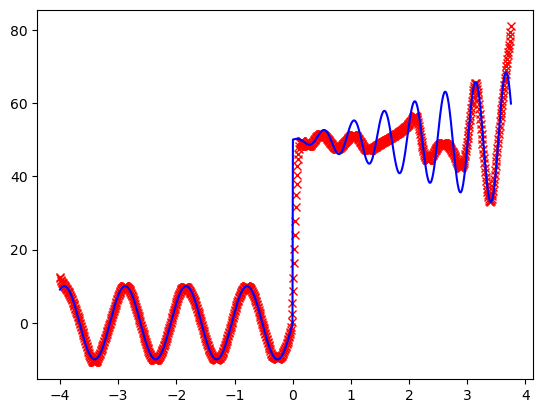

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [13]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

0.1379338193953613
